#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 不平衡数据的分类

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/structured_data/imbalanced_data" class=""><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/imbalanced_data.ipynb" class=""><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" class="">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/imbalanced_data.ipynb" class=""><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" class="">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/structured_data/imbalanced_data.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

本教程演示了如何对高度不平衡的数据集进行分类，在此类数据集中，一类中的样本数量远多于另一类中的样本数量。您将使用 Kaggle 上托管的 [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) 数据集，目的是从总共 284,807 笔交易中检测出仅有的 492 笔欺诈交易。您将使用 [Keras](../../guide/keras/overview.ipynb) 来定义模型和[类权重](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/Model)，从而帮助模型从不平衡数据中学习。

本教程包含下列操作的完整代码：

- 使用 Pandas 加载 CSV 文件。
- 创建训练、验证和测试集。
- 使用 Keras 定义并训练模型（包括设置类权重）。
- 使用各种指标（包括精确率和召回率）评估模型。
- 尝试使用常见技术来处理不平衡数据，例如：
    - 类加权
    - 过采样


## 设置

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-11-08 01:16:05.391090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 01:16:05.391146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 01:16:05.392950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 数据处理与浏览

### 下载 Kaggle Credit Card Fraud 数据集

Pandas 是一个 Python 库，其中包含许多有用的实用工具，用于加载和使用结构化数据，并可用于将 CSV 下载到数据帧中。

注：Worldline 和 ULB（布鲁塞尔自由大学）[机器学习小组](http://mlg.ulb.ac.be)在大数据挖掘和欺诈检测的合作研究期间，已对此数据集进行了收集和分析。与相关主题当前和过去项目有关的详细信息，请访问[这里](https://www.researchgate.net/project/Fraud-detection-5)和 [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) 项目页面。

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   9.604066e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    1.380247e+00  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.137433e+02 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -6.915971e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%   -5.433583e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    6.119264e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    3.480167e+01  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

### 检查类标签的不平衡

让我们看一下数据集的不平衡情况：

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



这表明正样本的比例很小。

### 清理、拆分和归一化数据

原始数据有一些问题。首先，`Time` 和 `Amount` 列变化太大，无法直接使用。删除 `Time` 列（因为不清楚其含义），并获取 `Amount` 列的日志以缩小其范围。

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

将数据集拆分为训练、验证和测试集。验证集在模型拟合期间使用，用于评估损失和任何指标，判断模型与数据的拟合程度。测试集在训练阶段完全不使用，仅在最后用于评估模型泛化到新数据的能力。这对于不平衡的数据集尤为重要，因为[过拟合](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting)是缺乏训练数据造成的一个重大问题。

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

使用 sklearn StandardScaler 将输入特征归一化。这会将平均值设置为 0，标准偏差设置为 1。

注：`StandardScaler` 只能使用 `train_features` 进行拟合，以确保模型不会窥视验证集或测试集。 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


小心：如果要部署模型，保留预处理计算至关重要。这是将它们实现为层并在导出之前将它们附加到模型最简单的方法。


### 查看数据分布

接下来通过一些特征比较一下正样本和负样本的分布。此时，建议您问自己如下问题：

- 这些分布是否有意义？
    - 是。您已对输入进行了归一化处理，而它们大多集中在 `+/- 2` 范围内。
- 您是否能看出分布之间的差异？
    - 是。正样本包含极值的比率高得多 。

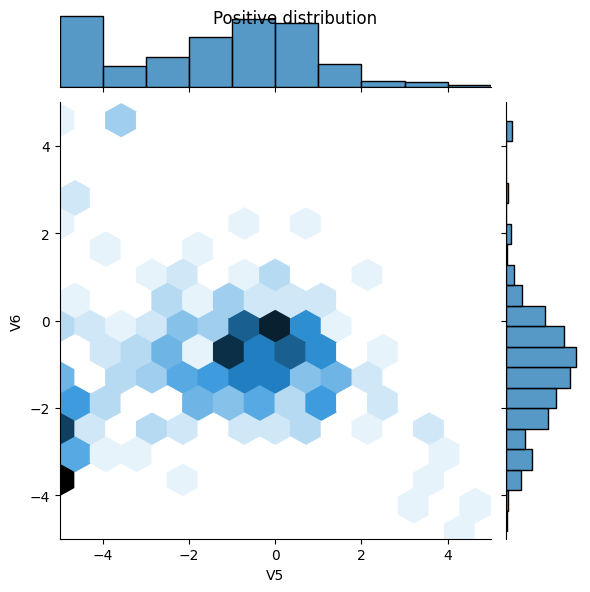

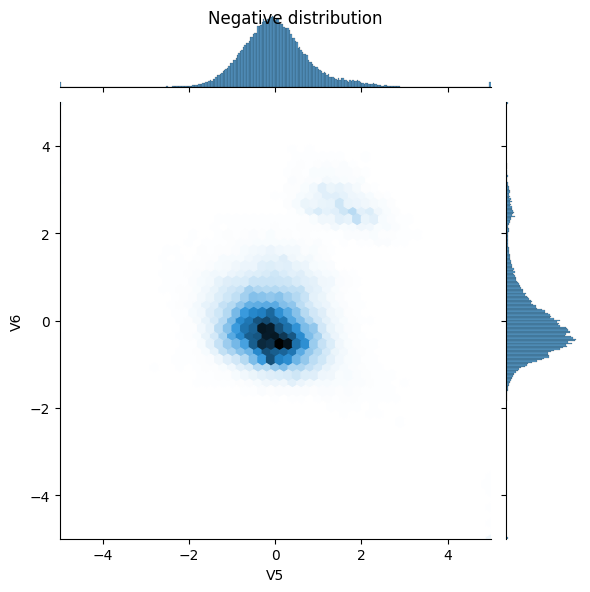

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## 定义模型和指标

定义一个函数，该函数会创建一个简单的神经网络，其中包含一个密集连接的隐藏层、一个用于减少过拟合的[随机失活](https://developers.google.com/machine-learning/glossary/#dropout_regularization)层，以及一个返回欺诈交易概率的输出 Sigmoid 层： 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### 了解有用的指标

请注意，上面定义的一些指标可以由模型计算得出，这对评估性能很有帮助。

- **假**负例和**假**正例是被**错误**分类的样本
- **真**负例和**真**正例是被**正确**分类的样本
- **准确率**是被正确分类的样本的百分比

> $\frac{\text{true samples}}{\text{total samples}}$

- **精确率**是被正确分类的**预测**正例的百分比

> $\frac{\text{true positives}}{\text{true positives + false positives}}$

- **召回率**是被正确分类的**实际**正例的百分比

> $\frac{\text{true positives}}{\text{true positives + false negatives}}$

- **AUC** 是指接收器操作特征曲线中的曲线下方面积 (ROC-AUC)。此指标等于分类器对随机正样本的排序高于随机负样本的概率。
- **AUPRC** 是指精确率-召回率曲线下方面积。该指标计算不同概率阈值的精度率-召回率对。

注：准确率在此任务中不是一个有用的指标。只要始终预测“False”，您就可以在此任务中达到 99.8%+ 的准确率。

延伸阅读：

- [真与假以及正类别与负类别](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
- [准确率](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
- [精确率和召回率](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- [精确率-召回率曲线和 ROC 曲线之间的关系](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## 基线模型

### 构建模型

现在，使用先前定义的函数创建并训练模型。请注意，该模型使用大于默认的批次大小 (2048) 来进行拟合，这一点很重要，有助于确保每个批次都有一定机会包含少量正样本。如果批次过小，它们可能会没有可供学习的欺诈交易。

注：此模型无法很好地处理类不平衡问题。我们将在本教程的后面部分对此进行改进。

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                480       


 dropout (Dropout)           (None, 16)                0         


 dense_1 (Dense)             (None, 1)                 17        


Total params: 497 (1.94 KB)


Trainable params: 497 (1.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


试运行模型：

In [14]:
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 377ms/step


array([[0.12993479],
       [0.0831413 ],
       [0.24497728],
       [0.3017688 ],
       [0.33697775],
       [0.0949156 ],
       [0.1872398 ],
       [0.27218476],
       [0.29461417],
       [0.6366021 ]], dtype=float32)

### 可选：设置正确的初始偏差。

模型最初的猜测不太理想。您知道数据集不平衡，因此需要设置输出层的偏差以反映这种不平衡（请参阅：[训练神经网络的秘诀：“好好初始化”](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)）。这样做有助于初始收敛。

使用默认偏差初始化时，损失应约为 `math.log(2) = 0.69314`。 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3724


可以用以下代码推导出要设置的正确偏差：

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$ $$ b_0 = -log_e(1/p_0 - 1) $$ $$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

将其设置为初始偏差，模型将给出合理得多的初始猜测。

结果应该接近：`pos/total = 0.0018`

In [17]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 81ms/step


array([[0.00022771],
       [0.00144273],
       [0.00385517],
       [0.00052363],
       [0.00052137],
       [0.00077223],
       [0.00100834],
       [0.00055533],
       [0.00064206],
       [0.00016787]], dtype=float32)

使用此初始化，初始损失应约为：

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0174


此初始损失大约是使用朴素初始化时损失的 50 倍。

这样，模型就不需要花费前几个周期去仅仅了解不可能有正样本。这也使得在训练过程中更容易读取损失图。

### 为初始权重设置检查点

为了使各种训练运行更具可比性，请将这个初始模型的权重保存在检查点文件中，并在训练前将它们加载到每个模型中：

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### 确认偏差修正有帮助

在继续之前，迅速确认这一细致偏差初始化是否确实起了作用。

在使用和不使用此细致初始化的情况下，将模型训练 20 个周期，并比较损失： 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

I0000 00:00:1699406183.892374  943342 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

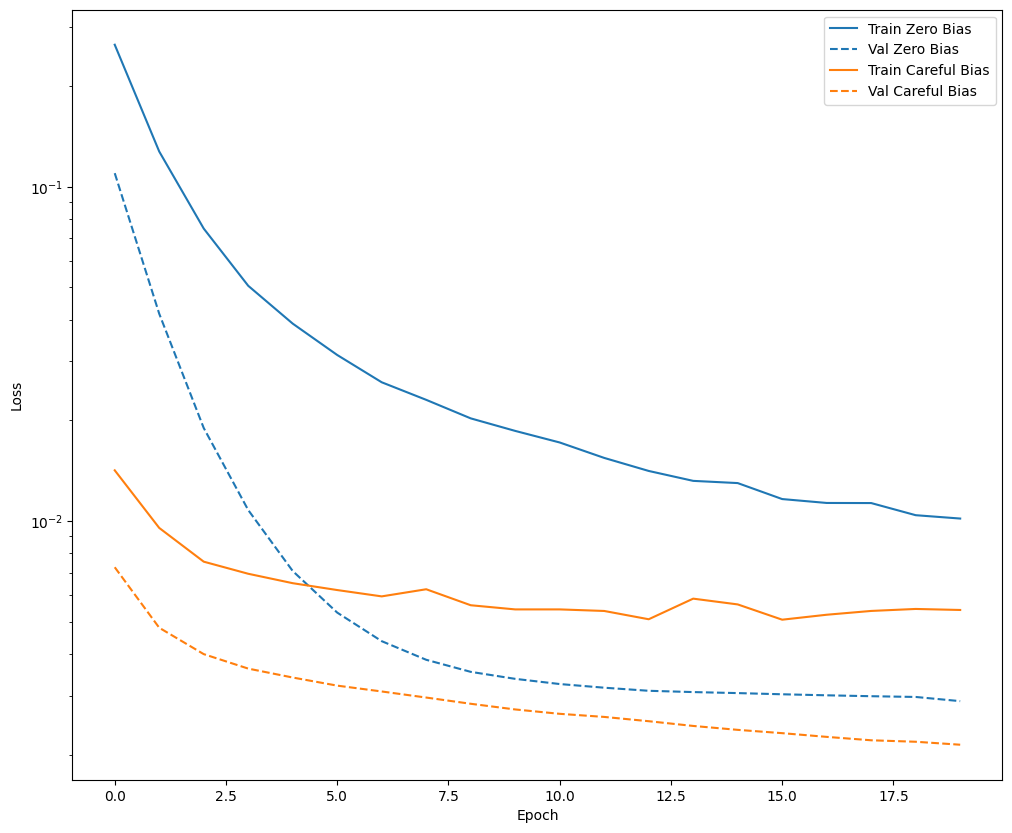

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

上图清楚表明：就验证损失而言，在这个问题上，此细致初始化具有明显优势。 

### 训练模型

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 2:12 - loss: 0.0222 - tp: 53.0000 - fp: 7.0000 - tn: 47537.0000 - fn: 20.0000 - accuracy: 0.9994 - precision: 0.8833 - recall: 0.7260 - auc: 0.9381 - prc: 0.8214

13/90 [===>..........................] - ETA: 0s - loss: 0.0163 - tp: 54.0000 - fp: 9.0000 - tn: 72074.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.4909 - auc: 0.8165 - prc: 0.5668  

26/90 [=======>......................] - ETA: 0s - loss: 0.0152 - tp: 57.0000 - fp: 9.0000 - tn: 98651.0000 - fn: 100.0000 - accuracy: 0.9989 - precision: 0.8636 - recall: 0.3631 - auc: 0.7679 - prc: 0.4679

39/90 [============>.................] - ETA: 0s - loss: 0.0148 - tp: 62.0000 - fp: 13.0000 - tn: 125224.0000 - fn: 142.0000 - accuracy: 0.9988 - precision: 0.8267 - recall: 0.3039 - auc: 0.7463 - prc: 0.4043

51/90 [================>.............] - ETA: 0s - loss: 0.0142 - tp: 70.0000 - fp: 15.0000 - tn: 149753.0000 - fn: 179.0000 - accuracy: 0.9987 - precision: 0.8235 - recall: 0.2811 - auc: 0.7429 - prc: 0.3902

63/90 [====================>.........] - ETA: 0s - loss: 0.0138 - tp: 81.0000 - fp: 20.0000 - tn: 174282.0000 - fn: 210.0000 - accuracy: 0.9987 - precision: 0.8020 - recall: 0.2784 - auc: 0.7343 - prc: 0.3645

75/90 [========================>.....] - ETA: 0s - loss: 0.0140 - tp: 92.0000 - fp: 23.0000 - tn: 198804.0000 - fn: 250.0000 - accuracy: 0.9986 - precision: 0.8000 - recall: 0.2690 - auc: 0.7217 - prc: 0.3359

88/90 [============================>.] - ETA: 0s - loss: 0.0136 - tp: 101.0000 - fp: 26.0000 - tn: 225385.0000 - fn: 281.0000 - accuracy: 0.9986 - precision: 0.7953 - recall: 0.2644 - auc: 0.7225 - prc: 0.3209

90/90 [==============================] - 3s 12ms/step - loss: 0.0135 - tp: 101.0000 - fp: 26.0000 - tn: 227434.0000 - fn: 284.0000 - accuracy: 0.9986 - precision: 0.7953 - recall: 0.2623 - auc: 0.7220 - prc: 0.3198 - val_loss: 0.0076 - val_tp: 3.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 66.0000 - val_accuracy: 0.9984 - val_precision: 0.3750 - val_recall: 0.0435 - val_auc: 0.8258 - val_prc: 0.4747


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0109 - tp: 14.0000 - fp: 3.0000 - tn: 28613.0000 - fn: 42.0000 - accuracy: 0.9984 - precision: 0.8235 - recall: 0.2500 - auc: 0.7258 - prc: 0.3564     

27/90 [========>.....................] - ETA: 0s - loss: 0.0092 - tp: 32.0000 - fp: 5.0000 - tn: 55193.0000 - fn: 66.0000 - accuracy: 0.9987 - precision: 0.8649 - recall: 0.3265 - auc: 0.7647 - prc: 0.4089

40/90 [============>.................] - ETA: 0s - loss: 0.0091 - tp: 47.0000 - fp: 9.0000 - tn: 81768.0000 - fn: 96.0000 - accuracy: 0.9987 - precision: 0.8393 - recall: 0.3287 - auc: 0.7632 - prc: 0.3912

53/90 [================>.............] - ETA: 0s - loss: 0.0093 - tp: 62.0000 - fp: 12.0000 - tn: 108343.0000 - fn: 127.0000 - accuracy: 0.9987 - precision: 0.8378 - recall: 0.3280 - auc: 0.7559 - prc: 0.3724

66/90 [=====================>........] - ETA: 0s - loss: 0.0093 - tp: 74.0000 - fp: 14.0000 - tn: 134924.0000 - fn: 156.0000 - accuracy: 0.9987 - precision: 0.8409 - recall: 0.3217 - auc: 0.7502 - prc: 0.3541

79/90 [=========================>....] - ETA: 0s - loss: 0.0094 - tp: 90.0000 - fp: 15.0000 - tn: 161500.0000 - fn: 187.0000 - accuracy: 0.9988 - precision: 0.8571 - recall: 0.3249 - auc: 0.7463 - prc: 0.3554

90/90 [==============================] - 1s 6ms/step - loss: 0.0094 - tp: 98.0000 - fp: 16.0000 - tn: 181944.0000 - fn: 218.0000 - accuracy: 0.9987 - precision: 0.8596 - recall: 0.3101 - auc: 0.7451 - prc: 0.3475 - val_loss: 0.0050 - val_tp: 18.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 51.0000 - val_accuracy: 0.9987 - val_precision: 0.7500 - val_recall: 0.2609 - val_auc: 0.9127 - val_prc: 0.6222


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0169 - tp: 1.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 6.0000 - accuracy: 0.9966 - precision: 0.5000 - recall: 0.1429 - auc: 0.7811 - prc: 0.3493

13/90 [===>..........................] - ETA: 0s - loss: 0.0084 - tp: 12.0000 - fp: 4.0000 - tn: 26574.0000 - fn: 34.0000 - accuracy: 0.9986 - precision: 0.7500 - recall: 0.2609 - auc: 0.8100 - prc: 0.3670

26/90 [=======>......................] - ETA: 0s - loss: 0.0082 - tp: 21.0000 - fp: 7.0000 - tn: 53161.0000 - fn: 59.0000 - accuracy: 0.9988 - precision: 0.7500 - recall: 0.2625 - auc: 0.7694 - prc: 0.2973

39/90 [============>.................] - ETA: 0s - loss: 0.0069 - tp: 39.0000 - fp: 9.0000 - tn: 79748.0000 - fn: 76.0000 - accuracy: 0.9989 - precision: 0.8125 - recall: 0.3391 - auc: 0.8085 - prc: 0.4113

52/90 [================>.............] - ETA: 0s - loss: 0.0075 - tp: 67.0000 - fp: 12.0000 - tn: 106300.0000 - fn: 117.0000 - accuracy: 0.9988 - precision: 0.8481 - recall: 0.3641 - auc: 0.8303 - prc: 0.4824

65/90 [====================>.........] - ETA: 0s - loss: 0.0078 - tp: 81.0000 - fp: 16.0000 - tn: 132874.0000 - fn: 149.0000 - accuracy: 0.9988 - precision: 0.8351 - recall: 0.3522 - auc: 0.8242 - prc: 0.4642

78/90 [=========================>....] - ETA: 0s - loss: 0.0078 - tp: 105.0000 - fp: 21.0000 - tn: 159444.0000 - fn: 174.0000 - accuracy: 0.9988 - precision: 0.8333 - recall: 0.3763 - auc: 0.8294 - prc: 0.4714

90/90 [==============================] - ETA: 0s - loss: 0.0079 - tp: 118.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 198.0000 - accuracy: 0.9988 - precision: 0.8252 - recall: 0.3734 - auc: 0.8315 - prc: 0.4644

90/90 [==============================] - 1s 6ms/step - loss: 0.0079 - tp: 118.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 198.0000 - accuracy: 0.9988 - precision: 0.8252 - recall: 0.3734 - auc: 0.8315 - prc: 0.4644 - val_loss: 0.0039 - val_tp: 38.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 31.0000 - val_accuracy: 0.9992 - val_precision: 0.8636 - val_recall: 0.5507 - val_auc: 0.9199 - val_prc: 0.6663


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.0117 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.2000 - auc: 0.7963 - prc: 0.4049

13/90 [===>..........................] - ETA: 0s - loss: 0.0068 - tp: 20.0000 - fp: 2.0000 - tn: 26577.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.9091 - recall: 0.4444 - auc: 0.8411 - prc: 0.5325 

25/90 [=======>......................] - ETA: 0s - loss: 0.0060 - tp: 44.0000 - fp: 4.0000 - tn: 51106.0000 - fn: 46.0000 - accuracy: 0.9990 - precision: 0.9167 - recall: 0.4889 - auc: 0.8640 - prc: 0.6129

37/90 [===========>..................] - ETA: 0s - loss: 0.0066 - tp: 63.0000 - fp: 8.0000 - tn: 75635.0000 - fn: 70.0000 - accuracy: 0.9990 - precision: 0.8873 - recall: 0.4737 - auc: 0.8507 - prc: 0.5687

49/90 [===============>..............] - ETA: 0s - loss: 0.0064 - tp: 75.0000 - fp: 8.0000 - tn: 100172.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.9036 - recall: 0.4360 - auc: 0.8548 - prc: 0.5621

61/90 [===================>..........] - ETA: 0s - loss: 0.0064 - tp: 98.0000 - fp: 11.0000 - tn: 124703.0000 - fn: 116.0000 - accuracy: 0.9990 - precision: 0.8991 - recall: 0.4579 - auc: 0.8548 - prc: 0.5553

74/90 [=======================>......] - ETA: 0s - loss: 0.0066 - tp: 116.0000 - fp: 16.0000 - tn: 151273.0000 - fn: 147.0000 - accuracy: 0.9989 - precision: 0.8788 - recall: 0.4411 - auc: 0.8547 - prc: 0.5462

87/90 [============================>.] - ETA: 0s - loss: 0.0069 - tp: 130.0000 - fp: 24.0000 - tn: 177845.0000 - fn: 177.0000 - accuracy: 0.9989 - precision: 0.8442 - recall: 0.4235 - auc: 0.8540 - prc: 0.5259

90/90 [==============================] - 1s 6ms/step - loss: 0.0069 - tp: 132.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 184.0000 - accuracy: 0.9989 - precision: 0.8408 - recall: 0.4177 - auc: 0.8565 - prc: 0.5263 - val_loss: 0.0036 - val_tp: 43.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8776 - val_recall: 0.6232 - val_auc: 0.9272 - val_prc: 0.6980


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7462 - prc: 0.5013

13/90 [===>..........................] - ETA: 0s - loss: 0.0075 - tp: 14.0000 - fp: 5.0000 - tn: 26572.0000 - fn: 33.0000 - accuracy: 0.9986 - precision: 0.7368 - recall: 0.2979 - auc: 0.8160 - prc: 0.4588 

25/90 [=======>......................] - ETA: 0s - loss: 0.0073 - tp: 39.0000 - fp: 8.0000 - tn: 51095.0000 - fn: 58.0000 - accuracy: 0.9987 - precision: 0.8298 - recall: 0.4021 - auc: 0.8428 - prc: 0.5501

38/90 [===========>..................] - ETA: 0s - loss: 0.0074 - tp: 55.0000 - fp: 11.0000 - tn: 77668.0000 - fn: 90.0000 - accuracy: 0.9987 - precision: 0.8333 - recall: 0.3793 - auc: 0.8494 - prc: 0.5448

51/90 [================>.............] - ETA: 0s - loss: 0.0072 - tp: 82.0000 - fp: 14.0000 - tn: 104239.0000 - fn: 113.0000 - accuracy: 0.9988 - precision: 0.8542 - recall: 0.4205 - auc: 0.8516 - prc: 0.5607

63/90 [====================>.........] - ETA: 0s - loss: 0.0068 - tp: 97.0000 - fp: 19.0000 - tn: 128775.0000 - fn: 133.0000 - accuracy: 0.9988 - precision: 0.8362 - recall: 0.4217 - auc: 0.8632 - prc: 0.5676

75/90 [========================>.....] - ETA: 0s - loss: 0.0066 - tp: 117.0000 - fp: 23.0000 - tn: 153306.0000 - fn: 154.0000 - accuracy: 0.9988 - precision: 0.8357 - recall: 0.4317 - auc: 0.8633 - prc: 0.5670

87/90 [============================>.] - ETA: 0s - loss: 0.0065 - tp: 136.0000 - fp: 27.0000 - tn: 177839.0000 - fn: 174.0000 - accuracy: 0.9989 - precision: 0.8344 - recall: 0.4387 - auc: 0.8641 - prc: 0.5668

90/90 [==============================] - 1s 6ms/step - loss: 0.0065 - tp: 138.0000 - fp: 28.0000 - tn: 181932.0000 - fn: 178.0000 - accuracy: 0.9989 - precision: 0.8313 - recall: 0.4367 - auc: 0.8619 - prc: 0.5629 - val_loss: 0.0034 - val_tp: 44.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8800 - val_recall: 0.6377 - val_auc: 0.9345 - val_prc: 0.7071


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0121 - tp: 1.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 5.0000 - accuracy: 0.9971 - precision: 0.5000 - recall: 0.1667 - auc: 0.8308 - prc: 0.4015

14/90 [===>..........................] - ETA: 0s - loss: 0.0081 - tp: 23.0000 - fp: 8.0000 - tn: 28607.0000 - fn: 34.0000 - accuracy: 0.9985 - precision: 0.7419 - recall: 0.4035 - auc: 0.8579 - prc: 0.5129

27/90 [========>.....................] - ETA: 0s - loss: 0.0076 - tp: 51.0000 - fp: 14.0000 - tn: 55177.0000 - fn: 54.0000 - accuracy: 0.9988 - precision: 0.7846 - recall: 0.4857 - auc: 0.8746 - prc: 0.5408

40/90 [============>.................] - ETA: 0s - loss: 0.0070 - tp: 76.0000 - fp: 16.0000 - tn: 81748.0000 - fn: 80.0000 - accuracy: 0.9988 - precision: 0.8261 - recall: 0.4872 - auc: 0.8767 - prc: 0.5825

53/90 [================>.............] - ETA: 0s - loss: 0.0064 - tp: 94.0000 - fp: 18.0000 - tn: 108333.0000 - fn: 99.0000 - accuracy: 0.9989 - precision: 0.8393 - recall: 0.4870 - auc: 0.8741 - prc: 0.5848

66/90 [=====================>........] - ETA: 0s - loss: 0.0064 - tp: 104.0000 - fp: 23.0000 - tn: 134911.0000 - fn: 130.0000 - accuracy: 0.9989 - precision: 0.8189 - recall: 0.4444 - auc: 0.8681 - prc: 0.5673

79/90 [=========================>....] - ETA: 0s - loss: 0.0063 - tp: 127.0000 - fp: 23.0000 - tn: 161487.0000 - fn: 155.0000 - accuracy: 0.9989 - precision: 0.8467 - recall: 0.4504 - auc: 0.8690 - prc: 0.5785

90/90 [==============================] - 1s 6ms/step - loss: 0.0061 - tp: 149.0000 - fp: 29.0000 - tn: 181931.0000 - fn: 167.0000 - accuracy: 0.9989 - precision: 0.8371 - recall: 0.4715 - auc: 0.8767 - prc: 0.5928 - val_loss: 0.0032 - val_tp: 44.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8800 - val_recall: 0.6377 - val_auc: 0.9417 - val_prc: 0.7401


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.0043 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9945 - prc: 0.1866

13/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 18.0000 - fp: 3.0000 - tn: 26578.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.8571 - recall: 0.4186 - auc: 0.9056 - prc: 0.6345             

26/90 [=======>......................] - ETA: 0s - loss: 0.0065 - tp: 49.0000 - fp: 6.0000 - tn: 53136.0000 - fn: 57.0000 - accuracy: 0.9988 - precision: 0.8909 - recall: 0.4623 - auc: 0.8616 - prc: 0.6259

39/90 [============>.................] - ETA: 0s - loss: 0.0063 - tp: 63.0000 - fp: 12.0000 - tn: 79717.0000 - fn: 80.0000 - accuracy: 0.9988 - precision: 0.8400 - recall: 0.4406 - auc: 0.8514 - prc: 0.5675

52/90 [================>.............] - ETA: 0s - loss: 0.0066 - tp: 87.0000 - fp: 17.0000 - tn: 106287.0000 - fn: 105.0000 - accuracy: 0.9989 - precision: 0.8365 - recall: 0.4531 - auc: 0.8524 - prc: 0.5459

65/90 [====================>.........] - ETA: 0s - loss: 0.0067 - tp: 111.0000 - fp: 20.0000 - tn: 132860.0000 - fn: 129.0000 - accuracy: 0.9989 - precision: 0.8473 - recall: 0.4625 - auc: 0.8504 - prc: 0.5494

78/90 [=========================>....] - ETA: 0s - loss: 0.0065 - tp: 132.0000 - fp: 25.0000 - tn: 159431.0000 - fn: 156.0000 - accuracy: 0.9989 - precision: 0.8408 - recall: 0.4583 - auc: 0.8577 - prc: 0.5599

90/90 [==============================] - 1s 6ms/step - loss: 0.0061 - tp: 150.0000 - fp: 29.0000 - tn: 181931.0000 - fn: 166.0000 - accuracy: 0.9989 - precision: 0.8380 - recall: 0.4747 - auc: 0.8655 - prc: 0.5760 - val_loss: 0.0031 - val_tp: 44.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8800 - val_recall: 0.6377 - val_auc: 0.9418 - val_prc: 0.7652


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8312 - prc: 0.6682

14/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 25.0000 - fp: 4.0000 - tn: 28621.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8621 - recall: 0.5319 - auc: 0.9140 - prc: 0.6962             

27/90 [========>.....................] - ETA: 0s - loss: 0.0048 - tp: 44.0000 - fp: 6.0000 - tn: 55198.0000 - fn: 48.0000 - accuracy: 0.9990 - precision: 0.8800 - recall: 0.4783 - auc: 0.8957 - prc: 0.6812

40/90 [============>.................] - ETA: 0s - loss: 0.0049 - tp: 66.0000 - fp: 11.0000 - tn: 81777.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5000 - auc: 0.8891 - prc: 0.6565

52/90 [================>.............] - ETA: 0s - loss: 0.0055 - tp: 88.0000 - fp: 13.0000 - tn: 106301.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.8713 - recall: 0.4835 - auc: 0.8807 - prc: 0.6367

65/90 [====================>.........] - ETA: 0s - loss: 0.0062 - tp: 107.0000 - fp: 19.0000 - tn: 132872.0000 - fn: 122.0000 - accuracy: 0.9989 - precision: 0.8492 - recall: 0.4672 - auc: 0.8655 - prc: 0.5871

78/90 [=========================>....] - ETA: 0s - loss: 0.0061 - tp: 123.0000 - fp: 21.0000 - tn: 159450.0000 - fn: 150.0000 - accuracy: 0.9989 - precision: 0.8542 - recall: 0.4505 - auc: 0.8668 - prc: 0.5788

90/90 [==============================] - 1s 6ms/step - loss: 0.0061 - tp: 144.0000 - fp: 22.0000 - tn: 181938.0000 - fn: 172.0000 - accuracy: 0.9989 - precision: 0.8675 - recall: 0.4557 - auc: 0.8658 - prc: 0.5889 - val_loss: 0.0029 - val_tp: 45.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8824 - val_recall: 0.6522 - val_auc: 0.9418 - val_prc: 0.7871


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 7.6812e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 30.0000 - fp: 5.0000 - tn: 28611.0000 - fn: 26.0000 - accuracy: 0.9989 - precision: 0.8571 - recall: 0.5357 - auc: 0.9188 - prc: 0.7594         

27/90 [========>.....................] - ETA: 0s - loss: 0.0060 - tp: 49.0000 - fp: 8.0000 - tn: 55187.0000 - fn: 52.0000 - accuracy: 0.9989 - precision: 0.8596 - recall: 0.4851 - auc: 0.8650 - prc: 0.6163

40/90 [============>.................] - ETA: 0s - loss: 0.0060 - tp: 70.0000 - fp: 13.0000 - tn: 81761.0000 - fn: 76.0000 - accuracy: 0.9989 - precision: 0.8434 - recall: 0.4795 - auc: 0.8616 - prc: 0.5926

53/90 [================>.............] - ETA: 0s - loss: 0.0060 - tp: 90.0000 - fp: 16.0000 - tn: 108337.0000 - fn: 101.0000 - accuracy: 0.9989 - precision: 0.8491 - recall: 0.4712 - auc: 0.8572 - prc: 0.5748

66/90 [=====================>........] - ETA: 0s - loss: 0.0059 - tp: 116.0000 - fp: 19.0000 - tn: 134904.0000 - fn: 129.0000 - accuracy: 0.9989 - precision: 0.8593 - recall: 0.4735 - auc: 0.8640 - prc: 0.6013

78/90 [=========================>....] - ETA: 0s - loss: 0.0058 - tp: 136.0000 - fp: 21.0000 - tn: 159437.0000 - fn: 150.0000 - accuracy: 0.9989 - precision: 0.8662 - recall: 0.4755 - auc: 0.8658 - prc: 0.6053

90/90 [==============================] - 1s 6ms/step - loss: 0.0059 - tp: 144.0000 - fp: 26.0000 - tn: 181934.0000 - fn: 172.0000 - accuracy: 0.9989 - precision: 0.8471 - recall: 0.4557 - auc: 0.8610 - prc: 0.5845 - val_loss: 0.0028 - val_tp: 46.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.8846 - val_recall: 0.6667 - val_auc: 0.9490 - val_prc: 0.8028


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0065 - tp: 18.0000 - fp: 7.0000 - tn: 26575.0000 - fn: 24.0000 - accuracy: 0.9988 - precision: 0.7200 - recall: 0.4286 - auc: 0.8556 - prc: 0.4701 

26/90 [=======>......................] - ETA: 0s - loss: 0.0056 - tp: 45.0000 - fp: 11.0000 - tn: 53149.0000 - fn: 43.0000 - accuracy: 0.9990 - precision: 0.8036 - recall: 0.5114 - auc: 0.8680 - prc: 0.5832

39/90 [============>.................] - ETA: 0s - loss: 0.0058 - tp: 62.0000 - fp: 20.0000 - tn: 79724.0000 - fn: 66.0000 - accuracy: 0.9989 - precision: 0.7561 - recall: 0.4844 - auc: 0.8659 - prc: 0.5632

52/90 [================>.............] - ETA: 0s - loss: 0.0057 - tp: 81.0000 - fp: 24.0000 - tn: 106303.0000 - fn: 88.0000 - accuracy: 0.9989 - precision: 0.7714 - recall: 0.4793 - auc: 0.8716 - prc: 0.5663

65/90 [====================>.........] - ETA: 0s - loss: 0.0059 - tp: 97.0000 - fp: 25.0000 - tn: 132874.0000 - fn: 124.0000 - accuracy: 0.9989 - precision: 0.7951 - recall: 0.4389 - auc: 0.8653 - prc: 0.5698

78/90 [=========================>....] - ETA: 0s - loss: 0.0058 - tp: 119.0000 - fp: 27.0000 - tn: 159450.0000 - fn: 148.0000 - accuracy: 0.9989 - precision: 0.8151 - recall: 0.4457 - auc: 0.8677 - prc: 0.5831

90/90 [==============================] - 1s 6ms/step - loss: 0.0058 - tp: 144.0000 - fp: 28.0000 - tn: 181932.0000 - fn: 172.0000 - accuracy: 0.9989 - precision: 0.8372 - recall: 0.4557 - auc: 0.8690 - prc: 0.5951 - val_loss: 0.0027 - val_tp: 45.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8824 - val_recall: 0.6522 - val_auc: 0.9490 - val_prc: 0.8107


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.0074 - tp: 5.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.8333 - auc: 0.9159 - prc: 0.5690

14/90 [===>..........................] - ETA: 0s - loss: 0.0065 - tp: 27.0000 - fp: 5.0000 - tn: 28613.0000 - fn: 27.0000 - accuracy: 0.9989 - precision: 0.8438 - recall: 0.5000 - auc: 0.8693 - prc: 0.5833

27/90 [========>.....................] - ETA: 0s - loss: 0.0060 - tp: 49.0000 - fp: 6.0000 - tn: 55189.0000 - fn: 52.0000 - accuracy: 0.9990 - precision: 0.8909 - recall: 0.4851 - auc: 0.8651 - prc: 0.6013

40/90 [============>.................] - ETA: 0s - loss: 0.0058 - tp: 69.0000 - fp: 12.0000 - tn: 81764.0000 - fn: 75.0000 - accuracy: 0.9989 - precision: 0.8519 - recall: 0.4792 - auc: 0.8737 - prc: 0.5979

53/90 [================>.............] - ETA: 0s - loss: 0.0056 - tp: 79.0000 - fp: 14.0000 - tn: 108355.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8495 - recall: 0.4514 - auc: 0.8701 - prc: 0.5820

66/90 [=====================>........] - ETA: 0s - loss: 0.0057 - tp: 100.0000 - fp: 16.0000 - tn: 134932.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.4545 - auc: 0.8577 - prc: 0.5691

79/90 [=========================>....] - ETA: 0s - loss: 0.0058 - tp: 137.0000 - fp: 22.0000 - tn: 161492.0000 - fn: 141.0000 - accuracy: 0.9990 - precision: 0.8616 - recall: 0.4928 - auc: 0.8620 - prc: 0.5802

90/90 [==============================] - 1s 6ms/step - loss: 0.0058 - tp: 150.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 166.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.4747 - auc: 0.8626 - prc: 0.5828 - val_loss: 0.0027 - val_tp: 45.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8824 - val_recall: 0.6522 - val_auc: 0.9491 - val_prc: 0.8156


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041

14/90 [===>..........................] - ETA: 0s - loss: 0.0061 - tp: 30.0000 - fp: 7.0000 - tn: 28610.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.8108 - recall: 0.5455 - auc: 0.8441 - prc: 0.5886 

27/90 [========>.....................] - ETA: 0s - loss: 0.0052 - tp: 48.0000 - fp: 9.0000 - tn: 55192.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5053 - auc: 0.8673 - prc: 0.6287

40/90 [============>.................] - ETA: 0s - loss: 0.0048 - tp: 65.0000 - fp: 11.0000 - tn: 81778.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8553 - recall: 0.4962 - auc: 0.8806 - prc: 0.6323

53/90 [================>.............] - ETA: 0s - loss: 0.0047 - tp: 93.0000 - fp: 17.0000 - tn: 108349.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8455 - recall: 0.5225 - auc: 0.8923 - prc: 0.6563

66/90 [=====================>........] - ETA: 0s - loss: 0.0051 - tp: 118.0000 - fp: 21.0000 - tn: 134916.0000 - fn: 113.0000 - accuracy: 0.9990 - precision: 0.8489 - recall: 0.5108 - auc: 0.8777 - prc: 0.6334

79/90 [=========================>....] - ETA: 0s - loss: 0.0052 - tp: 137.0000 - fp: 26.0000 - tn: 161487.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8405 - recall: 0.4910 - auc: 0.8806 - prc: 0.6243

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 154.0000 - fp: 26.0000 - tn: 181934.0000 - fn: 162.0000 - accuracy: 0.9990 - precision: 0.8556 - recall: 0.4873 - auc: 0.8739 - prc: 0.6229 - val_loss: 0.0026 - val_tp: 48.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8889 - val_recall: 0.6957 - val_auc: 0.9563 - val_prc: 0.8279


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9160 - prc: 0.8353

14/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 16.0000 - fp: 4.0000 - tn: 28629.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.4103 - auc: 0.8061 - prc: 0.5070 

27/90 [========>.....................] - ETA: 0s - loss: 0.0049 - tp: 42.0000 - fp: 7.0000 - tn: 55209.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.5250 - auc: 0.8362 - prc: 0.5793

40/90 [============>.................] - ETA: 0s - loss: 0.0053 - tp: 62.0000 - fp: 16.0000 - tn: 81781.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.7949 - recall: 0.5041 - auc: 0.8484 - prc: 0.5560

52/90 [================>.............] - ETA: 0s - loss: 0.0050 - tp: 73.0000 - fp: 18.0000 - tn: 106323.0000 - fn: 82.0000 - accuracy: 0.9991 - precision: 0.8022 - recall: 0.4710 - auc: 0.8536 - prc: 0.5555

64/90 [====================>.........] - ETA: 0s - loss: 0.0052 - tp: 97.0000 - fp: 22.0000 - tn: 130843.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8151 - recall: 0.4686 - auc: 0.8588 - prc: 0.5831

77/90 [========================>.....] - ETA: 0s - loss: 0.0055 - tp: 122.0000 - fp: 27.0000 - tn: 157400.0000 - fn: 147.0000 - accuracy: 0.9989 - precision: 0.8188 - recall: 0.4535 - auc: 0.8669 - prc: 0.5955

90/90 [==============================] - ETA: 0s - loss: 0.0056 - tp: 142.0000 - fp: 28.0000 - tn: 181932.0000 - fn: 174.0000 - accuracy: 0.9989 - precision: 0.8353 - recall: 0.4494 - auc: 0.8627 - prc: 0.5919

90/90 [==============================] - 1s 6ms/step - loss: 0.0056 - tp: 142.0000 - fp: 28.0000 - tn: 181932.0000 - fn: 174.0000 - accuracy: 0.9989 - precision: 0.8353 - recall: 0.4494 - auc: 0.8627 - prc: 0.5919 - val_loss: 0.0025 - val_tp: 49.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8750 - val_recall: 0.7101 - val_auc: 0.9563 - val_prc: 0.8343


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0012 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0074 - tp: 22.0000 - fp: 7.0000 - tn: 28612.0000 - fn: 31.0000 - accuracy: 0.9987 - precision: 0.7586 - recall: 0.4151 - auc: 0.8283 - prc: 0.4912             

27/90 [========>.....................] - ETA: 0s - loss: 0.0054 - tp: 43.0000 - fp: 8.0000 - tn: 55199.0000 - fn: 46.0000 - accuracy: 0.9990 - precision: 0.8431 - recall: 0.4831 - auc: 0.8581 - prc: 0.5858

41/90 [============>.................] - ETA: 0s - loss: 0.0048 - tp: 69.0000 - fp: 11.0000 - tn: 83827.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.8625 - recall: 0.5308 - auc: 0.8795 - prc: 0.6225

55/90 [=================>............] - ETA: 0s - loss: 0.0053 - tp: 101.0000 - fp: 14.0000 - tn: 112429.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8783 - recall: 0.5127 - auc: 0.8819 - prc: 0.6226

69/90 [======================>.......] - ETA: 0s - loss: 0.0057 - tp: 132.0000 - fp: 18.0000 - tn: 141030.0000 - fn: 132.0000 - accuracy: 0.9989 - precision: 0.8800 - recall: 0.5000 - auc: 0.8756 - prc: 0.6215

82/90 [==========================>...] - ETA: 0s - loss: 0.0055 - tp: 150.0000 - fp: 24.0000 - tn: 167612.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.5000 - auc: 0.8787 - prc: 0.6158

90/90 [==============================] - 0s 6ms/step - loss: 0.0054 - tp: 155.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 161.0000 - accuracy: 0.9990 - precision: 0.8611 - recall: 0.4905 - auc: 0.8752 - prc: 0.6058 - val_loss: 0.0024 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8644 - val_recall: 0.7391 - val_auc: 0.9563 - val_prc: 0.8385


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0143 - tp: 3.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.7500 - recall: 0.5000 - auc: 0.7469 - prc: 0.3884

15/90 [====>.........................] - ETA: 0s - loss: 0.0051 - tp: 34.0000 - fp: 5.0000 - tn: 30656.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.8718 - recall: 0.5763 - auc: 0.8888 - prc: 0.7132

29/90 [========>.....................] - ETA: 0s - loss: 0.0063 - tp: 62.0000 - fp: 15.0000 - tn: 59258.0000 - fn: 57.0000 - accuracy: 0.9988 - precision: 0.8052 - recall: 0.5210 - auc: 0.8938 - prc: 0.6216

43/90 [=============>................] - ETA: 0s - loss: 0.0062 - tp: 81.0000 - fp: 19.0000 - tn: 87879.0000 - fn: 85.0000 - accuracy: 0.9988 - precision: 0.8100 - recall: 0.4880 - auc: 0.8782 - prc: 0.5892

57/90 [==================>...........] - ETA: 0s - loss: 0.0059 - tp: 100.0000 - fp: 24.0000 - tn: 116505.0000 - fn: 107.0000 - accuracy: 0.9989 - precision: 0.8065 - recall: 0.4831 - auc: 0.8755 - prc: 0.5848

70/90 [======================>.......] - ETA: 0s - loss: 0.0058 - tp: 130.0000 - fp: 26.0000 - tn: 143074.0000 - fn: 130.0000 - accuracy: 0.9989 - precision: 0.8333 - recall: 0.5000 - auc: 0.8737 - prc: 0.6053

83/90 [==========================>...] - ETA: 0s - loss: 0.0054 - tp: 149.0000 - fp: 29.0000 - tn: 169660.0000 - fn: 146.0000 - accuracy: 0.9990 - precision: 0.8371 - recall: 0.5051 - auc: 0.8750 - prc: 0.6190

90/90 [==============================] - 0s 6ms/step - loss: 0.0054 - tp: 160.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 156.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5063 - auc: 0.8722 - prc: 0.6190 - val_loss: 0.0024 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9563 - val_prc: 0.8455


Epoch 16/100


 1/90 [..............................] - ETA: 0s - loss: 0.0061 - tp: 1.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.5000 - recall: 0.5000 - auc: 0.9961 - prc: 0.2938

13/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 21.0000 - fp: 6.0000 - tn: 26578.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.7778 - recall: 0.5250 - auc: 0.8989 - prc: 0.6050

26/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 44.0000 - fp: 11.0000 - tn: 53156.0000 - fn: 37.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.5432 - auc: 0.8940 - prc: 0.6204

39/90 [============>.................] - ETA: 0s - loss: 0.0049 - tp: 63.0000 - fp: 12.0000 - tn: 79733.0000 - fn: 64.0000 - accuracy: 0.9990 - precision: 0.8400 - recall: 0.4961 - auc: 0.8650 - prc: 0.5994

52/90 [================>.............] - ETA: 0s - loss: 0.0052 - tp: 88.0000 - fp: 16.0000 - tn: 106299.0000 - fn: 93.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.4862 - auc: 0.8718 - prc: 0.6113

65/90 [====================>.........] - ETA: 0s - loss: 0.0054 - tp: 119.0000 - fp: 20.0000 - tn: 132866.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8561 - recall: 0.5085 - auc: 0.8793 - prc: 0.6189

78/90 [=========================>....] - ETA: 0s - loss: 0.0053 - tp: 135.0000 - fp: 24.0000 - tn: 159443.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8491 - recall: 0.4874 - auc: 0.8744 - prc: 0.6138

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 155.0000 - fp: 29.0000 - tn: 181931.0000 - fn: 161.0000 - accuracy: 0.9990 - precision: 0.8424 - recall: 0.4905 - auc: 0.8787 - prc: 0.6159 - val_loss: 0.0023 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9563 - val_prc: 0.8522


Epoch 17/100


 1/90 [..............................] - ETA: 0s - loss: 0.0099 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7482 - prc: 0.5028

14/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 25.0000 - fp: 3.0000 - tn: 28621.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.8929 - recall: 0.5208 - auc: 0.8740 - prc: 0.6697             

27/90 [========>.....................] - ETA: 0s - loss: 0.0044 - tp: 57.0000 - fp: 8.0000 - tn: 55190.0000 - fn: 41.0000 - accuracy: 0.9991 - precision: 0.8769 - recall: 0.5816 - auc: 0.8970 - prc: 0.6821

40/90 [============>.................] - ETA: 0s - loss: 0.0051 - tp: 82.0000 - fp: 14.0000 - tn: 81756.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8542 - recall: 0.5467 - auc: 0.8788 - prc: 0.6432

53/90 [================>.............] - ETA: 0s - loss: 0.0053 - tp: 105.0000 - fp: 19.0000 - tn: 108328.0000 - fn: 92.0000 - accuracy: 0.9990 - precision: 0.8468 - recall: 0.5330 - auc: 0.8770 - prc: 0.6191

66/90 [=====================>........] - ETA: 0s - loss: 0.0049 - tp: 125.0000 - fp: 23.0000 - tn: 134917.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8446 - recall: 0.5482 - auc: 0.8761 - prc: 0.6229

79/90 [=========================>....] - ETA: 0s - loss: 0.0052 - tp: 150.0000 - fp: 33.0000 - tn: 161485.0000 - fn: 124.0000 - accuracy: 0.9990 - precision: 0.8197 - recall: 0.5474 - auc: 0.8747 - prc: 0.6076

90/90 [==============================] - 1s 6ms/step - loss: 0.0052 - tp: 172.0000 - fp: 35.0000 - tn: 181925.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8309 - recall: 0.5443 - auc: 0.8802 - prc: 0.6151 - val_loss: 0.0023 - val_tp: 47.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.8868 - val_recall: 0.6812 - val_auc: 0.9563 - val_prc: 0.8593


Epoch 18/100


 1/90 [..............................] - ETA: 0s - loss: 0.0186 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2040.0000 - fn: 7.0000 - accuracy: 0.9966 - precision: 1.0000 - recall: 0.1250 - auc: 0.7482 - prc: 0.4241

14/90 [===>..........................] - ETA: 0s - loss: 0.0070 - tp: 24.0000 - fp: 3.0000 - tn: 28612.0000 - fn: 33.0000 - accuracy: 0.9987 - precision: 0.8889 - recall: 0.4211 - auc: 0.8409 - prc: 0.5660 

27/90 [========>.....................] - ETA: 0s - loss: 0.0067 - tp: 43.0000 - fp: 10.0000 - tn: 55181.0000 - fn: 62.0000 - accuracy: 0.9987 - precision: 0.8113 - recall: 0.4095 - auc: 0.8416 - prc: 0.5411

40/90 [============>.................] - ETA: 0s - loss: 0.0062 - tp: 60.0000 - fp: 14.0000 - tn: 81759.0000 - fn: 87.0000 - accuracy: 0.9988 - precision: 0.8108 - recall: 0.4082 - auc: 0.8593 - prc: 0.5581

53/90 [================>.............] - ETA: 0s - loss: 0.0059 - tp: 79.0000 - fp: 17.0000 - tn: 108334.0000 - fn: 114.0000 - accuracy: 0.9988 - precision: 0.8229 - recall: 0.4093 - auc: 0.8666 - prc: 0.5778

66/90 [=====================>........] - ETA: 0s - loss: 0.0059 - tp: 103.0000 - fp: 20.0000 - tn: 134905.0000 - fn: 140.0000 - accuracy: 0.9988 - precision: 0.8374 - recall: 0.4239 - auc: 0.8670 - prc: 0.5854

79/90 [=========================>....] - ETA: 0s - loss: 0.0057 - tp: 123.0000 - fp: 23.0000 - tn: 161480.0000 - fn: 166.0000 - accuracy: 0.9988 - precision: 0.8425 - recall: 0.4256 - auc: 0.8655 - prc: 0.5965

90/90 [==============================] - 1s 6ms/step - loss: 0.0055 - tp: 138.0000 - fp: 26.0000 - tn: 181934.0000 - fn: 178.0000 - accuracy: 0.9989 - precision: 0.8415 - recall: 0.4367 - auc: 0.8657 - prc: 0.5980 - val_loss: 0.0022 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9563 - val_prc: 0.8602


Epoch 19/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9995 - prc: 0.3069

14/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 20.0000 - fp: 4.0000 - tn: 28625.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.4651 - auc: 0.8475 - prc: 0.6322         

27/90 [========>.....................] - ETA: 0s - loss: 0.0044 - tp: 36.0000 - fp: 5.0000 - tn: 55211.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8780 - recall: 0.4500 - auc: 0.8424 - prc: 0.6090

41/90 [============>.................] - ETA: 0s - loss: 0.0045 - tp: 54.0000 - fp: 10.0000 - tn: 83831.0000 - fn: 73.0000 - accuracy: 0.9990 - precision: 0.8438 - recall: 0.4252 - auc: 0.8569 - prc: 0.6127

55/90 [=================>............] - ETA: 0s - loss: 0.0048 - tp: 81.0000 - fp: 13.0000 - tn: 112450.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8617 - recall: 0.4576 - auc: 0.8574 - prc: 0.6079

68/90 [=====================>........] - ETA: 0s - loss: 0.0049 - tp: 113.0000 - fp: 17.0000 - tn: 139018.0000 - fn: 116.0000 - accuracy: 0.9990 - precision: 0.8692 - recall: 0.4934 - auc: 0.8633 - prc: 0.6162

81/90 [==========================>...] - ETA: 0s - loss: 0.0053 - tp: 138.0000 - fp: 21.0000 - tn: 165580.0000 - fn: 149.0000 - accuracy: 0.9990 - precision: 0.8679 - recall: 0.4808 - auc: 0.8558 - prc: 0.5961

90/90 [==============================] - 0s 5ms/step - loss: 0.0055 - tp: 149.0000 - fp: 26.0000 - tn: 181934.0000 - fn: 167.0000 - accuracy: 0.9989 - precision: 0.8514 - recall: 0.4715 - auc: 0.8546 - prc: 0.5791 - val_loss: 0.0022 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9563 - val_prc: 0.8629


Epoch 20/100


 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9999 - prc: 0.9635

15/90 [====>.........................] - ETA: 0s - loss: 0.0047 - tp: 25.0000 - fp: 5.0000 - tn: 30665.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5000 - auc: 0.8888 - prc: 0.6469 

28/90 [========>.....................] - ETA: 0s - loss: 0.0056 - tp: 44.0000 - fp: 9.0000 - tn: 57236.0000 - fn: 55.0000 - accuracy: 0.9989 - precision: 0.8302 - recall: 0.4444 - auc: 0.8672 - prc: 0.5901

41/90 [============>.................] - ETA: 0s - loss: 0.0053 - tp: 60.0000 - fp: 12.0000 - tn: 83819.0000 - fn: 77.0000 - accuracy: 0.9989 - precision: 0.8333 - recall: 0.4380 - auc: 0.8672 - prc: 0.5865

54/90 [=================>............] - ETA: 0s - loss: 0.0053 - tp: 88.0000 - fp: 15.0000 - tn: 110379.0000 - fn: 110.0000 - accuracy: 0.9989 - precision: 0.8544 - recall: 0.4444 - auc: 0.8826 - prc: 0.6296

68/90 [=====================>........] - ETA: 0s - loss: 0.0054 - tp: 115.0000 - fp: 20.0000 - tn: 138992.0000 - fn: 137.0000 - accuracy: 0.9989 - precision: 0.8519 - recall: 0.4563 - auc: 0.8797 - prc: 0.6226

81/90 [==========================>...] - ETA: 0s - loss: 0.0053 - tp: 134.0000 - fp: 27.0000 - tn: 165570.0000 - fn: 157.0000 - accuracy: 0.9989 - precision: 0.8323 - recall: 0.4605 - auc: 0.8801 - prc: 0.6157

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 147.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 169.0000 - accuracy: 0.9989 - precision: 0.8305 - recall: 0.4652 - auc: 0.8752 - prc: 0.6042 - val_loss: 0.0021 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9563 - val_prc: 0.8668


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0048 - tp: 33.0000 - fp: 2.0000 - tn: 30657.0000 - fn: 28.0000 - accuracy: 0.9990 - precision: 0.9429 - recall: 0.5410 - auc: 0.8924 - prc: 0.7258 

28/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 58.0000 - fp: 6.0000 - tn: 57234.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.9062 - recall: 0.5577 - auc: 0.8932 - prc: 0.7011

42/90 [=============>................] - ETA: 0s - loss: 0.0044 - tp: 75.0000 - fp: 6.0000 - tn: 85869.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.9259 - recall: 0.5319 - auc: 0.8782 - prc: 0.6737

56/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 102.0000 - fp: 7.0000 - tn: 114490.0000 - fn: 89.0000 - accuracy: 0.9992 - precision: 0.9358 - recall: 0.5340 - auc: 0.8863 - prc: 0.6972

69/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 124.0000 - fp: 16.0000 - tn: 141061.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.5277 - auc: 0.8796 - prc: 0.6601

82/90 [==========================>...] - ETA: 0s - loss: 0.0048 - tp: 155.0000 - fp: 20.0000 - tn: 167622.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.5272 - auc: 0.8780 - prc: 0.6602

90/90 [==============================] - 0s 6ms/step - loss: 0.0049 - tp: 164.0000 - fp: 21.0000 - tn: 181939.0000 - fn: 152.0000 - accuracy: 0.9991 - precision: 0.8865 - recall: 0.5190 - auc: 0.8737 - prc: 0.6472 - val_loss: 0.0021 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7536 - val_auc: 0.9563 - val_prc: 0.8674


Epoch 22/100


 1/90 [..............................] - ETA: 0s - loss: 0.0040 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.8323 - prc: 0.6684

14/90 [===>..........................] - ETA: 0s - loss: 0.0060 - tp: 24.0000 - fp: 5.0000 - tn: 28609.0000 - fn: 34.0000 - accuracy: 0.9986 - precision: 0.8276 - recall: 0.4138 - auc: 0.8779 - prc: 0.6360 

28/90 [========>.....................] - ETA: 0s - loss: 0.0055 - tp: 44.0000 - fp: 12.0000 - tn: 57230.0000 - fn: 58.0000 - accuracy: 0.9988 - precision: 0.7857 - recall: 0.4314 - auc: 0.8810 - prc: 0.6016

41/90 [============>.................] - ETA: 0s - loss: 0.0055 - tp: 67.0000 - fp: 16.0000 - tn: 83799.0000 - fn: 86.0000 - accuracy: 0.9988 - precision: 0.8072 - recall: 0.4379 - auc: 0.8810 - prc: 0.6045

54/90 [=================>............] - ETA: 0s - loss: 0.0049 - tp: 86.0000 - fp: 20.0000 - tn: 110384.0000 - fn: 102.0000 - accuracy: 0.9989 - precision: 0.8113 - recall: 0.4574 - auc: 0.8896 - prc: 0.6199

67/90 [=====================>........] - ETA: 0s - loss: 0.0049 - tp: 112.0000 - fp: 22.0000 - tn: 136960.0000 - fn: 122.0000 - accuracy: 0.9990 - precision: 0.8358 - recall: 0.4786 - auc: 0.8876 - prc: 0.6321

80/90 [=========================>....] - ETA: 0s - loss: 0.0051 - tp: 133.0000 - fp: 28.0000 - tn: 163530.0000 - fn: 149.0000 - accuracy: 0.9989 - precision: 0.8261 - recall: 0.4716 - auc: 0.8816 - prc: 0.6103

90/90 [==============================] - 1s 6ms/step - loss: 0.0050 - tp: 152.0000 - fp: 31.0000 - tn: 181929.0000 - fn: 164.0000 - accuracy: 0.9989 - precision: 0.8306 - recall: 0.4810 - auc: 0.8848 - prc: 0.6228 - val_loss: 0.0021 - val_tp: 53.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8689 - val_recall: 0.7681 - val_auc: 0.9563 - val_prc: 0.8662


Epoch 23/100


 1/90 [..............................] - ETA: 0s - loss: 0.0065 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.2500 - auc: 0.7482 - prc: 0.5028

14/90 [===>..........................] - ETA: 0s - loss: 0.0050 - tp: 29.0000 - fp: 3.0000 - tn: 28615.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.9062 - recall: 0.5370 - auc: 0.8782 - prc: 0.6429 

27/90 [========>.....................] - ETA: 0s - loss: 0.0047 - tp: 51.0000 - fp: 8.0000 - tn: 55193.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8644 - recall: 0.5368 - auc: 0.8883 - prc: 0.6528

40/90 [============>.................] - ETA: 0s - loss: 0.0048 - tp: 74.0000 - fp: 11.0000 - tn: 81768.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.8706 - recall: 0.5248 - auc: 0.8782 - prc: 0.6434

53/90 [================>.............] - ETA: 0s - loss: 0.0048 - tp: 94.0000 - fp: 19.0000 - tn: 108341.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8319 - recall: 0.5109 - auc: 0.8873 - prc: 0.6238

66/90 [=====================>........] - ETA: 0s - loss: 0.0050 - tp: 115.0000 - fp: 20.0000 - tn: 134916.0000 - fn: 117.0000 - accuracy: 0.9990 - precision: 0.8519 - recall: 0.4957 - auc: 0.8823 - prc: 0.6220

79/90 [=========================>....] - ETA: 0s - loss: 0.0049 - tp: 143.0000 - fp: 26.0000 - tn: 161485.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.5089 - auc: 0.8849 - prc: 0.6326

90/90 [==============================] - 1s 6ms/step - loss: 0.0051 - tp: 158.0000 - fp: 31.0000 - tn: 181929.0000 - fn: 158.0000 - accuracy: 0.9990 - precision: 0.8360 - recall: 0.5000 - auc: 0.8833 - prc: 0.6207 - val_loss: 0.0020 - val_tp: 51.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9273 - val_recall: 0.7391 - val_auc: 0.9563 - val_prc: 0.8708


Epoch 24/100


 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7484 - prc: 0.5015

14/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 27.0000 - fp: 4.0000 - tn: 28616.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.8710 - recall: 0.5192 - auc: 0.8739 - prc: 0.6693 

27/90 [========>.....................] - ETA: 0s - loss: 0.0054 - tp: 48.0000 - fp: 6.0000 - tn: 55189.0000 - fn: 53.0000 - accuracy: 0.9989 - precision: 0.8889 - recall: 0.4752 - auc: 0.8701 - prc: 0.6272

40/90 [============>.................] - ETA: 0s - loss: 0.0053 - tp: 68.0000 - fp: 11.0000 - tn: 81764.0000 - fn: 77.0000 - accuracy: 0.9989 - precision: 0.8608 - recall: 0.4690 - auc: 0.8745 - prc: 0.6163

52/90 [================>.............] - ETA: 0s - loss: 0.0048 - tp: 92.0000 - fp: 14.0000 - tn: 106300.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8679 - recall: 0.5055 - auc: 0.8807 - prc: 0.6342

65/90 [====================>.........] - ETA: 0s - loss: 0.0048 - tp: 115.0000 - fp: 20.0000 - tn: 132877.0000 - fn: 108.0000 - accuracy: 0.9990 - precision: 0.8519 - recall: 0.5157 - auc: 0.8822 - prc: 0.6291

78/90 [=========================>....] - ETA: 0s - loss: 0.0049 - tp: 142.0000 - fp: 24.0000 - tn: 159442.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8554 - recall: 0.5108 - auc: 0.8819 - prc: 0.6306

90/90 [==============================] - 1s 6ms/step - loss: 0.0049 - tp: 159.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 157.0000 - accuracy: 0.9990 - precision: 0.8641 - recall: 0.5032 - auc: 0.8801 - prc: 0.6329 - val_loss: 0.0020 - val_tp: 52.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9286 - val_recall: 0.7536 - val_auc: 0.9563 - val_prc: 0.8745


Epoch 25/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 31.0000 - fp: 5.0000 - tn: 28613.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.8611 - recall: 0.5741 - auc: 0.9529 - prc: 0.7724 

27/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 54.0000 - fp: 8.0000 - tn: 55190.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.5510 - auc: 0.9379 - prc: 0.7489

40/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 76.0000 - fp: 9.0000 - tn: 81772.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8941 - recall: 0.5468 - auc: 0.9234 - prc: 0.7308

53/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 93.0000 - fp: 13.0000 - tn: 108349.0000 - fn: 89.0000 - accuracy: 0.9991 - precision: 0.8774 - recall: 0.5110 - auc: 0.8889 - prc: 0.6594

66/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 116.0000 - fp: 16.0000 - tn: 134924.0000 - fn: 112.0000 - accuracy: 0.9991 - precision: 0.8788 - recall: 0.5088 - auc: 0.8825 - prc: 0.6454

79/90 [=========================>....] - ETA: 0s - loss: 0.0049 - tp: 137.0000 - fp: 22.0000 - tn: 161493.0000 - fn: 140.0000 - accuracy: 0.9990 - precision: 0.8616 - recall: 0.4946 - auc: 0.8832 - prc: 0.6300

90/90 [==============================] - 1s 6ms/step - loss: 0.0049 - tp: 157.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 159.0000 - accuracy: 0.9990 - precision: 0.8626 - recall: 0.4968 - auc: 0.8864 - prc: 0.6369 - val_loss: 0.0020 - val_tp: 54.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 15.0000 - val_accuracy: 0.9996 - val_precision: 0.9310 - val_recall: 0.7826 - val_auc: 0.9563 - val_prc: 0.8758


Epoch 26/100


 1/90 [..............................] - ETA: 0s - loss: 0.0043 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.8320 - prc: 0.5333

14/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 17.0000 - fp: 3.0000 - tn: 28623.0000 - fn: 29.0000 - accuracy: 0.9989 - precision: 0.8500 - recall: 0.3696 - auc: 0.8464 - prc: 0.5590

27/90 [========>.....................] - ETA: 0s - loss: 0.0053 - tp: 38.0000 - fp: 7.0000 - tn: 55196.0000 - fn: 55.0000 - accuracy: 0.9989 - precision: 0.8444 - recall: 0.4086 - auc: 0.8589 - prc: 0.5920

40/90 [============>.................] - ETA: 0s - loss: 0.0048 - tp: 61.0000 - fp: 9.0000 - tn: 81777.0000 - fn: 73.0000 - accuracy: 0.9990 - precision: 0.8714 - recall: 0.4552 - auc: 0.8719 - prc: 0.6230

53/90 [================>.............] - ETA: 0s - loss: 0.0048 - tp: 85.0000 - fp: 11.0000 - tn: 108347.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8854 - recall: 0.4570 - auc: 0.8751 - prc: 0.6362

66/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 105.0000 - fp: 13.0000 - tn: 134929.0000 - fn: 121.0000 - accuracy: 0.9990 - precision: 0.8898 - recall: 0.4646 - auc: 0.8749 - prc: 0.6414

79/90 [=========================>....] - ETA: 0s - loss: 0.0047 - tp: 138.0000 - fp: 19.0000 - tn: 161493.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8790 - recall: 0.4929 - auc: 0.8792 - prc: 0.6504

90/90 [==============================] - 1s 6ms/step - loss: 0.0049 - tp: 154.0000 - fp: 21.0000 - tn: 181939.0000 - fn: 162.0000 - accuracy: 0.9990 - precision: 0.8800 - recall: 0.4873 - auc: 0.8706 - prc: 0.6314 - val_loss: 0.0020 - val_tp: 55.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9996 - val_precision: 0.9016 - val_recall: 0.7971 - val_auc: 0.9563 - val_prc: 0.8750


Epoch 27/100


 1/90 [..............................] - ETA: 0s - loss: 4.9775e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 19.0000 - fp: 5.0000 - tn: 28622.0000 - fn: 26.0000 - accuracy: 0.9989 - precision: 0.7917 - recall: 0.4222 - auc: 0.8990 - prc: 0.6446         

27/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 41.0000 - fp: 8.0000 - tn: 55200.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8367 - recall: 0.4659 - auc: 0.9023 - prc: 0.6465

41/90 [============>.................] - ETA: 0s - loss: 0.0051 - tp: 70.0000 - fp: 15.0000 - tn: 83809.0000 - fn: 74.0000 - accuracy: 0.9989 - precision: 0.8235 - recall: 0.4861 - auc: 0.8770 - prc: 0.6074

54/90 [=================>............] - ETA: 0s - loss: 0.0052 - tp: 80.0000 - fp: 18.0000 - tn: 110388.0000 - fn: 106.0000 - accuracy: 0.9989 - precision: 0.8163 - recall: 0.4301 - auc: 0.8613 - prc: 0.5803

67/90 [=====================>........] - ETA: 0s - loss: 0.0050 - tp: 107.0000 - fp: 27.0000 - tn: 136957.0000 - fn: 125.0000 - accuracy: 0.9989 - precision: 0.7985 - recall: 0.4612 - auc: 0.8757 - prc: 0.6034

80/90 [=========================>....] - ETA: 0s - loss: 0.0052 - tp: 126.0000 - fp: 31.0000 - tn: 163531.0000 - fn: 152.0000 - accuracy: 0.9989 - precision: 0.8025 - recall: 0.4532 - auc: 0.8691 - prc: 0.5927

90/90 [==============================] - 1s 6ms/step - loss: 0.0051 - tp: 146.0000 - fp: 33.0000 - tn: 181927.0000 - fn: 170.0000 - accuracy: 0.9989 - precision: 0.8156 - recall: 0.4620 - auc: 0.8736 - prc: 0.6080 - val_loss: 0.0019 - val_tp: 55.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 14.0000 - val_accuracy: 0.9996 - val_precision: 0.9167 - val_recall: 0.7971 - val_auc: 0.9563 - val_prc: 0.8780


Epoch 28/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 28.0000 - fp: 2.0000 - tn: 28614.0000 - fn: 28.0000 - accuracy: 0.9990 - precision: 0.9333 - recall: 0.5000 - auc: 0.8916 - prc: 0.6614 

27/90 [========>.....................] - ETA: 0s - loss: 0.0054 - tp: 48.0000 - fp: 6.0000 - tn: 55193.0000 - fn: 49.0000 - accuracy: 0.9990 - precision: 0.8889 - recall: 0.4948 - auc: 0.8594 - prc: 0.5789

40/90 [============>.................] - ETA: 0s - loss: 0.0049 - tp: 65.0000 - fp: 8.0000 - tn: 81782.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.8904 - recall: 0.5000 - auc: 0.8524 - prc: 0.5862

53/90 [================>.............] - ETA: 0s - loss: 0.0049 - tp: 93.0000 - fp: 14.0000 - tn: 108349.0000 - fn: 88.0000 - accuracy: 0.9991 - precision: 0.8692 - recall: 0.5138 - auc: 0.8633 - prc: 0.6046

66/90 [=====================>........] - ETA: 0s - loss: 0.0048 - tp: 119.0000 - fp: 18.0000 - tn: 134925.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8686 - recall: 0.5289 - auc: 0.8742 - prc: 0.6148

79/90 [=========================>....] - ETA: 0s - loss: 0.0050 - tp: 143.0000 - fp: 23.0000 - tn: 161491.0000 - fn: 135.0000 - accuracy: 0.9990 - precision: 0.8614 - recall: 0.5144 - auc: 0.8728 - prc: 0.6089

90/90 [==============================] - 1s 6ms/step - loss: 0.0050 - tp: 161.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 155.0000 - accuracy: 0.9990 - precision: 0.8703 - recall: 0.5095 - auc: 0.8705 - prc: 0.6133 - val_loss: 0.0019 - val_tp: 55.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 14.0000 - val_accuracy: 0.9996 - val_precision: 0.9167 - val_recall: 0.7971 - val_auc: 0.9563 - val_prc: 0.8793


Epoch 29/100


 1/90 [..............................] - ETA: 0s - loss: 0.0095 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.3333 - auc: 0.8319 - prc: 0.6328

14/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 17.0000 - fp: 4.0000 - tn: 28629.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8095 - recall: 0.4359 - auc: 0.8449 - prc: 0.6119 

27/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 49.0000 - fp: 5.0000 - tn: 55195.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.9074 - recall: 0.5104 - auc: 0.8686 - prc: 0.6806

41/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 72.0000 - fp: 7.0000 - tn: 83825.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.9114 - recall: 0.5294 - auc: 0.8886 - prc: 0.6832

54/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 108.0000 - fp: 12.0000 - tn: 110390.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.9000 - recall: 0.5684 - auc: 0.8962 - prc: 0.7025

67/90 [=====================>........] - ETA: 0s - loss: 0.0046 - tp: 134.0000 - fp: 17.0000 - tn: 136954.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8874 - recall: 0.5469 - auc: 0.8948 - prc: 0.6830

80/90 [=========================>....] - ETA: 0s - loss: 0.0045 - tp: 154.0000 - fp: 20.0000 - tn: 163537.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8851 - recall: 0.5442 - auc: 0.8928 - prc: 0.6783

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 171.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 145.0000 - accuracy: 0.9991 - precision: 0.8769 - recall: 0.5411 - auc: 0.8912 - prc: 0.6686 - val_loss: 0.0019 - val_tp: 56.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.9180 - val_recall: 0.8116 - val_auc: 0.9563 - val_prc: 0.8791


Epoch 30/100


 1/90 [..............................] - ETA: 0s - loss: 0.0070 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8306 - prc: 0.3815

14/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 32.0000 - fp: 1.0000 - tn: 28619.0000 - fn: 20.0000 - accuracy: 0.9993 - precision: 0.9697 - recall: 0.6154 - auc: 0.9124 - prc: 0.7680             

27/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 57.0000 - fp: 3.0000 - tn: 55190.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.9500 - recall: 0.5534 - auc: 0.9067 - prc: 0.7406

40/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 81.0000 - fp: 5.0000 - tn: 81766.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.9419 - recall: 0.5436 - auc: 0.8982 - prc: 0.7131

53/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 111.0000 - fp: 7.0000 - tn: 108338.0000 - fn: 88.0000 - accuracy: 0.9991 - precision: 0.9407 - recall: 0.5578 - auc: 0.8984 - prc: 0.7132

66/90 [=====================>........] - ETA: 0s - loss: 0.0041 - tp: 141.0000 - fp: 11.0000 - tn: 134912.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.9276 - recall: 0.5755 - auc: 0.9010 - prc: 0.7185

79/90 [=========================>....] - ETA: 0s - loss: 0.0042 - tp: 156.0000 - fp: 14.0000 - tn: 161496.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.9176 - recall: 0.5532 - auc: 0.8942 - prc: 0.6972

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 173.0000 - fp: 18.0000 - tn: 181942.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.9058 - recall: 0.5475 - auc: 0.8928 - prc: 0.6809 - val_loss: 0.0019 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9563 - val_prc: 0.8784


Epoch 31/100


 1/90 [..............................] - ETA: 0s - loss: 0.0047 - tp: 1.0000 - fp: 2.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.3333 - recall: 0.5000 - auc: 0.9993 - prc: 0.3657

13/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 24.0000 - fp: 6.0000 - tn: 26574.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.8000 - recall: 0.5455 - auc: 0.8965 - prc: 0.6432

26/90 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 46.0000 - fp: 9.0000 - tn: 53154.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8364 - recall: 0.5412 - auc: 0.8632 - prc: 0.6272

39/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 61.0000 - fp: 12.0000 - tn: 79739.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8356 - recall: 0.5041 - auc: 0.8581 - prc: 0.5916

52/90 [================>.............] - ETA: 0s - loss: 0.0047 - tp: 94.0000 - fp: 19.0000 - tn: 106301.0000 - fn: 82.0000 - accuracy: 0.9991 - precision: 0.8319 - recall: 0.5341 - auc: 0.8766 - prc: 0.6362

64/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 118.0000 - fp: 21.0000 - tn: 130822.0000 - fn: 111.0000 - accuracy: 0.9990 - precision: 0.8489 - recall: 0.5153 - auc: 0.8831 - prc: 0.6573

76/90 [========================>.....] - ETA: 0s - loss: 0.0047 - tp: 147.0000 - fp: 26.0000 - tn: 155344.0000 - fn: 131.0000 - accuracy: 0.9990 - precision: 0.8497 - recall: 0.5288 - auc: 0.8855 - prc: 0.6636

89/90 [============================>.] - ETA: 0s - loss: 0.0046 - tp: 165.0000 - fp: 30.0000 - tn: 181927.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.5238 - auc: 0.8861 - prc: 0.6550

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 165.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.5222 - auc: 0.8849 - prc: 0.6529 - val_loss: 0.0019 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9563 - val_prc: 0.8799


Epoch 32/100


 1/90 [..............................] - ETA: 0s - loss: 0.0019 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9995 - prc: 0.7123

14/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 21.0000 - fp: 7.0000 - tn: 28621.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.7500 - recall: 0.4773 - auc: 0.8851 - prc: 0.5134 

27/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 49.0000 - fp: 8.0000 - tn: 55200.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.5568 - auc: 0.8851 - prc: 0.6303

40/90 [============>.................] - ETA: 0s - loss: 0.0045 - tp: 82.0000 - fp: 11.0000 - tn: 81771.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.8817 - recall: 0.5942 - auc: 0.8827 - prc: 0.6568

53/90 [================>.............] - ETA: 0s - loss: 0.0046 - tp: 103.0000 - fp: 14.0000 - tn: 108350.0000 - fn: 77.0000 - accuracy: 0.9992 - precision: 0.8803 - recall: 0.5722 - auc: 0.8736 - prc: 0.6413

66/90 [=====================>........] - ETA: 0s - loss: 0.0049 - tp: 126.0000 - fp: 19.0000 - tn: 134918.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8690 - recall: 0.5455 - auc: 0.8708 - prc: 0.6250

79/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 159.0000 - fp: 27.0000 - tn: 161479.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8548 - recall: 0.5559 - auc: 0.8832 - prc: 0.6403

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 173.0000 - fp: 32.0000 - tn: 181928.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8439 - recall: 0.5475 - auc: 0.8846 - prc: 0.6361 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9062 - val_recall: 0.8406 - val_auc: 0.9563 - val_prc: 0.8813


Epoch 33/100


 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.8990 - prc: 0.8019

14/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 37.0000 - fp: 5.0000 - tn: 28613.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.8810 - recall: 0.6852 - auc: 0.9343 - prc: 0.7839 

26/90 [=======>......................] - ETA: 0s - loss: 0.0043 - tp: 53.0000 - fp: 10.0000 - tn: 53142.0000 - fn: 43.0000 - accuracy: 0.9990 - precision: 0.8413 - recall: 0.5521 - auc: 0.9050 - prc: 0.6962

39/90 [============>.................] - ETA: 0s - loss: 0.0044 - tp: 79.0000 - fp: 15.0000 - tn: 79713.0000 - fn: 65.0000 - accuracy: 0.9990 - precision: 0.8404 - recall: 0.5486 - auc: 0.8980 - prc: 0.6735

53/90 [================>.............] - ETA: 0s - loss: 0.0046 - tp: 102.0000 - fp: 20.0000 - tn: 108331.0000 - fn: 91.0000 - accuracy: 0.9990 - precision: 0.8361 - recall: 0.5285 - auc: 0.8925 - prc: 0.6581

67/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 129.0000 - fp: 23.0000 - tn: 136949.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8487 - recall: 0.5287 - auc: 0.8839 - prc: 0.6414

81/90 [==========================>...] - ETA: 0s - loss: 0.0047 - tp: 152.0000 - fp: 27.0000 - tn: 165573.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8492 - recall: 0.5278 - auc: 0.8788 - prc: 0.6358

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 166.0000 - fp: 28.0000 - tn: 181932.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8557 - recall: 0.5253 - auc: 0.8799 - prc: 0.6417 - val_loss: 0.0019 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 10.0000 - val_accuracy: 0.9996 - val_precision: 0.9077 - val_recall: 0.8551 - val_auc: 0.9563 - val_prc: 0.8787


Epoch 34/100


 1/90 [..............................] - ETA: 0s - loss: 0.0083 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.7472 - prc: 0.5026

14/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 30.0000 - fp: 4.0000 - tn: 28624.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.8824 - recall: 0.6818 - auc: 0.9196 - prc: 0.6892 

26/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 59.0000 - fp: 7.0000 - tn: 53153.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.8939 - recall: 0.6705 - auc: 0.9196 - prc: 0.7242

39/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 84.0000 - fp: 8.0000 - tn: 79731.0000 - fn: 49.0000 - accuracy: 0.9993 - precision: 0.9130 - recall: 0.6316 - auc: 0.8974 - prc: 0.7001

52/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 103.0000 - fp: 11.0000 - tn: 106309.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.9035 - recall: 0.5852 - auc: 0.8966 - prc: 0.6977

65/90 [====================>.........] - ETA: 0s - loss: 0.0045 - tp: 129.0000 - fp: 19.0000 - tn: 132866.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8716 - recall: 0.5489 - auc: 0.8966 - prc: 0.6655

78/90 [=========================>....] - ETA: 0s - loss: 0.0047 - tp: 151.0000 - fp: 22.0000 - tn: 159440.0000 - fn: 131.0000 - accuracy: 0.9990 - precision: 0.8728 - recall: 0.5355 - auc: 0.8887 - prc: 0.6561

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 170.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 146.0000 - accuracy: 0.9991 - precision: 0.8763 - recall: 0.5380 - auc: 0.8847 - prc: 0.6515 - val_loss: 0.0019 - val_tp: 58.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9062 - val_recall: 0.8406 - val_auc: 0.9563 - val_prc: 0.8822


Epoch 35/100


 1/90 [..............................] - ETA: 0s - loss: 0.0126 - tp: 1.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.2500 - auc: 0.8722 - prc: 0.2550

14/90 [===>..........................] - ETA: 0s - loss: 0.0050 - tp: 22.0000 - fp: 4.0000 - tn: 28621.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.4681 - auc: 0.8817 - prc: 0.5986

27/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 40.0000 - fp: 6.0000 - tn: 55200.0000 - fn: 50.0000 - accuracy: 0.9990 - precision: 0.8696 - recall: 0.4444 - auc: 0.8820 - prc: 0.6168

40/90 [============>.................] - ETA: 0s - loss: 0.0045 - tp: 64.0000 - fp: 9.0000 - tn: 81780.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8767 - recall: 0.4885 - auc: 0.8726 - prc: 0.6269

53/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 88.0000 - fp: 15.0000 - tn: 108357.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8544 - recall: 0.5116 - auc: 0.8824 - prc: 0.6485

65/90 [====================>.........] - ETA: 0s - loss: 0.0046 - tp: 114.0000 - fp: 19.0000 - tn: 132875.0000 - fn: 112.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.5044 - auc: 0.8814 - prc: 0.6435

78/90 [=========================>....] - ETA: 0s - loss: 0.0047 - tp: 145.0000 - fp: 27.0000 - tn: 159441.0000 - fn: 131.0000 - accuracy: 0.9990 - precision: 0.8430 - recall: 0.5254 - auc: 0.8845 - prc: 0.6303

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 166.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8469 - recall: 0.5253 - auc: 0.8816 - prc: 0.6244 - val_loss: 0.0018 - val_tp: 56.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.9180 - val_recall: 0.8116 - val_auc: 0.9563 - val_prc: 0.8823


Epoch 36/100


 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 19.0000 - fp: 2.0000 - tn: 28628.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.9048 - recall: 0.4524 - auc: 0.8677 - prc: 0.6450 

27/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 42.0000 - fp: 9.0000 - tn: 55206.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8235 - recall: 0.5185 - auc: 0.8814 - prc: 0.6144

40/90 [============>.................] - ETA: 0s - loss: 0.0044 - tp: 69.0000 - fp: 16.0000 - tn: 81767.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8118 - recall: 0.5036 - auc: 0.8930 - prc: 0.6472

53/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 97.0000 - fp: 21.0000 - tn: 108331.0000 - fn: 95.0000 - accuracy: 0.9989 - precision: 0.8220 - recall: 0.5052 - auc: 0.8947 - prc: 0.6629

66/90 [=====================>........] - ETA: 0s - loss: 0.0044 - tp: 120.0000 - fp: 22.0000 - tn: 134909.0000 - fn: 117.0000 - accuracy: 0.9990 - precision: 0.8451 - recall: 0.5063 - auc: 0.8998 - prc: 0.6760

79/90 [=========================>....] - ETA: 0s - loss: 0.0045 - tp: 140.0000 - fp: 24.0000 - tn: 161483.0000 - fn: 145.0000 - accuracy: 0.9990 - precision: 0.8537 - recall: 0.4912 - auc: 0.8989 - prc: 0.6685

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 159.0000 - fp: 27.0000 - tn: 181933.0000 - fn: 157.0000 - accuracy: 0.9990 - precision: 0.8548 - recall: 0.5032 - auc: 0.8976 - prc: 0.6680 - val_loss: 0.0018 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 10.0000 - val_accuracy: 0.9996 - val_precision: 0.9077 - val_recall: 0.8551 - val_auc: 0.9564 - val_prc: 0.8842


Epoch 37/100


 1/90 [..............................] - ETA: 0s - loss: 0.0053 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.2500 - auc: 0.8737 - prc: 0.6799

14/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 24.0000 - fp: 1.0000 - tn: 28624.0000 - fn: 23.0000 - accuracy: 0.9992 - precision: 0.9600 - recall: 0.5106 - auc: 0.8818 - prc: 0.6955 

27/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 54.0000 - fp: 4.0000 - tn: 55192.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.9310 - recall: 0.5400 - auc: 0.8990 - prc: 0.7294

40/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 89.0000 - fp: 7.0000 - tn: 81757.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.9271 - recall: 0.5705 - auc: 0.9093 - prc: 0.7506

53/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 114.0000 - fp: 11.0000 - tn: 108335.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.9120 - recall: 0.5758 - auc: 0.8928 - prc: 0.7195

66/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 135.0000 - fp: 14.0000 - tn: 134914.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.9060 - recall: 0.5625 - auc: 0.8905 - prc: 0.7055

79/90 [=========================>....] - ETA: 0s - loss: 0.0043 - tp: 158.0000 - fp: 18.0000 - tn: 161491.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8977 - recall: 0.5583 - auc: 0.8875 - prc: 0.6925

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 177.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8762 - recall: 0.5601 - auc: 0.8896 - prc: 0.6850 - val_loss: 0.0018 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 10.0000 - val_accuracy: 0.9996 - val_precision: 0.9077 - val_recall: 0.8551 - val_auc: 0.9563 - val_prc: 0.8839


Epoch 38/100


 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 3.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.7500 - recall: 0.7500 - auc: 0.9999 - prc: 0.9442

14/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 35.0000 - fp: 3.0000 - tn: 28619.0000 - fn: 15.0000 - accuracy: 0.9994 - precision: 0.9211 - recall: 0.7000 - auc: 0.9292 - prc: 0.7743

27/90 [========>.....................] - ETA: 0s - loss: 0.0050 - tp: 56.0000 - fp: 8.0000 - tn: 55185.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8750 - recall: 0.5437 - auc: 0.8725 - prc: 0.6684

40/90 [============>.................] - ETA: 0s - loss: 0.0044 - tp: 78.0000 - fp: 8.0000 - tn: 81766.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.9070 - recall: 0.5342 - auc: 0.8859 - prc: 0.6979

53/90 [================>.............] - ETA: 0s - loss: 0.0048 - tp: 108.0000 - fp: 14.0000 - tn: 108335.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8852 - recall: 0.5538 - auc: 0.8808 - prc: 0.6625

66/90 [=====================>........] - ETA: 0s - loss: 0.0050 - tp: 134.0000 - fp: 17.0000 - tn: 134904.0000 - fn: 113.0000 - accuracy: 0.9990 - precision: 0.8874 - recall: 0.5425 - auc: 0.8772 - prc: 0.6499

79/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 160.0000 - fp: 21.0000 - tn: 161477.0000 - fn: 134.0000 - accuracy: 0.9990 - precision: 0.8840 - recall: 0.5442 - auc: 0.8831 - prc: 0.6621

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 168.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 148.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5316 - auc: 0.8832 - prc: 0.6569 - val_loss: 0.0018 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 10.0000 - val_accuracy: 0.9996 - val_precision: 0.9077 - val_recall: 0.8551 - val_auc: 0.9563 - val_prc: 0.8821


Epoch 39/100


 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0063 - tp: 25.0000 - fp: 6.0000 - tn: 28612.0000 - fn: 29.0000 - accuracy: 0.9988 - precision: 0.8065 - recall: 0.4630 - auc: 0.8505 - prc: 0.5646 

27/90 [========>.....................] - ETA: 0s - loss: 0.0049 - tp: 50.0000 - fp: 10.0000 - tn: 55189.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5155 - auc: 0.8751 - prc: 0.6361

40/90 [============>.................] - ETA: 0s - loss: 0.0043 - tp: 74.0000 - fp: 13.0000 - tn: 81772.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.8506 - recall: 0.5481 - auc: 0.8877 - prc: 0.6632

52/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 99.0000 - fp: 16.0000 - tn: 106301.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8609 - recall: 0.5531 - auc: 0.8900 - prc: 0.6746

65/90 [====================>.........] - ETA: 0s - loss: 0.0041 - tp: 118.0000 - fp: 17.0000 - tn: 132886.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8741 - recall: 0.5438 - auc: 0.8929 - prc: 0.6873

78/90 [=========================>....] - ETA: 0s - loss: 0.0045 - tp: 148.0000 - fp: 26.0000 - tn: 159444.0000 - fn: 126.0000 - accuracy: 0.9990 - precision: 0.8506 - recall: 0.5401 - auc: 0.8912 - prc: 0.6624

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 165.0000 - fp: 29.0000 - tn: 181931.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8505 - recall: 0.5222 - auc: 0.8833 - prc: 0.6458 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9564 - val_prc: 0.8834


Epoch 40/100


 1/90 [..............................] - ETA: 0s - loss: 0.0061 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4968 - prc: 9.5103e-04

14/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 23.0000 - fp: 5.0000 - tn: 28625.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.8214 - recall: 0.5476 - auc: 0.8918 - prc: 0.6769                 

27/90 [========>.....................] - ETA: 0s - loss: 0.0044 - tp: 45.0000 - fp: 11.0000 - tn: 55200.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8036 - recall: 0.5294 - auc: 0.8812 - prc: 0.6226

40/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 67.0000 - fp: 14.0000 - tn: 81772.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.8272 - recall: 0.5000 - auc: 0.8681 - prc: 0.6069

52/90 [================>.............] - ETA: 0s - loss: 0.0048 - tp: 93.0000 - fp: 17.0000 - tn: 106296.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8455 - recall: 0.5082 - auc: 0.8730 - prc: 0.6233

64/90 [====================>.........] - ETA: 0s - loss: 0.0049 - tp: 117.0000 - fp: 19.0000 - tn: 130825.0000 - fn: 111.0000 - accuracy: 0.9990 - precision: 0.8603 - recall: 0.5132 - auc: 0.8649 - prc: 0.6236

76/90 [========================>.....] - ETA: 0s - loss: 0.0047 - tp: 137.0000 - fp: 22.0000 - tn: 155358.0000 - fn: 131.0000 - accuracy: 0.9990 - precision: 0.8616 - recall: 0.5112 - auc: 0.8700 - prc: 0.6328

88/90 [============================>.] - ETA: 0s - loss: 0.0047 - tp: 158.0000 - fp: 26.0000 - tn: 179886.0000 - fn: 154.0000 - accuracy: 0.9990 - precision: 0.8587 - recall: 0.5064 - auc: 0.8802 - prc: 0.6461

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 161.0000 - fp: 27.0000 - tn: 181933.0000 - fn: 155.0000 - accuracy: 0.9990 - precision: 0.8564 - recall: 0.5095 - auc: 0.8801 - prc: 0.6468 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9564 - val_prc: 0.8841


Epoch 41/100


 1/90 [..............................] - ETA: 0s - loss: 0.0141 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2040.0000 - fn: 6.0000 - accuracy: 0.9971 - precision: 1.0000 - recall: 0.2500 - auc: 0.7480 - prc: 0.5055

14/90 [===>..........................] - ETA: 0s - loss: 0.0063 - tp: 24.0000 - fp: 7.0000 - tn: 28610.0000 - fn: 31.0000 - accuracy: 0.9987 - precision: 0.7742 - recall: 0.4364 - auc: 0.8072 - prc: 0.5332 

26/90 [=======>......................] - ETA: 0s - loss: 0.0058 - tp: 49.0000 - fp: 9.0000 - tn: 53136.0000 - fn: 54.0000 - accuracy: 0.9988 - precision: 0.8448 - recall: 0.4757 - auc: 0.8382 - prc: 0.5804

39/90 [============>.................] - ETA: 0s - loss: 0.0053 - tp: 80.0000 - fp: 12.0000 - tn: 79703.0000 - fn: 77.0000 - accuracy: 0.9989 - precision: 0.8696 - recall: 0.5096 - auc: 0.8585 - prc: 0.6334

52/90 [================>.............] - ETA: 0s - loss: 0.0052 - tp: 110.0000 - fp: 19.0000 - tn: 106266.0000 - fn: 101.0000 - accuracy: 0.9989 - precision: 0.8527 - recall: 0.5213 - auc: 0.8707 - prc: 0.6571

64/90 [====================>.........] - ETA: 0s - loss: 0.0049 - tp: 135.0000 - fp: 23.0000 - tn: 130797.0000 - fn: 117.0000 - accuracy: 0.9989 - precision: 0.8544 - recall: 0.5357 - auc: 0.8777 - prc: 0.6636

77/90 [========================>.....] - ETA: 0s - loss: 0.0044 - tp: 153.0000 - fp: 26.0000 - tn: 157390.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8547 - recall: 0.5464 - auc: 0.8809 - prc: 0.6729

89/90 [============================>.] - ETA: 0s - loss: 0.0043 - tp: 174.0000 - fp: 30.0000 - tn: 181926.0000 - fn: 142.0000 - accuracy: 0.9991 - precision: 0.8529 - recall: 0.5506 - auc: 0.8881 - prc: 0.6824

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 174.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 142.0000 - accuracy: 0.9991 - precision: 0.8529 - recall: 0.5506 - auc: 0.8881 - prc: 0.6824 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9564 - val_prc: 0.8830


Epoch 42/100


 1/90 [..............................] - ETA: 0s - loss: 0.0064 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.7989 - prc: 0.6033

14/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 32.0000 - fp: 4.0000 - tn: 28614.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5926 - auc: 0.8972 - prc: 0.7295 

26/90 [=======>......................] - ETA: 0s - loss: 0.0040 - tp: 59.0000 - fp: 11.0000 - tn: 53139.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8429 - recall: 0.6020 - auc: 0.9021 - prc: 0.7169

39/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 76.0000 - fp: 12.0000 - tn: 79718.0000 - fn: 66.0000 - accuracy: 0.9990 - precision: 0.8636 - recall: 0.5352 - auc: 0.8828 - prc: 0.6896

52/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 94.0000 - fp: 15.0000 - tn: 106301.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8624 - recall: 0.5222 - auc: 0.8739 - prc: 0.6731

65/90 [====================>.........] - ETA: 0s - loss: 0.0043 - tp: 115.0000 - fp: 21.0000 - tn: 132875.0000 - fn: 109.0000 - accuracy: 0.9990 - precision: 0.8456 - recall: 0.5134 - auc: 0.8717 - prc: 0.6565

77/90 [========================>.....] - ETA: 0s - loss: 0.0043 - tp: 139.0000 - fp: 26.0000 - tn: 157402.0000 - fn: 129.0000 - accuracy: 0.9990 - precision: 0.8424 - recall: 0.5187 - auc: 0.8758 - prc: 0.6606

89/90 [============================>.] - ETA: 0s - loss: 0.0045 - tp: 161.0000 - fp: 27.0000 - tn: 181929.0000 - fn: 155.0000 - accuracy: 0.9990 - precision: 0.8564 - recall: 0.5095 - auc: 0.8707 - prc: 0.6479

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 161.0000 - fp: 27.0000 - tn: 181933.0000 - fn: 155.0000 - accuracy: 0.9990 - precision: 0.8564 - recall: 0.5095 - auc: 0.8707 - prc: 0.6479 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9563 - val_prc: 0.8825


Epoch 43/100


 1/90 [..............................] - ETA: 0s - loss: 5.8672e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 21.0000 - fp: 0.0000e+00 - tn: 28631.0000 - fn: 20.0000 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.5122 - auc: 0.8767 - prc: 0.6612     

26/90 [=======>......................] - ETA: 0s - loss: 0.0043 - tp: 50.0000 - fp: 1.0000 - tn: 53154.0000 - fn: 43.0000 - accuracy: 0.9992 - precision: 0.9804 - recall: 0.5376 - auc: 0.8750 - prc: 0.6727    

38/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 68.0000 - fp: 5.0000 - tn: 77697.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.9315 - recall: 0.5574 - auc: 0.8758 - prc: 0.6504

51/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 85.0000 - fp: 9.0000 - tn: 104279.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.9043 - recall: 0.5312 - auc: 0.8675 - prc: 0.6179

63/90 [====================>.........] - ETA: 0s - loss: 0.0044 - tp: 122.0000 - fp: 14.0000 - tn: 128793.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8971 - recall: 0.5622 - auc: 0.8766 - prc: 0.6406

75/90 [========================>.....] - ETA: 0s - loss: 0.0047 - tp: 141.0000 - fp: 22.0000 - tn: 153318.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8650 - recall: 0.5423 - auc: 0.8756 - prc: 0.6064

87/90 [============================>.] - ETA: 0s - loss: 0.0048 - tp: 167.0000 - fp: 23.0000 - tn: 177845.0000 - fn: 141.0000 - accuracy: 0.9991 - precision: 0.8789 - recall: 0.5422 - auc: 0.8753 - prc: 0.6154

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 172.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 144.0000 - accuracy: 0.9991 - precision: 0.8776 - recall: 0.5443 - auc: 0.8753 - prc: 0.6130 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8914


Epoch 44/100


 1/90 [..............................] - ETA: 0s - loss: 0.0051 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9162 - prc: 0.8354

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 25.0000 - fp: 1.0000 - tn: 26582.0000 - fn: 16.0000 - accuracy: 0.9994 - precision: 0.9615 - recall: 0.6098 - auc: 0.9137 - prc: 0.7604 

25/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 58.0000 - fp: 5.0000 - tn: 51105.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.9206 - recall: 0.6444 - auc: 0.9046 - prc: 0.7268

38/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 82.0000 - fp: 14.0000 - tn: 77677.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8542 - recall: 0.6165 - auc: 0.8936 - prc: 0.6772

51/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 111.0000 - fp: 19.0000 - tn: 104241.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.8538 - recall: 0.5904 - auc: 0.8872 - prc: 0.6711

63/90 [====================>.........] - ETA: 0s - loss: 0.0043 - tp: 134.0000 - fp: 20.0000 - tn: 128776.0000 - fn: 94.0000 - accuracy: 0.9991 - precision: 0.8701 - recall: 0.5877 - auc: 0.8871 - prc: 0.6837

76/90 [========================>.....] - ETA: 0s - loss: 0.0045 - tp: 155.0000 - fp: 23.0000 - tn: 155349.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8708 - recall: 0.5616 - auc: 0.8865 - prc: 0.6724

89/90 [============================>.] - ETA: 0s - loss: 0.0045 - tp: 173.0000 - fp: 30.0000 - tn: 181926.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.8522 - recall: 0.5475 - auc: 0.8833 - prc: 0.6598

90/90 [==============================] - 1s 6ms/step - loss: 0.0045 - tp: 173.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.8522 - recall: 0.5475 - auc: 0.8833 - prc: 0.6598 - val_loss: 0.0018 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.9194 - val_recall: 0.8261 - val_auc: 0.9636 - val_prc: 0.8937


Epoch 45/100


 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

13/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 20.0000 - fp: 3.0000 - tn: 26578.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.8696 - recall: 0.4651 - auc: 0.8594 - prc: 0.6600                     

25/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 37.0000 - fp: 5.0000 - tn: 51117.0000 - fn: 41.0000 - accuracy: 0.9991 - precision: 0.8810 - recall: 0.4744 - auc: 0.8578 - prc: 0.6205

38/90 [===========>..................] - ETA: 0s - loss: 0.0043 - tp: 64.0000 - fp: 7.0000 - tn: 77686.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.9014 - recall: 0.4885 - auc: 0.8730 - prc: 0.6672

51/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 95.0000 - fp: 11.0000 - tn: 104251.0000 - fn: 91.0000 - accuracy: 0.9990 - precision: 0.8962 - recall: 0.5108 - auc: 0.8779 - prc: 0.6738

63/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 120.0000 - fp: 18.0000 - tn: 128769.0000 - fn: 117.0000 - accuracy: 0.9990 - precision: 0.8696 - recall: 0.5063 - auc: 0.8829 - prc: 0.6693

76/90 [========================>.....] - ETA: 0s - loss: 0.0046 - tp: 140.0000 - fp: 21.0000 - tn: 155348.0000 - fn: 139.0000 - accuracy: 0.9990 - precision: 0.8696 - recall: 0.5018 - auc: 0.8788 - prc: 0.6623

88/90 [============================>.] - ETA: 0s - loss: 0.0044 - tp: 160.0000 - fp: 24.0000 - tn: 179888.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8696 - recall: 0.5128 - auc: 0.8851 - prc: 0.6672

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 164.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8723 - recall: 0.5190 - auc: 0.8865 - prc: 0.6724 - val_loss: 0.0018 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.9344 - val_recall: 0.8261 - val_auc: 0.9636 - val_prc: 0.8939


Epoch 46/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.8319 - prc: 0.5332

13/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 14.0000 - fp: 3.0000 - tn: 26579.0000 - fn: 28.0000 - accuracy: 0.9988 - precision: 0.8235 - recall: 0.3333 - auc: 0.8800 - prc: 0.6353 

26/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 48.0000 - fp: 7.0000 - tn: 53148.0000 - fn: 45.0000 - accuracy: 0.9990 - precision: 0.8727 - recall: 0.5161 - auc: 0.8915 - prc: 0.6999

38/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 69.0000 - fp: 9.0000 - tn: 77677.0000 - fn: 69.0000 - accuracy: 0.9990 - precision: 0.8846 - recall: 0.5000 - auc: 0.8828 - prc: 0.6540

50/90 [===============>..............] - ETA: 0s - loss: 0.0048 - tp: 87.0000 - fp: 13.0000 - tn: 102213.0000 - fn: 87.0000 - accuracy: 0.9990 - precision: 0.8700 - recall: 0.5000 - auc: 0.8808 - prc: 0.6252

62/90 [===================>..........] - ETA: 0s - loss: 0.0047 - tp: 113.0000 - fp: 15.0000 - tn: 126737.0000 - fn: 111.0000 - accuracy: 0.9990 - precision: 0.8828 - recall: 0.5045 - auc: 0.8826 - prc: 0.6440

75/90 [========================>.....] - ETA: 0s - loss: 0.0044 - tp: 139.0000 - fp: 18.0000 - tn: 153316.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8854 - recall: 0.5226 - auc: 0.8954 - prc: 0.6681

87/90 [============================>.] - ETA: 0s - loss: 0.0043 - tp: 161.0000 - fp: 22.0000 - tn: 177846.0000 - fn: 147.0000 - accuracy: 0.9991 - precision: 0.8798 - recall: 0.5227 - auc: 0.8982 - prc: 0.6704

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 165.0000 - fp: 23.0000 - tn: 181937.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8777 - recall: 0.5222 - auc: 0.8960 - prc: 0.6687 - val_loss: 0.0018 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 10.0000 - val_accuracy: 0.9997 - val_precision: 0.9365 - val_recall: 0.8551 - val_auc: 0.9636 - val_prc: 0.8948


Epoch 47/100


 1/90 [..............................] - ETA: 0s - loss: 0.0140 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2038.0000 - fn: 6.0000 - accuracy: 0.9971 - precision: 1.0000 - recall: 0.4000 - auc: 0.7977 - prc: 0.6058

14/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 33.0000 - fp: 2.0000 - tn: 28610.0000 - fn: 27.0000 - accuracy: 0.9990 - precision: 0.9429 - recall: 0.5500 - auc: 0.8740 - prc: 0.7193 

27/90 [========>.....................] - ETA: 0s - loss: 0.0052 - tp: 54.0000 - fp: 7.0000 - tn: 55182.0000 - fn: 53.0000 - accuracy: 0.9989 - precision: 0.8852 - recall: 0.5047 - auc: 0.8726 - prc: 0.6391

40/90 [============>.................] - ETA: 0s - loss: 0.0049 - tp: 72.0000 - fp: 13.0000 - tn: 81763.0000 - fn: 72.0000 - accuracy: 0.9990 - precision: 0.8471 - recall: 0.5000 - auc: 0.8668 - prc: 0.6134

52/90 [================>.............] - ETA: 0s - loss: 0.0050 - tp: 95.0000 - fp: 17.0000 - tn: 106292.0000 - fn: 92.0000 - accuracy: 0.9990 - precision: 0.8482 - recall: 0.5080 - auc: 0.8624 - prc: 0.6161

65/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 118.0000 - fp: 20.0000 - tn: 132872.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8551 - recall: 0.5175 - auc: 0.8715 - prc: 0.6267

78/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 134.0000 - fp: 22.0000 - tn: 159463.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8590 - recall: 0.5174 - auc: 0.8733 - prc: 0.6284

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 166.0000 - fp: 25.0000 - tn: 181935.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8691 - recall: 0.5253 - auc: 0.8801 - prc: 0.6463 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 11.0000 - val_accuracy: 0.9997 - val_precision: 0.9355 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8953


Epoch 48/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 29.0000 - fp: 3.0000 - tn: 28615.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.9062 - recall: 0.5370 - auc: 0.8785 - prc: 0.6900 

27/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 57.0000 - fp: 6.0000 - tn: 55194.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.9048 - recall: 0.5938 - auc: 0.8791 - prc: 0.6855

40/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 85.0000 - fp: 9.0000 - tn: 81770.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.9043 - recall: 0.6028 - auc: 0.8783 - prc: 0.6838

53/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 111.0000 - fp: 15.0000 - tn: 108341.0000 - fn: 77.0000 - accuracy: 0.9992 - precision: 0.8810 - recall: 0.5904 - auc: 0.8818 - prc: 0.6816

66/90 [=====================>........] - ETA: 0s - loss: 0.0044 - tp: 133.0000 - fp: 17.0000 - tn: 134918.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8867 - recall: 0.5708 - auc: 0.8765 - prc: 0.6711

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 152.0000 - fp: 19.0000 - tn: 161499.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5547 - auc: 0.8784 - prc: 0.6715

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 169.0000 - fp: 21.0000 - tn: 181939.0000 - fn: 147.0000 - accuracy: 0.9991 - precision: 0.8895 - recall: 0.5348 - auc: 0.8738 - prc: 0.6581 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8945


Epoch 49/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 20.0000 - fp: 5.0000 - tn: 28625.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8000 - recall: 0.4762 - auc: 0.8557 - prc: 0.5958 

27/90 [========>.....................] - ETA: 0s - loss: 0.0047 - tp: 47.0000 - fp: 9.0000 - tn: 55196.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8393 - recall: 0.5165 - auc: 0.8723 - prc: 0.6294

40/90 [============>.................] - ETA: 0s - loss: 0.0052 - tp: 77.0000 - fp: 12.0000 - tn: 81761.0000 - fn: 70.0000 - accuracy: 0.9990 - precision: 0.8652 - recall: 0.5238 - auc: 0.8626 - prc: 0.6204

53/90 [================>.............] - ETA: 0s - loss: 0.0049 - tp: 109.0000 - fp: 17.0000 - tn: 108336.0000 - fn: 82.0000 - accuracy: 0.9991 - precision: 0.8651 - recall: 0.5707 - auc: 0.8653 - prc: 0.6324

65/90 [====================>.........] - ETA: 0s - loss: 0.0048 - tp: 137.0000 - fp: 19.0000 - tn: 132860.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8782 - recall: 0.5685 - auc: 0.8723 - prc: 0.6556

78/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 160.0000 - fp: 25.0000 - tn: 159430.0000 - fn: 129.0000 - accuracy: 0.9990 - precision: 0.8649 - recall: 0.5536 - auc: 0.8777 - prc: 0.6499

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 173.0000 - fp: 30.0000 - tn: 181930.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.8522 - recall: 0.5475 - auc: 0.8786 - prc: 0.6424 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 11.0000 - val_accuracy: 0.9997 - val_precision: 0.9355 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8973


Epoch 50/100


 1/90 [..............................] - ETA: 0s - loss: 3.5964e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 24.0000 - fp: 4.0000 - tn: 28621.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5106 - auc: 0.8712 - prc: 0.6086         

27/90 [========>.....................] - ETA: 0s - loss: 0.0048 - tp: 55.0000 - fp: 7.0000 - tn: 55183.0000 - fn: 51.0000 - accuracy: 0.9990 - precision: 0.8871 - recall: 0.5189 - auc: 0.8857 - prc: 0.6595

40/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 75.0000 - fp: 9.0000 - tn: 81777.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8929 - recall: 0.5597 - auc: 0.8983 - prc: 0.6939

53/90 [================>.............] - ETA: 0s - loss: 0.0041 - tp: 100.0000 - fp: 15.0000 - tn: 108346.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8696 - recall: 0.5464 - auc: 0.8952 - prc: 0.6843

66/90 [=====================>........] - ETA: 0s - loss: 0.0039 - tp: 127.0000 - fp: 18.0000 - tn: 134923.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8759 - recall: 0.5595 - auc: 0.9000 - prc: 0.6998

79/90 [=========================>....] - ETA: 0s - loss: 0.0041 - tp: 148.0000 - fp: 20.0000 - tn: 161496.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8810 - recall: 0.5362 - auc: 0.8976 - prc: 0.6934

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 165.0000 - fp: 22.0000 - tn: 181938.0000 - fn: 151.0000 - accuracy: 0.9991 - precision: 0.8824 - recall: 0.5222 - auc: 0.8914 - prc: 0.6806 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8958


Epoch 51/100


 1/90 [..............................] - ETA: 0s - loss: 0.0060 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9159 - prc: 0.7678

13/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 23.0000 - fp: 6.0000 - tn: 26575.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.7931 - recall: 0.5349 - auc: 0.8824 - prc: 0.6176 

25/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 46.0000 - fp: 10.0000 - tn: 51104.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8214 - recall: 0.5349 - auc: 0.8765 - prc: 0.6457

37/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 70.0000 - fp: 15.0000 - tn: 75634.0000 - fn: 57.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5512 - auc: 0.8766 - prc: 0.6376

49/90 [===============>..............] - ETA: 0s - loss: 0.0043 - tp: 96.0000 - fp: 18.0000 - tn: 100163.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.5614 - auc: 0.8847 - prc: 0.6622

62/90 [===================>..........] - ETA: 0s - loss: 0.0045 - tp: 132.0000 - fp: 24.0000 - tn: 126725.0000 - fn: 95.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5815 - auc: 0.8886 - prc: 0.6622

74/90 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 157.0000 - fp: 29.0000 - tn: 151256.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8441 - recall: 0.5880 - auc: 0.8901 - prc: 0.6643

86/90 [===========================>..] - ETA: 0s - loss: 0.0045 - tp: 178.0000 - fp: 34.0000 - tn: 175787.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8396 - recall: 0.5798 - auc: 0.8847 - prc: 0.6516

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 186.0000 - fp: 35.0000 - tn: 181925.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8416 - recall: 0.5886 - auc: 0.8864 - prc: 0.6577 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 45497.0000 - val_fn: 11.0000 - val_accuracy: 0.9997 - val_precision: 0.9508 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8976


Epoch 52/100


 1/90 [..............................] - ETA: 0s - loss: 0.0050 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9159 - prc: 0.8353

14/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 30.0000 - fp: 6.0000 - tn: 28606.0000 - fn: 30.0000 - accuracy: 0.9987 - precision: 0.8333 - recall: 0.5000 - auc: 0.9073 - prc: 0.7165 

27/90 [========>.....................] - ETA: 0s - loss: 0.0052 - tp: 56.0000 - fp: 9.0000 - tn: 55173.0000 - fn: 58.0000 - accuracy: 0.9988 - precision: 0.8615 - recall: 0.4912 - auc: 0.8715 - prc: 0.6644

40/90 [============>.................] - ETA: 0s - loss: 0.0050 - tp: 72.0000 - fp: 11.0000 - tn: 81756.0000 - fn: 81.0000 - accuracy: 0.9989 - precision: 0.8675 - recall: 0.4706 - auc: 0.8647 - prc: 0.6374

54/90 [=================>............] - ETA: 0s - loss: 0.0048 - tp: 93.0000 - fp: 15.0000 - tn: 110382.0000 - fn: 102.0000 - accuracy: 0.9989 - precision: 0.8611 - recall: 0.4769 - auc: 0.8705 - prc: 0.6326

68/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 114.0000 - fp: 21.0000 - tn: 139005.0000 - fn: 124.0000 - accuracy: 0.9990 - precision: 0.8444 - recall: 0.4790 - auc: 0.8748 - prc: 0.6284

82/90 [==========================>...] - ETA: 0s - loss: 0.0048 - tp: 144.0000 - fp: 26.0000 - tn: 167618.0000 - fn: 148.0000 - accuracy: 0.9990 - precision: 0.8471 - recall: 0.4932 - auc: 0.8789 - prc: 0.6300

90/90 [==============================] - 0s 6ms/step - loss: 0.0048 - tp: 155.0000 - fp: 27.0000 - tn: 181933.0000 - fn: 161.0000 - accuracy: 0.9990 - precision: 0.8516 - recall: 0.4905 - auc: 0.8769 - prc: 0.6301 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 11.0000 - val_accuracy: 0.9997 - val_precision: 0.9355 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8972


Epoch 53/100


 1/90 [..............................] - ETA: 0s - loss: 0.0109 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 1.0000 - recall: 0.1667 - auc: 0.7479 - prc: 0.5041

14/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 24.0000 - fp: 5.0000 - tn: 28615.0000 - fn: 28.0000 - accuracy: 0.9988 - precision: 0.8276 - recall: 0.4615 - auc: 0.8639 - prc: 0.5990 

27/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 56.0000 - fp: 5.0000 - tn: 55191.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.9180 - recall: 0.5600 - auc: 0.8889 - prc: 0.6960

40/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 79.0000 - fp: 9.0000 - tn: 81771.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.8977 - recall: 0.5643 - auc: 0.9026 - prc: 0.6856

53/90 [================>.............] - ETA: 0s - loss: 0.0043 - tp: 107.0000 - fp: 14.0000 - tn: 108337.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8843 - recall: 0.5544 - auc: 0.8953 - prc: 0.6706

66/90 [=====================>........] - ETA: 0s - loss: 0.0041 - tp: 132.0000 - fp: 18.0000 - tn: 134918.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8800 - recall: 0.5690 - auc: 0.8890 - prc: 0.6697

79/90 [=========================>....] - ETA: 0s - loss: 0.0042 - tp: 160.0000 - fp: 23.0000 - tn: 161490.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8743 - recall: 0.5735 - auc: 0.8824 - prc: 0.6657

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 178.0000 - fp: 26.0000 - tn: 181934.0000 - fn: 138.0000 - accuracy: 0.9991 - precision: 0.8725 - recall: 0.5633 - auc: 0.8818 - prc: 0.6617 - val_loss: 0.0017 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8960


Epoch 54/100


 1/90 [..............................] - ETA: 0s - loss: 0.0025 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9998 - prc: 0.9383

14/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 25.0000 - fp: 5.0000 - tn: 28624.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8333 - recall: 0.5814 - auc: 0.9172 - prc: 0.6351 

27/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 52.0000 - fp: 6.0000 - tn: 55200.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8966 - recall: 0.5778 - auc: 0.9211 - prc: 0.6973

40/90 [============>.................] - ETA: 0s - loss: 0.0036 - tp: 78.0000 - fp: 6.0000 - tn: 81778.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.9286 - recall: 0.5735 - auc: 0.9291 - prc: 0.7341

53/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 96.0000 - fp: 11.0000 - tn: 108351.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8972 - recall: 0.5275 - auc: 0.9165 - prc: 0.6927

66/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 122.0000 - fp: 17.0000 - tn: 134922.0000 - fn: 107.0000 - accuracy: 0.9991 - precision: 0.8777 - recall: 0.5328 - auc: 0.8962 - prc: 0.6625

79/90 [=========================>....] - ETA: 0s - loss: 0.0042 - tp: 144.0000 - fp: 18.0000 - tn: 161503.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5314 - auc: 0.8900 - prc: 0.6657

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 167.0000 - fp: 21.0000 - tn: 181939.0000 - fn: 149.0000 - accuracy: 0.9991 - precision: 0.8883 - recall: 0.5285 - auc: 0.8897 - prc: 0.6597 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8952


Epoch 55/100


 1/90 [..............................] - ETA: 0s - loss: 0.0069 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.2000 - auc: 0.8991 - prc: 0.7290

14/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 30.0000 - fp: 3.0000 - tn: 28616.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.9091 - recall: 0.5660 - auc: 0.8857 - prc: 0.6409 

27/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 52.0000 - fp: 8.0000 - tn: 55191.0000 - fn: 45.0000 - accuracy: 0.9990 - precision: 0.8667 - recall: 0.5361 - auc: 0.8804 - prc: 0.6275

41/90 [============>.................] - ETA: 0s - loss: 0.0044 - tp: 78.0000 - fp: 12.0000 - tn: 83810.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8667 - recall: 0.5342 - auc: 0.8859 - prc: 0.6405

55/90 [=================>............] - ETA: 0s - loss: 0.0048 - tp: 100.0000 - fp: 18.0000 - tn: 112425.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.8475 - recall: 0.5076 - auc: 0.8745 - prc: 0.6197

68/90 [=====================>........] - ETA: 0s - loss: 0.0048 - tp: 120.0000 - fp: 22.0000 - tn: 139000.0000 - fn: 122.0000 - accuracy: 0.9990 - precision: 0.8451 - recall: 0.4959 - auc: 0.8749 - prc: 0.6134

81/90 [==========================>...] - ETA: 0s - loss: 0.0047 - tp: 150.0000 - fp: 24.0000 - tn: 165572.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.5137 - auc: 0.8773 - prc: 0.6350

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 159.0000 - fp: 26.0000 - tn: 181934.0000 - fn: 157.0000 - accuracy: 0.9990 - precision: 0.8595 - recall: 0.5032 - auc: 0.8754 - prc: 0.6306 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9062 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8949


Epoch 56/100


 1/90 [..............................] - ETA: 0s - loss: 0.0091 - tp: 3.0000 - fp: 3.0000 - tn: 2040.0000 - fn: 2.0000 - accuracy: 0.9976 - precision: 0.5000 - recall: 0.6000 - auc: 0.8985 - prc: 0.6375

13/90 [===>..........................] - ETA: 0s - loss: 0.0048 - tp: 27.0000 - fp: 6.0000 - tn: 26568.0000 - fn: 23.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.5400 - auc: 0.8986 - prc: 0.6369

26/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 53.0000 - fp: 11.0000 - tn: 53146.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8281 - recall: 0.5824 - auc: 0.9054 - prc: 0.6632

39/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 83.0000 - fp: 13.0000 - tn: 79717.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8646 - recall: 0.5845 - auc: 0.9144 - prc: 0.6917

52/90 [================>.............] - ETA: 0s - loss: 0.0044 - tp: 107.0000 - fp: 16.0000 - tn: 106290.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8699 - recall: 0.5632 - auc: 0.9014 - prc: 0.6735

65/90 [====================>.........] - ETA: 0s - loss: 0.0044 - tp: 138.0000 - fp: 17.0000 - tn: 132865.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8903 - recall: 0.5798 - auc: 0.8980 - prc: 0.6890

78/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 164.0000 - fp: 25.0000 - tn: 159439.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8677 - recall: 0.5857 - auc: 0.9025 - prc: 0.6822

90/90 [==============================] - ETA: 0s - loss: 0.0044 - tp: 182.0000 - fp: 27.0000 - tn: 181933.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8708 - recall: 0.5759 - auc: 0.8976 - prc: 0.6778

Restoring model weights from the end of the best epoch: 46.


90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 182.0000 - fp: 27.0000 - tn: 181933.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8708 - recall: 0.5759 - auc: 0.8976 - prc: 0.6778 - val_loss: 0.0018 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.9206 - val_recall: 0.8406 - val_auc: 0.9636 - val_prc: 0.8943


Epoch 56: early stopping


### 查看训练历史记录

在本部分，您将针对训练集和验证集生成模型的准确率和损失绘图。这些对于检查过拟合十分有用，您可以在此[教程](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)中了解更多信息。

此外，您还可以为您在上面创建的任何指标生成上述绘图。假负例包含在以下示例中。

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

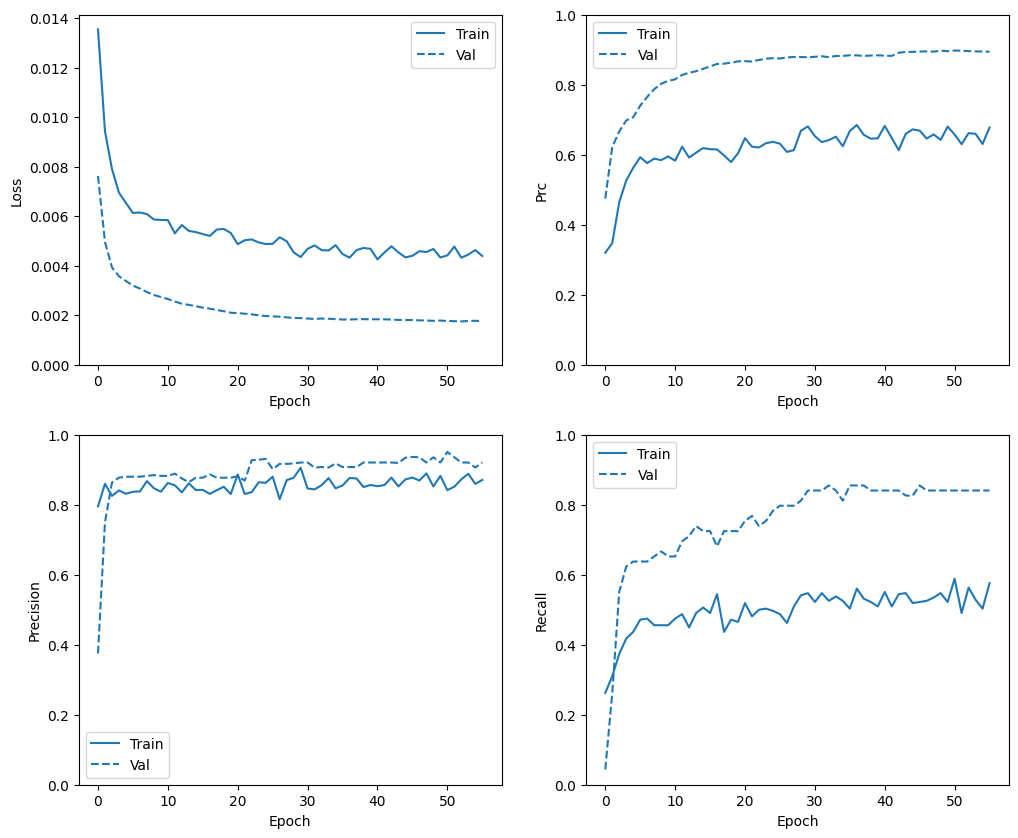

In [26]:
plot_metrics(baseline_history)

注：验证曲线通常比训练曲线表现更好。这主要是由于在评估模型时，随机失活层处于非活动状态。

### 评估指标

您可以使用[混淆矩阵](https://developers.google.com/machine-learning/glossary/#confusion_matrix)来汇总实际标签与预测标签，其中 X 轴是预测标签，Y 轴是实际标签：

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 7s

34/90 [==========>...................] - ETA: 0s

68/90 [=====================>........] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 1s

28/28 [==============================] - 0s 2ms/step


In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

在测试数据集上评估您的模型并显示您在上面创建的指标的结果：

loss :  0.0030497945845127106
tp :  84.0
fp :  12.0
tn :  56843.0
fn :  23.0
accuracy :  0.9993855357170105
precision :  0.875
recall :  0.7850467562675476
auc :  0.9389954805374146
prc :  0.8279591798782349

Legitimate Transactions Detected (True Negatives):  56843
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  107


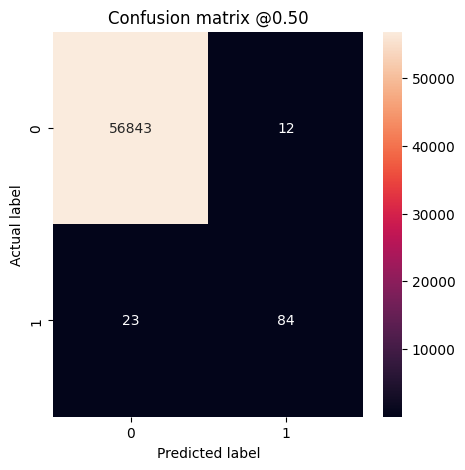

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

如果模型完美地预测了所有内容，则这是一个[对角矩阵](https://en.wikipedia.org/wiki/Diagonal_matrix)，其中偏离主对角线的值（表示不正确的预测）将为零。在这种情况下，矩阵会显示您的假正例相对较少，这意味着被错误标记的合法交易相对较少。但是，您可能希望得到更少的假负例，即使这会增加假正例的数量。这种权衡可能更加可取，因为假负例允许进行欺诈交易，而假正例可能导致向客户发送电子邮件，要求他们验证自己的信用卡活动。

### 绘制 ROC

现在绘制 [ROC](https://developers.google.com/machine-learning/glossary#ROC)。此绘图非常有用，因为它一目了然地显示了模型只需通过调整输出阈值就能达到的性能范围。

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

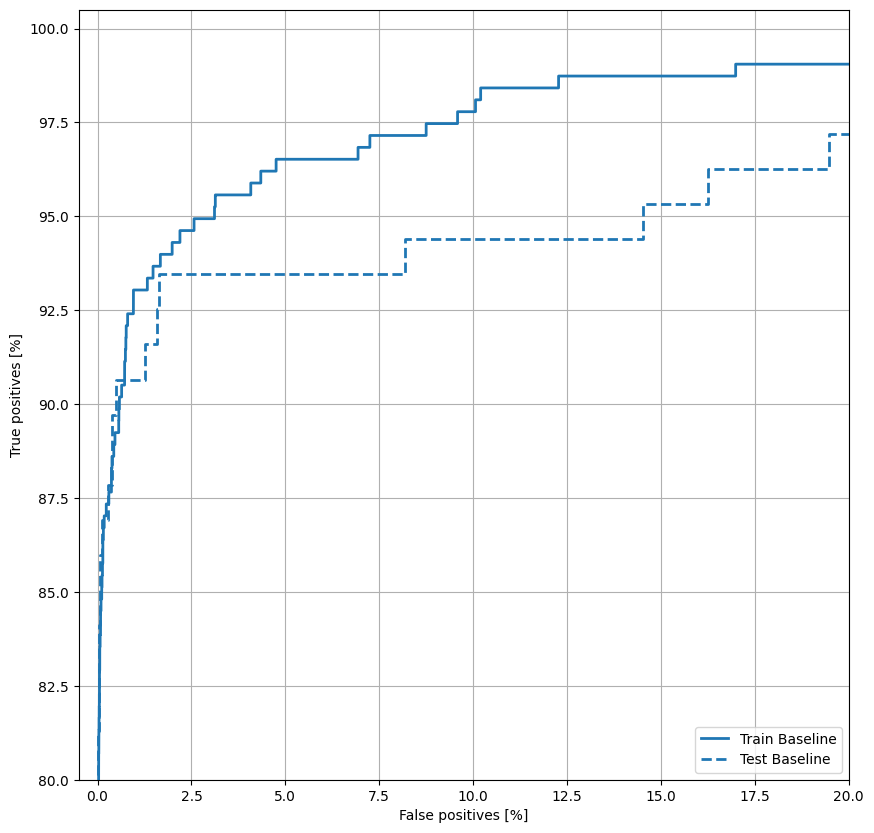

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### 绘制 AUPRC

现在绘制 [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC)。内插精确率-召回率曲线的下方面积，通过为分类阈值的不同值绘制（召回率、精确率）点获得。根据计算方式，PR AUC 可能相当于模型的平均精确率。


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

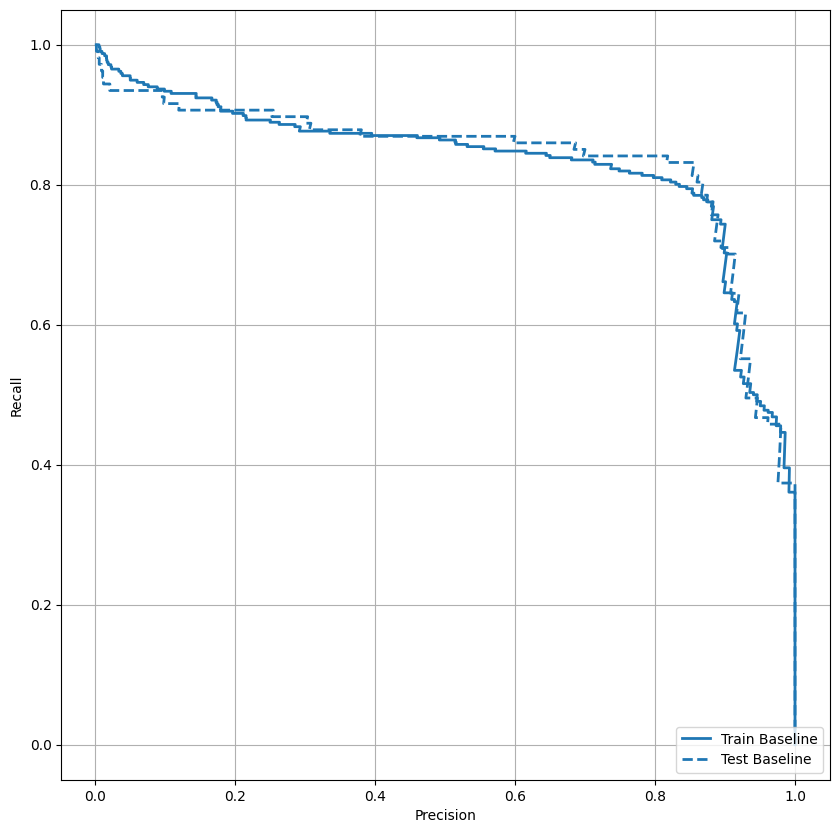

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

看起来精确率相对较高，但是召回率和 ROC 曲线下方面积 (AUC) 可能并没有您期望的那么高。当试图同时最大限度地提高精确率和召回率时，分类器通常会面临挑战，在处理不平衡数据集时尤其如此。请务必根据您所关心的问题来考虑不同类型错误的代价。在此示例中，假负例（漏掉欺诈交易）可能造成财务损失，而假正例（将交易错误地标记为欺诈）则可能降低用户满意度。

## 类权重

### 计算类权重

我们的目标是识别欺诈交易，但您没有很多可以使用的此类正样本，因此您希望分类器提高可用的少数样本的权重。为此，您可以使用参数将 Keras 权重传递给每个类。这些权重将使模型“更加关注”来自代表不足的类的样本。

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### 使用类权重训练模型

现在，尝试使用类权重对模型进行重新训练和评估，以了解其对预测的影响。

注：使用 `class_weights` 会改变损失范围。这可能会影响训练的稳定性，具体取决于优化器。步长取决于梯度大小的优化器（如 `optimizers.SGD`）可能会失效。此处使用的优化器（`optimizers.Adam`）不受缩放更改的影响。还要注意，由于加权，两个模型之间的总损失不具可比性。

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 2:15 - loss: 2.7137 - tp: 84.0000 - fp: 12.0000 - tn: 58888.0000 - fn: 26.0000 - accuracy: 0.9994 - precision: 0.8750 - recall: 0.7636 - auc: 0.9270 - prc: 0.8045

13/90 [===>..........................] - ETA: 0s - loss: 5.3623 - tp: 86.0000 - fp: 12.0000 - tn: 83414.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.8776 - recall: 0.5375 - auc: 0.8172 - prc: 0.5830  

25/90 [=======>......................] - ETA: 0s - loss: 4.7718 - tp: 90.0000 - fp: 12.0000 - tn: 107944.0000 - fn: 116.0000 - accuracy: 0.9988 - precision: 0.8824 - recall: 0.4369 - auc: 0.7838 - prc: 0.5056

37/90 [===========>..................] - ETA: 0s - loss: 4.1223 - tp: 93.0000 - fp: 13.0000 - tn: 132484.0000 - fn: 148.0000 - accuracy: 0.9988 - precision: 0.8774 - recall: 0.3859 - auc: 0.7641 - prc: 0.4585

50/90 [===============>..............] - ETA: 0s - loss: 3.8363 - tp: 98.0000 - fp: 18.0000 - tn: 159060.0000 - fn: 186.0000 - accuracy: 0.9987 - precision: 0.8448 - recall: 0.3451 - auc: 0.7578 - prc: 0.3992

62/90 [===================>..........] - ETA: 0s - loss: 3.7153 - tp: 107.0000 - fp: 19.0000 - tn: 183593.0000 - fn: 219.0000 - accuracy: 0.9987 - precision: 0.8492 - recall: 0.3282 - auc: 0.7462 - prc: 0.3745

75/90 [========================>.....] - ETA: 0s - loss: 3.5262 - tp: 115.0000 - fp: 24.0000 - tn: 210172.0000 - fn: 251.0000 - accuracy: 0.9987 - precision: 0.8273 - recall: 0.3142 - auc: 0.7370 - prc: 0.3462

88/90 [============================>.] - ETA: 0s - loss: 3.4695 - tp: 126.0000 - fp: 27.0000 - tn: 236739.0000 - fn: 294.0000 - accuracy: 0.9986 - precision: 0.8235 - recall: 0.3000 - auc: 0.7321 - prc: 0.3264

90/90 [==============================] - 3s 12ms/step - loss: 3.4540 - tp: 127.0000 - fp: 28.0000 - tn: 238787.0000 - fn: 296.0000 - accuracy: 0.9986 - precision: 0.8194 - recall: 0.3002 - auc: 0.7327 - prc: 0.3224 - val_loss: 0.0070 - val_tp: 9.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 60.0000 - val_accuracy: 0.9986 - val_precision: 0.6000 - val_recall: 0.1304 - val_auc: 0.8538 - val_prc: 0.4746


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 1.5991 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7378 - prc: 0.5010

13/90 [===>..........................] - ETA: 0s - loss: 2.7107 - tp: 18.0000 - fp: 3.0000 - tn: 26569.0000 - fn: 34.0000 - accuracy: 0.9986 - precision: 0.8571 - recall: 0.3462 - auc: 0.7342 - prc: 0.3242             

25/90 [=======>......................] - ETA: 0s - loss: 2.4747 - tp: 32.0000 - fp: 8.0000 - tn: 51099.0000 - fn: 61.0000 - accuracy: 0.9987 - precision: 0.8000 - recall: 0.3441 - auc: 0.7248 - prc: 0.2976

37/90 [===========>..................] - ETA: 0s - loss: 2.4512 - tp: 52.0000 - fp: 11.0000 - tn: 75616.0000 - fn: 97.0000 - accuracy: 0.9986 - precision: 0.8254 - recall: 0.3490 - auc: 0.7516 - prc: 0.3397

49/90 [===============>..............] - ETA: 0s - loss: 2.1021 - tp: 58.0000 - fp: 18.0000 - tn: 100162.0000 - fn: 114.0000 - accuracy: 0.9987 - precision: 0.7632 - recall: 0.3372 - auc: 0.7557 - prc: 0.3273

61/90 [===================>..........] - ETA: 0s - loss: 2.0668 - tp: 69.0000 - fp: 28.0000 - tn: 124683.0000 - fn: 148.0000 - accuracy: 0.9986 - precision: 0.7113 - recall: 0.3180 - auc: 0.7685 - prc: 0.3197

73/90 [=======================>......] - ETA: 0s - loss: 1.9772 - tp: 86.0000 - fp: 35.0000 - tn: 149208.0000 - fn: 175.0000 - accuracy: 0.9986 - precision: 0.7107 - recall: 0.3295 - auc: 0.7871 - prc: 0.3406

85/90 [===========================>..] - ETA: 0s - loss: 1.8861 - tp: 97.0000 - fp: 43.0000 - tn: 173742.0000 - fn: 198.0000 - accuracy: 0.9986 - precision: 0.6929 - recall: 0.3288 - auc: 0.7923 - prc: 0.3390

90/90 [==============================] - 1s 6ms/step - loss: 1.8967 - tp: 106.0000 - fp: 48.0000 - tn: 181912.0000 - fn: 210.0000 - accuracy: 0.9986 - precision: 0.6883 - recall: 0.3354 - auc: 0.7954 - prc: 0.3507 - val_loss: 0.0049 - val_tp: 48.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8889 - val_recall: 0.6957 - val_auc: 0.9396 - val_prc: 0.6825


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.5117 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9934 - prc: 0.5261

14/90 [===>..........................] - ETA: 0s - loss: 0.9296 - tp: 25.0000 - fp: 17.0000 - tn: 28611.0000 - fn: 19.0000 - accuracy: 0.9987 - precision: 0.5952 - recall: 0.5682 - auc: 0.8710 - prc: 0.5079

27/90 [========>.....................] - ETA: 0s - loss: 1.1121 - tp: 53.0000 - fp: 33.0000 - tn: 55166.0000 - fn: 44.0000 - accuracy: 0.9986 - precision: 0.6163 - recall: 0.5464 - auc: 0.8811 - prc: 0.5141

39/90 [============>.................] - ETA: 0s - loss: 1.1124 - tp: 83.0000 - fp: 51.0000 - tn: 79675.0000 - fn: 63.0000 - accuracy: 0.9986 - precision: 0.6194 - recall: 0.5685 - auc: 0.8889 - prc: 0.5438

51/90 [================>.............] - ETA: 0s - loss: 1.1711 - tp: 97.0000 - fp: 64.0000 - tn: 104199.0000 - fn: 88.0000 - accuracy: 0.9985 - precision: 0.6025 - recall: 0.5243 - auc: 0.8779 - prc: 0.4960

63/90 [====================>.........] - ETA: 0s - loss: 1.1909 - tp: 122.0000 - fp: 78.0000 - tn: 128714.0000 - fn: 110.0000 - accuracy: 0.9985 - precision: 0.6100 - recall: 0.5259 - auc: 0.8793 - prc: 0.4969

75/90 [========================>.....] - ETA: 0s - loss: 1.2125 - tp: 143.0000 - fp: 104.0000 - tn: 153224.0000 - fn: 129.0000 - accuracy: 0.9985 - precision: 0.5789 - recall: 0.5257 - auc: 0.8709 - prc: 0.4865

87/90 [============================>.] - ETA: 0s - loss: 1.1980 - tp: 162.0000 - fp: 128.0000 - tn: 177739.0000 - fn: 147.0000 - accuracy: 0.9985 - precision: 0.5586 - recall: 0.5243 - auc: 0.8653 - prc: 0.4703

90/90 [==============================] - 1s 6ms/step - loss: 1.2148 - tp: 165.0000 - fp: 131.0000 - tn: 181829.0000 - fn: 151.0000 - accuracy: 0.9985 - precision: 0.5574 - recall: 0.5222 - auc: 0.8611 - prc: 0.4673 - val_loss: 0.0056 - val_tp: 53.0000 - val_fp: 11.0000 - val_tn: 45489.0000 - val_fn: 16.0000 - val_accuracy: 0.9994 - val_precision: 0.8281 - val_recall: 0.7681 - val_auc: 0.9592 - val_prc: 0.7340


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 1.7880 - tp: 4.0000 - fp: 3.0000 - tn: 2039.0000 - fn: 2.0000 - accuracy: 0.9976 - precision: 0.5714 - recall: 0.6667 - auc: 0.8103 - prc: 0.6684

13/90 [===>..........................] - ETA: 0s - loss: 0.6351 - tp: 23.0000 - fp: 35.0000 - tn: 26550.0000 - fn: 16.0000 - accuracy: 0.9981 - precision: 0.3966 - recall: 0.5897 - auc: 0.9207 - prc: 0.4770

25/90 [=======>......................] - ETA: 0s - loss: 1.0462 - tp: 50.0000 - fp: 77.0000 - tn: 51033.0000 - fn: 40.0000 - accuracy: 0.9977 - precision: 0.3937 - recall: 0.5556 - auc: 0.8678 - prc: 0.5026

37/90 [===========>..................] - ETA: 0s - loss: 1.0181 - tp: 70.0000 - fp: 129.0000 - tn: 75519.0000 - fn: 58.0000 - accuracy: 0.9975 - precision: 0.3518 - recall: 0.5469 - auc: 0.8731 - prc: 0.4670

49/90 [===============>..............] - ETA: 0s - loss: 0.9686 - tp: 94.0000 - fp: 167.0000 - tn: 100019.0000 - fn: 72.0000 - accuracy: 0.9976 - precision: 0.3602 - recall: 0.5663 - auc: 0.8702 - prc: 0.4797

61/90 [===================>..........] - ETA: 0s - loss: 0.9694 - tp: 119.0000 - fp: 218.0000 - tn: 124502.0000 - fn: 89.0000 - accuracy: 0.9975 - precision: 0.3531 - recall: 0.5721 - auc: 0.8752 - prc: 0.4896

73/90 [=======================>......] - ETA: 0s - loss: 0.9561 - tp: 147.0000 - fp: 273.0000 - tn: 148980.0000 - fn: 104.0000 - accuracy: 0.9975 - precision: 0.3500 - recall: 0.5857 - auc: 0.8746 - prc: 0.4771

86/90 [===========================>..] - ETA: 0s - loss: 1.0020 - tp: 176.0000 - fp: 337.0000 - tn: 175486.0000 - fn: 129.0000 - accuracy: 0.9974 - precision: 0.3431 - recall: 0.5770 - auc: 0.8700 - prc: 0.4737

90/90 [==============================] - 1s 6ms/step - loss: 0.9954 - tp: 184.0000 - fp: 354.0000 - tn: 181606.0000 - fn: 132.0000 - accuracy: 0.9973 - precision: 0.3420 - recall: 0.5823 - auc: 0.8707 - prc: 0.4738 - val_loss: 0.0071 - val_tp: 58.0000 - val_fp: 15.0000 - val_tn: 45485.0000 - val_fn: 11.0000 - val_accuracy: 0.9994 - val_precision: 0.7945 - val_recall: 0.8406 - val_auc: 0.9857 - val_prc: 0.7529


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0052 - tp: 3.0000 - fp: 2.0000 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 0.9990 - precision: 0.6000 - recall: 1.0000 - auc: 0.9998 - prc: 0.7500

14/90 [===>..........................] - ETA: 0s - loss: 0.9010 - tp: 27.0000 - fp: 67.0000 - tn: 28559.0000 - fn: 19.0000 - accuracy: 0.9970 - precision: 0.2872 - recall: 0.5870 - auc: 0.8756 - prc: 0.4410

26/90 [=======>......................] - ETA: 0s - loss: 0.7859 - tp: 56.0000 - fp: 133.0000 - tn: 53027.0000 - fn: 32.0000 - accuracy: 0.9969 - precision: 0.2963 - recall: 0.6364 - auc: 0.8958 - prc: 0.4770

38/90 [===========>..................] - ETA: 0s - loss: 0.7561 - tp: 89.0000 - fp: 207.0000 - tn: 77484.0000 - fn: 44.0000 - accuracy: 0.9968 - precision: 0.3007 - recall: 0.6692 - auc: 0.9014 - prc: 0.5053

50/90 [===============>..............] - ETA: 0s - loss: 0.8124 - tp: 114.0000 - fp: 294.0000 - tn: 101930.0000 - fn: 62.0000 - accuracy: 0.9965 - precision: 0.2794 - recall: 0.6477 - auc: 0.8895 - prc: 0.4965

62/90 [===================>..........] - ETA: 0s - loss: 0.8466 - tp: 132.0000 - fp: 393.0000 - tn: 126374.0000 - fn: 77.0000 - accuracy: 0.9963 - precision: 0.2514 - recall: 0.6316 - auc: 0.8742 - prc: 0.4795

75/90 [========================>.....] - ETA: 0s - loss: 0.8089 - tp: 170.0000 - fp: 521.0000 - tn: 152820.0000 - fn: 89.0000 - accuracy: 0.9960 - precision: 0.2460 - recall: 0.6564 - auc: 0.8812 - prc: 0.4928

87/90 [============================>.] - ETA: 0s - loss: 0.8376 - tp: 205.0000 - fp: 634.0000 - tn: 177233.0000 - fn: 104.0000 - accuracy: 0.9959 - precision: 0.2443 - recall: 0.6634 - auc: 0.8824 - prc: 0.4857

90/90 [==============================] - 1s 6ms/step - loss: 0.8191 - tp: 212.0000 - fp: 650.0000 - tn: 181310.0000 - fn: 104.0000 - accuracy: 0.9959 - precision: 0.2459 - recall: 0.6709 - auc: 0.8850 - prc: 0.4946 - val_loss: 0.0097 - val_tp: 59.0000 - val_fp: 29.0000 - val_tn: 45471.0000 - val_fn: 10.0000 - val_accuracy: 0.9991 - val_precision: 0.6705 - val_recall: 0.8551 - val_auc: 0.9918 - val_prc: 0.7607


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0103 - tp: 4.0000 - fp: 12.0000 - tn: 2032.0000 - fn: 0.0000e+00 - accuracy: 0.9941 - precision: 0.2500 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.4378 - tp: 38.0000 - fp: 150.0000 - tn: 28474.0000 - fn: 10.0000 - accuracy: 0.9944 - precision: 0.2021 - recall: 0.7917 - auc: 0.9410 - prc: 0.5805

26/90 [=======>......................] - ETA: 0s - loss: 0.6826 - tp: 71.0000 - fp: 285.0000 - tn: 52865.0000 - fn: 27.0000 - accuracy: 0.9941 - precision: 0.1994 - recall: 0.7245 - auc: 0.9056 - prc: 0.4827

38/90 [===========>..................] - ETA: 0s - loss: 0.6308 - tp: 99.0000 - fp: 415.0000 - tn: 77272.0000 - fn: 38.0000 - accuracy: 0.9942 - precision: 0.1926 - recall: 0.7226 - auc: 0.9118 - prc: 0.4681

51/90 [================>.............] - ETA: 0s - loss: 0.6573 - tp: 129.0000 - fp: 590.0000 - tn: 103679.0000 - fn: 50.0000 - accuracy: 0.9939 - precision: 0.1794 - recall: 0.7207 - auc: 0.9057 - prc: 0.4666

64/90 [====================>.........] - ETA: 0s - loss: 0.7253 - tp: 157.0000 - fp: 767.0000 - tn: 130079.0000 - fn: 69.0000 - accuracy: 0.9936 - precision: 0.1699 - recall: 0.6947 - auc: 0.8923 - prc: 0.4366

77/90 [========================>.....] - ETA: 0s - loss: 0.6994 - tp: 195.0000 - fp: 958.0000 - tn: 156464.0000 - fn: 79.0000 - accuracy: 0.9934 - precision: 0.1691 - recall: 0.7117 - auc: 0.8964 - prc: 0.4364

90/90 [==============================] - ETA: 0s - loss: 0.6886 - tp: 225.0000 - fp: 1145.0000 - tn: 180815.0000 - fn: 91.0000 - accuracy: 0.9932 - precision: 0.1642 - recall: 0.7120 - auc: 0.8986 - prc: 0.4293

90/90 [==============================] - 1s 6ms/step - loss: 0.6886 - tp: 225.0000 - fp: 1145.0000 - tn: 180815.0000 - fn: 91.0000 - accuracy: 0.9932 - precision: 0.1642 - recall: 0.7120 - auc: 0.8986 - prc: 0.4293 - val_loss: 0.0142 - val_tp: 59.0000 - val_fp: 89.0000 - val_tn: 45411.0000 - val_fn: 10.0000 - val_accuracy: 0.9978 - val_precision: 0.3986 - val_recall: 0.8551 - val_auc: 0.9930 - val_prc: 0.7548


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.6103 - tp: 4.0000 - fp: 14.0000 - tn: 2029.0000 - fn: 1.0000 - accuracy: 0.9927 - precision: 0.2222 - recall: 0.8000 - auc: 0.9713 - prc: 0.4602

13/90 [===>..........................] - ETA: 0s - loss: 0.7032 - tp: 33.0000 - fp: 215.0000 - tn: 26363.0000 - fn: 13.0000 - accuracy: 0.9914 - precision: 0.1331 - recall: 0.7174 - auc: 0.9057 - prc: 0.3429

25/90 [=======>......................] - ETA: 0s - loss: 0.5990 - tp: 56.0000 - fp: 437.0000 - tn: 50686.0000 - fn: 21.0000 - accuracy: 0.9911 - precision: 0.1136 - recall: 0.7273 - auc: 0.9027 - prc: 0.3124

37/90 [===========>..................] - ETA: 0s - loss: 0.6570 - tp: 85.0000 - fp: 673.0000 - tn: 74986.0000 - fn: 32.0000 - accuracy: 0.9907 - precision: 0.1121 - recall: 0.7265 - auc: 0.8818 - prc: 0.3485

49/90 [===============>..............] - ETA: 0s - loss: 0.6247 - tp: 129.0000 - fp: 853.0000 - tn: 99329.0000 - fn: 41.0000 - accuracy: 0.9911 - precision: 0.1314 - recall: 0.7588 - auc: 0.9008 - prc: 0.4035

62/90 [===================>..........] - ETA: 0s - loss: 0.5939 - tp: 164.0000 - fp: 1090.0000 - tn: 125670.0000 - fn: 52.0000 - accuracy: 0.9910 - precision: 0.1308 - recall: 0.7593 - auc: 0.9072 - prc: 0.4250

74/90 [=======================>......] - ETA: 0s - loss: 0.5975 - tp: 201.0000 - fp: 1340.0000 - tn: 149949.0000 - fn: 62.0000 - accuracy: 0.9907 - precision: 0.1304 - recall: 0.7643 - auc: 0.9102 - prc: 0.4184

86/90 [===========================>..] - ETA: 0s - loss: 0.6025 - tp: 230.0000 - fp: 1609.0000 - tn: 174216.0000 - fn: 73.0000 - accuracy: 0.9905 - precision: 0.1251 - recall: 0.7591 - auc: 0.9083 - prc: 0.3786

90/90 [==============================] - 1s 6ms/step - loss: 0.6061 - tp: 240.0000 - fp: 1686.0000 - tn: 180274.0000 - fn: 76.0000 - accuracy: 0.9903 - precision: 0.1246 - recall: 0.7595 - auc: 0.9086 - prc: 0.3771 - val_loss: 0.0198 - val_tp: 60.0000 - val_fp: 182.0000 - val_tn: 45318.0000 - val_fn: 9.0000 - val_accuracy: 0.9958 - val_precision: 0.2479 - val_recall: 0.8696 - val_auc: 0.9946 - val_prc: 0.7211


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.4736 - tp: 4.0000 - fp: 29.0000 - tn: 2014.0000 - fn: 1.0000 - accuracy: 0.9854 - precision: 0.1212 - recall: 0.8000 - auc: 0.9851 - prc: 0.5392

13/90 [===>..........................] - ETA: 0s - loss: 0.5087 - tp: 31.0000 - fp: 302.0000 - tn: 26281.0000 - fn: 10.0000 - accuracy: 0.9883 - precision: 0.0931 - recall: 0.7561 - auc: 0.9078 - prc: 0.2812

25/90 [=======>......................] - ETA: 0s - loss: 0.5006 - tp: 70.0000 - fp: 575.0000 - tn: 50536.0000 - fn: 19.0000 - accuracy: 0.9884 - precision: 0.1085 - recall: 0.7865 - auc: 0.9250 - prc: 0.3489

37/90 [===========>..................] - ETA: 0s - loss: 0.5707 - tp: 94.0000 - fp: 883.0000 - tn: 74765.0000 - fn: 34.0000 - accuracy: 0.9879 - precision: 0.0962 - recall: 0.7344 - auc: 0.9216 - prc: 0.3200

49/90 [===============>..............] - ETA: 0s - loss: 0.6151 - tp: 117.0000 - fp: 1192.0000 - tn: 98995.0000 - fn: 48.0000 - accuracy: 0.9876 - precision: 0.0894 - recall: 0.7091 - auc: 0.9113 - prc: 0.2967

61/90 [===================>..........] - ETA: 0s - loss: 0.6056 - tp: 146.0000 - fp: 1499.0000 - tn: 123224.0000 - fn: 59.0000 - accuracy: 0.9875 - precision: 0.0888 - recall: 0.7122 - auc: 0.9100 - prc: 0.3035

73/90 [=======================>......] - ETA: 0s - loss: 0.5961 - tp: 182.0000 - fp: 1831.0000 - tn: 147423.0000 - fn: 68.0000 - accuracy: 0.9873 - precision: 0.0904 - recall: 0.7280 - auc: 0.9108 - prc: 0.3199

85/90 [===========================>..] - ETA: 0s - loss: 0.6089 - tp: 218.0000 - fp: 2163.0000 - tn: 171620.0000 - fn: 79.0000 - accuracy: 0.9871 - precision: 0.0916 - recall: 0.7340 - auc: 0.9067 - prc: 0.3197

90/90 [==============================] - 1s 6ms/step - loss: 0.6127 - tp: 233.0000 - fp: 2287.0000 - tn: 179673.0000 - fn: 83.0000 - accuracy: 0.9870 - precision: 0.0925 - recall: 0.7373 - auc: 0.9071 - prc: 0.3235 - val_loss: 0.0276 - val_tp: 64.0000 - val_fp: 340.0000 - val_tn: 45160.0000 - val_fn: 5.0000 - val_accuracy: 0.9924 - val_precision: 0.1584 - val_recall: 0.9275 - val_auc: 0.9953 - val_prc: 0.6965


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 1.5614 - tp: 2.0000 - fp: 31.0000 - tn: 2013.0000 - fn: 2.0000 - accuracy: 0.9839 - precision: 0.0606 - recall: 0.5000 - auc: 0.7331 - prc: 0.1682

13/90 [===>..........................] - ETA: 0s - loss: 0.7870 - tp: 42.0000 - fp: 395.0000 - tn: 26169.0000 - fn: 18.0000 - accuracy: 0.9845 - precision: 0.0961 - recall: 0.7000 - auc: 0.9109 - prc: 0.3395

26/90 [=======>......................] - ETA: 0s - loss: 0.7410 - tp: 77.0000 - fp: 839.0000 - tn: 52299.0000 - fn: 33.0000 - accuracy: 0.9836 - precision: 0.0841 - recall: 0.7000 - auc: 0.9096 - prc: 0.3218

38/90 [===========>..................] - ETA: 0s - loss: 0.6296 - tp: 106.0000 - fp: 1221.0000 - tn: 76454.0000 - fn: 43.0000 - accuracy: 0.9838 - precision: 0.0799 - recall: 0.7114 - auc: 0.9187 - prc: 0.3113

50/90 [===============>..............] - ETA: 0s - loss: 0.5557 - tp: 142.0000 - fp: 1619.0000 - tn: 100590.0000 - fn: 49.0000 - accuracy: 0.9837 - precision: 0.0806 - recall: 0.7435 - auc: 0.9256 - prc: 0.3232

62/90 [===================>..........] - ETA: 0s - loss: 0.5025 - tp: 178.0000 - fp: 2093.0000 - tn: 124649.0000 - fn: 56.0000 - accuracy: 0.9831 - precision: 0.0784 - recall: 0.7607 - auc: 0.9343 - prc: 0.3029

74/90 [=======================>......] - ETA: 0s - loss: 0.5020 - tp: 213.0000 - fp: 2525.0000 - tn: 148747.0000 - fn: 67.0000 - accuracy: 0.9829 - precision: 0.0778 - recall: 0.7607 - auc: 0.9333 - prc: 0.2921

86/90 [===========================>..] - ETA: 0s - loss: 0.4678 - tp: 238.0000 - fp: 3004.0000 - tn: 172815.0000 - fn: 71.0000 - accuracy: 0.9825 - precision: 0.0734 - recall: 0.7702 - auc: 0.9344 - prc: 0.2783

90/90 [==============================] - 1s 6ms/step - loss: 0.4657 - tp: 244.0000 - fp: 3136.0000 - tn: 178824.0000 - fn: 72.0000 - accuracy: 0.9824 - precision: 0.0722 - recall: 0.7722 - auc: 0.9334 - prc: 0.2770 - val_loss: 0.0385 - val_tp: 64.0000 - val_fp: 514.0000 - val_tn: 44986.0000 - val_fn: 5.0000 - val_accuracy: 0.9886 - val_precision: 0.1107 - val_recall: 0.9275 - val_auc: 0.9953 - val_prc: 0.6873


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.2612 - tp: 8.0000 - fp: 33.0000 - tn: 2006.0000 - fn: 1.0000 - accuracy: 0.9834 - precision: 0.1951 - recall: 0.8889 - auc: 0.9950 - prc: 0.6468

13/90 [===>..........................] - ETA: 0s - loss: 0.4458 - tp: 42.0000 - fp: 541.0000 - tn: 26031.0000 - fn: 10.0000 - accuracy: 0.9793 - precision: 0.0720 - recall: 0.8077 - auc: 0.9461 - prc: 0.2932

25/90 [=======>......................] - ETA: 0s - loss: 0.6278 - tp: 72.0000 - fp: 1058.0000 - tn: 50045.0000 - fn: 25.0000 - accuracy: 0.9788 - precision: 0.0637 - recall: 0.7423 - auc: 0.9113 - prc: 0.2388

38/90 [===========>..................] - ETA: 0s - loss: 0.5405 - tp: 107.0000 - fp: 1618.0000 - tn: 76068.0000 - fn: 31.0000 - accuracy: 0.9788 - precision: 0.0620 - recall: 0.7754 - auc: 0.9156 - prc: 0.2322

51/90 [================>.............] - ETA: 0s - loss: 0.5122 - tp: 143.0000 - fp: 2193.0000 - tn: 102071.0000 - fn: 41.0000 - accuracy: 0.9786 - precision: 0.0612 - recall: 0.7772 - auc: 0.9217 - prc: 0.2272

64/90 [====================>.........] - ETA: 0s - loss: 0.5250 - tp: 180.0000 - fp: 2802.0000 - tn: 128035.0000 - fn: 55.0000 - accuracy: 0.9782 - precision: 0.0604 - recall: 0.7660 - auc: 0.9237 - prc: 0.2161

76/90 [========================>.....] - ETA: 0s - loss: 0.4742 - tp: 211.0000 - fp: 3398.0000 - tn: 151981.0000 - fn: 58.0000 - accuracy: 0.9778 - precision: 0.0585 - recall: 0.7844 - auc: 0.9291 - prc: 0.2095

89/90 [============================>.] - ETA: 0s - loss: 0.4505 - tp: 254.0000 - fp: 4029.0000 - tn: 177927.0000 - fn: 62.0000 - accuracy: 0.9776 - precision: 0.0593 - recall: 0.8038 - auc: 0.9320 - prc: 0.2187

90/90 [==============================] - 1s 6ms/step - loss: 0.4505 - tp: 254.0000 - fp: 4030.0000 - tn: 177930.0000 - fn: 62.0000 - accuracy: 0.9776 - precision: 0.0593 - recall: 0.8038 - auc: 0.9320 - prc: 0.2187 - val_loss: 0.0484 - val_tp: 64.0000 - val_fp: 642.0000 - val_tn: 44858.0000 - val_fn: 5.0000 - val_accuracy: 0.9858 - val_precision: 0.0907 - val_recall: 0.9275 - val_auc: 0.9953 - val_prc: 0.6514


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.1446 - tp: 4.0000 - fp: 47.0000 - tn: 1996.0000 - fn: 1.0000 - accuracy: 0.9766 - precision: 0.0784 - recall: 0.8000 - auc: 0.9940 - prc: 0.3084

14/90 [===>..........................] - ETA: 0s - loss: 0.3950 - tp: 43.0000 - fp: 697.0000 - tn: 27923.0000 - fn: 9.0000 - accuracy: 0.9754 - precision: 0.0581 - recall: 0.8269 - auc: 0.9292 - prc: 0.2378

26/90 [=======>......................] - ETA: 0s - loss: 0.5501 - tp: 81.0000 - fp: 1281.0000 - tn: 51867.0000 - fn: 19.0000 - accuracy: 0.9756 - precision: 0.0595 - recall: 0.8100 - auc: 0.8969 - prc: 0.2527

39/90 [============>.................] - ETA: 0s - loss: 0.5271 - tp: 116.0000 - fp: 1911.0000 - tn: 77815.0000 - fn: 30.0000 - accuracy: 0.9757 - precision: 0.0572 - recall: 0.7945 - auc: 0.9070 - prc: 0.2301

51/90 [================>.............] - ETA: 0s - loss: 0.4725 - tp: 144.0000 - fp: 2544.0000 - tn: 101725.0000 - fn: 35.0000 - accuracy: 0.9753 - precision: 0.0536 - recall: 0.8045 - auc: 0.9144 - prc: 0.2164

64/90 [====================>.........] - ETA: 0s - loss: 0.4491 - tp: 181.0000 - fp: 3238.0000 - tn: 127608.0000 - fn: 45.0000 - accuracy: 0.9750 - precision: 0.0529 - recall: 0.8009 - auc: 0.9217 - prc: 0.2123

77/90 [========================>.....] - ETA: 0s - loss: 0.4514 - tp: 219.0000 - fp: 3947.0000 - tn: 153475.0000 - fn: 55.0000 - accuracy: 0.9746 - precision: 0.0526 - recall: 0.7993 - auc: 0.9226 - prc: 0.2169

90/90 [==============================] - ETA: 0s - loss: 0.4498 - tp: 252.0000 - fp: 4605.0000 - tn: 177355.0000 - fn: 64.0000 - accuracy: 0.9744 - precision: 0.0519 - recall: 0.7975 - auc: 0.9242 - prc: 0.2122

90/90 [==============================] - 1s 6ms/step - loss: 0.4498 - tp: 252.0000 - fp: 4605.0000 - tn: 177355.0000 - fn: 64.0000 - accuracy: 0.9744 - precision: 0.0519 - recall: 0.7975 - auc: 0.9242 - prc: 0.2122 - val_loss: 0.0548 - val_tp: 64.0000 - val_fp: 694.0000 - val_tn: 44806.0000 - val_fn: 5.0000 - val_accuracy: 0.9847 - val_precision: 0.0844 - val_recall: 0.9275 - val_auc: 0.9953 - val_prc: 0.6065


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0521 - tp: 1.0000 - fp: 51.0000 - tn: 1996.0000 - fn: 0.0000e+00 - accuracy: 0.9751 - precision: 0.0192 - recall: 1.0000 - auc: 0.9971 - prc: 0.0722

13/90 [===>..........................] - ETA: 0s - loss: 0.3071 - tp: 37.0000 - fp: 668.0000 - tn: 25914.0000 - fn: 5.0000 - accuracy: 0.9747 - precision: 0.0525 - recall: 0.8810 - auc: 0.9388 - prc: 0.2606 

25/90 [=======>......................] - ETA: 0s - loss: 0.4531 - tp: 75.0000 - fp: 1336.0000 - tn: 49771.0000 - fn: 18.0000 - accuracy: 0.9736 - precision: 0.0532 - recall: 0.8065 - auc: 0.9299 - prc: 0.2275

37/90 [===========>..................] - ETA: 0s - loss: 0.4435 - tp: 104.0000 - fp: 2037.0000 - tn: 73610.0000 - fn: 25.0000 - accuracy: 0.9728 - precision: 0.0486 - recall: 0.8062 - auc: 0.9224 - prc: 0.2135

49/90 [===============>..............] - ETA: 0s - loss: 0.4117 - tp: 142.0000 - fp: 2743.0000 - tn: 97436.0000 - fn: 31.0000 - accuracy: 0.9724 - precision: 0.0492 - recall: 0.8208 - auc: 0.9285 - prc: 0.2054

61/90 [===================>..........] - ETA: 0s - loss: 0.4089 - tp: 174.0000 - fp: 3490.0000 - tn: 121227.0000 - fn: 37.0000 - accuracy: 0.9718 - precision: 0.0475 - recall: 0.8246 - auc: 0.9248 - prc: 0.1937

73/90 [=======================>......] - ETA: 0s - loss: 0.3956 - tp: 204.0000 - fp: 4227.0000 - tn: 145029.0000 - fn: 44.0000 - accuracy: 0.9714 - precision: 0.0460 - recall: 0.8226 - auc: 0.9273 - prc: 0.1856

85/90 [===========================>..] - ETA: 0s - loss: 0.4070 - tp: 244.0000 - fp: 4934.0000 - tn: 168848.0000 - fn: 54.0000 - accuracy: 0.9713 - precision: 0.0471 - recall: 0.8188 - auc: 0.9263 - prc: 0.1927

90/90 [==============================] - 1s 6ms/step - loss: 0.4053 - tp: 260.0000 - fp: 5182.0000 - tn: 176778.0000 - fn: 56.0000 - accuracy: 0.9713 - precision: 0.0478 - recall: 0.8228 - auc: 0.9284 - prc: 0.1952 - val_loss: 0.0608 - val_tp: 64.0000 - val_fp: 767.0000 - val_tn: 44733.0000 - val_fn: 5.0000 - val_accuracy: 0.9831 - val_precision: 0.0770 - val_recall: 0.9275 - val_auc: 0.9953 - val_prc: 0.6025


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.9509 - tp: 3.0000 - fp: 47.0000 - tn: 1997.0000 - fn: 1.0000 - accuracy: 0.9766 - precision: 0.0600 - recall: 0.7500 - auc: 0.7945 - prc: 0.1143

13/90 [===>..........................] - ETA: 0s - loss: 0.5321 - tp: 39.0000 - fp: 780.0000 - tn: 25795.0000 - fn: 10.0000 - accuracy: 0.9703 - precision: 0.0476 - recall: 0.7959 - auc: 0.9173 - prc: 0.1550

25/90 [=======>......................] - ETA: 0s - loss: 0.4396 - tp: 76.0000 - fp: 1571.0000 - tn: 49534.0000 - fn: 19.0000 - accuracy: 0.9689 - precision: 0.0461 - recall: 0.8000 - auc: 0.9402 - prc: 0.1880

38/90 [===========>..................] - ETA: 0s - loss: 0.3981 - tp: 120.0000 - fp: 2421.0000 - tn: 75255.0000 - fn: 28.0000 - accuracy: 0.9685 - precision: 0.0472 - recall: 0.8108 - auc: 0.9485 - prc: 0.2023

50/90 [===============>..............] - ETA: 0s - loss: 0.3315 - tp: 157.0000 - fp: 3234.0000 - tn: 98978.0000 - fn: 31.0000 - accuracy: 0.9681 - precision: 0.0463 - recall: 0.8351 - auc: 0.9576 - prc: 0.2089

62/90 [===================>..........] - ETA: 0s - loss: 0.3056 - tp: 197.0000 - fp: 4081.0000 - tn: 122662.0000 - fn: 36.0000 - accuracy: 0.9676 - precision: 0.0460 - recall: 0.8455 - auc: 0.9619 - prc: 0.2130

75/90 [========================>.....] - ETA: 0s - loss: 0.2762 - tp: 223.0000 - fp: 4972.0000 - tn: 148367.0000 - fn: 38.0000 - accuracy: 0.9674 - precision: 0.0429 - recall: 0.8544 - auc: 0.9639 - prc: 0.1979

87/90 [============================>.] - ETA: 0s - loss: 0.3241 - tp: 259.0000 - fp: 5823.0000 - tn: 172044.0000 - fn: 50.0000 - accuracy: 0.9670 - precision: 0.0426 - recall: 0.8382 - auc: 0.9550 - prc: 0.1930

90/90 [==============================] - 1s 6ms/step - loss: 0.3426 - tp: 263.0000 - fp: 5964.0000 - tn: 175996.0000 - fn: 53.0000 - accuracy: 0.9670 - precision: 0.0422 - recall: 0.8323 - auc: 0.9503 - prc: 0.1911 - val_loss: 0.0683 - val_tp: 64.0000 - val_fp: 849.0000 - val_tn: 44651.0000 - val_fn: 5.0000 - val_accuracy: 0.9813 - val_precision: 0.0701 - val_recall: 0.9275 - val_auc: 0.9950 - val_prc: 0.5961


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 1.9254 - tp: 4.0000 - fp: 81.0000 - tn: 1961.0000 - fn: 2.0000 - accuracy: 0.9595 - precision: 0.0471 - recall: 0.6667 - auc: 0.7235 - prc: 0.1445

13/90 [===>..........................] - ETA: 0s - loss: 0.3116 - tp: 42.0000 - fp: 913.0000 - tn: 25664.0000 - fn: 5.0000 - accuracy: 0.9655 - precision: 0.0440 - recall: 0.8936 - auc: 0.9485 - prc: 0.2244

25/90 [=======>......................] - ETA: 0s - loss: 0.3004 - tp: 79.0000 - fp: 1778.0000 - tn: 49334.0000 - fn: 9.0000 - accuracy: 0.9651 - precision: 0.0425 - recall: 0.8977 - auc: 0.9456 - prc: 0.2105

38/90 [===========>..................] - ETA: 0s - loss: 0.3301 - tp: 111.0000 - fp: 2729.0000 - tn: 74966.0000 - fn: 18.0000 - accuracy: 0.9647 - precision: 0.0391 - recall: 0.8605 - auc: 0.9409 - prc: 0.1970

51/90 [================>.............] - ETA: 0s - loss: 0.3755 - tp: 154.0000 - fp: 3713.0000 - tn: 100552.0000 - fn: 29.0000 - accuracy: 0.9642 - precision: 0.0398 - recall: 0.8415 - auc: 0.9352 - prc: 0.1918

64/90 [====================>.........] - ETA: 0s - loss: 0.3472 - tp: 194.0000 - fp: 4595.0000 - tn: 126250.0000 - fn: 33.0000 - accuracy: 0.9647 - precision: 0.0405 - recall: 0.8546 - auc: 0.9417 - prc: 0.1939

76/90 [========================>.....] - ETA: 0s - loss: 0.3493 - tp: 231.0000 - fp: 5425.0000 - tn: 149952.0000 - fn: 40.0000 - accuracy: 0.9649 - precision: 0.0408 - recall: 0.8524 - auc: 0.9411 - prc: 0.1959

88/90 [============================>.] - ETA: 0s - loss: 0.3660 - tp: 266.0000 - fp: 6282.0000 - tn: 173628.0000 - fn: 48.0000 - accuracy: 0.9649 - precision: 0.0406 - recall: 0.8471 - auc: 0.9361 - prc: 0.1909

90/90 [==============================] - 1s 6ms/step - loss: 0.3627 - tp: 268.0000 - fp: 6356.0000 - tn: 175604.0000 - fn: 48.0000 - accuracy: 0.9649 - precision: 0.0405 - recall: 0.8481 - auc: 0.9365 - prc: 0.1903 - val_loss: 0.0714 - val_tp: 64.0000 - val_fp: 880.0000 - val_tn: 44620.0000 - val_fn: 5.0000 - val_accuracy: 0.9806 - val_precision: 0.0678 - val_recall: 0.9275 - val_auc: 0.9951 - val_prc: 0.5914


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0666 - tp: 2.0000 - fp: 89.0000 - tn: 1957.0000 - fn: 0.0000e+00 - accuracy: 0.9565 - precision: 0.0220 - recall: 1.0000 - auc: 0.9988 - prc: 0.2857

13/90 [===>..........................] - ETA: 0s - loss: 0.5102 - tp: 45.0000 - fp: 977.0000 - tn: 25591.0000 - fn: 11.0000 - accuracy: 0.9629 - precision: 0.0440 - recall: 0.8036 - auc: 0.9270 - prc: 0.2043

25/90 [=======>......................] - ETA: 0s - loss: 0.3842 - tp: 88.0000 - fp: 1901.0000 - tn: 49196.0000 - fn: 15.0000 - accuracy: 0.9626 - precision: 0.0442 - recall: 0.8544 - auc: 0.9454 - prc: 0.2117

37/90 [===========>..................] - ETA: 0s - loss: 0.3434 - tp: 113.0000 - fp: 2802.0000 - tn: 72841.0000 - fn: 20.0000 - accuracy: 0.9628 - precision: 0.0388 - recall: 0.8496 - auc: 0.9451 - prc: 0.1947

49/90 [===============>..............] - ETA: 0s - loss: 0.3346 - tp: 150.0000 - fp: 3707.0000 - tn: 96471.0000 - fn: 24.0000 - accuracy: 0.9628 - precision: 0.0389 - recall: 0.8621 - auc: 0.9452 - prc: 0.1933

61/90 [===================>..........] - ETA: 0s - loss: 0.3474 - tp: 191.0000 - fp: 4630.0000 - tn: 120074.0000 - fn: 33.0000 - accuracy: 0.9627 - precision: 0.0396 - recall: 0.8527 - auc: 0.9446 - prc: 0.1997

73/90 [=======================>......] - ETA: 0s - loss: 0.3452 - tp: 219.0000 - fp: 5524.0000 - tn: 143723.0000 - fn: 38.0000 - accuracy: 0.9628 - precision: 0.0381 - recall: 0.8521 - auc: 0.9412 - prc: 0.1959

85/90 [===========================>..] - ETA: 0s - loss: 0.3333 - tp: 258.0000 - fp: 6435.0000 - tn: 167343.0000 - fn: 44.0000 - accuracy: 0.9628 - precision: 0.0385 - recall: 0.8543 - auc: 0.9461 - prc: 0.1996

90/90 [==============================] - 1s 6ms/step - loss: 0.3306 - tp: 271.0000 - fp: 6756.0000 - tn: 175204.0000 - fn: 45.0000 - accuracy: 0.9627 - precision: 0.0386 - recall: 0.8576 - auc: 0.9458 - prc: 0.2015 - val_loss: 0.0741 - val_tp: 64.0000 - val_fp: 914.0000 - val_tn: 44586.0000 - val_fn: 5.0000 - val_accuracy: 0.9798 - val_precision: 0.0654 - val_recall: 0.9275 - val_auc: 0.9948 - val_prc: 0.5921


Epoch 16/100


 1/90 [..............................] - ETA: 0s - loss: 0.0651 - tp: 3.0000 - fp: 78.0000 - tn: 1967.0000 - fn: 0.0000e+00 - accuracy: 0.9619 - precision: 0.0370 - recall: 1.0000 - auc: 0.9980 - prc: 0.2727

13/90 [===>..........................] - ETA: 0s - loss: 0.1889 - tp: 41.0000 - fp: 1015.0000 - tn: 25565.0000 - fn: 3.0000 - accuracy: 0.9618 - precision: 0.0388 - recall: 0.9318 - auc: 0.9700 - prc: 0.2197

25/90 [=======>......................] - ETA: 0s - loss: 0.2483 - tp: 75.0000 - fp: 1885.0000 - tn: 49232.0000 - fn: 8.0000 - accuracy: 0.9630 - precision: 0.0383 - recall: 0.9036 - auc: 0.9548 - prc: 0.2035

38/90 [===========>..................] - ETA: 0s - loss: 0.3091 - tp: 105.0000 - fp: 2876.0000 - tn: 74826.0000 - fn: 17.0000 - accuracy: 0.9628 - precision: 0.0352 - recall: 0.8607 - auc: 0.9438 - prc: 0.1671

51/90 [================>.............] - ETA: 0s - loss: 0.2902 - tp: 151.0000 - fp: 3859.0000 - tn: 100417.0000 - fn: 21.0000 - accuracy: 0.9629 - precision: 0.0377 - recall: 0.8779 - auc: 0.9486 - prc: 0.1821

64/90 [====================>.........] - ETA: 0s - loss: 0.3535 - tp: 192.0000 - fp: 4843.0000 - tn: 126004.0000 - fn: 33.0000 - accuracy: 0.9628 - precision: 0.0381 - recall: 0.8533 - auc: 0.9342 - prc: 0.1768

76/90 [========================>.....] - ETA: 0s - loss: 0.3347 - tp: 227.0000 - fp: 5809.0000 - tn: 149572.0000 - fn: 40.0000 - accuracy: 0.9624 - precision: 0.0376 - recall: 0.8502 - auc: 0.9404 - prc: 0.1746

89/90 [============================>.] - ETA: 0s - loss: 0.3222 - tp: 272.0000 - fp: 6837.0000 - tn: 175119.0000 - fn: 44.0000 - accuracy: 0.9622 - precision: 0.0383 - recall: 0.8608 - auc: 0.9446 - prc: 0.1837

90/90 [==============================] - 1s 6ms/step - loss: 0.3222 - tp: 272.0000 - fp: 6837.0000 - tn: 175123.0000 - fn: 44.0000 - accuracy: 0.9622 - precision: 0.0383 - recall: 0.8608 - auc: 0.9446 - prc: 0.1837 - val_loss: 0.0752 - val_tp: 65.0000 - val_fp: 923.0000 - val_tn: 44577.0000 - val_fn: 4.0000 - val_accuracy: 0.9797 - val_precision: 0.0658 - val_recall: 0.9420 - val_auc: 0.9947 - val_prc: 0.5894


Epoch 17/100


 1/90 [..............................] - ETA: 0s - loss: 0.0693 - tp: 2.0000 - fp: 70.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9658 - precision: 0.0278 - recall: 1.0000 - auc: 0.9988 - prc: 0.2857

14/90 [===>..........................] - ETA: 0s - loss: 0.3282 - tp: 38.0000 - fp: 1070.0000 - tn: 27558.0000 - fn: 6.0000 - accuracy: 0.9625 - precision: 0.0343 - recall: 0.8636 - auc: 0.9278 - prc: 0.1893

27/90 [========>.....................] - ETA: 0s - loss: 0.4098 - tp: 74.0000 - fp: 2166.0000 - tn: 53041.0000 - fn: 15.0000 - accuracy: 0.9606 - precision: 0.0330 - recall: 0.8315 - auc: 0.9103 - prc: 0.1693

39/90 [============>.................] - ETA: 0s - loss: 0.3891 - tp: 111.0000 - fp: 3104.0000 - tn: 76636.0000 - fn: 21.0000 - accuracy: 0.9609 - precision: 0.0345 - recall: 0.8409 - auc: 0.9204 - prc: 0.1717

52/90 [================>.............] - ETA: 0s - loss: 0.3828 - tp: 166.0000 - fp: 4129.0000 - tn: 102171.0000 - fn: 30.0000 - accuracy: 0.9609 - precision: 0.0386 - recall: 0.8469 - auc: 0.9325 - prc: 0.1971

64/90 [====================>.........] - ETA: 0s - loss: 0.3478 - tp: 201.0000 - fp: 5091.0000 - tn: 125745.0000 - fn: 35.0000 - accuracy: 0.9609 - precision: 0.0380 - recall: 0.8517 - auc: 0.9389 - prc: 0.1954

77/90 [========================>.....] - ETA: 0s - loss: 0.3584 - tp: 237.0000 - fp: 6230.0000 - tn: 151185.0000 - fn: 44.0000 - accuracy: 0.9602 - precision: 0.0366 - recall: 0.8434 - auc: 0.9381 - prc: 0.1845

90/90 [==============================] - ETA: 0s - loss: 0.3474 - tp: 267.0000 - fp: 7262.0000 - tn: 174698.0000 - fn: 49.0000 - accuracy: 0.9599 - precision: 0.0355 - recall: 0.8449 - auc: 0.9397 - prc: 0.1785

90/90 [==============================] - 1s 6ms/step - loss: 0.3474 - tp: 267.0000 - fp: 7262.0000 - tn: 174698.0000 - fn: 49.0000 - accuracy: 0.9599 - precision: 0.0355 - recall: 0.8449 - auc: 0.9397 - prc: 0.1785 - val_loss: 0.0808 - val_tp: 65.0000 - val_fp: 979.0000 - val_tn: 44521.0000 - val_fn: 4.0000 - val_accuracy: 0.9784 - val_precision: 0.0623 - val_recall: 0.9420 - val_auc: 0.9947 - val_prc: 0.5926


Epoch 18/100


 1/90 [..............................] - ETA: 0s - loss: 0.3719 - tp: 2.0000 - fp: 77.0000 - tn: 1968.0000 - fn: 1.0000 - accuracy: 0.9619 - precision: 0.0253 - recall: 0.6667 - auc: 0.9567 - prc: 0.0866

13/90 [===>..........................] - ETA: 0s - loss: 0.1377 - tp: 41.0000 - fp: 1145.0000 - tn: 25436.0000 - fn: 2.0000 - accuracy: 0.9569 - precision: 0.0346 - recall: 0.9535 - auc: 0.9894 - prc: 0.1811

26/90 [=======>......................] - ETA: 0s - loss: 0.2345 - tp: 89.0000 - fp: 2133.0000 - tn: 51018.0000 - fn: 8.0000 - accuracy: 0.9598 - precision: 0.0401 - recall: 0.9175 - auc: 0.9640 - prc: 0.2127

39/90 [============>.................] - ETA: 0s - loss: 0.2839 - tp: 120.0000 - fp: 3228.0000 - tn: 76506.0000 - fn: 18.0000 - accuracy: 0.9594 - precision: 0.0358 - recall: 0.8696 - auc: 0.9549 - prc: 0.1726

52/90 [================>.............] - ETA: 0s - loss: 0.3416 - tp: 149.0000 - fp: 4309.0000 - tn: 102009.0000 - fn: 29.0000 - accuracy: 0.9593 - precision: 0.0334 - recall: 0.8371 - auc: 0.9402 - prc: 0.1630

65/90 [====================>.........] - ETA: 0s - loss: 0.3292 - tp: 183.0000 - fp: 5339.0000 - tn: 127564.0000 - fn: 34.0000 - accuracy: 0.9596 - precision: 0.0331 - recall: 0.8433 - auc: 0.9411 - prc: 0.1675

78/90 [=========================>....] - ETA: 0s - loss: 0.3488 - tp: 228.0000 - fp: 6446.0000 - tn: 153027.0000 - fn: 43.0000 - accuracy: 0.9594 - precision: 0.0342 - recall: 0.8413 - auc: 0.9377 - prc: 0.1723

90/90 [==============================] - ETA: 0s - loss: 0.3525 - tp: 267.0000 - fp: 7350.0000 - tn: 174610.0000 - fn: 49.0000 - accuracy: 0.9594 - precision: 0.0351 - recall: 0.8449 - auc: 0.9373 - prc: 0.1762

90/90 [==============================] - 1s 6ms/step - loss: 0.3525 - tp: 267.0000 - fp: 7350.0000 - tn: 174610.0000 - fn: 49.0000 - accuracy: 0.9594 - precision: 0.0351 - recall: 0.8449 - auc: 0.9373 - prc: 0.1762 - val_loss: 0.0806 - val_tp: 65.0000 - val_fp: 977.0000 - val_tn: 44523.0000 - val_fn: 4.0000 - val_accuracy: 0.9785 - val_precision: 0.0624 - val_recall: 0.9420 - val_auc: 0.9947 - val_prc: 0.5927


Epoch 19/100


 1/90 [..............................] - ETA: 0s - loss: 0.0688 - tp: 2.0000 - fp: 85.0000 - tn: 1961.0000 - fn: 0.0000e+00 - accuracy: 0.9585 - precision: 0.0230 - recall: 1.0000 - auc: 0.9980 - prc: 0.2000

13/90 [===>..........................] - ETA: 0s - loss: 0.2954 - tp: 47.0000 - fp: 1053.0000 - tn: 25520.0000 - fn: 4.0000 - accuracy: 0.9603 - precision: 0.0427 - recall: 0.9216 - auc: 0.9452 - prc: 0.2695

25/90 [=======>......................] - ETA: 0s - loss: 0.4214 - tp: 84.0000 - fp: 2031.0000 - tn: 49069.0000 - fn: 16.0000 - accuracy: 0.9600 - precision: 0.0397 - recall: 0.8400 - auc: 0.9234 - prc: 0.2119

37/90 [===========>..................] - ETA: 0s - loss: 0.3137 - tp: 124.0000 - fp: 3006.0000 - tn: 72630.0000 - fn: 16.0000 - accuracy: 0.9601 - precision: 0.0396 - recall: 0.8857 - auc: 0.9439 - prc: 0.2179

50/90 [===============>..............] - ETA: 0s - loss: 0.3933 - tp: 160.0000 - fp: 4100.0000 - tn: 98112.0000 - fn: 28.0000 - accuracy: 0.9597 - precision: 0.0376 - recall: 0.8511 - auc: 0.9269 - prc: 0.1914

63/90 [====================>.........] - ETA: 0s - loss: 0.3899 - tp: 189.0000 - fp: 5177.0000 - tn: 123622.0000 - fn: 36.0000 - accuracy: 0.9596 - precision: 0.0352 - recall: 0.8400 - auc: 0.9260 - prc: 0.1812

75/90 [========================>.....] - ETA: 0s - loss: 0.4104 - tp: 223.0000 - fp: 6195.0000 - tn: 147137.0000 - fn: 45.0000 - accuracy: 0.9594 - precision: 0.0347 - recall: 0.8321 - auc: 0.9205 - prc: 0.1856

87/90 [============================>.] - ETA: 0s - loss: 0.3826 - tp: 255.0000 - fp: 7159.0000 - tn: 170715.0000 - fn: 47.0000 - accuracy: 0.9596 - precision: 0.0344 - recall: 0.8444 - auc: 0.9244 - prc: 0.1776

90/90 [==============================] - 1s 6ms/step - loss: 0.3757 - tp: 269.0000 - fp: 7315.0000 - tn: 174645.0000 - fn: 47.0000 - accuracy: 0.9596 - precision: 0.0355 - recall: 0.8513 - auc: 0.9277 - prc: 0.1830 - val_loss: 0.0779 - val_tp: 65.0000 - val_fp: 949.0000 - val_tn: 44551.0000 - val_fn: 4.0000 - val_accuracy: 0.9791 - val_precision: 0.0641 - val_recall: 0.9420 - val_auc: 0.9948 - val_prc: 0.5936


Epoch 20/100


 1/90 [..............................] - ETA: 0s - loss: 0.0611 - tp: 1.0000 - fp: 81.0000 - tn: 1966.0000 - fn: 0.0000e+00 - accuracy: 0.9604 - precision: 0.0122 - recall: 1.0000 - auc: 0.9983 - prc: 0.1250

13/90 [===>..........................] - ETA: 0s - loss: 0.2046 - tp: 41.0000 - fp: 1075.0000 - tn: 25504.0000 - fn: 4.0000 - accuracy: 0.9595 - precision: 0.0367 - recall: 0.9111 - auc: 0.9675 - prc: 0.2284

25/90 [=======>......................] - ETA: 0s - loss: 0.2874 - tp: 80.0000 - fp: 2062.0000 - tn: 49048.0000 - fn: 10.0000 - accuracy: 0.9595 - precision: 0.0373 - recall: 0.8889 - auc: 0.9484 - prc: 0.1983

38/90 [===========>..................] - ETA: 0s - loss: 0.2952 - tp: 124.0000 - fp: 3115.0000 - tn: 74568.0000 - fn: 17.0000 - accuracy: 0.9598 - precision: 0.0383 - recall: 0.8794 - auc: 0.9521 - prc: 0.1919

50/90 [===============>..............] - ETA: 0s - loss: 0.2724 - tp: 163.0000 - fp: 4033.0000 - tn: 98184.0000 - fn: 20.0000 - accuracy: 0.9604 - precision: 0.0388 - recall: 0.8907 - auc: 0.9554 - prc: 0.2088

62/90 [===================>..........] - ETA: 0s - loss: 0.3483 - tp: 196.0000 - fp: 4959.0000 - tn: 121787.0000 - fn: 34.0000 - accuracy: 0.9607 - precision: 0.0380 - recall: 0.8522 - auc: 0.9418 - prc: 0.1933

75/90 [========================>.....] - ETA: 0s - loss: 0.3161 - tp: 231.0000 - fp: 6016.0000 - tn: 147316.0000 - fn: 37.0000 - accuracy: 0.9606 - precision: 0.0370 - recall: 0.8619 - auc: 0.9473 - prc: 0.1892

87/90 [============================>.] - ETA: 0s - loss: 0.3187 - tp: 268.0000 - fp: 6996.0000 - tn: 170868.0000 - fn: 44.0000 - accuracy: 0.9605 - precision: 0.0369 - recall: 0.8590 - auc: 0.9478 - prc: 0.1887

90/90 [==============================] - 1s 6ms/step - loss: 0.3146 - tp: 271.0000 - fp: 7173.0000 - tn: 174787.0000 - fn: 45.0000 - accuracy: 0.9604 - precision: 0.0364 - recall: 0.8576 - auc: 0.9483 - prc: 0.1861 - val_loss: 0.0790 - val_tp: 65.0000 - val_fp: 944.0000 - val_tn: 44556.0000 - val_fn: 4.0000 - val_accuracy: 0.9792 - val_precision: 0.0644 - val_recall: 0.9420 - val_auc: 0.9948 - val_prc: 0.5963


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 0.0769 - tp: 2.0000 - fp: 89.0000 - tn: 1957.0000 - fn: 0.0000e+00 - accuracy: 0.9565 - precision: 0.0220 - recall: 1.0000 - auc: 0.9976 - prc: 0.1667

14/90 [===>..........................] - ETA: 0s - loss: 0.3100 - tp: 43.0000 - fp: 1139.0000 - tn: 27483.0000 - fn: 7.0000 - accuracy: 0.9600 - precision: 0.0364 - recall: 0.8600 - auc: 0.9529 - prc: 0.2147

26/90 [=======>......................] - ETA: 0s - loss: 0.2894 - tp: 82.0000 - fp: 2117.0000 - tn: 51037.0000 - fn: 12.0000 - accuracy: 0.9600 - precision: 0.0373 - recall: 0.8723 - auc: 0.9558 - prc: 0.2073

38/90 [===========>..................] - ETA: 0s - loss: 0.3405 - tp: 124.0000 - fp: 3074.0000 - tn: 74607.0000 - fn: 19.0000 - accuracy: 0.9603 - precision: 0.0388 - recall: 0.8671 - auc: 0.9422 - prc: 0.1983

51/90 [================>.............] - ETA: 0s - loss: 0.3089 - tp: 164.0000 - fp: 4151.0000 - tn: 100111.0000 - fn: 22.0000 - accuracy: 0.9600 - precision: 0.0380 - recall: 0.8817 - auc: 0.9453 - prc: 0.2024

63/90 [====================>.........] - ETA: 0s - loss: 0.2841 - tp: 190.0000 - fp: 5057.0000 - tn: 123752.0000 - fn: 25.0000 - accuracy: 0.9606 - precision: 0.0362 - recall: 0.8837 - auc: 0.9489 - prc: 0.1961

75/90 [========================>.....] - ETA: 0s - loss: 0.2884 - tp: 227.0000 - fp: 6077.0000 - tn: 147266.0000 - fn: 30.0000 - accuracy: 0.9602 - precision: 0.0360 - recall: 0.8833 - auc: 0.9484 - prc: 0.1964

87/90 [============================>.] - ETA: 0s - loss: 0.3226 - tp: 268.0000 - fp: 7036.0000 - tn: 170831.0000 - fn: 41.0000 - accuracy: 0.9603 - precision: 0.0367 - recall: 0.8673 - auc: 0.9444 - prc: 0.1947

Restoring model weights from the end of the best epoch: 11.


90/90 [==============================] - 1s 6ms/step - loss: 0.3172 - tp: 275.0000 - fp: 7203.0000 - tn: 174757.0000 - fn: 41.0000 - accuracy: 0.9603 - precision: 0.0368 - recall: 0.8703 - auc: 0.9455 - prc: 0.1949 - val_loss: 0.0773 - val_tp: 65.0000 - val_fp: 908.0000 - val_tn: 44592.0000 - val_fn: 4.0000 - val_accuracy: 0.9800 - val_precision: 0.0668 - val_recall: 0.9420 - val_auc: 0.9950 - val_prc: 0.6021


Epoch 21: early stopping


### 查看训练历史记录

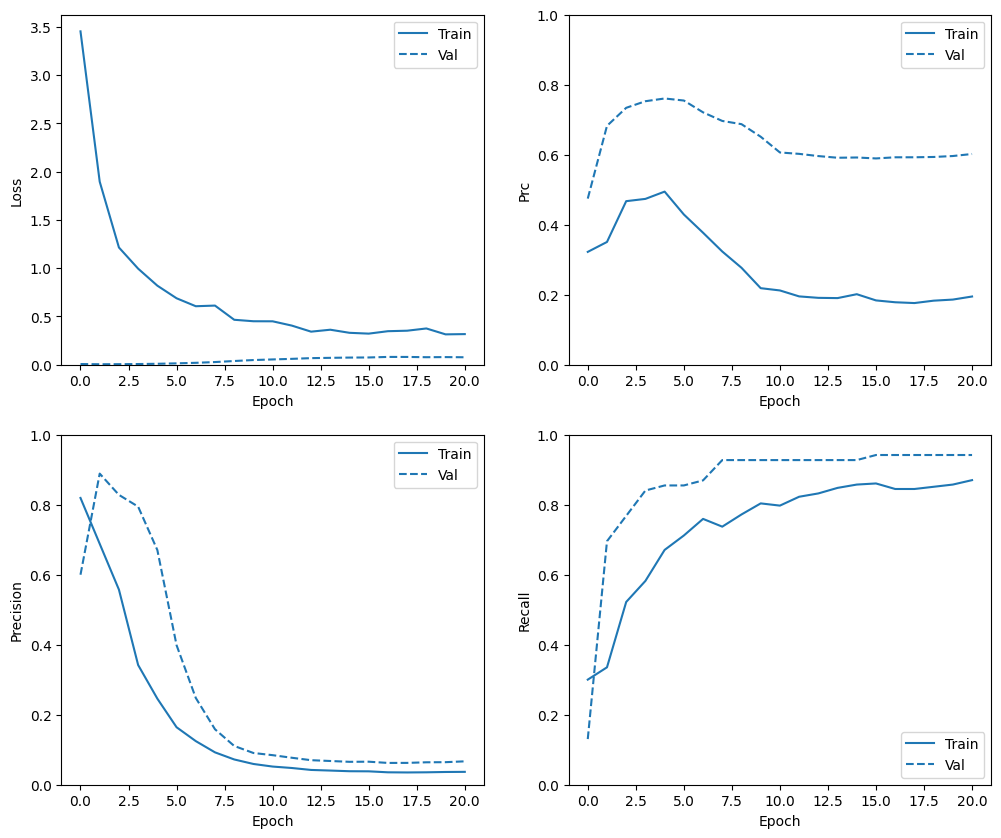

In [36]:
plot_metrics(weighted_history)

### 评估指标

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 7s

34/90 [==========>...................] - ETA: 0s

68/90 [=====================>........] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 1s

28/28 [==============================] - 0s 2ms/step


loss :  0.054440323263406754
tp :  94.0
fp :  832.0
tn :  56023.0
fn :  13.0
accuracy :  0.985165536403656
precision :  0.1015118807554245
recall :  0.8785046935081482
auc :  0.9787468910217285
prc :  0.6335744857788086

Legitimate Transactions Detected (True Negatives):  56023
Legitimate Transactions Incorrectly Detected (False Positives):  832
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  94
Total Fraudulent Transactions:  107


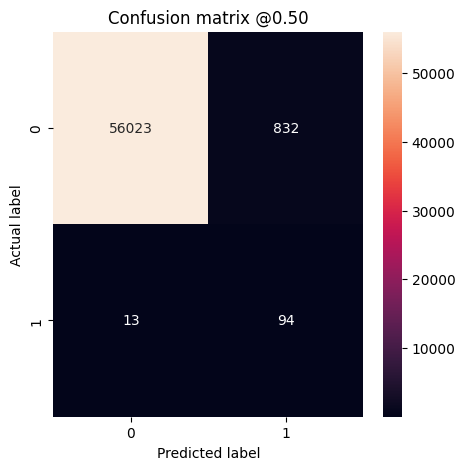

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

在这里，您可以看到，使用类权重时，由于存在更多假正例，准确率和精确率较低，但是相反，由于模型也找到了更多真正例，召回率和 AUC 较高。尽管准确率较低，但是此模型具有较高的召回率（且识别出了更多欺诈交易）。当然，两种类型的错误都有代价（您也不希望因将过多合法交易标记为欺诈来打扰客户）。请在应用时认真权衡这些不同类型的错误。

### 绘制 ROC

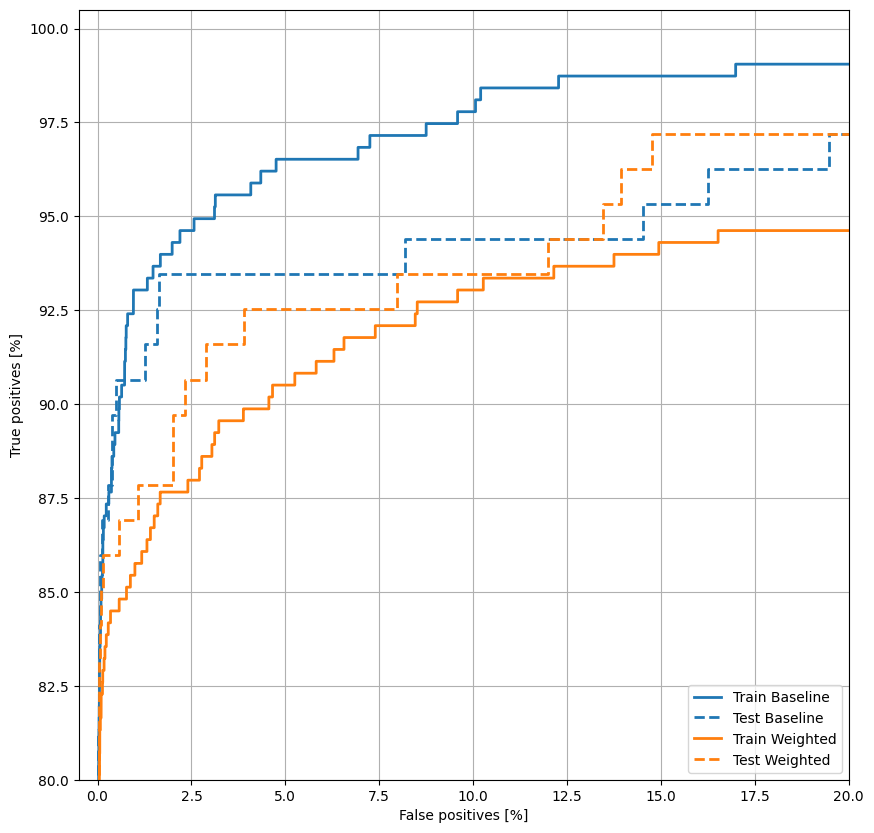

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### 绘制 AUPRC

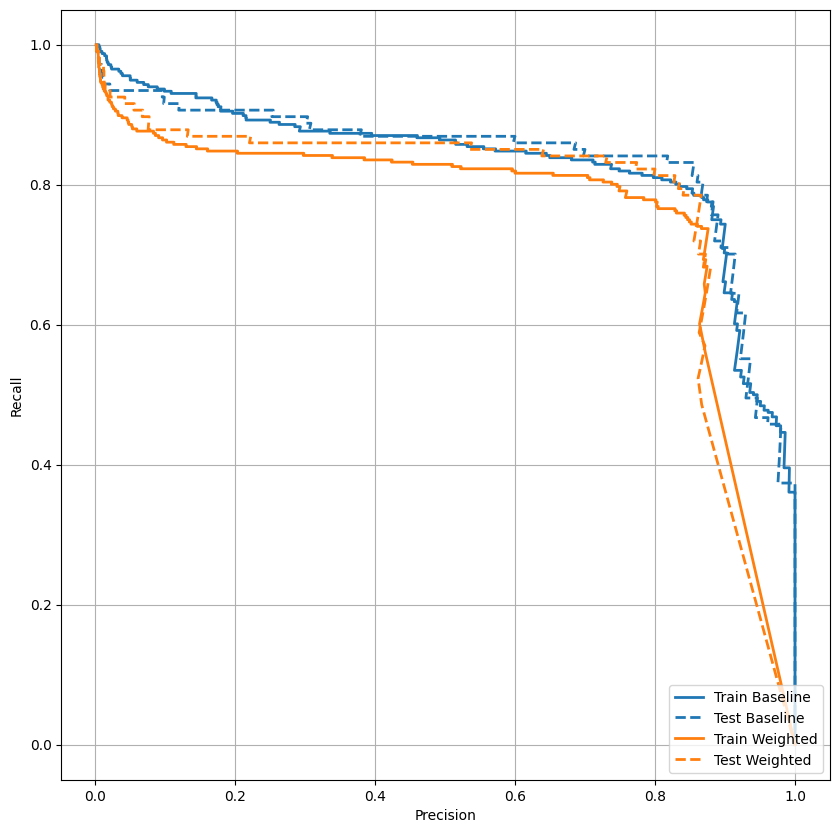

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## 过采样

### 对占少数的类进行过采样

一种相关方法是通过对占少数的类进行过采样来对数据集进行重新采样。

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### 使用 NumPy

您可以通过从正样本中选择正确数量的随机索引来手动平衡数据集：

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181960, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363920, 29)

#### 使用 `tf.data`

如果您使用的是 `tf.data`，则生成平衡样本最简单的方法是从 `positive` 和 `negative` 数据集开始，然后将它们合并。有关更多示例，请参阅 [tf.data 指南](../../guide/data.ipynb)。

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

每个数据集都会提供 `(feature, label)` 对：

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.9559428   0.80097054 -1.53757364  2.98558412  0.98626604 -0.64296745
  0.58623809 -0.1389485  -1.36773827  0.23749502  1.42062045 -0.28331678
 -0.7594046  -2.88674106 -1.86392462  1.81905823  2.28344955  1.42037765
 -1.88417858 -0.29778025 -0.2085476  -0.49742697  0.06843843 -0.3974017
  0.32761487 -0.00762779 -0.06715681  0.01644712 -0.48884179]

Label:  1


使用 `experimental.sample_from_datasets` 将二者合并起来：

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49072265625


要使用此数据集，您需要每个周期的步骤数。

在这种情况下，“周期”的定义就不那么明确了。假设它是遍历一次所有负样本所需的批次数量：

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### 在过采样数据上进行训练

现在尝试使用重新采样后的数据集（而非使用类权重）来训练模型，对比一下这两种方法有何区别。

注：因为数据平衡是通过复制正样本实现的，所以数据集的总大小变大了，且每个周期运行的训练步骤也增加了。 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 7:59 - loss: 2.3720 - tp: 378.0000 - fp: 964.0000 - tn: 56895.0000 - fn: 773.0000 - accuracy: 0.9706 - precision: 0.2817 - recall: 0.3284 - auc: 0.7089 - prc: 0.2678

  6/278 [..............................] - ETA: 3s - loss: 2.2077 - tp: 1832.0000 - fp: 1739.0000 - tn: 61275.0000 - fn: 4404.0000 - accuracy: 0.9113 - precision: 0.5130 - recall: 0.2938 - auc: 0.6839 - prc: 0.3834

  9/278 [..............................] - ETA: 4s - loss: 2.1251 - tp: 2842.0000 - fp: 2171.0000 - tn: 63901.0000 - fn: 6480.0000 - accuracy: 0.8853 - precision: 0.5669 - recall: 0.3049 - auc: 0.6801 - prc: 0.4292

 11/278 [>.............................] - ETA: 5s - loss: 2.0811 - tp: 3547.0000 - fp: 2483.0000 - tn: 65597.0000 - fn: 7863.0000 - accuracy: 0.8698 - precision: 0.5882 - recall: 0.3109 - auc: 0.6783 - prc: 0.4517

 13/278 [>.............................] - ETA: 5s - loss: 2.0378 - tp: 4273.0000 - fp: 2814.0000 - tn: 67312.0000 - fn: 9187.0000 - accuracy: 0.8564 - precision: 0.6029 - recall: 0.3175 - auc: 0.6760 - prc: 0.4711

 16/278 [>.............................] - ETA: 5s - loss: 1.9644 - tp: 5444.0000 - fp: 3299.0000 - tn: 69846.0000 - fn: 11141.0000 - accuracy: 0.8391 - precision: 0.6227 - recall: 0.3282 - auc: 0.6759 - prc: 0.4985

 19/278 [=>............................] - ETA: 5s - loss: 1.9044 - tp: 6649.0000 - fp: 3794.0000 - tn: 72423.0000 - fn: 13008.0000 - accuracy: 0.8247 - precision: 0.6367 - recall: 0.3383 - auc: 0.6752 - prc: 0.5196

 22/278 [=>............................] - ETA: 5s - loss: 1.8524 - tp: 7904.0000 - fp: 4304.0000 - tn: 74938.0000 - fn: 14872.0000 - accuracy: 0.8120 - precision: 0.6474 - recall: 0.3470 - auc: 0.6745 - prc: 0.5378

 25/278 [=>............................] - ETA: 5s - loss: 1.7976 - tp: 9224.0000 - fp: 4839.0000 - tn: 77454.0000 - fn: 16645.0000 - accuracy: 0.8014 - precision: 0.6559 - recall: 0.3566 - auc: 0.6750 - prc: 0.5546

 28/278 [==>...........................] - ETA: 5s - loss: 1.7495 - tp: 10566.0000 - fp: 5398.0000 - tn: 79940.0000 - fn: 18402.0000 - accuracy: 0.7918 - precision: 0.6619 - recall: 0.3647 - auc: 0.6749 - prc: 0.5685

 31/278 [==>...........................] - ETA: 5s - loss: 1.6957 - tp: 11944.0000 - fp: 5946.0000 - tn: 82525.0000 - fn: 20035.0000 - accuracy: 0.7843 - precision: 0.6676 - recall: 0.3735 - auc: 0.6760 - prc: 0.5814

 34/278 [==>...........................] - ETA: 5s - loss: 1.6509 - tp: 13334.0000 - fp: 6529.0000 - tn: 85088.0000 - fn: 21643.0000 - accuracy: 0.7775 - precision: 0.6713 - recall: 0.3812 - auc: 0.6763 - prc: 0.5922

 37/278 [==>...........................] - ETA: 5s - loss: 1.6082 - tp: 14843.0000 - fp: 7101.0000 - tn: 87513.0000 - fn: 23281.0000 - accuracy: 0.7711 - precision: 0.6764 - recall: 0.3893 - auc: 0.6780 - prc: 0.6040

 40/278 [===>..........................] - ETA: 5s - loss: 1.5675 - tp: 16360.0000 - fp: 7676.0000 - tn: 90019.0000 - fn: 24827.0000 - accuracy: 0.7660 - precision: 0.6806 - recall: 0.3972 - auc: 0.6794 - prc: 0.6141

 43/278 [===>..........................] - ETA: 4s - loss: 1.5271 - tp: 17866.0000 - fp: 8303.0000 - tn: 92499.0000 - fn: 26358.0000 - accuracy: 0.7610 - precision: 0.6827 - recall: 0.4040 - auc: 0.6808 - prc: 0.6228

 46/278 [===>..........................] - ETA: 4s - loss: 1.4914 - tp: 19485.0000 - fp: 8936.0000 - tn: 94919.0000 - fn: 27830.0000 - accuracy: 0.7568 - precision: 0.6856 - recall: 0.4118 - auc: 0.6828 - prc: 0.6319

 49/278 [====>.........................] - ETA: 4s - loss: 1.4574 - tp: 21119.0000 - fp: 9559.0000 - tn: 97391.0000 - fn: 29245.0000 - accuracy: 0.7533 - precision: 0.6884 - recall: 0.4193 - auc: 0.6845 - prc: 0.6401

 51/278 [====>.........................] - ETA: 4s - loss: 1.4350 - tp: 22215.0000 - fp: 9957.0000 - tn: 99041.0000 - fn: 30197.0000 - accuracy: 0.7512 - precision: 0.6905 - recall: 0.4239 - auc: 0.6859 - prc: 0.6454

 53/278 [====>.........................] - ETA: 4s - loss: 1.4149 - tp: 23318.0000 - fp: 10359.0000 - tn: 100703.0000 - fn: 31126.0000 - accuracy: 0.7493 - precision: 0.6924 - recall: 0.4283 - auc: 0.6870 - prc: 0.6501

 55/278 [====>.........................] - ETA: 4s - loss: 1.3931 - tp: 24508.0000 - fp: 10773.0000 - tn: 102317.0000 - fn: 32004.0000 - accuracy: 0.7478 - precision: 0.6947 - recall: 0.4337 - auc: 0.6889 - prc: 0.6557

 57/278 [=====>........................] - ETA: 4s - loss: 1.3732 - tp: 25682.0000 - fp: 11205.0000 - tn: 103936.0000 - fn: 32875.0000 - accuracy: 0.7462 - precision: 0.6962 - recall: 0.4386 - auc: 0.6904 - prc: 0.6606

 59/278 [=====>........................] - ETA: 4s - loss: 1.3542 - tp: 26850.0000 - fp: 11627.0000 - tn: 105580.0000 - fn: 33737.0000 - accuracy: 0.7449 - precision: 0.6978 - recall: 0.4432 - auc: 0.6917 - prc: 0.6650

 61/278 [=====>........................] - ETA: 4s - loss: 1.3343 - tp: 28087.0000 - fp: 12060.0000 - tn: 107151.0000 - fn: 34592.0000 - accuracy: 0.7435 - precision: 0.6996 - recall: 0.4481 - auc: 0.6937 - prc: 0.6702

 63/278 [=====>........................] - ETA: 4s - loss: 1.3161 - tp: 29343.0000 - fp: 12460.0000 - tn: 108790.0000 - fn: 35393.0000 - accuracy: 0.7427 - precision: 0.7019 - recall: 0.4533 - auc: 0.6956 - prc: 0.6750

 65/278 [======>.......................] - ETA: 4s - loss: 1.2986 - tp: 30601.0000 - fp: 12900.0000 - tn: 110396.0000 - fn: 36185.0000 - accuracy: 0.7418 - precision: 0.7035 - recall: 0.4582 - auc: 0.6973 - prc: 0.6793

 67/278 [======>.......................] - ETA: 4s - loss: 1.2810 - tp: 31841.0000 - fp: 13314.0000 - tn: 112032.0000 - fn: 36991.0000 - accuracy: 0.7409 - precision: 0.7051 - recall: 0.4626 - auc: 0.6990 - prc: 0.6837

 70/278 [======>.......................] - ETA: 4s - loss: 1.2562 - tp: 33769.0000 - fp: 13922.0000 - tn: 114482.0000 - fn: 38149.0000 - accuracy: 0.7401 - precision: 0.7081 - recall: 0.4695 - auc: 0.7016 - prc: 0.6901

 73/278 [======>.......................] - ETA: 4s - loss: 1.2318 - tp: 35741.0000 - fp: 14537.0000 - tn: 116966.0000 - fn: 39222.0000 - accuracy: 0.7396 - precision: 0.7109 - recall: 0.4768 - auc: 0.7044 - prc: 0.6964

 76/278 [=======>......................] - ETA: 4s - loss: 1.2090 - tp: 37731.0000 - fp: 15166.0000 - tn: 119444.0000 - fn: 40269.0000 - accuracy: 0.7393 - precision: 0.7133 - recall: 0.4837 - auc: 0.7070 - prc: 0.7022

 79/278 [=======>......................] - ETA: 4s - loss: 1.1879 - tp: 39727.0000 - fp: 15822.0000 - tn: 121871.0000 - fn: 41334.0000 - accuracy: 0.7387 - precision: 0.7152 - recall: 0.4901 - auc: 0.7093 - prc: 0.7076

 82/278 [=======>......................] - ETA: 4s - loss: 1.1662 - tp: 41821.0000 - fp: 16419.0000 - tn: 124322.0000 - fn: 42336.0000 - accuracy: 0.7387 - precision: 0.7181 - recall: 0.4969 - auc: 0.7124 - prc: 0.7135

 85/278 [========>.....................] - ETA: 4s - loss: 1.1452 - tp: 43924.0000 - fp: 17050.0000 - tn: 126807.0000 - fn: 43261.0000 - accuracy: 0.7390 - precision: 0.7204 - recall: 0.5038 - auc: 0.7153 - prc: 0.7190

 88/278 [========>.....................] - ETA: 4s - loss: 1.1260 - tp: 46055.0000 - fp: 17661.0000 - tn: 129267.0000 - fn: 44203.0000 - accuracy: 0.7392 - precision: 0.7228 - recall: 0.5103 - auc: 0.7180 - prc: 0.7242

 91/278 [========>.....................] - ETA: 4s - loss: 1.1078 - tp: 48182.0000 - fp: 18262.0000 - tn: 131729.0000 - fn: 45157.0000 - accuracy: 0.7394 - precision: 0.7252 - recall: 0.5162 - auc: 0.7206 - prc: 0.7290

 94/278 [=========>....................] - ETA: 4s - loss: 1.0899 - tp: 50368.0000 - fp: 18872.0000 - tn: 134211.0000 - fn: 46023.0000 - accuracy: 0.7399 - precision: 0.7274 - recall: 0.5225 - auc: 0.7233 - prc: 0.7338

 97/278 [=========>....................] - ETA: 4s - loss: 1.0727 - tp: 52543.0000 - fp: 19475.0000 - tn: 136714.0000 - fn: 46886.0000 - accuracy: 0.7404 - precision: 0.7296 - recall: 0.5284 - auc: 0.7260 - prc: 0.7385

100/278 [=========>....................] - ETA: 4s - loss: 1.0559 - tp: 54758.0000 - fp: 20084.0000 - tn: 139200.0000 - fn: 47720.0000 - accuracy: 0.7410 - precision: 0.7316 - recall: 0.5343 - auc: 0.7287 - prc: 0.7430

103/278 [==========>...................] - ETA: 3s - loss: 1.0404 - tp: 57044.0000 - fp: 20663.0000 - tn: 141668.0000 - fn: 48531.0000 - accuracy: 0.7417 - precision: 0.7341 - recall: 0.5403 - auc: 0.7314 - prc: 0.7475

106/278 [==========>...................] - ETA: 3s - loss: 1.0248 - tp: 59337.0000 - fp: 21219.0000 - tn: 144201.0000 - fn: 49293.0000 - accuracy: 0.7427 - precision: 0.7366 - recall: 0.5462 - auc: 0.7342 - prc: 0.7519

109/278 [==========>...................] - ETA: 3s - loss: 1.0107 - tp: 61615.0000 - fp: 21768.0000 - tn: 146698.0000 - fn: 50113.0000 - accuracy: 0.7435 - precision: 0.7389 - recall: 0.5515 - auc: 0.7367 - prc: 0.7559

112/278 [===========>..................] - ETA: 3s - loss: 0.9970 - tp: 63934.0000 - fp: 22304.0000 - tn: 149177.0000 - fn: 50923.0000 - accuracy: 0.7443 - precision: 0.7414 - recall: 0.5566 - auc: 0.7392 - prc: 0.7599

115/278 [===========>..................] - ETA: 3s - loss: 0.9838 - tp: 66210.0000 - fp: 22866.0000 - tn: 151688.0000 - fn: 51718.0000 - accuracy: 0.7450 - precision: 0.7433 - recall: 0.5614 - auc: 0.7416 - prc: 0.7636

118/278 [===========>..................] - ETA: 3s - loss: 0.9708 - tp: 68544.0000 - fp: 23414.0000 - tn: 154234.0000 - fn: 52434.0000 - accuracy: 0.7460 - precision: 0.7454 - recall: 0.5666 - auc: 0.7441 - prc: 0.7673

121/278 [============>.................] - ETA: 3s - loss: 0.9586 - tp: 70847.0000 - fp: 23943.0000 - tn: 156767.0000 - fn: 53213.0000 - accuracy: 0.7468 - precision: 0.7474 - recall: 0.5711 - auc: 0.7464 - prc: 0.7707

124/278 [============>.................] - ETA: 3s - loss: 0.9464 - tp: 73173.0000 - fp: 24455.0000 - tn: 159323.0000 - fn: 53963.0000 - accuracy: 0.7478 - precision: 0.7495 - recall: 0.5755 - auc: 0.7488 - prc: 0.7741

127/278 [============>.................] - ETA: 3s - loss: 0.9350 - tp: 75490.0000 - fp: 24980.0000 - tn: 161897.0000 - fn: 54691.0000 - accuracy: 0.7487 - precision: 0.7514 - recall: 0.5799 - auc: 0.7510 - prc: 0.7773

130/278 [=============>................] - ETA: 3s - loss: 0.9238 - tp: 77862.0000 - fp: 25494.0000 - tn: 164424.0000 - fn: 55422.0000 - accuracy: 0.7496 - precision: 0.7533 - recall: 0.5842 - auc: 0.7533 - prc: 0.7805

133/278 [=============>................] - ETA: 3s - loss: 0.9132 - tp: 80217.0000 - fp: 25972.0000 - tn: 166985.0000 - fn: 56172.0000 - accuracy: 0.7506 - precision: 0.7554 - recall: 0.5881 - auc: 0.7555 - prc: 0.7836

136/278 [=============>................] - ETA: 3s - loss: 0.9027 - tp: 82591.0000 - fp: 26466.0000 - tn: 169580.0000 - fn: 56853.0000 - accuracy: 0.7516 - precision: 0.7573 - recall: 0.5923 - auc: 0.7577 - prc: 0.7866

139/278 [==============>...............] - ETA: 3s - loss: 0.8927 - tp: 84998.0000 - fp: 26941.0000 - tn: 172129.0000 - fn: 57566.0000 - accuracy: 0.7526 - precision: 0.7593 - recall: 0.5962 - auc: 0.7599 - prc: 0.7895

142/278 [==============>...............] - ETA: 3s - loss: 0.8829 - tp: 87333.0000 - fp: 27444.0000 - tn: 174733.0000 - fn: 58268.0000 - accuracy: 0.7535 - precision: 0.7609 - recall: 0.5998 - auc: 0.7619 - prc: 0.7922

145/278 [==============>...............] - ETA: 2s - loss: 0.8734 - tp: 89687.0000 - fp: 27891.0000 - tn: 177389.0000 - fn: 58955.0000 - accuracy: 0.7546 - precision: 0.7628 - recall: 0.6034 - auc: 0.7639 - prc: 0.7948

148/278 [==============>...............] - ETA: 2s - loss: 0.8640 - tp: 92095.0000 - fp: 28332.0000 - tn: 180052.0000 - fn: 59587.0000 - accuracy: 0.7558 - precision: 0.7647 - recall: 0.6072 - auc: 0.7660 - prc: 0.7975

151/278 [===============>..............] - ETA: 2s - loss: 0.8549 - tp: 94504.0000 - fp: 28783.0000 - tn: 182686.0000 - fn: 60237.0000 - accuracy: 0.7569 - precision: 0.7665 - recall: 0.6107 - auc: 0.7681 - prc: 0.8001

154/278 [===============>..............] - ETA: 2s - loss: 0.8463 - tp: 96913.0000 - fp: 29198.0000 - tn: 185275.0000 - fn: 60968.0000 - accuracy: 0.7578 - precision: 0.7685 - recall: 0.6138 - auc: 0.7701 - prc: 0.8027

157/278 [===============>..............] - ETA: 2s - loss: 0.8381 - tp: 99321.0000 - fp: 29667.0000 - tn: 187875.0000 - fn: 61635.0000 - accuracy: 0.7588 - precision: 0.7700 - recall: 0.6171 - auc: 0.7721 - prc: 0.8051

160/278 [================>.............] - ETA: 2s - loss: 0.8300 - tp: 101745.0000 - fp: 30073.0000 - tn: 190521.0000 - fn: 62303.0000 - accuracy: 0.7598 - precision: 0.7719 - recall: 0.6202 - auc: 0.7740 - prc: 0.8074

163/278 [================>.............] - ETA: 2s - loss: 0.8221 - tp: 104171.0000 - fp: 30461.0000 - tn: 193162.0000 - fn: 62992.0000 - accuracy: 0.7609 - precision: 0.7737 - recall: 0.6232 - auc: 0.7759 - prc: 0.8097

166/278 [================>.............] - ETA: 2s - loss: 0.8144 - tp: 106538.0000 - fp: 30877.0000 - tn: 195874.0000 - fn: 63641.0000 - accuracy: 0.7619 - precision: 0.7753 - recall: 0.6260 - auc: 0.7777 - prc: 0.8118

169/278 [=================>............] - ETA: 2s - loss: 0.8069 - tp: 108930.0000 - fp: 31277.0000 - tn: 198588.0000 - fn: 64279.0000 - accuracy: 0.7629 - precision: 0.7769 - recall: 0.6289 - auc: 0.7795 - prc: 0.8139

172/278 [=================>............] - ETA: 2s - loss: 0.7998 - tp: 111339.0000 - fp: 31705.0000 - tn: 201234.0000 - fn: 64940.0000 - accuracy: 0.7638 - precision: 0.7784 - recall: 0.6316 - auc: 0.7812 - prc: 0.8160

175/278 [=================>............] - ETA: 2s - loss: 0.7928 - tp: 113740.0000 - fp: 32079.0000 - tn: 203959.0000 - fn: 65584.0000 - accuracy: 0.7649 - precision: 0.7800 - recall: 0.6343 - auc: 0.7829 - prc: 0.8179

178/278 [==================>...........] - ETA: 2s - loss: 0.7858 - tp: 116219.0000 - fp: 32435.0000 - tn: 206623.0000 - fn: 66229.0000 - accuracy: 0.7659 - precision: 0.7818 - recall: 0.6370 - auc: 0.7847 - prc: 0.8200

181/278 [==================>...........] - ETA: 2s - loss: 0.7791 - tp: 118684.0000 - fp: 32771.0000 - tn: 209297.0000 - fn: 66898.0000 - accuracy: 0.7669 - precision: 0.7836 - recall: 0.6395 - auc: 0.7864 - prc: 0.8220

183/278 [==================>...........] - ETA: 2s - loss: 0.7745 - tp: 120322.0000 - fp: 33029.0000 - tn: 211097.0000 - fn: 67298.0000 - accuracy: 0.7676 - precision: 0.7846 - recall: 0.6413 - auc: 0.7876 - prc: 0.8233

186/278 [===================>..........] - ETA: 2s - loss: 0.7680 - tp: 122773.0000 - fp: 33394.0000 - tn: 213785.0000 - fn: 67938.0000 - accuracy: 0.7686 - precision: 0.7862 - recall: 0.6438 - auc: 0.7893 - prc: 0.8252

189/278 [===================>..........] - ETA: 2s - loss: 0.7616 - tp: 125170.0000 - fp: 33724.0000 - tn: 216575.0000 - fn: 68565.0000 - accuracy: 0.7696 - precision: 0.7878 - recall: 0.6461 - auc: 0.7909 - prc: 0.8269

192/278 [===================>..........] - ETA: 1s - loss: 0.7554 - tp: 127672.0000 - fp: 34043.0000 - tn: 219256.0000 - fn: 69207.0000 - accuracy: 0.7706 - precision: 0.7895 - recall: 0.6485 - auc: 0.7926 - prc: 0.8288

195/278 [====================>.........] - ETA: 1s - loss: 0.7494 - tp: 130116.0000 - fp: 34387.0000 - tn: 221976.0000 - fn: 69843.0000 - accuracy: 0.7716 - precision: 0.7910 - recall: 0.6507 - auc: 0.7942 - prc: 0.8305

198/278 [====================>.........] - ETA: 1s - loss: 0.7435 - tp: 132632.0000 - fp: 34689.0000 - tn: 224700.0000 - fn: 70445.0000 - accuracy: 0.7727 - precision: 0.7927 - recall: 0.6531 - auc: 0.7958 - prc: 0.8323

201/278 [====================>.........] - ETA: 1s - loss: 0.7377 - tp: 135074.0000 - fp: 35017.0000 - tn: 227456.0000 - fn: 71063.0000 - accuracy: 0.7736 - precision: 0.7941 - recall: 0.6553 - auc: 0.7974 - prc: 0.8340

204/278 [=====================>........] - ETA: 1s - loss: 0.7320 - tp: 137490.0000 - fp: 35329.0000 - tn: 230272.0000 - fn: 71663.0000 - accuracy: 0.7746 - precision: 0.7956 - recall: 0.6574 - auc: 0.7989 - prc: 0.8355

207/278 [=====================>........] - ETA: 1s - loss: 0.7266 - tp: 139924.0000 - fp: 35649.0000 - tn: 233078.0000 - fn: 72247.0000 - accuracy: 0.7756 - precision: 0.7970 - recall: 0.6595 - auc: 0.8003 - prc: 0.8370

210/278 [=====================>........] - ETA: 1s - loss: 0.7213 - tp: 142414.0000 - fp: 35958.0000 - tn: 235787.0000 - fn: 72883.0000 - accuracy: 0.7765 - precision: 0.7984 - recall: 0.6615 - auc: 0.8018 - prc: 0.8385

213/278 [=====================>........] - ETA: 1s - loss: 0.7159 - tp: 144896.0000 - fp: 36242.0000 - tn: 238584.0000 - fn: 73464.0000 - accuracy: 0.7776 - precision: 0.7999 - recall: 0.6636 - auc: 0.8033 - prc: 0.8401

216/278 [======================>.......] - ETA: 1s - loss: 0.7108 - tp: 147408.0000 - fp: 36530.0000 - tn: 241332.0000 - fn: 74060.0000 - accuracy: 0.7785 - precision: 0.8014 - recall: 0.6656 - auc: 0.8048 - prc: 0.8416

219/278 [======================>.......] - ETA: 1s - loss: 0.7058 - tp: 149884.0000 - fp: 36861.0000 - tn: 244032.0000 - fn: 74697.0000 - accuracy: 0.7793 - precision: 0.8026 - recall: 0.6674 - auc: 0.8062 - prc: 0.8430

222/278 [======================>.......] - ETA: 1s - loss: 0.7009 - tp: 152387.0000 - fp: 37146.0000 - tn: 246804.0000 - fn: 75281.0000 - accuracy: 0.7803 - precision: 0.8040 - recall: 0.6693 - auc: 0.8075 - prc: 0.8445

225/278 [=======================>......] - ETA: 1s - loss: 0.6959 - tp: 154925.0000 - fp: 37410.0000 - tn: 249576.0000 - fn: 75851.0000 - accuracy: 0.7812 - precision: 0.8055 - recall: 0.6713 - auc: 0.8090 - prc: 0.8460

228/278 [=======================>......] - ETA: 1s - loss: 0.6912 - tp: 157398.0000 - fp: 37695.0000 - tn: 252349.0000 - fn: 76464.0000 - accuracy: 0.7821 - precision: 0.8068 - recall: 0.6730 - auc: 0.8103 - prc: 0.8473

231/278 [=======================>......] - ETA: 1s - loss: 0.6867 - tp: 159779.0000 - fp: 37963.0000 - tn: 255197.0000 - fn: 77111.0000 - accuracy: 0.7829 - precision: 0.8080 - recall: 0.6745 - auc: 0.8116 - prc: 0.8485

234/278 [========================>.....] - ETA: 0s - loss: 0.6821 - tp: 162211.0000 - fp: 38222.0000 - tn: 257945.0000 - fn: 77816.0000 - accuracy: 0.7836 - precision: 0.8093 - recall: 0.6758 - auc: 0.8130 - prc: 0.8499

237/278 [========================>.....] - ETA: 0s - loss: 0.6778 - tp: 164520.0000 - fp: 38473.0000 - tn: 260777.0000 - fn: 78568.0000 - accuracy: 0.7842 - precision: 0.8105 - recall: 0.6768 - auc: 0.8142 - prc: 0.8511

240/278 [========================>.....] - ETA: 0s - loss: 0.6734 - tp: 166903.0000 - fp: 38714.0000 - tn: 263602.0000 - fn: 79263.0000 - accuracy: 0.7849 - precision: 0.8117 - recall: 0.6780 - auc: 0.8155 - prc: 0.8523

243/278 [=========================>....] - ETA: 0s - loss: 0.6691 - tp: 169309.0000 - fp: 38961.0000 - tn: 266379.0000 - fn: 79977.0000 - accuracy: 0.7856 - precision: 0.8129 - recall: 0.6792 - auc: 0.8168 - prc: 0.8536

246/278 [=========================>....] - ETA: 0s - loss: 0.6648 - tp: 171671.0000 - fp: 39182.0000 - tn: 269242.0000 - fn: 80675.0000 - accuracy: 0.7863 - precision: 0.8142 - recall: 0.6803 - auc: 0.8181 - prc: 0.8548

249/278 [=========================>....] - ETA: 0s - loss: 0.6608 - tp: 174060.0000 - fp: 39427.0000 - tn: 272019.0000 - fn: 81408.0000 - accuracy: 0.7869 - precision: 0.8153 - recall: 0.6813 - auc: 0.8193 - prc: 0.8560

252/278 [==========================>...] - ETA: 0s - loss: 0.6567 - tp: 176441.0000 - fp: 39635.0000 - tn: 274875.0000 - fn: 82107.0000 - accuracy: 0.7876 - precision: 0.8166 - recall: 0.6824 - auc: 0.8206 - prc: 0.8572

255/278 [==========================>...] - ETA: 0s - loss: 0.6527 - tp: 178824.0000 - fp: 39867.0000 - tn: 277715.0000 - fn: 82796.0000 - accuracy: 0.7882 - precision: 0.8177 - recall: 0.6835 - auc: 0.8218 - prc: 0.8583

258/278 [==========================>...] - ETA: 0s - loss: 0.6487 - tp: 181164.0000 - fp: 40103.0000 - tn: 280605.0000 - fn: 83474.0000 - accuracy: 0.7889 - precision: 0.8188 - recall: 0.6846 - auc: 0.8230 - prc: 0.8594

261/278 [===========================>..] - ETA: 0s - loss: 0.6449 - tp: 183493.0000 - fp: 40347.0000 - tn: 283505.0000 - fn: 84145.0000 - accuracy: 0.7895 - precision: 0.8198 - recall: 0.6856 - auc: 0.8241 - prc: 0.8604

264/278 [===========================>..] - ETA: 0s - loss: 0.6411 - tp: 185899.0000 - fp: 40561.0000 - tn: 286318.0000 - fn: 84856.0000 - accuracy: 0.7901 - precision: 0.8209 - recall: 0.6866 - auc: 0.8253 - prc: 0.8615

267/278 [===========================>..] - ETA: 0s - loss: 0.6374 - tp: 188288.0000 - fp: 40797.0000 - tn: 289137.0000 - fn: 85556.0000 - accuracy: 0.7907 - precision: 0.8219 - recall: 0.6876 - auc: 0.8264 - prc: 0.8625

270/278 [============================>.] - ETA: 0s - loss: 0.6338 - tp: 190641.0000 - fp: 41038.0000 - tn: 291972.0000 - fn: 86271.0000 - accuracy: 0.7913 - precision: 0.8229 - recall: 0.6885 - auc: 0.8275 - prc: 0.8635

273/278 [============================>.] - ETA: 0s - loss: 0.6302 - tp: 193047.0000 - fp: 41222.0000 - tn: 294815.0000 - fn: 86982.0000 - accuracy: 0.7919 - precision: 0.8240 - recall: 0.6894 - auc: 0.8286 - prc: 0.8646

276/278 [============================>.] - ETA: 0s - loss: 0.6267 - tp: 195387.0000 - fp: 41424.0000 - tn: 297729.0000 - fn: 87670.0000 - accuracy: 0.7925 - precision: 0.8251 - recall: 0.6903 - auc: 0.8297 - prc: 0.8656

278/278 [==============================] - 9s 26ms/step - loss: 0.6244 - tp: 196970.0000 - fp: 41577.0000 - tn: 299585.0000 - fn: 88174.0000 - accuracy: 0.7928 - precision: 0.8257 - recall: 0.6908 - auc: 0.8304 - prc: 0.8662 - val_loss: 0.1924 - val_tp: 63.0000 - val_fp: 819.0000 - val_tn: 44681.0000 - val_fn: 6.0000 - val_accuracy: 0.9819 - val_precision: 0.0714 - val_recall: 0.9130 - val_auc: 0.9944 - val_prc: 0.7565


Epoch 2/100


  1/278 [..............................] - ETA: 1s - loss: 0.3036 - tp: 782.0000 - fp: 68.0000 - tn: 959.0000 - fn: 239.0000 - accuracy: 0.8501 - precision: 0.9200 - recall: 0.7659 - auc: 0.9335 - prc: 0.9486

  5/278 [..............................] - ETA: 4s - loss: 0.3000 - tp: 3970.0000 - fp: 330.0000 - tn: 4801.0000 - fn: 1139.0000 - accuracy: 0.8565 - precision: 0.9233 - recall: 0.7771 - auc: 0.9358 - prc: 0.9511

  8/278 [..............................] - ETA: 5s - loss: 0.3003 - tp: 6302.0000 - fp: 549.0000 - tn: 7699.0000 - fn: 1834.0000 - accuracy: 0.8546 - precision: 0.9199 - recall: 0.7746 - auc: 0.9356 - prc: 0.9500

 11/278 [>.............................] - ETA: 5s - loss: 0.3011 - tp: 8681.0000 - fp: 742.0000 - tn: 10561.0000 - fn: 2544.0000 - accuracy: 0.8541 - precision: 0.9213 - recall: 0.7734 - auc: 0.9351 - prc: 0.9500

 14/278 [>.............................] - ETA: 5s - loss: 0.2986 - tp: 11121.0000 - fp: 940.0000 - tn: 13393.0000 - fn: 3218.0000 - accuracy: 0.8550 - precision: 0.9221 - recall: 0.7756 - auc: 0.9364 - prc: 0.9511

 17/278 [>.............................] - ETA: 5s - loss: 0.2979 - tp: 13527.0000 - fp: 1129.0000 - tn: 16249.0000 - fn: 3911.0000 - accuracy: 0.8552 - precision: 0.9230 - recall: 0.7757 - auc: 0.9366 - prc: 0.9515

 20/278 [=>............................] - ETA: 5s - loss: 0.2965 - tp: 15951.0000 - fp: 1326.0000 - tn: 19102.0000 - fn: 4581.0000 - accuracy: 0.8558 - precision: 0.9233 - recall: 0.7769 - auc: 0.9374 - prc: 0.9520

 23/278 [=>............................] - ETA: 5s - loss: 0.2950 - tp: 18367.0000 - fp: 1497.0000 - tn: 21962.0000 - fn: 5278.0000 - accuracy: 0.8562 - precision: 0.9246 - recall: 0.7768 - auc: 0.9385 - prc: 0.9526

 26/278 [=>............................] - ETA: 5s - loss: 0.2948 - tp: 20711.0000 - fp: 1707.0000 - tn: 24902.0000 - fn: 5928.0000 - accuracy: 0.8566 - precision: 0.9239 - recall: 0.7775 - auc: 0.9388 - prc: 0.9526

 29/278 [==>...........................] - ETA: 5s - loss: 0.2944 - tp: 23081.0000 - fp: 1896.0000 - tn: 27789.0000 - fn: 6626.0000 - accuracy: 0.8565 - precision: 0.9241 - recall: 0.7770 - auc: 0.9389 - prc: 0.9526

 32/278 [==>...........................] - ETA: 5s - loss: 0.2932 - tp: 25414.0000 - fp: 2093.0000 - tn: 30743.0000 - fn: 7286.0000 - accuracy: 0.8569 - precision: 0.9239 - recall: 0.7772 - auc: 0.9394 - prc: 0.9528

 34/278 [==>...........................] - ETA: 5s - loss: 0.2927 - tp: 26984.0000 - fp: 2224.0000 - tn: 32710.0000 - fn: 7714.0000 - accuracy: 0.8573 - precision: 0.9239 - recall: 0.7777 - auc: 0.9396 - prc: 0.9528

 37/278 [==>...........................] - ETA: 5s - loss: 0.2917 - tp: 29318.0000 - fp: 2403.0000 - tn: 35682.0000 - fn: 8373.0000 - accuracy: 0.8578 - precision: 0.9242 - recall: 0.7779 - auc: 0.9399 - prc: 0.9530

 39/278 [===>..........................] - ETA: 5s - loss: 0.2909 - tp: 30933.0000 - fp: 2516.0000 - tn: 37604.0000 - fn: 8819.0000 - accuracy: 0.8581 - precision: 0.9248 - recall: 0.7781 - auc: 0.9403 - prc: 0.9532

 42/278 [===>..........................] - ETA: 5s - loss: 0.2906 - tp: 33268.0000 - fp: 2724.0000 - tn: 40532.0000 - fn: 9492.0000 - accuracy: 0.8580 - precision: 0.9243 - recall: 0.7780 - auc: 0.9405 - prc: 0.9532

 45/278 [===>..........................] - ETA: 5s - loss: 0.2898 - tp: 35716.0000 - fp: 2907.0000 - tn: 43374.0000 - fn: 10163.0000 - accuracy: 0.8582 - precision: 0.9247 - recall: 0.7785 - auc: 0.9410 - prc: 0.9535

 48/278 [====>.........................] - ETA: 5s - loss: 0.2888 - tp: 38092.0000 - fp: 3081.0000 - tn: 46303.0000 - fn: 10828.0000 - accuracy: 0.8585 - precision: 0.9252 - recall: 0.7787 - auc: 0.9415 - prc: 0.9538

 51/278 [====>.........................] - ETA: 5s - loss: 0.2876 - tp: 40463.0000 - fp: 3248.0000 - tn: 49280.0000 - fn: 11457.0000 - accuracy: 0.8592 - precision: 0.9257 - recall: 0.7793 - auc: 0.9419 - prc: 0.9540

 54/278 [====>.........................] - ETA: 5s - loss: 0.2867 - tp: 42883.0000 - fp: 3424.0000 - tn: 52180.0000 - fn: 12105.0000 - accuracy: 0.8596 - precision: 0.9261 - recall: 0.7799 - auc: 0.9423 - prc: 0.9543

 57/278 [=====>........................] - ETA: 5s - loss: 0.2861 - tp: 45227.0000 - fp: 3607.0000 - tn: 55113.0000 - fn: 12789.0000 - accuracy: 0.8595 - precision: 0.9261 - recall: 0.7796 - auc: 0.9426 - prc: 0.9544

 60/278 [=====>........................] - ETA: 4s - loss: 0.2856 - tp: 47626.0000 - fp: 3796.0000 - tn: 57990.0000 - fn: 13468.0000 - accuracy: 0.8595 - precision: 0.9262 - recall: 0.7796 - auc: 0.9429 - prc: 0.9546

 63/278 [=====>........................] - ETA: 4s - loss: 0.2848 - tp: 49999.0000 - fp: 3969.0000 - tn: 60921.0000 - fn: 14135.0000 - accuracy: 0.8597 - precision: 0.9265 - recall: 0.7796 - auc: 0.9432 - prc: 0.9549

 66/278 [======>.......................] - ETA: 4s - loss: 0.2841 - tp: 52442.0000 - fp: 4124.0000 - tn: 63756.0000 - fn: 14846.0000 - accuracy: 0.8597 - precision: 0.9271 - recall: 0.7794 - auc: 0.9436 - prc: 0.9552

 69/278 [======>.......................] - ETA: 4s - loss: 0.2833 - tp: 54856.0000 - fp: 4280.0000 - tn: 66681.0000 - fn: 15495.0000 - accuracy: 0.8601 - precision: 0.9276 - recall: 0.7797 - auc: 0.9439 - prc: 0.9555

 72/278 [======>.......................] - ETA: 4s - loss: 0.2826 - tp: 57265.0000 - fp: 4459.0000 - tn: 69573.0000 - fn: 16159.0000 - accuracy: 0.8602 - precision: 0.9278 - recall: 0.7799 - auc: 0.9443 - prc: 0.9557

 75/278 [=======>......................] - ETA: 4s - loss: 0.2819 - tp: 59631.0000 - fp: 4619.0000 - tn: 72541.0000 - fn: 16809.0000 - accuracy: 0.8605 - precision: 0.9281 - recall: 0.7801 - auc: 0.9446 - prc: 0.9559

 78/278 [=======>......................] - ETA: 4s - loss: 0.2812 - tp: 62052.0000 - fp: 4804.0000 - tn: 75414.0000 - fn: 17474.0000 - accuracy: 0.8605 - precision: 0.9281 - recall: 0.7803 - auc: 0.9449 - prc: 0.9561

 80/278 [=======>......................] - ETA: 4s - loss: 0.2807 - tp: 63653.0000 - fp: 4912.0000 - tn: 77356.0000 - fn: 17919.0000 - accuracy: 0.8607 - precision: 0.9284 - recall: 0.7803 - auc: 0.9451 - prc: 0.9562

 83/278 [=======>......................] - ETA: 4s - loss: 0.2799 - tp: 66105.0000 - fp: 5073.0000 - tn: 80247.0000 - fn: 18559.0000 - accuracy: 0.8610 - precision: 0.9287 - recall: 0.7808 - auc: 0.9455 - prc: 0.9565

 86/278 [========>.....................] - ETA: 4s - loss: 0.2792 - tp: 68510.0000 - fp: 5248.0000 - tn: 83154.0000 - fn: 19216.0000 - accuracy: 0.8611 - precision: 0.9288 - recall: 0.7810 - auc: 0.9458 - prc: 0.9567

 89/278 [========>.....................] - ETA: 4s - loss: 0.2788 - tp: 70854.0000 - fp: 5415.0000 - tn: 86066.0000 - fn: 19937.0000 - accuracy: 0.8609 - precision: 0.9290 - recall: 0.7804 - auc: 0.9460 - prc: 0.9568

 92/278 [========>.....................] - ETA: 4s - loss: 0.2781 - tp: 73285.0000 - fp: 5586.0000 - tn: 88963.0000 - fn: 20582.0000 - accuracy: 0.8611 - precision: 0.9292 - recall: 0.7807 - auc: 0.9463 - prc: 0.9570

 95/278 [=========>....................] - ETA: 4s - loss: 0.2772 - tp: 75686.0000 - fp: 5748.0000 - tn: 91897.0000 - fn: 21229.0000 - accuracy: 0.8613 - precision: 0.9294 - recall: 0.7810 - auc: 0.9467 - prc: 0.9573

 98/278 [=========>....................] - ETA: 4s - loss: 0.2765 - tp: 78116.0000 - fp: 5895.0000 - tn: 94803.0000 - fn: 21890.0000 - accuracy: 0.8616 - precision: 0.9298 - recall: 0.7811 - auc: 0.9471 - prc: 0.9575

101/278 [=========>....................] - ETA: 4s - loss: 0.2761 - tp: 80553.0000 - fp: 6056.0000 - tn: 97673.0000 - fn: 22566.0000 - accuracy: 0.8616 - precision: 0.9301 - recall: 0.7812 - auc: 0.9473 - prc: 0.9577

104/278 [==========>...................] - ETA: 3s - loss: 0.2754 - tp: 82912.0000 - fp: 6214.0000 - tn: 100659.0000 - fn: 23207.0000 - accuracy: 0.8619 - precision: 0.9303 - recall: 0.7813 - auc: 0.9476 - prc: 0.9578

107/278 [==========>...................] - ETA: 3s - loss: 0.2748 - tp: 85308.0000 - fp: 6369.0000 - tn: 103587.0000 - fn: 23872.0000 - accuracy: 0.8620 - precision: 0.9305 - recall: 0.7814 - auc: 0.9479 - prc: 0.9580

110/278 [==========>...................] - ETA: 3s - loss: 0.2742 - tp: 87724.0000 - fp: 6508.0000 - tn: 106533.0000 - fn: 24515.0000 - accuracy: 0.8623 - precision: 0.9309 - recall: 0.7816 - auc: 0.9482 - prc: 0.9582

112/278 [===========>..................] - ETA: 3s - loss: 0.2738 - tp: 89370.0000 - fp: 6612.0000 - tn: 108457.0000 - fn: 24937.0000 - accuracy: 0.8625 - precision: 0.9311 - recall: 0.7818 - auc: 0.9484 - prc: 0.9584

114/278 [===========>..................] - ETA: 3s - loss: 0.2733 - tp: 90961.0000 - fp: 6706.0000 - tn: 110431.0000 - fn: 25374.0000 - accuracy: 0.8626 - precision: 0.9313 - recall: 0.7819 - auc: 0.9486 - prc: 0.9585

117/278 [===========>..................] - ETA: 3s - loss: 0.2725 - tp: 93408.0000 - fp: 6848.0000 - tn: 113327.0000 - fn: 26033.0000 - accuracy: 0.8628 - precision: 0.9317 - recall: 0.7820 - auc: 0.9490 - prc: 0.9588

120/278 [===========>..................] - ETA: 3s - loss: 0.2720 - tp: 95847.0000 - fp: 7005.0000 - tn: 116200.0000 - fn: 26708.0000 - accuracy: 0.8628 - precision: 0.9319 - recall: 0.7821 - auc: 0.9492 - prc: 0.9590

123/278 [============>.................] - ETA: 3s - loss: 0.2717 - tp: 98218.0000 - fp: 7184.0000 - tn: 119093.0000 - fn: 27409.0000 - accuracy: 0.8627 - precision: 0.9318 - recall: 0.7818 - auc: 0.9494 - prc: 0.9591

126/278 [============>.................] - ETA: 3s - loss: 0.2711 - tp: 100591.0000 - fp: 7344.0000 - tn: 122055.0000 - fn: 28058.0000 - accuracy: 0.8628 - precision: 0.9320 - recall: 0.7819 - auc: 0.9496 - prc: 0.9592

129/278 [============>.................] - ETA: 3s - loss: 0.2705 - tp: 103046.0000 - fp: 7481.0000 - tn: 124961.0000 - fn: 28704.0000 - accuracy: 0.8630 - precision: 0.9323 - recall: 0.7821 - auc: 0.9499 - prc: 0.9595

132/278 [=============>................] - ETA: 3s - loss: 0.2700 - tp: 105422.0000 - fp: 7615.0000 - tn: 127913.0000 - fn: 29386.0000 - accuracy: 0.8631 - precision: 0.9326 - recall: 0.7820 - auc: 0.9501 - prc: 0.9596

135/278 [=============>................] - ETA: 3s - loss: 0.2696 - tp: 107830.0000 - fp: 7780.0000 - tn: 130785.0000 - fn: 30085.0000 - accuracy: 0.8630 - precision: 0.9327 - recall: 0.7819 - auc: 0.9503 - prc: 0.9597

138/278 [=============>................] - ETA: 3s - loss: 0.2692 - tp: 110197.0000 - fp: 7939.0000 - tn: 133732.0000 - fn: 30756.0000 - accuracy: 0.8631 - precision: 0.9328 - recall: 0.7818 - auc: 0.9505 - prc: 0.9598

141/278 [==============>...............] - ETA: 3s - loss: 0.2687 - tp: 112567.0000 - fp: 8065.0000 - tn: 136713.0000 - fn: 31423.0000 - accuracy: 0.8633 - precision: 0.9331 - recall: 0.7818 - auc: 0.9507 - prc: 0.9600

144/278 [==============>...............] - ETA: 3s - loss: 0.2681 - tp: 115005.0000 - fp: 8215.0000 - tn: 139639.0000 - fn: 32053.0000 - accuracy: 0.8635 - precision: 0.9333 - recall: 0.7820 - auc: 0.9510 - prc: 0.9601

147/278 [==============>...............] - ETA: 3s - loss: 0.2676 - tp: 117441.0000 - fp: 8354.0000 - tn: 142558.0000 - fn: 32703.0000 - accuracy: 0.8636 - precision: 0.9336 - recall: 0.7822 - auc: 0.9512 - prc: 0.9603

149/278 [===============>..............] - ETA: 2s - loss: 0.2674 - tp: 119041.0000 - fp: 8470.0000 - tn: 144512.0000 - fn: 33129.0000 - accuracy: 0.8637 - precision: 0.9336 - recall: 0.7823 - auc: 0.9513 - prc: 0.9604

152/278 [===============>..............] - ETA: 2s - loss: 0.2668 - tp: 121487.0000 - fp: 8601.0000 - tn: 147444.0000 - fn: 33764.0000 - accuracy: 0.8639 - precision: 0.9339 - recall: 0.7825 - auc: 0.9516 - prc: 0.9606

155/278 [===============>..............] - ETA: 2s - loss: 0.2661 - tp: 123926.0000 - fp: 8741.0000 - tn: 150398.0000 - fn: 34375.0000 - accuracy: 0.8642 - precision: 0.9341 - recall: 0.7829 - auc: 0.9519 - prc: 0.9608

158/278 [================>.............] - ETA: 2s - loss: 0.2656 - tp: 126419.0000 - fp: 8886.0000 - tn: 153264.0000 - fn: 35015.0000 - accuracy: 0.8643 - precision: 0.9343 - recall: 0.7831 - auc: 0.9521 - prc: 0.9609

161/278 [================>.............] - ETA: 2s - loss: 0.2652 - tp: 128841.0000 - fp: 9053.0000 - tn: 156169.0000 - fn: 35665.0000 - accuracy: 0.8644 - precision: 0.9343 - recall: 0.7832 - auc: 0.9523 - prc: 0.9611

164/278 [================>.............] - ETA: 2s - loss: 0.2646 - tp: 131285.0000 - fp: 9214.0000 - tn: 159099.0000 - fn: 36274.0000 - accuracy: 0.8646 - precision: 0.9344 - recall: 0.7835 - auc: 0.9525 - prc: 0.9612

167/278 [=================>............] - ETA: 2s - loss: 0.2640 - tp: 133676.0000 - fp: 9364.0000 - tn: 162066.0000 - fn: 36910.0000 - accuracy: 0.8647 - precision: 0.9345 - recall: 0.7836 - auc: 0.9528 - prc: 0.9614

170/278 [=================>............] - ETA: 2s - loss: 0.2635 - tp: 136119.0000 - fp: 9499.0000 - tn: 164978.0000 - fn: 37564.0000 - accuracy: 0.8648 - precision: 0.9348 - recall: 0.7837 - auc: 0.9530 - prc: 0.9616

173/278 [=================>............] - ETA: 2s - loss: 0.2631 - tp: 138540.0000 - fp: 9645.0000 - tn: 167880.0000 - fn: 38239.0000 - accuracy: 0.8649 - precision: 0.9349 - recall: 0.7837 - auc: 0.9532 - prc: 0.9617

176/278 [=================>............] - ETA: 2s - loss: 0.2625 - tp: 140942.0000 - fp: 9777.0000 - tn: 170842.0000 - fn: 38887.0000 - accuracy: 0.8650 - precision: 0.9351 - recall: 0.7838 - auc: 0.9534 - prc: 0.9619

179/278 [==================>...........] - ETA: 2s - loss: 0.2620 - tp: 143314.0000 - fp: 9932.0000 - tn: 173850.0000 - fn: 39496.0000 - accuracy: 0.8652 - precision: 0.9352 - recall: 0.7840 - auc: 0.9536 - prc: 0.9620

182/278 [==================>...........] - ETA: 2s - loss: 0.2615 - tp: 145754.0000 - fp: 10068.0000 - tn: 176765.0000 - fn: 40149.0000 - accuracy: 0.8653 - precision: 0.9354 - recall: 0.7840 - auc: 0.9539 - prc: 0.9621

185/278 [==================>...........] - ETA: 2s - loss: 0.2612 - tp: 148200.0000 - fp: 10246.0000 - tn: 179631.0000 - fn: 40803.0000 - accuracy: 0.8653 - precision: 0.9353 - recall: 0.7841 - auc: 0.9540 - prc: 0.9622

188/278 [===================>..........] - ETA: 2s - loss: 0.2608 - tp: 150574.0000 - fp: 10415.0000 - tn: 182605.0000 - fn: 41430.0000 - accuracy: 0.8653 - precision: 0.9353 - recall: 0.7842 - auc: 0.9542 - prc: 0.9623

191/278 [===================>..........] - ETA: 2s - loss: 0.2604 - tp: 153048.0000 - fp: 10553.0000 - tn: 185475.0000 - fn: 42092.0000 - accuracy: 0.8654 - precision: 0.9355 - recall: 0.7843 - auc: 0.9544 - prc: 0.9625

194/278 [===================>..........] - ETA: 1s - loss: 0.2600 - tp: 155497.0000 - fp: 10703.0000 - tn: 188382.0000 - fn: 42730.0000 - accuracy: 0.8655 - precision: 0.9356 - recall: 0.7844 - auc: 0.9546 - prc: 0.9626

197/278 [====================>.........] - ETA: 1s - loss: 0.2596 - tp: 157903.0000 - fp: 10854.0000 - tn: 191309.0000 - fn: 43390.0000 - accuracy: 0.8656 - precision: 0.9357 - recall: 0.7844 - auc: 0.9548 - prc: 0.9627

200/278 [====================>.........] - ETA: 1s - loss: 0.2592 - tp: 160377.0000 - fp: 11002.0000 - tn: 194176.0000 - fn: 44045.0000 - accuracy: 0.8656 - precision: 0.9358 - recall: 0.7845 - auc: 0.9550 - prc: 0.9629

203/278 [====================>.........] - ETA: 1s - loss: 0.2588 - tp: 162778.0000 - fp: 11134.0000 - tn: 197146.0000 - fn: 44686.0000 - accuracy: 0.8657 - precision: 0.9360 - recall: 0.7846 - auc: 0.9552 - prc: 0.9630

206/278 [=====================>........] - ETA: 1s - loss: 0.2584 - tp: 165272.0000 - fp: 11303.0000 - tn: 200010.0000 - fn: 45303.0000 - accuracy: 0.8658 - precision: 0.9360 - recall: 0.7849 - auc: 0.9553 - prc: 0.9631

209/278 [=====================>........] - ETA: 1s - loss: 0.2581 - tp: 167731.0000 - fp: 11450.0000 - tn: 202867.0000 - fn: 45984.0000 - accuracy: 0.8658 - precision: 0.9361 - recall: 0.7848 - auc: 0.9555 - prc: 0.9633

211/278 [=====================>........] - ETA: 1s - loss: 0.2578 - tp: 169375.0000 - fp: 11546.0000 - tn: 204798.0000 - fn: 46409.0000 - accuracy: 0.8659 - precision: 0.9362 - recall: 0.7849 - auc: 0.9556 - prc: 0.9633

213/278 [=====================>........] - ETA: 1s - loss: 0.2574 - tp: 170974.0000 - fp: 11635.0000 - tn: 206768.0000 - fn: 46847.0000 - accuracy: 0.8659 - precision: 0.9363 - recall: 0.7849 - auc: 0.9558 - prc: 0.9635

215/278 [======================>.......] - ETA: 1s - loss: 0.2572 - tp: 172599.0000 - fp: 11739.0000 - tn: 208680.0000 - fn: 47302.0000 - accuracy: 0.8659 - precision: 0.9363 - recall: 0.7849 - auc: 0.9559 - prc: 0.9635

217/278 [======================>.......] - ETA: 1s - loss: 0.2568 - tp: 174267.0000 - fp: 11809.0000 - tn: 210616.0000 - fn: 47724.0000 - accuracy: 0.8660 - precision: 0.9365 - recall: 0.7850 - auc: 0.9560 - prc: 0.9637

219/278 [======================>.......] - ETA: 1s - loss: 0.2566 - tp: 175905.0000 - fp: 11893.0000 - tn: 212570.0000 - fn: 48144.0000 - accuracy: 0.8661 - precision: 0.9367 - recall: 0.7851 - auc: 0.9562 - prc: 0.9637

221/278 [======================>.......] - ETA: 1s - loss: 0.2563 - tp: 177507.0000 - fp: 11993.0000 - tn: 214539.0000 - fn: 48569.0000 - accuracy: 0.8662 - precision: 0.9367 - recall: 0.7852 - auc: 0.9563 - prc: 0.9638

223/278 [=======================>......] - ETA: 1s - loss: 0.2559 - tp: 179157.0000 - fp: 12076.0000 - tn: 216495.0000 - fn: 48976.0000 - accuracy: 0.8663 - precision: 0.9369 - recall: 0.7853 - auc: 0.9565 - prc: 0.9639

225/278 [=======================>......] - ETA: 1s - loss: 0.2556 - tp: 180776.0000 - fp: 12169.0000 - tn: 218442.0000 - fn: 49413.0000 - accuracy: 0.8664 - precision: 0.9369 - recall: 0.7853 - auc: 0.9566 - prc: 0.9640

227/278 [=======================>......] - ETA: 1s - loss: 0.2553 - tp: 182374.0000 - fp: 12260.0000 - tn: 220412.0000 - fn: 49850.0000 - accuracy: 0.8664 - precision: 0.9370 - recall: 0.7853 - auc: 0.9567 - prc: 0.9641

229/278 [=======================>......] - ETA: 1s - loss: 0.2550 - tp: 184075.0000 - fp: 12353.0000 - tn: 222301.0000 - fn: 50263.0000 - accuracy: 0.8665 - precision: 0.9371 - recall: 0.7855 - auc: 0.9568 - prc: 0.9642

232/278 [========================>.....] - ETA: 1s - loss: 0.2546 - tp: 186446.0000 - fp: 12467.0000 - tn: 225325.0000 - fn: 50898.0000 - accuracy: 0.8666 - precision: 0.9373 - recall: 0.7856 - auc: 0.9570 - prc: 0.9643

235/278 [========================>.....] - ETA: 1s - loss: 0.2542 - tp: 188896.0000 - fp: 12617.0000 - tn: 228220.0000 - fn: 51547.0000 - accuracy: 0.8667 - precision: 0.9374 - recall: 0.7856 - auc: 0.9572 - prc: 0.9644

238/278 [========================>.....] - ETA: 0s - loss: 0.2537 - tp: 191373.0000 - fp: 12754.0000 - tn: 231159.0000 - fn: 52138.0000 - accuracy: 0.8669 - precision: 0.9375 - recall: 0.7859 - auc: 0.9574 - prc: 0.9646

241/278 [=========================>....] - ETA: 0s - loss: 0.2533 - tp: 193777.0000 - fp: 12895.0000 - tn: 234131.0000 - fn: 52765.0000 - accuracy: 0.8670 - precision: 0.9376 - recall: 0.7860 - auc: 0.9576 - prc: 0.9647

244/278 [=========================>....] - ETA: 0s - loss: 0.2528 - tp: 196309.0000 - fp: 13017.0000 - tn: 236970.0000 - fn: 53416.0000 - accuracy: 0.8671 - precision: 0.9378 - recall: 0.7861 - auc: 0.9578 - prc: 0.9648

247/278 [=========================>....] - ETA: 0s - loss: 0.2524 - tp: 198774.0000 - fp: 13143.0000 - tn: 239924.0000 - fn: 54015.0000 - accuracy: 0.8672 - precision: 0.9380 - recall: 0.7863 - auc: 0.9580 - prc: 0.9650

250/278 [=========================>....] - ETA: 0s - loss: 0.2520 - tp: 201204.0000 - fp: 13286.0000 - tn: 242882.0000 - fn: 54628.0000 - accuracy: 0.8674 - precision: 0.9381 - recall: 0.7865 - auc: 0.9581 - prc: 0.9651

253/278 [==========================>...] - ETA: 0s - loss: 0.2516 - tp: 203648.0000 - fp: 13417.0000 - tn: 245806.0000 - fn: 55273.0000 - accuracy: 0.8674 - precision: 0.9382 - recall: 0.7865 - auc: 0.9583 - prc: 0.9652

255/278 [==========================>...] - ETA: 0s - loss: 0.2514 - tp: 205255.0000 - fp: 13517.0000 - tn: 247787.0000 - fn: 55681.0000 - accuracy: 0.8675 - precision: 0.9382 - recall: 0.7866 - auc: 0.9584 - prc: 0.9652

258/278 [==========================>...] - ETA: 0s - loss: 0.2510 - tp: 207664.0000 - fp: 13635.0000 - tn: 250771.0000 - fn: 56314.0000 - accuracy: 0.8676 - precision: 0.9384 - recall: 0.7867 - auc: 0.9586 - prc: 0.9654

261/278 [===========================>..] - ETA: 0s - loss: 0.2507 - tp: 210018.0000 - fp: 13775.0000 - tn: 253782.0000 - fn: 56953.0000 - accuracy: 0.8677 - precision: 0.9384 - recall: 0.7867 - auc: 0.9587 - prc: 0.9654

264/278 [===========================>..] - ETA: 0s - loss: 0.2503 - tp: 212460.0000 - fp: 13902.0000 - tn: 256724.0000 - fn: 57586.0000 - accuracy: 0.8678 - precision: 0.9386 - recall: 0.7868 - auc: 0.9589 - prc: 0.9655

267/278 [===========================>..] - ETA: 0s - loss: 0.2499 - tp: 214853.0000 - fp: 14038.0000 - tn: 259713.0000 - fn: 58212.0000 - accuracy: 0.8679 - precision: 0.9387 - recall: 0.7868 - auc: 0.9590 - prc: 0.9656

270/278 [============================>.] - ETA: 0s - loss: 0.2495 - tp: 217315.0000 - fp: 14173.0000 - tn: 262614.0000 - fn: 58858.0000 - accuracy: 0.8679 - precision: 0.9388 - recall: 0.7869 - auc: 0.9592 - prc: 0.9658

273/278 [============================>.] - ETA: 0s - loss: 0.2491 - tp: 219700.0000 - fp: 14308.0000 - tn: 265595.0000 - fn: 59501.0000 - accuracy: 0.8680 - precision: 0.9389 - recall: 0.7869 - auc: 0.9593 - prc: 0.9659

276/278 [============================>.] - ETA: 0s - loss: 0.2488 - tp: 222150.0000 - fp: 14432.0000 - tn: 268524.0000 - fn: 60142.0000 - accuracy: 0.8681 - precision: 0.9390 - recall: 0.7870 - auc: 0.9595 - prc: 0.9660

278/278 [==============================] - 7s 24ms/step - loss: 0.2485 - tp: 223798.0000 - fp: 14518.0000 - tn: 270446.0000 - fn: 60582.0000 - accuracy: 0.8681 - precision: 0.9391 - recall: 0.7870 - auc: 0.9596 - prc: 0.9661 - val_loss: 0.1043 - val_tp: 66.0000 - val_fp: 746.0000 - val_tn: 44754.0000 - val_fn: 3.0000 - val_accuracy: 0.9836 - val_precision: 0.0813 - val_recall: 0.9565 - val_auc: 0.9961 - val_prc: 0.7801


Epoch 3/100


  1/278 [..............................] - ETA: 1s - loss: 0.2252 - tp: 800.0000 - fp: 52.0000 - tn: 985.0000 - fn: 211.0000 - accuracy: 0.8716 - precision: 0.9390 - recall: 0.7913 - auc: 0.9700 - prc: 0.9719

  5/278 [..............................] - ETA: 4s - loss: 0.2143 - tp: 4065.0000 - fp: 233.0000 - tn: 4874.0000 - fn: 1068.0000 - accuracy: 0.8729 - precision: 0.9458 - recall: 0.7919 - auc: 0.9732 - prc: 0.9758

  8/278 [..............................] - ETA: 5s - loss: 0.2153 - tp: 6474.0000 - fp: 355.0000 - tn: 7829.0000 - fn: 1726.0000 - accuracy: 0.8730 - precision: 0.9480 - recall: 0.7895 - auc: 0.9728 - prc: 0.9755

 11/278 [>.............................] - ETA: 5s - loss: 0.2147 - tp: 8915.0000 - fp: 489.0000 - tn: 10753.0000 - fn: 2371.0000 - accuracy: 0.8730 - precision: 0.9480 - recall: 0.7899 - auc: 0.9729 - prc: 0.9756

 14/278 [>.............................] - ETA: 5s - loss: 0.2136 - tp: 11321.0000 - fp: 613.0000 - tn: 13747.0000 - fn: 2991.0000 - accuracy: 0.8743 - precision: 0.9486 - recall: 0.7910 - auc: 0.9732 - prc: 0.9759

 17/278 [>.............................] - ETA: 5s - loss: 0.2137 - tp: 13701.0000 - fp: 746.0000 - tn: 16734.0000 - fn: 3635.0000 - accuracy: 0.8742 - precision: 0.9484 - recall: 0.7903 - auc: 0.9732 - prc: 0.9757

 20/278 [=>............................] - ETA: 5s - loss: 0.2144 - tp: 16045.0000 - fp: 881.0000 - tn: 19763.0000 - fn: 4271.0000 - accuracy: 0.8742 - precision: 0.9479 - recall: 0.7898 - auc: 0.9729 - prc: 0.9753

 23/278 [=>............................] - ETA: 5s - loss: 0.2140 - tp: 18438.0000 - fp: 1026.0000 - tn: 22745.0000 - fn: 4895.0000 - accuracy: 0.8743 - precision: 0.9473 - recall: 0.7902 - auc: 0.9728 - prc: 0.9753

 26/278 [=>............................] - ETA: 5s - loss: 0.2141 - tp: 21004.0000 - fp: 1217.0000 - tn: 25686.0000 - fn: 5341.0000 - accuracy: 0.8768 - precision: 0.9452 - recall: 0.7973 - auc: 0.9726 - prc: 0.9750

 29/278 [==>...........................] - ETA: 5s - loss: 0.2138 - tp: 23711.0000 - fp: 1376.0000 - tn: 28579.0000 - fn: 5726.0000 - accuracy: 0.8804 - precision: 0.9452 - recall: 0.8055 - auc: 0.9727 - prc: 0.9751

 32/278 [==>...........................] - ETA: 5s - loss: 0.2133 - tp: 26418.0000 - fp: 1517.0000 - tn: 31493.0000 - fn: 6108.0000 - accuracy: 0.8837 - precision: 0.9457 - recall: 0.8122 - auc: 0.9728 - prc: 0.9754

 34/278 [==>...........................] - ETA: 5s - loss: 0.2128 - tp: 28206.0000 - fp: 1619.0000 - tn: 33449.0000 - fn: 6358.0000 - accuracy: 0.8854 - precision: 0.9457 - recall: 0.8161 - auc: 0.9730 - prc: 0.9755

 37/278 [==>...........................] - ETA: 5s - loss: 0.2127 - tp: 30931.0000 - fp: 1776.0000 - tn: 36323.0000 - fn: 6746.0000 - accuracy: 0.8875 - precision: 0.9457 - recall: 0.8210 - auc: 0.9730 - prc: 0.9756

 40/278 [===>..........................] - ETA: 5s - loss: 0.2121 - tp: 33669.0000 - fp: 1926.0000 - tn: 39205.0000 - fn: 7120.0000 - accuracy: 0.8896 - precision: 0.9459 - recall: 0.8254 - auc: 0.9732 - prc: 0.9758

 42/278 [===>..........................] - ETA: 5s - loss: 0.2117 - tp: 35392.0000 - fp: 2021.0000 - tn: 41254.0000 - fn: 7349.0000 - accuracy: 0.8911 - precision: 0.9460 - recall: 0.8281 - auc: 0.9733 - prc: 0.9758

 45/278 [===>..........................] - ETA: 5s - loss: 0.2116 - tp: 38035.0000 - fp: 2177.0000 - tn: 44230.0000 - fn: 7718.0000 - accuracy: 0.8926 - precision: 0.9459 - recall: 0.8313 - auc: 0.9734 - prc: 0.9758

 48/278 [====>.........................] - ETA: 5s - loss: 0.2110 - tp: 40751.0000 - fp: 2298.0000 - tn: 47158.0000 - fn: 8097.0000 - accuracy: 0.8943 - precision: 0.9466 - recall: 0.8342 - auc: 0.9736 - prc: 0.9760

 50/278 [====>.........................] - ETA: 5s - loss: 0.2109 - tp: 42543.0000 - fp: 2386.0000 - tn: 49111.0000 - fn: 8360.0000 - accuracy: 0.8951 - precision: 0.9469 - recall: 0.8358 - auc: 0.9737 - prc: 0.9761

 53/278 [====>.........................] - ETA: 5s - loss: 0.2106 - tp: 45196.0000 - fp: 2528.0000 - tn: 52101.0000 - fn: 8719.0000 - accuracy: 0.8964 - precision: 0.9470 - recall: 0.8383 - auc: 0.9738 - prc: 0.9761

 56/278 [=====>........................] - ETA: 5s - loss: 0.2104 - tp: 47957.0000 - fp: 2675.0000 - tn: 54973.0000 - fn: 9083.0000 - accuracy: 0.8975 - precision: 0.9472 - recall: 0.8408 - auc: 0.9739 - prc: 0.9762

 59/278 [=====>........................] - ETA: 4s - loss: 0.2102 - tp: 50654.0000 - fp: 2816.0000 - tn: 57919.0000 - fn: 9443.0000 - accuracy: 0.8985 - precision: 0.9473 - recall: 0.8429 - auc: 0.9739 - prc: 0.9763

 62/278 [=====>........................] - ETA: 4s - loss: 0.2098 - tp: 53323.0000 - fp: 2960.0000 - tn: 60908.0000 - fn: 9785.0000 - accuracy: 0.8996 - precision: 0.9474 - recall: 0.8449 - auc: 0.9741 - prc: 0.9763

 65/278 [======>.......................] - ETA: 4s - loss: 0.2095 - tp: 56113.0000 - fp: 3112.0000 - tn: 63747.0000 - fn: 10148.0000 - accuracy: 0.9004 - precision: 0.9475 - recall: 0.8468 - auc: 0.9741 - prc: 0.9764

 68/278 [======>.......................] - ETA: 4s - loss: 0.2091 - tp: 58790.0000 - fp: 3238.0000 - tn: 66733.0000 - fn: 10503.0000 - accuracy: 0.9013 - precision: 0.9478 - recall: 0.8484 - auc: 0.9743 - prc: 0.9765

 71/278 [======>.......................] - ETA: 4s - loss: 0.2091 - tp: 61490.0000 - fp: 3389.0000 - tn: 69654.0000 - fn: 10875.0000 - accuracy: 0.9019 - precision: 0.9478 - recall: 0.8497 - auc: 0.9743 - prc: 0.9765

 74/278 [======>.......................] - ETA: 4s - loss: 0.2088 - tp: 64245.0000 - fp: 3526.0000 - tn: 72544.0000 - fn: 11237.0000 - accuracy: 0.9026 - precision: 0.9480 - recall: 0.8511 - auc: 0.9744 - prc: 0.9766

 77/278 [=======>......................] - ETA: 4s - loss: 0.2087 - tp: 66900.0000 - fp: 3669.0000 - tn: 75524.0000 - fn: 11603.0000 - accuracy: 0.9032 - precision: 0.9480 - recall: 0.8522 - auc: 0.9744 - prc: 0.9766

 80/278 [=======>......................] - ETA: 4s - loss: 0.2085 - tp: 69609.0000 - fp: 3805.0000 - tn: 78462.0000 - fn: 11964.0000 - accuracy: 0.9038 - precision: 0.9482 - recall: 0.8533 - auc: 0.9745 - prc: 0.9767

 83/278 [=======>......................] - ETA: 4s - loss: 0.2083 - tp: 72298.0000 - fp: 3940.0000 - tn: 81427.0000 - fn: 12319.0000 - accuracy: 0.9043 - precision: 0.9483 - recall: 0.8544 - auc: 0.9746 - prc: 0.9767

 85/278 [========>.....................] - ETA: 4s - loss: 0.2081 - tp: 74094.0000 - fp: 4028.0000 - tn: 83409.0000 - fn: 12549.0000 - accuracy: 0.9048 - precision: 0.9484 - recall: 0.8552 - auc: 0.9747 - prc: 0.9768

 88/278 [========>.....................] - ETA: 4s - loss: 0.2079 - tp: 76835.0000 - fp: 4176.0000 - tn: 86324.0000 - fn: 12889.0000 - accuracy: 0.9053 - precision: 0.9485 - recall: 0.8563 - auc: 0.9747 - prc: 0.9769

 91/278 [========>.....................] - ETA: 4s - loss: 0.2078 - tp: 79553.0000 - fp: 4335.0000 - tn: 89257.0000 - fn: 13223.0000 - accuracy: 0.9058 - precision: 0.9483 - recall: 0.8575 - auc: 0.9748 - prc: 0.9769

 94/278 [=========>....................] - ETA: 4s - loss: 0.2074 - tp: 82279.0000 - fp: 4476.0000 - tn: 92198.0000 - fn: 13559.0000 - accuracy: 0.9063 - precision: 0.9484 - recall: 0.8585 - auc: 0.9749 - prc: 0.9769

 97/278 [=========>....................] - ETA: 4s - loss: 0.2071 - tp: 85081.0000 - fp: 4632.0000 - tn: 95045.0000 - fn: 13898.0000 - accuracy: 0.9067 - precision: 0.9484 - recall: 0.8596 - auc: 0.9749 - prc: 0.9770

100/278 [=========>....................] - ETA: 4s - loss: 0.2070 - tp: 87742.0000 - fp: 4781.0000 - tn: 98033.0000 - fn: 14244.0000 - accuracy: 0.9071 - precision: 0.9483 - recall: 0.8603 - auc: 0.9750 - prc: 0.9770

103/278 [==========>...................] - ETA: 3s - loss: 0.2070 - tp: 90471.0000 - fp: 4948.0000 - tn: 100954.0000 - fn: 14571.0000 - accuracy: 0.9075 - precision: 0.9481 - recall: 0.8613 - auc: 0.9750 - prc: 0.9770

106/278 [==========>...................] - ETA: 3s - loss: 0.2068 - tp: 93183.0000 - fp: 5088.0000 - tn: 103895.0000 - fn: 14922.0000 - accuracy: 0.9078 - precision: 0.9482 - recall: 0.8620 - auc: 0.9751 - prc: 0.9771

109/278 [==========>...................] - ETA: 3s - loss: 0.2066 - tp: 95958.0000 - fp: 5232.0000 - tn: 106781.0000 - fn: 15261.0000 - accuracy: 0.9082 - precision: 0.9483 - recall: 0.8628 - auc: 0.9751 - prc: 0.9771

112/278 [===========>..................] - ETA: 3s - loss: 0.2064 - tp: 98735.0000 - fp: 5387.0000 - tn: 109651.0000 - fn: 15603.0000 - accuracy: 0.9085 - precision: 0.9483 - recall: 0.8635 - auc: 0.9752 - prc: 0.9772

115/278 [===========>..................] - ETA: 3s - loss: 0.2062 - tp: 101465.0000 - fp: 5533.0000 - tn: 112568.0000 - fn: 15954.0000 - accuracy: 0.9088 - precision: 0.9483 - recall: 0.8641 - auc: 0.9753 - prc: 0.9773

118/278 [===========>..................] - ETA: 3s - loss: 0.2059 - tp: 104195.0000 - fp: 5674.0000 - tn: 115511.0000 - fn: 16284.0000 - accuracy: 0.9091 - precision: 0.9484 - recall: 0.8648 - auc: 0.9753 - prc: 0.9773

121/278 [============>.................] - ETA: 3s - loss: 0.2058 - tp: 106888.0000 - fp: 5830.0000 - tn: 118458.0000 - fn: 16632.0000 - accuracy: 0.9094 - precision: 0.9483 - recall: 0.8653 - auc: 0.9754 - prc: 0.9773

124/278 [============>.................] - ETA: 3s - loss: 0.2057 - tp: 109620.0000 - fp: 5989.0000 - tn: 121386.0000 - fn: 16957.0000 - accuracy: 0.9096 - precision: 0.9482 - recall: 0.8660 - auc: 0.9754 - prc: 0.9773

127/278 [============>.................] - ETA: 3s - loss: 0.2055 - tp: 112349.0000 - fp: 6125.0000 - tn: 124328.0000 - fn: 17294.0000 - accuracy: 0.9100 - precision: 0.9483 - recall: 0.8666 - auc: 0.9755 - prc: 0.9774

130/278 [=============>................] - ETA: 3s - loss: 0.2053 - tp: 115046.0000 - fp: 6261.0000 - tn: 127301.0000 - fn: 17632.0000 - accuracy: 0.9103 - precision: 0.9484 - recall: 0.8671 - auc: 0.9755 - prc: 0.9774

133/278 [=============>................] - ETA: 3s - loss: 0.2051 - tp: 117833.0000 - fp: 6400.0000 - tn: 130181.0000 - fn: 17970.0000 - accuracy: 0.9105 - precision: 0.9485 - recall: 0.8677 - auc: 0.9756 - prc: 0.9775

136/278 [=============>................] - ETA: 3s - loss: 0.2049 - tp: 120530.0000 - fp: 6545.0000 - tn: 133173.0000 - fn: 18280.0000 - accuracy: 0.9109 - precision: 0.9485 - recall: 0.8683 - auc: 0.9756 - prc: 0.9775

139/278 [==============>...............] - ETA: 3s - loss: 0.2049 - tp: 123285.0000 - fp: 6694.0000 - tn: 136052.0000 - fn: 18641.0000 - accuracy: 0.9110 - precision: 0.9485 - recall: 0.8687 - auc: 0.9757 - prc: 0.9776

142/278 [==============>...............] - ETA: 3s - loss: 0.2047 - tp: 126061.0000 - fp: 6829.0000 - tn: 138960.0000 - fn: 18966.0000 - accuracy: 0.9113 - precision: 0.9486 - recall: 0.8692 - auc: 0.9757 - prc: 0.9776

145/278 [==============>...............] - ETA: 3s - loss: 0.2044 - tp: 128764.0000 - fp: 6964.0000 - tn: 141951.0000 - fn: 19281.0000 - accuracy: 0.9116 - precision: 0.9487 - recall: 0.8698 - auc: 0.9758 - prc: 0.9777

148/278 [==============>...............] - ETA: 2s - loss: 0.2041 - tp: 131497.0000 - fp: 7104.0000 - tn: 144919.0000 - fn: 19584.0000 - accuracy: 0.9120 - precision: 0.9487 - recall: 0.8704 - auc: 0.9759 - prc: 0.9777

151/278 [===============>..............] - ETA: 2s - loss: 0.2038 - tp: 134231.0000 - fp: 7235.0000 - tn: 147874.0000 - fn: 19908.0000 - accuracy: 0.9122 - precision: 0.9489 - recall: 0.8708 - auc: 0.9760 - prc: 0.9778

154/278 [===============>..............] - ETA: 2s - loss: 0.2037 - tp: 136980.0000 - fp: 7386.0000 - tn: 150785.0000 - fn: 20241.0000 - accuracy: 0.9124 - precision: 0.9488 - recall: 0.8713 - auc: 0.9760 - prc: 0.9779

157/278 [===============>..............] - ETA: 2s - loss: 0.2035 - tp: 139712.0000 - fp: 7530.0000 - tn: 153741.0000 - fn: 20553.0000 - accuracy: 0.9127 - precision: 0.9489 - recall: 0.8718 - auc: 0.9761 - prc: 0.9779

160/278 [================>.............] - ETA: 2s - loss: 0.2032 - tp: 142401.0000 - fp: 7661.0000 - tn: 156770.0000 - fn: 20848.0000 - accuracy: 0.9130 - precision: 0.9489 - recall: 0.8723 - auc: 0.9762 - prc: 0.9780

163/278 [================>.............] - ETA: 2s - loss: 0.2030 - tp: 145124.0000 - fp: 7803.0000 - tn: 159751.0000 - fn: 21146.0000 - accuracy: 0.9133 - precision: 0.9490 - recall: 0.8728 - auc: 0.9762 - prc: 0.9780

166/278 [================>.............] - ETA: 2s - loss: 0.2029 - tp: 147921.0000 - fp: 7937.0000 - tn: 162635.0000 - fn: 21475.0000 - accuracy: 0.9135 - precision: 0.9491 - recall: 0.8732 - auc: 0.9763 - prc: 0.9780

169/278 [=================>............] - ETA: 2s - loss: 0.2026 - tp: 150706.0000 - fp: 8083.0000 - tn: 165534.0000 - fn: 21789.0000 - accuracy: 0.9137 - precision: 0.9491 - recall: 0.8737 - auc: 0.9763 - prc: 0.9781

172/278 [=================>............] - ETA: 2s - loss: 0.2023 - tp: 153440.0000 - fp: 8222.0000 - tn: 168502.0000 - fn: 22092.0000 - accuracy: 0.9139 - precision: 0.9491 - recall: 0.8741 - auc: 0.9764 - prc: 0.9782

175/278 [=================>............] - ETA: 2s - loss: 0.2020 - tp: 156165.0000 - fp: 8336.0000 - tn: 171488.0000 - fn: 22411.0000 - accuracy: 0.9142 - precision: 0.9493 - recall: 0.8745 - auc: 0.9765 - prc: 0.9783

177/278 [==================>...........] - ETA: 2s - loss: 0.2017 - tp: 158032.0000 - fp: 8434.0000 - tn: 173443.0000 - fn: 22587.0000 - accuracy: 0.9144 - precision: 0.9493 - recall: 0.8749 - auc: 0.9766 - prc: 0.9783

179/278 [==================>...........] - ETA: 2s - loss: 0.2016 - tp: 159854.0000 - fp: 8534.0000 - tn: 175410.0000 - fn: 22794.0000 - accuracy: 0.9145 - precision: 0.9493 - recall: 0.8752 - auc: 0.9766 - prc: 0.9783

181/278 [==================>...........] - ETA: 2s - loss: 0.2014 - tp: 161745.0000 - fp: 8643.0000 - tn: 177297.0000 - fn: 23003.0000 - accuracy: 0.9146 - precision: 0.9493 - recall: 0.8755 - auc: 0.9767 - prc: 0.9784

183/278 [==================>...........] - ETA: 2s - loss: 0.2013 - tp: 163573.0000 - fp: 8735.0000 - tn: 179261.0000 - fn: 23215.0000 - accuracy: 0.9148 - precision: 0.9493 - recall: 0.8757 - auc: 0.9767 - prc: 0.9784

185/278 [==================>...........] - ETA: 2s - loss: 0.2012 - tp: 165425.0000 - fp: 8831.0000 - tn: 181210.0000 - fn: 23414.0000 - accuracy: 0.9149 - precision: 0.9493 - recall: 0.8760 - auc: 0.9767 - prc: 0.9785

187/278 [===================>..........] - ETA: 2s - loss: 0.2010 - tp: 167276.0000 - fp: 8922.0000 - tn: 183144.0000 - fn: 23634.0000 - accuracy: 0.9150 - precision: 0.9494 - recall: 0.8762 - auc: 0.9768 - prc: 0.9785

190/278 [===================>..........] - ETA: 2s - loss: 0.2009 - tp: 170011.0000 - fp: 9075.0000 - tn: 186104.0000 - fn: 23930.0000 - accuracy: 0.9152 - precision: 0.9493 - recall: 0.8766 - auc: 0.9768 - prc: 0.9785

192/278 [===================>..........] - ETA: 1s - loss: 0.2009 - tp: 171797.0000 - fp: 9173.0000 - tn: 188105.0000 - fn: 24141.0000 - accuracy: 0.9153 - precision: 0.9493 - recall: 0.8768 - auc: 0.9768 - prc: 0.9785

195/278 [====================>.........] - ETA: 1s - loss: 0.2008 - tp: 174538.0000 - fp: 9331.0000 - tn: 191049.0000 - fn: 24442.0000 - accuracy: 0.9154 - precision: 0.9493 - recall: 0.8772 - auc: 0.9769 - prc: 0.9785

197/278 [====================>.........] - ETA: 1s - loss: 0.2006 - tp: 176388.0000 - fp: 9428.0000 - tn: 193005.0000 - fn: 24635.0000 - accuracy: 0.9156 - precision: 0.9493 - recall: 0.8775 - auc: 0.9769 - prc: 0.9786

200/278 [====================>.........] - ETA: 1s - loss: 0.2005 - tp: 179188.0000 - fp: 9581.0000 - tn: 195867.0000 - fn: 24964.0000 - accuracy: 0.9157 - precision: 0.9492 - recall: 0.8777 - auc: 0.9770 - prc: 0.9786

203/278 [====================>.........] - ETA: 1s - loss: 0.2003 - tp: 181943.0000 - fp: 9743.0000 - tn: 198776.0000 - fn: 25282.0000 - accuracy: 0.9158 - precision: 0.9492 - recall: 0.8780 - auc: 0.9770 - prc: 0.9786

206/278 [=====================>........] - ETA: 1s - loss: 0.2001 - tp: 184775.0000 - fp: 9866.0000 - tn: 201664.0000 - fn: 25583.0000 - accuracy: 0.9160 - precision: 0.9493 - recall: 0.8784 - auc: 0.9771 - prc: 0.9787

209/278 [=====================>........] - ETA: 1s - loss: 0.1999 - tp: 187542.0000 - fp: 10015.0000 - tn: 204587.0000 - fn: 25888.0000 - accuracy: 0.9161 - precision: 0.9493 - recall: 0.8787 - auc: 0.9771 - prc: 0.9787

212/278 [=====================>........] - ETA: 1s - loss: 0.1998 - tp: 190357.0000 - fp: 10157.0000 - tn: 207451.0000 - fn: 26211.0000 - accuracy: 0.9162 - precision: 0.9493 - recall: 0.8790 - auc: 0.9772 - prc: 0.9788

215/278 [======================>.......] - ETA: 1s - loss: 0.1996 - tp: 193102.0000 - fp: 10301.0000 - tn: 210416.0000 - fn: 26501.0000 - accuracy: 0.9164 - precision: 0.9494 - recall: 0.8793 - auc: 0.9772 - prc: 0.9788

218/278 [======================>.......] - ETA: 1s - loss: 0.1995 - tp: 195809.0000 - fp: 10468.0000 - tn: 213392.0000 - fn: 26795.0000 - accuracy: 0.9165 - precision: 0.9493 - recall: 0.8796 - auc: 0.9773 - prc: 0.9788

221/278 [======================>.......] - ETA: 1s - loss: 0.1993 - tp: 198588.0000 - fp: 10611.0000 - tn: 216302.0000 - fn: 27107.0000 - accuracy: 0.9167 - precision: 0.9493 - recall: 0.8799 - auc: 0.9773 - prc: 0.9789

223/278 [=======================>......] - ETA: 1s - loss: 0.1991 - tp: 200412.0000 - fp: 10698.0000 - tn: 218280.0000 - fn: 27314.0000 - accuracy: 0.9168 - precision: 0.9493 - recall: 0.8801 - auc: 0.9774 - prc: 0.9789

226/278 [=======================>......] - ETA: 1s - loss: 0.1989 - tp: 203187.0000 - fp: 10846.0000 - tn: 221206.0000 - fn: 27609.0000 - accuracy: 0.9169 - precision: 0.9493 - recall: 0.8804 - auc: 0.9774 - prc: 0.9790

229/278 [=======================>......] - ETA: 1s - loss: 0.1988 - tp: 206048.0000 - fp: 10993.0000 - tn: 224061.0000 - fn: 27890.0000 - accuracy: 0.9171 - precision: 0.9494 - recall: 0.8808 - auc: 0.9774 - prc: 0.9790

232/278 [========================>.....] - ETA: 1s - loss: 0.1986 - tp: 208814.0000 - fp: 11151.0000 - tn: 226989.0000 - fn: 28182.0000 - accuracy: 0.9172 - precision: 0.9493 - recall: 0.8811 - auc: 0.9775 - prc: 0.9790

235/278 [========================>.....] - ETA: 0s - loss: 0.1983 - tp: 211583.0000 - fp: 11282.0000 - tn: 229965.0000 - fn: 28450.0000 - accuracy: 0.9174 - precision: 0.9494 - recall: 0.8815 - auc: 0.9776 - prc: 0.9791

238/278 [========================>.....] - ETA: 0s - loss: 0.1981 - tp: 214330.0000 - fp: 11419.0000 - tn: 232926.0000 - fn: 28749.0000 - accuracy: 0.9176 - precision: 0.9494 - recall: 0.8817 - auc: 0.9776 - prc: 0.9791

241/278 [=========================>....] - ETA: 0s - loss: 0.1980 - tp: 217117.0000 - fp: 11567.0000 - tn: 235848.0000 - fn: 29036.0000 - accuracy: 0.9177 - precision: 0.9494 - recall: 0.8820 - auc: 0.9776 - prc: 0.9792

244/278 [=========================>....] - ETA: 0s - loss: 0.1978 - tp: 219862.0000 - fp: 11729.0000 - tn: 238802.0000 - fn: 29319.0000 - accuracy: 0.9179 - precision: 0.9494 - recall: 0.8823 - auc: 0.9777 - prc: 0.9792

247/278 [=========================>....] - ETA: 0s - loss: 0.1977 - tp: 222648.0000 - fp: 11873.0000 - tn: 241738.0000 - fn: 29597.0000 - accuracy: 0.9180 - precision: 0.9494 - recall: 0.8827 - auc: 0.9777 - prc: 0.9792

250/278 [=========================>....] - ETA: 0s - loss: 0.1974 - tp: 225449.0000 - fp: 12010.0000 - tn: 244657.0000 - fn: 29884.0000 - accuracy: 0.9182 - precision: 0.9494 - recall: 0.8830 - auc: 0.9778 - prc: 0.9793

253/278 [==========================>...] - ETA: 0s - loss: 0.1972 - tp: 228258.0000 - fp: 12170.0000 - tn: 247557.0000 - fn: 30159.0000 - accuracy: 0.9183 - precision: 0.9494 - recall: 0.8833 - auc: 0.9778 - prc: 0.9793

256/278 [==========================>...] - ETA: 0s - loss: 0.1970 - tp: 231027.0000 - fp: 12283.0000 - tn: 250534.0000 - fn: 30444.0000 - accuracy: 0.9185 - precision: 0.9495 - recall: 0.8836 - auc: 0.9779 - prc: 0.9794

259/278 [==========================>...] - ETA: 0s - loss: 0.1969 - tp: 233910.0000 - fp: 12446.0000 - tn: 253358.0000 - fn: 30718.0000 - accuracy: 0.9186 - precision: 0.9495 - recall: 0.8839 - auc: 0.9779 - prc: 0.9794

261/278 [===========================>..] - ETA: 0s - loss: 0.1968 - tp: 235811.0000 - fp: 12545.0000 - tn: 255265.0000 - fn: 30907.0000 - accuracy: 0.9187 - precision: 0.9495 - recall: 0.8841 - auc: 0.9780 - prc: 0.9795

264/278 [===========================>..] - ETA: 0s - loss: 0.1966 - tp: 238574.0000 - fp: 12708.0000 - tn: 258203.0000 - fn: 31187.0000 - accuracy: 0.9188 - precision: 0.9494 - recall: 0.8844 - auc: 0.9780 - prc: 0.9795

267/278 [===========================>..] - ETA: 0s - loss: 0.1964 - tp: 241372.0000 - fp: 12864.0000 - tn: 261121.0000 - fn: 31459.0000 - accuracy: 0.9189 - precision: 0.9494 - recall: 0.8847 - auc: 0.9780 - prc: 0.9795

270/278 [============================>.] - ETA: 0s - loss: 0.1962 - tp: 244138.0000 - fp: 13002.0000 - tn: 264098.0000 - fn: 31722.0000 - accuracy: 0.9191 - precision: 0.9494 - recall: 0.8850 - auc: 0.9781 - prc: 0.9796

273/278 [============================>.] - ETA: 0s - loss: 0.1961 - tp: 246988.0000 - fp: 13155.0000 - tn: 266949.0000 - fn: 32012.0000 - accuracy: 0.9192 - precision: 0.9494 - recall: 0.8853 - auc: 0.9781 - prc: 0.9796

276/278 [============================>.] - ETA: 0s - loss: 0.1959 - tp: 249732.0000 - fp: 13302.0000 - tn: 269941.0000 - fn: 32273.0000 - accuracy: 0.9194 - precision: 0.9494 - recall: 0.8856 - auc: 0.9782 - prc: 0.9796

278/278 [==============================] - 7s 23ms/step - loss: 0.1958 - tp: 251598.0000 - fp: 13396.0000 - tn: 271898.0000 - fn: 32452.0000 - accuracy: 0.9195 - precision: 0.9494 - recall: 0.8858 - auc: 0.9782 - prc: 0.9796 - val_loss: 0.0813 - val_tp: 66.0000 - val_fp: 799.0000 - val_tn: 44701.0000 - val_fn: 3.0000 - val_accuracy: 0.9824 - val_precision: 0.0763 - val_recall: 0.9565 - val_auc: 0.9957 - val_prc: 0.7847


Epoch 4/100


  1/278 [..............................] - ETA: 1s - loss: 0.1781 - tp: 902.0000 - fp: 50.0000 - tn: 1006.0000 - fn: 90.0000 - accuracy: 0.9316 - precision: 0.9475 - recall: 0.9093 - auc: 0.9823 - prc: 0.9826

  5/278 [..............................] - ETA: 4s - loss: 0.1791 - tp: 4676.0000 - fp: 244.0000 - tn: 4860.0000 - fn: 460.0000 - accuracy: 0.9312 - precision: 0.9504 - recall: 0.9104 - auc: 0.9827 - prc: 0.9834

  8/278 [..............................] - ETA: 5s - loss: 0.1803 - tp: 7463.0000 - fp: 390.0000 - tn: 7782.0000 - fn: 749.0000 - accuracy: 0.9305 - precision: 0.9503 - recall: 0.9088 - auc: 0.9823 - prc: 0.9832

 11/278 [>.............................] - ETA: 5s - loss: 0.1808 - tp: 10207.0000 - fp: 555.0000 - tn: 10745.0000 - fn: 1021.0000 - accuracy: 0.9300 - precision: 0.9484 - recall: 0.9091 - auc: 0.9821 - prc: 0.9826

 14/278 [>.............................] - ETA: 5s - loss: 0.1803 - tp: 13016.0000 - fp: 690.0000 - tn: 13669.0000 - fn: 1297.0000 - accuracy: 0.9307 - precision: 0.9497 - recall: 0.9094 - auc: 0.9822 - prc: 0.9828

 17/278 [>.............................] - ETA: 5s - loss: 0.1803 - tp: 15860.0000 - fp: 842.0000 - tn: 16567.0000 - fn: 1547.0000 - accuracy: 0.9314 - precision: 0.9496 - recall: 0.9111 - auc: 0.9821 - prc: 0.9829

 20/278 [=>............................] - ETA: 5s - loss: 0.1788 - tp: 18681.0000 - fp: 984.0000 - tn: 19503.0000 - fn: 1792.0000 - accuracy: 0.9322 - precision: 0.9500 - recall: 0.9125 - auc: 0.9824 - prc: 0.9832

 23/278 [=>............................] - ETA: 5s - loss: 0.1781 - tp: 21467.0000 - fp: 1134.0000 - tn: 22453.0000 - fn: 2050.0000 - accuracy: 0.9324 - precision: 0.9498 - recall: 0.9128 - auc: 0.9826 - prc: 0.9833

 25/278 [=>............................] - ETA: 5s - loss: 0.1772 - tp: 23347.0000 - fp: 1207.0000 - tn: 24427.0000 - fn: 2219.0000 - accuracy: 0.9331 - precision: 0.9508 - recall: 0.9132 - auc: 0.9829 - prc: 0.9835

 28/278 [==>...........................] - ETA: 5s - loss: 0.1778 - tp: 26146.0000 - fp: 1363.0000 - tn: 27334.0000 - fn: 2501.0000 - accuracy: 0.9326 - precision: 0.9505 - recall: 0.9127 - auc: 0.9827 - prc: 0.9834

 31/278 [==>...........................] - ETA: 5s - loss: 0.1785 - tp: 29003.0000 - fp: 1500.0000 - tn: 30189.0000 - fn: 2796.0000 - accuracy: 0.9323 - precision: 0.9508 - recall: 0.9121 - auc: 0.9826 - prc: 0.9834

 34/278 [==>...........................] - ETA: 5s - loss: 0.1780 - tp: 31782.0000 - fp: 1624.0000 - tn: 33172.0000 - fn: 3054.0000 - accuracy: 0.9328 - precision: 0.9514 - recall: 0.9123 - auc: 0.9828 - prc: 0.9835

 37/278 [==>...........................] - ETA: 5s - loss: 0.1780 - tp: 34603.0000 - fp: 1785.0000 - tn: 36067.0000 - fn: 3321.0000 - accuracy: 0.9326 - precision: 0.9509 - recall: 0.9124 - auc: 0.9827 - prc: 0.9834

 40/278 [===>..........................] - ETA: 5s - loss: 0.1776 - tp: 37387.0000 - fp: 1929.0000 - tn: 39006.0000 - fn: 3598.0000 - accuracy: 0.9325 - precision: 0.9509 - recall: 0.9122 - auc: 0.9828 - prc: 0.9835

 43/278 [===>..........................] - ETA: 5s - loss: 0.1773 - tp: 40224.0000 - fp: 2069.0000 - tn: 41914.0000 - fn: 3857.0000 - accuracy: 0.9327 - precision: 0.9511 - recall: 0.9125 - auc: 0.9829 - prc: 0.9836

 46/278 [===>..........................] - ETA: 5s - loss: 0.1773 - tp: 43040.0000 - fp: 2223.0000 - tn: 44844.0000 - fn: 4101.0000 - accuracy: 0.9329 - precision: 0.9509 - recall: 0.9130 - auc: 0.9829 - prc: 0.9836

 49/278 [====>.........................] - ETA: 5s - loss: 0.1771 - tp: 45821.0000 - fp: 2386.0000 - tn: 47797.0000 - fn: 4348.0000 - accuracy: 0.9329 - precision: 0.9505 - recall: 0.9133 - auc: 0.9829 - prc: 0.9836

 51/278 [====>.........................] - ETA: 4s - loss: 0.1776 - tp: 47698.0000 - fp: 2519.0000 - tn: 49705.0000 - fn: 4526.0000 - accuracy: 0.9326 - precision: 0.9498 - recall: 0.9133 - auc: 0.9828 - prc: 0.9834

 54/278 [====>.........................] - ETA: 4s - loss: 0.1776 - tp: 50488.0000 - fp: 2688.0000 - tn: 52635.0000 - fn: 4781.0000 - accuracy: 0.9325 - precision: 0.9495 - recall: 0.9135 - auc: 0.9828 - prc: 0.9833

 57/278 [=====>........................] - ETA: 4s - loss: 0.1777 - tp: 53334.0000 - fp: 2847.0000 - tn: 55519.0000 - fn: 5036.0000 - accuracy: 0.9325 - precision: 0.9493 - recall: 0.9137 - auc: 0.9827 - prc: 0.9833

 60/278 [=====>........................] - ETA: 4s - loss: 0.1774 - tp: 56176.0000 - fp: 2991.0000 - tn: 58427.0000 - fn: 5286.0000 - accuracy: 0.9326 - precision: 0.9494 - recall: 0.9140 - auc: 0.9828 - prc: 0.9834

 63/278 [=====>........................] - ETA: 4s - loss: 0.1772 - tp: 59028.0000 - fp: 3147.0000 - tn: 61317.0000 - fn: 5532.0000 - accuracy: 0.9327 - precision: 0.9494 - recall: 0.9143 - auc: 0.9829 - prc: 0.9834

 66/278 [======>.......................] - ETA: 4s - loss: 0.1769 - tp: 61817.0000 - fp: 3305.0000 - tn: 64288.0000 - fn: 5758.0000 - accuracy: 0.9330 - precision: 0.9492 - recall: 0.9148 - auc: 0.9829 - prc: 0.9835

 69/278 [======>.......................] - ETA: 4s - loss: 0.1769 - tp: 64603.0000 - fp: 3465.0000 - tn: 67233.0000 - fn: 6011.0000 - accuracy: 0.9329 - precision: 0.9491 - recall: 0.9149 - auc: 0.9829 - prc: 0.9834

 72/278 [======>.......................] - ETA: 4s - loss: 0.1768 - tp: 67369.0000 - fp: 3593.0000 - tn: 70212.0000 - fn: 6282.0000 - accuracy: 0.9330 - precision: 0.9494 - recall: 0.9147 - auc: 0.9830 - prc: 0.9835

 75/278 [=======>......................] - ETA: 4s - loss: 0.1766 - tp: 70164.0000 - fp: 3745.0000 - tn: 73149.0000 - fn: 6542.0000 - accuracy: 0.9330 - precision: 0.9493 - recall: 0.9147 - auc: 0.9830 - prc: 0.9835

 78/278 [=======>......................] - ETA: 4s - loss: 0.1766 - tp: 72900.0000 - fp: 3898.0000 - tn: 76139.0000 - fn: 6807.0000 - accuracy: 0.9330 - precision: 0.9492 - recall: 0.9146 - auc: 0.9830 - prc: 0.9835

 81/278 [=======>......................] - ETA: 4s - loss: 0.1765 - tp: 75765.0000 - fp: 4040.0000 - tn: 79020.0000 - fn: 7063.0000 - accuracy: 0.9331 - precision: 0.9494 - recall: 0.9147 - auc: 0.9830 - prc: 0.9835

 84/278 [========>.....................] - ETA: 4s - loss: 0.1762 - tp: 78563.0000 - fp: 4185.0000 - tn: 81969.0000 - fn: 7315.0000 - accuracy: 0.9332 - precision: 0.9494 - recall: 0.9148 - auc: 0.9831 - prc: 0.9836

 87/278 [========>.....................] - ETA: 4s - loss: 0.1760 - tp: 81355.0000 - fp: 4317.0000 - tn: 84949.0000 - fn: 7555.0000 - accuracy: 0.9334 - precision: 0.9496 - recall: 0.9150 - auc: 0.9831 - prc: 0.9836

 90/278 [========>.....................] - ETA: 4s - loss: 0.1759 - tp: 84198.0000 - fp: 4480.0000 - tn: 87850.0000 - fn: 7792.0000 - accuracy: 0.9334 - precision: 0.9495 - recall: 0.9153 - auc: 0.9831 - prc: 0.9836

 93/278 [=========>....................] - ETA: 4s - loss: 0.1757 - tp: 87058.0000 - fp: 4628.0000 - tn: 90730.0000 - fn: 8048.0000 - accuracy: 0.9334 - precision: 0.9495 - recall: 0.9154 - auc: 0.9832 - prc: 0.9837

 96/278 [=========>....................] - ETA: 3s - loss: 0.1755 - tp: 89827.0000 - fp: 4764.0000 - tn: 93725.0000 - fn: 8292.0000 - accuracy: 0.9336 - precision: 0.9496 - recall: 0.9155 - auc: 0.9832 - prc: 0.9837

 98/278 [=========>....................] - ETA: 3s - loss: 0.1755 - tp: 91712.0000 - fp: 4884.0000 - tn: 95661.0000 - fn: 8447.0000 - accuracy: 0.9336 - precision: 0.9494 - recall: 0.9157 - auc: 0.9832 - prc: 0.9837

101/278 [=========>....................] - ETA: 3s - loss: 0.1753 - tp: 94600.0000 - fp: 5030.0000 - tn: 98517.0000 - fn: 8701.0000 - accuracy: 0.9336 - precision: 0.9495 - recall: 0.9158 - auc: 0.9832 - prc: 0.9838

104/278 [==========>...................] - ETA: 3s - loss: 0.1753 - tp: 97514.0000 - fp: 5212.0000 - tn: 101321.0000 - fn: 8945.0000 - accuracy: 0.9335 - precision: 0.9493 - recall: 0.9160 - auc: 0.9832 - prc: 0.9838

107/278 [==========>...................] - ETA: 3s - loss: 0.1751 - tp: 100421.0000 - fp: 5353.0000 - tn: 104194.0000 - fn: 9168.0000 - accuracy: 0.9337 - precision: 0.9494 - recall: 0.9163 - auc: 0.9833 - prc: 0.9838

110/278 [==========>...................] - ETA: 3s - loss: 0.1750 - tp: 103268.0000 - fp: 5503.0000 - tn: 107104.0000 - fn: 9405.0000 - accuracy: 0.9338 - precision: 0.9494 - recall: 0.9165 - auc: 0.9833 - prc: 0.9838

113/278 [===========>..................] - ETA: 3s - loss: 0.1749 - tp: 106107.0000 - fp: 5644.0000 - tn: 110021.0000 - fn: 9652.0000 - accuracy: 0.9339 - precision: 0.9495 - recall: 0.9166 - auc: 0.9833 - prc: 0.9839

116/278 [===========>..................] - ETA: 3s - loss: 0.1748 - tp: 108917.0000 - fp: 5795.0000 - tn: 112962.0000 - fn: 9894.0000 - accuracy: 0.9340 - precision: 0.9495 - recall: 0.9167 - auc: 0.9833 - prc: 0.9839

118/278 [===========>..................] - ETA: 3s - loss: 0.1748 - tp: 110824.0000 - fp: 5900.0000 - tn: 114893.0000 - fn: 10047.0000 - accuracy: 0.9340 - precision: 0.9495 - recall: 0.9169 - auc: 0.9833 - prc: 0.9839

121/278 [============>.................] - ETA: 3s - loss: 0.1748 - tp: 113654.0000 - fp: 6046.0000 - tn: 117816.0000 - fn: 10292.0000 - accuracy: 0.9341 - precision: 0.9495 - recall: 0.9170 - auc: 0.9834 - prc: 0.9839

124/278 [============>.................] - ETA: 3s - loss: 0.1746 - tp: 116481.0000 - fp: 6197.0000 - tn: 120739.0000 - fn: 10535.0000 - accuracy: 0.9341 - precision: 0.9495 - recall: 0.9171 - auc: 0.9834 - prc: 0.9839

127/278 [============>.................] - ETA: 3s - loss: 0.1745 - tp: 119290.0000 - fp: 6338.0000 - tn: 123688.0000 - fn: 10780.0000 - accuracy: 0.9342 - precision: 0.9495 - recall: 0.9171 - auc: 0.9834 - prc: 0.9839

130/278 [=============>................] - ETA: 3s - loss: 0.1744 - tp: 122175.0000 - fp: 6502.0000 - tn: 126551.0000 - fn: 11012.0000 - accuracy: 0.9342 - precision: 0.9495 - recall: 0.9173 - auc: 0.9834 - prc: 0.9839

133/278 [=============>................] - ETA: 3s - loss: 0.1742 - tp: 124924.0000 - fp: 6638.0000 - tn: 129568.0000 - fn: 11254.0000 - accuracy: 0.9343 - precision: 0.9495 - recall: 0.9174 - auc: 0.9835 - prc: 0.9840

136/278 [=============>................] - ETA: 3s - loss: 0.1742 - tp: 127747.0000 - fp: 6817.0000 - tn: 132487.0000 - fn: 11477.0000 - accuracy: 0.9343 - precision: 0.9493 - recall: 0.9176 - auc: 0.9835 - prc: 0.9839

139/278 [==============>...............] - ETA: 3s - loss: 0.1740 - tp: 130548.0000 - fp: 6973.0000 - tn: 135433.0000 - fn: 11718.0000 - accuracy: 0.9343 - precision: 0.9493 - recall: 0.9176 - auc: 0.9835 - prc: 0.9840

142/278 [==============>...............] - ETA: 2s - loss: 0.1739 - tp: 133448.0000 - fp: 7108.0000 - tn: 138298.0000 - fn: 11962.0000 - accuracy: 0.9344 - precision: 0.9494 - recall: 0.9177 - auc: 0.9835 - prc: 0.9840

144/278 [==============>...............] - ETA: 2s - loss: 0.1738 - tp: 135380.0000 - fp: 7207.0000 - tn: 140199.0000 - fn: 12126.0000 - accuracy: 0.9344 - precision: 0.9495 - recall: 0.9178 - auc: 0.9835 - prc: 0.9840

146/278 [==============>...............] - ETA: 2s - loss: 0.1738 - tp: 137238.0000 - fp: 7315.0000 - tn: 142171.0000 - fn: 12284.0000 - accuracy: 0.9345 - precision: 0.9494 - recall: 0.9178 - auc: 0.9835 - prc: 0.9840

148/278 [==============>...............] - ETA: 2s - loss: 0.1736 - tp: 139116.0000 - fp: 7411.0000 - tn: 144134.0000 - fn: 12443.0000 - accuracy: 0.9345 - precision: 0.9494 - recall: 0.9179 - auc: 0.9836 - prc: 0.9840

150/278 [===============>..............] - ETA: 2s - loss: 0.1736 - tp: 141008.0000 - fp: 7512.0000 - tn: 146096.0000 - fn: 12584.0000 - accuracy: 0.9346 - precision: 0.9494 - recall: 0.9181 - auc: 0.9836 - prc: 0.9841

152/278 [===============>..............] - ETA: 2s - loss: 0.1735 - tp: 142862.0000 - fp: 7605.0000 - tn: 148076.0000 - fn: 12753.0000 - accuracy: 0.9346 - precision: 0.9495 - recall: 0.9180 - auc: 0.9836 - prc: 0.9841

154/278 [===============>..............] - ETA: 2s - loss: 0.1734 - tp: 144776.0000 - fp: 7709.0000 - tn: 149992.0000 - fn: 12915.0000 - accuracy: 0.9346 - precision: 0.9494 - recall: 0.9181 - auc: 0.9836 - prc: 0.9841

156/278 [===============>..............] - ETA: 2s - loss: 0.1733 - tp: 146632.0000 - fp: 7819.0000 - tn: 151958.0000 - fn: 13079.0000 - accuracy: 0.9346 - precision: 0.9494 - recall: 0.9181 - auc: 0.9836 - prc: 0.9841

158/278 [================>.............] - ETA: 2s - loss: 0.1731 - tp: 148544.0000 - fp: 7923.0000 - tn: 153892.0000 - fn: 13225.0000 - accuracy: 0.9346 - precision: 0.9494 - recall: 0.9182 - auc: 0.9837 - prc: 0.9841

161/278 [================>.............] - ETA: 2s - loss: 0.1730 - tp: 151397.0000 - fp: 8061.0000 - tn: 156810.0000 - fn: 13460.0000 - accuracy: 0.9347 - precision: 0.9494 - recall: 0.9184 - auc: 0.9837 - prc: 0.9842

164/278 [================>.............] - ETA: 2s - loss: 0.1729 - tp: 154254.0000 - fp: 8220.0000 - tn: 159726.0000 - fn: 13672.0000 - accuracy: 0.9348 - precision: 0.9494 - recall: 0.9186 - auc: 0.9837 - prc: 0.9842

167/278 [=================>............] - ETA: 2s - loss: 0.1727 - tp: 157165.0000 - fp: 8379.0000 - tn: 162565.0000 - fn: 13907.0000 - accuracy: 0.9348 - precision: 0.9494 - recall: 0.9187 - auc: 0.9838 - prc: 0.9842

170/278 [=================>............] - ETA: 2s - loss: 0.1726 - tp: 160001.0000 - fp: 8527.0000 - tn: 165505.0000 - fn: 14127.0000 - accuracy: 0.9349 - precision: 0.9494 - recall: 0.9189 - auc: 0.9838 - prc: 0.9843

173/278 [=================>............] - ETA: 2s - loss: 0.1725 - tp: 162870.0000 - fp: 8686.0000 - tn: 168401.0000 - fn: 14347.0000 - accuracy: 0.9350 - precision: 0.9494 - recall: 0.9190 - auc: 0.9838 - prc: 0.9843

176/278 [=================>............] - ETA: 2s - loss: 0.1723 - tp: 165711.0000 - fp: 8847.0000 - tn: 171309.0000 - fn: 14581.0000 - accuracy: 0.9350 - precision: 0.9493 - recall: 0.9191 - auc: 0.9838 - prc: 0.9843

179/278 [==================>...........] - ETA: 2s - loss: 0.1723 - tp: 168553.0000 - fp: 8993.0000 - tn: 174213.0000 - fn: 14833.0000 - accuracy: 0.9350 - precision: 0.9493 - recall: 0.9191 - auc: 0.9838 - prc: 0.9843

182/278 [==================>...........] - ETA: 2s - loss: 0.1722 - tp: 171322.0000 - fp: 9143.0000 - tn: 177207.0000 - fn: 15064.0000 - accuracy: 0.9351 - precision: 0.9493 - recall: 0.9192 - auc: 0.9839 - prc: 0.9843

185/278 [==================>...........] - ETA: 2s - loss: 0.1721 - tp: 174233.0000 - fp: 9291.0000 - tn: 180073.0000 - fn: 15283.0000 - accuracy: 0.9351 - precision: 0.9494 - recall: 0.9194 - auc: 0.9839 - prc: 0.9843

188/278 [===================>..........] - ETA: 2s - loss: 0.1722 - tp: 177058.0000 - fp: 9455.0000 - tn: 182982.0000 - fn: 15529.0000 - accuracy: 0.9351 - precision: 0.9493 - recall: 0.9194 - auc: 0.9839 - prc: 0.9843

191/278 [===================>..........] - ETA: 1s - loss: 0.1719 - tp: 179971.0000 - fp: 9593.0000 - tn: 185842.0000 - fn: 15762.0000 - accuracy: 0.9352 - precision: 0.9494 - recall: 0.9195 - auc: 0.9839 - prc: 0.9844

194/278 [===================>..........] - ETA: 1s - loss: 0.1717 - tp: 182819.0000 - fp: 9728.0000 - tn: 188766.0000 - fn: 15999.0000 - accuracy: 0.9352 - precision: 0.9495 - recall: 0.9195 - auc: 0.9840 - prc: 0.9844

196/278 [====================>.........] - ETA: 1s - loss: 0.1717 - tp: 184679.0000 - fp: 9834.0000 - tn: 190748.0000 - fn: 16147.0000 - accuracy: 0.9353 - precision: 0.9494 - recall: 0.9196 - auc: 0.9840 - prc: 0.9844

199/278 [====================>.........] - ETA: 1s - loss: 0.1716 - tp: 187581.0000 - fp: 9993.0000 - tn: 193613.0000 - fn: 16365.0000 - accuracy: 0.9353 - precision: 0.9494 - recall: 0.9198 - auc: 0.9840 - prc: 0.9844

202/278 [====================>.........] - ETA: 1s - loss: 0.1715 - tp: 190439.0000 - fp: 10130.0000 - tn: 196549.0000 - fn: 16578.0000 - accuracy: 0.9354 - precision: 0.9495 - recall: 0.9199 - auc: 0.9841 - prc: 0.9845

205/278 [=====================>........] - ETA: 1s - loss: 0.1714 - tp: 193342.0000 - fp: 10289.0000 - tn: 199405.0000 - fn: 16804.0000 - accuracy: 0.9355 - precision: 0.9495 - recall: 0.9200 - auc: 0.9841 - prc: 0.9845

208/278 [=====================>........] - ETA: 1s - loss: 0.1713 - tp: 196162.0000 - fp: 10431.0000 - tn: 202358.0000 - fn: 17033.0000 - accuracy: 0.9355 - precision: 0.9495 - recall: 0.9201 - auc: 0.9841 - prc: 0.9845

211/278 [=====================>........] - ETA: 1s - loss: 0.1712 - tp: 199014.0000 - fp: 10586.0000 - tn: 205275.0000 - fn: 17253.0000 - accuracy: 0.9356 - precision: 0.9495 - recall: 0.9202 - auc: 0.9841 - prc: 0.9845

214/278 [======================>.......] - ETA: 1s - loss: 0.1711 - tp: 201908.0000 - fp: 10746.0000 - tn: 208137.0000 - fn: 17481.0000 - accuracy: 0.9356 - precision: 0.9495 - recall: 0.9203 - auc: 0.9841 - prc: 0.9846

216/278 [======================>.......] - ETA: 1s - loss: 0.1710 - tp: 203769.0000 - fp: 10837.0000 - tn: 210118.0000 - fn: 17644.0000 - accuracy: 0.9356 - precision: 0.9495 - recall: 0.9203 - auc: 0.9842 - prc: 0.9846

219/278 [======================>.......] - ETA: 1s - loss: 0.1708 - tp: 206584.0000 - fp: 10975.0000 - tn: 213096.0000 - fn: 17857.0000 - accuracy: 0.9357 - precision: 0.9496 - recall: 0.9204 - auc: 0.9842 - prc: 0.9846

222/278 [======================>.......] - ETA: 1s - loss: 0.1707 - tp: 209415.0000 - fp: 11132.0000 - tn: 216049.0000 - fn: 18060.0000 - accuracy: 0.9358 - precision: 0.9495 - recall: 0.9206 - auc: 0.9842 - prc: 0.9846

225/278 [=======================>......] - ETA: 1s - loss: 0.1706 - tp: 212263.0000 - fp: 11282.0000 - tn: 218975.0000 - fn: 18280.0000 - accuracy: 0.9358 - precision: 0.9495 - recall: 0.9207 - auc: 0.9842 - prc: 0.9846

228/278 [=======================>......] - ETA: 1s - loss: 0.1705 - tp: 215164.0000 - fp: 11440.0000 - tn: 221835.0000 - fn: 18505.0000 - accuracy: 0.9359 - precision: 0.9495 - recall: 0.9208 - auc: 0.9843 - prc: 0.9847

231/278 [=======================>......] - ETA: 1s - loss: 0.1703 - tp: 217998.0000 - fp: 11587.0000 - tn: 224770.0000 - fn: 18733.0000 - accuracy: 0.9359 - precision: 0.9495 - recall: 0.9209 - auc: 0.9843 - prc: 0.9847

234/278 [========================>.....] - ETA: 0s - loss: 0.1701 - tp: 220951.0000 - fp: 11735.0000 - tn: 227608.0000 - fn: 18938.0000 - accuracy: 0.9360 - precision: 0.9496 - recall: 0.9211 - auc: 0.9844 - prc: 0.9848

237/278 [========================>.....] - ETA: 0s - loss: 0.1700 - tp: 223791.0000 - fp: 11894.0000 - tn: 230521.0000 - fn: 19170.0000 - accuracy: 0.9360 - precision: 0.9495 - recall: 0.9211 - auc: 0.9844 - prc: 0.9848

240/278 [========================>.....] - ETA: 0s - loss: 0.1700 - tp: 226666.0000 - fp: 12055.0000 - tn: 233406.0000 - fn: 19393.0000 - accuracy: 0.9360 - precision: 0.9495 - recall: 0.9212 - auc: 0.9844 - prc: 0.9848

243/278 [=========================>....] - ETA: 0s - loss: 0.1699 - tp: 229532.0000 - fp: 12210.0000 - tn: 236295.0000 - fn: 19627.0000 - accuracy: 0.9360 - precision: 0.9495 - recall: 0.9212 - auc: 0.9844 - prc: 0.9848

246/278 [=========================>....] - ETA: 0s - loss: 0.1697 - tp: 232414.0000 - fp: 12354.0000 - tn: 239213.0000 - fn: 19827.0000 - accuracy: 0.9361 - precision: 0.9495 - recall: 0.9214 - auc: 0.9844 - prc: 0.9848

249/278 [=========================>....] - ETA: 0s - loss: 0.1695 - tp: 235259.0000 - fp: 12509.0000 - tn: 242153.0000 - fn: 20031.0000 - accuracy: 0.9362 - precision: 0.9495 - recall: 0.9215 - auc: 0.9845 - prc: 0.9849

252/278 [==========================>...] - ETA: 0s - loss: 0.1694 - tp: 238156.0000 - fp: 12645.0000 - tn: 245037.0000 - fn: 20258.0000 - accuracy: 0.9362 - precision: 0.9496 - recall: 0.9216 - auc: 0.9845 - prc: 0.9849

255/278 [==========================>...] - ETA: 0s - loss: 0.1693 - tp: 240998.0000 - fp: 12793.0000 - tn: 247964.0000 - fn: 20485.0000 - accuracy: 0.9363 - precision: 0.9496 - recall: 0.9217 - auc: 0.9845 - prc: 0.9849

258/278 [==========================>...] - ETA: 0s - loss: 0.1691 - tp: 243874.0000 - fp: 12953.0000 - tn: 250865.0000 - fn: 20692.0000 - accuracy: 0.9363 - precision: 0.9496 - recall: 0.9218 - auc: 0.9846 - prc: 0.9849

261/278 [===========================>..] - ETA: 0s - loss: 0.1690 - tp: 246794.0000 - fp: 13112.0000 - tn: 253717.0000 - fn: 20905.0000 - accuracy: 0.9364 - precision: 0.9496 - recall: 0.9219 - auc: 0.9846 - prc: 0.9850

264/278 [===========================>..] - ETA: 0s - loss: 0.1689 - tp: 249650.0000 - fp: 13260.0000 - tn: 256639.0000 - fn: 21123.0000 - accuracy: 0.9364 - precision: 0.9496 - recall: 0.9220 - auc: 0.9846 - prc: 0.9850

267/278 [===========================>..] - ETA: 0s - loss: 0.1688 - tp: 252534.0000 - fp: 13409.0000 - tn: 259528.0000 - fn: 21345.0000 - accuracy: 0.9364 - precision: 0.9496 - recall: 0.9221 - auc: 0.9846 - prc: 0.9850

270/278 [============================>.] - ETA: 0s - loss: 0.1686 - tp: 255430.0000 - fp: 13555.0000 - tn: 262415.0000 - fn: 21560.0000 - accuracy: 0.9365 - precision: 0.9496 - recall: 0.9222 - auc: 0.9847 - prc: 0.9850

273/278 [============================>.] - ETA: 0s - loss: 0.1685 - tp: 258251.0000 - fp: 13706.0000 - tn: 265373.0000 - fn: 21774.0000 - accuracy: 0.9365 - precision: 0.9496 - recall: 0.9222 - auc: 0.9847 - prc: 0.9851

276/278 [============================>.] - ETA: 0s - loss: 0.1684 - tp: 261138.0000 - fp: 13858.0000 - tn: 268271.0000 - fn: 21981.0000 - accuracy: 0.9366 - precision: 0.9496 - recall: 0.9224 - auc: 0.9847 - prc: 0.9851

278/278 [==============================] - 6s 23ms/step - loss: 0.1683 - tp: 263076.0000 - fp: 13950.0000 - tn: 270190.0000 - fn: 22128.0000 - accuracy: 0.9366 - precision: 0.9496 - recall: 0.9224 - auc: 0.9847 - prc: 0.9851 - val_loss: 0.0677 - val_tp: 66.0000 - val_fp: 760.0000 - val_tn: 44740.0000 - val_fn: 3.0000 - val_accuracy: 0.9833 - val_precision: 0.0799 - val_recall: 0.9565 - val_auc: 0.9954 - val_prc: 0.7691


Epoch 5/100


  1/278 [..............................] - ETA: 1s - loss: 0.1603 - tp: 962.0000 - fp: 60.0000 - tn: 958.0000 - fn: 68.0000 - accuracy: 0.9375 - precision: 0.9413 - recall: 0.9340 - auc: 0.9851 - prc: 0.9860

  5/278 [..............................] - ETA: 4s - loss: 0.1574 - tp: 4715.0000 - fp: 262.0000 - tn: 4912.0000 - fn: 351.0000 - accuracy: 0.9401 - precision: 0.9474 - recall: 0.9307 - auc: 0.9864 - prc: 0.9866

  8/278 [..............................] - ETA: 5s - loss: 0.1565 - tp: 7549.0000 - fp: 421.0000 - tn: 7864.0000 - fn: 550.0000 - accuracy: 0.9407 - precision: 0.9472 - recall: 0.9321 - auc: 0.9868 - prc: 0.9869

 11/278 [>.............................] - ETA: 5s - loss: 0.1564 - tp: 10428.0000 - fp: 566.0000 - tn: 10778.0000 - fn: 756.0000 - accuracy: 0.9413 - precision: 0.9485 - recall: 0.9324 - auc: 0.9870 - prc: 0.9871

 13/278 [>.............................] - ETA: 5s - loss: 0.1557 - tp: 12308.0000 - fp: 675.0000 - tn: 12740.0000 - fn: 901.0000 - accuracy: 0.9408 - precision: 0.9480 - recall: 0.9318 - auc: 0.9870 - prc: 0.9872

 16/278 [>.............................] - ETA: 5s - loss: 0.1561 - tp: 15144.0000 - fp: 815.0000 - tn: 15694.0000 - fn: 1115.0000 - accuracy: 0.9411 - precision: 0.9489 - recall: 0.9314 - auc: 0.9870 - prc: 0.9872

 19/278 [=>............................] - ETA: 5s - loss: 0.1565 - tp: 18006.0000 - fp: 956.0000 - tn: 18628.0000 - fn: 1322.0000 - accuracy: 0.9415 - precision: 0.9496 - recall: 0.9316 - auc: 0.9870 - prc: 0.9871

 22/278 [=>............................] - ETA: 5s - loss: 0.1563 - tp: 20935.0000 - fp: 1108.0000 - tn: 21508.0000 - fn: 1505.0000 - accuracy: 0.9420 - precision: 0.9497 - recall: 0.9329 - auc: 0.9870 - prc: 0.9872

 25/278 [=>............................] - ETA: 5s - loss: 0.1570 - tp: 23867.0000 - fp: 1275.0000 - tn: 24369.0000 - fn: 1689.0000 - accuracy: 0.9421 - precision: 0.9493 - recall: 0.9339 - auc: 0.9869 - prc: 0.9871

 28/278 [==>...........................] - ETA: 5s - loss: 0.1567 - tp: 26757.0000 - fp: 1424.0000 - tn: 27270.0000 - fn: 1893.0000 - accuracy: 0.9422 - precision: 0.9495 - recall: 0.9339 - auc: 0.9869 - prc: 0.9871

 31/278 [==>...........................] - ETA: 5s - loss: 0.1568 - tp: 29615.0000 - fp: 1583.0000 - tn: 30208.0000 - fn: 2082.0000 - accuracy: 0.9423 - precision: 0.9493 - recall: 0.9343 - auc: 0.9870 - prc: 0.9871

 34/278 [==>...........................] - ETA: 5s - loss: 0.1568 - tp: 32486.0000 - fp: 1752.0000 - tn: 33104.0000 - fn: 2290.0000 - accuracy: 0.9420 - precision: 0.9488 - recall: 0.9341 - auc: 0.9869 - prc: 0.9871

 37/278 [==>...........................] - ETA: 5s - loss: 0.1566 - tp: 35376.0000 - fp: 1896.0000 - tn: 36006.0000 - fn: 2498.0000 - accuracy: 0.9420 - precision: 0.9491 - recall: 0.9340 - auc: 0.9870 - prc: 0.9872

 40/278 [===>..........................] - ETA: 5s - loss: 0.1569 - tp: 38256.0000 - fp: 2060.0000 - tn: 38917.0000 - fn: 2687.0000 - accuracy: 0.9421 - precision: 0.9489 - recall: 0.9344 - auc: 0.9870 - prc: 0.9871

 43/278 [===>..........................] - ETA: 5s - loss: 0.1573 - tp: 41117.0000 - fp: 2247.0000 - tn: 41810.0000 - fn: 2890.0000 - accuracy: 0.9417 - precision: 0.9482 - recall: 0.9343 - auc: 0.9868 - prc: 0.9869

 46/278 [===>..........................] - ETA: 5s - loss: 0.1571 - tp: 43972.0000 - fp: 2410.0000 - tn: 44728.0000 - fn: 3098.0000 - accuracy: 0.9415 - precision: 0.9480 - recall: 0.9342 - auc: 0.9868 - prc: 0.9869

 49/278 [====>.........................] - ETA: 5s - loss: 0.1571 - tp: 46830.0000 - fp: 2586.0000 - tn: 47631.0000 - fn: 3305.0000 - accuracy: 0.9413 - precision: 0.9477 - recall: 0.9341 - auc: 0.9868 - prc: 0.9868

 52/278 [====>.........................] - ETA: 4s - loss: 0.1571 - tp: 49722.0000 - fp: 2728.0000 - tn: 50541.0000 - fn: 3505.0000 - accuracy: 0.9415 - precision: 0.9480 - recall: 0.9341 - auc: 0.9868 - prc: 0.9868

 55/278 [====>.........................] - ETA: 4s - loss: 0.1571 - tp: 52594.0000 - fp: 2889.0000 - tn: 53449.0000 - fn: 3708.0000 - accuracy: 0.9414 - precision: 0.9479 - recall: 0.9341 - auc: 0.9868 - prc: 0.9868

 58/278 [=====>........................] - ETA: 4s - loss: 0.1572 - tp: 55440.0000 - fp: 3065.0000 - tn: 56379.0000 - fn: 3900.0000 - accuracy: 0.9414 - precision: 0.9476 - recall: 0.9343 - auc: 0.9867 - prc: 0.9868

 61/278 [=====>........................] - ETA: 4s - loss: 0.1568 - tp: 58372.0000 - fp: 3208.0000 - tn: 59253.0000 - fn: 4095.0000 - accuracy: 0.9415 - precision: 0.9479 - recall: 0.9344 - auc: 0.9868 - prc: 0.9869

 64/278 [=====>........................] - ETA: 4s - loss: 0.1567 - tp: 61243.0000 - fp: 3363.0000 - tn: 62165.0000 - fn: 4301.0000 - accuracy: 0.9415 - precision: 0.9479 - recall: 0.9344 - auc: 0.9869 - prc: 0.9869

 67/278 [======>.......................] - ETA: 4s - loss: 0.1567 - tp: 64123.0000 - fp: 3515.0000 - tn: 65070.0000 - fn: 4508.0000 - accuracy: 0.9415 - precision: 0.9480 - recall: 0.9343 - auc: 0.9869 - prc: 0.9869

 69/278 [======>.......................] - ETA: 4s - loss: 0.1567 - tp: 66018.0000 - fp: 3610.0000 - tn: 67056.0000 - fn: 4628.0000 - accuracy: 0.9417 - precision: 0.9482 - recall: 0.9345 - auc: 0.9869 - prc: 0.9869

 72/278 [======>.......................] - ETA: 4s - loss: 0.1567 - tp: 68925.0000 - fp: 3775.0000 - tn: 69946.0000 - fn: 4810.0000 - accuracy: 0.9418 - precision: 0.9481 - recall: 0.9348 - auc: 0.9869 - prc: 0.9869

 75/278 [=======>......................] - ETA: 4s - loss: 0.1565 - tp: 71749.0000 - fp: 3935.0000 - tn: 72903.0000 - fn: 5013.0000 - accuracy: 0.9417 - precision: 0.9480 - recall: 0.9347 - auc: 0.9869 - prc: 0.9869

 78/278 [=======>......................] - ETA: 4s - loss: 0.1564 - tp: 74641.0000 - fp: 4083.0000 - tn: 75812.0000 - fn: 5208.0000 - accuracy: 0.9418 - precision: 0.9481 - recall: 0.9348 - auc: 0.9870 - prc: 0.9870

 81/278 [=======>......................] - ETA: 4s - loss: 0.1564 - tp: 77511.0000 - fp: 4253.0000 - tn: 78712.0000 - fn: 5412.0000 - accuracy: 0.9417 - precision: 0.9480 - recall: 0.9347 - auc: 0.9869 - prc: 0.9869

 84/278 [========>.....................] - ETA: 4s - loss: 0.1564 - tp: 80363.0000 - fp: 4416.0000 - tn: 81650.0000 - fn: 5603.0000 - accuracy: 0.9418 - precision: 0.9479 - recall: 0.9348 - auc: 0.9869 - prc: 0.9869

 87/278 [========>.....................] - ETA: 4s - loss: 0.1563 - tp: 83225.0000 - fp: 4589.0000 - tn: 84564.0000 - fn: 5798.0000 - accuracy: 0.9417 - precision: 0.9477 - recall: 0.9349 - auc: 0.9869 - prc: 0.9869

 90/278 [========>.....................] - ETA: 4s - loss: 0.1562 - tp: 86151.0000 - fp: 4738.0000 - tn: 87455.0000 - fn: 5976.0000 - accuracy: 0.9419 - precision: 0.9479 - recall: 0.9351 - auc: 0.9870 - prc: 0.9870

 93/278 [=========>....................] - ETA: 4s - loss: 0.1560 - tp: 89131.0000 - fp: 4873.0000 - tn: 90307.0000 - fn: 6153.0000 - accuracy: 0.9421 - precision: 0.9482 - recall: 0.9354 - auc: 0.9870 - prc: 0.9871

 96/278 [=========>....................] - ETA: 4s - loss: 0.1558 - tp: 92014.0000 - fp: 5026.0000 - tn: 93213.0000 - fn: 6355.0000 - accuracy: 0.9421 - precision: 0.9482 - recall: 0.9354 - auc: 0.9870 - prc: 0.9871

 99/278 [=========>....................] - ETA: 4s - loss: 0.1559 - tp: 94850.0000 - fp: 5213.0000 - tn: 96132.0000 - fn: 6557.0000 - accuracy: 0.9419 - precision: 0.9479 - recall: 0.9353 - auc: 0.9870 - prc: 0.9870

102/278 [==========>...................] - ETA: 3s - loss: 0.1558 - tp: 97706.0000 - fp: 5370.0000 - tn: 99076.0000 - fn: 6744.0000 - accuracy: 0.9420 - precision: 0.9479 - recall: 0.9354 - auc: 0.9870 - prc: 0.9870

105/278 [==========>...................] - ETA: 3s - loss: 0.1557 - tp: 100696.0000 - fp: 5522.0000 - tn: 101895.0000 - fn: 6927.0000 - accuracy: 0.9421 - precision: 0.9480 - recall: 0.9356 - auc: 0.9870 - prc: 0.9871

108/278 [==========>...................] - ETA: 3s - loss: 0.1557 - tp: 103622.0000 - fp: 5683.0000 - tn: 104765.0000 - fn: 7114.0000 - accuracy: 0.9421 - precision: 0.9480 - recall: 0.9358 - auc: 0.9870 - prc: 0.9871

111/278 [==========>...................] - ETA: 3s - loss: 0.1556 - tp: 106503.0000 - fp: 5845.0000 - tn: 107693.0000 - fn: 7287.0000 - accuracy: 0.9422 - precision: 0.9480 - recall: 0.9360 - auc: 0.9871 - prc: 0.9871

114/278 [===========>..................] - ETA: 3s - loss: 0.1556 - tp: 109394.0000 - fp: 6003.0000 - tn: 110606.0000 - fn: 7469.0000 - accuracy: 0.9423 - precision: 0.9480 - recall: 0.9361 - auc: 0.9871 - prc: 0.9871

116/278 [===========>..................] - ETA: 3s - loss: 0.1554 - tp: 111299.0000 - fp: 6101.0000 - tn: 112575.0000 - fn: 7593.0000 - accuracy: 0.9424 - precision: 0.9480 - recall: 0.9361 - auc: 0.9871 - prc: 0.9871

119/278 [===========>..................] - ETA: 3s - loss: 0.1553 - tp: 114177.0000 - fp: 6287.0000 - tn: 115467.0000 - fn: 7781.0000 - accuracy: 0.9423 - precision: 0.9478 - recall: 0.9362 - auc: 0.9871 - prc: 0.9871

122/278 [============>.................] - ETA: 3s - loss: 0.1552 - tp: 117055.0000 - fp: 6462.0000 - tn: 118386.0000 - fn: 7953.0000 - accuracy: 0.9423 - precision: 0.9477 - recall: 0.9364 - auc: 0.9871 - prc: 0.9871

125/278 [============>.................] - ETA: 3s - loss: 0.1551 - tp: 119950.0000 - fp: 6622.0000 - tn: 121280.0000 - fn: 8148.0000 - accuracy: 0.9423 - precision: 0.9477 - recall: 0.9364 - auc: 0.9871 - prc: 0.9872

128/278 [============>.................] - ETA: 3s - loss: 0.1552 - tp: 122801.0000 - fp: 6774.0000 - tn: 124231.0000 - fn: 8338.0000 - accuracy: 0.9424 - precision: 0.9477 - recall: 0.9364 - auc: 0.9871 - prc: 0.9871

131/278 [=============>................] - ETA: 3s - loss: 0.1550 - tp: 125758.0000 - fp: 6923.0000 - tn: 127095.0000 - fn: 8512.0000 - accuracy: 0.9425 - precision: 0.9478 - recall: 0.9366 - auc: 0.9872 - prc: 0.9872

134/278 [=============>................] - ETA: 3s - loss: 0.1548 - tp: 128682.0000 - fp: 7082.0000 - tn: 129985.0000 - fn: 8683.0000 - accuracy: 0.9426 - precision: 0.9478 - recall: 0.9368 - auc: 0.9872 - prc: 0.9872

137/278 [=============>................] - ETA: 3s - loss: 0.1546 - tp: 131540.0000 - fp: 7242.0000 - tn: 132931.0000 - fn: 8863.0000 - accuracy: 0.9426 - precision: 0.9478 - recall: 0.9369 - auc: 0.9872 - prc: 0.9873

139/278 [==============>...............] - ETA: 3s - loss: 0.1546 - tp: 133482.0000 - fp: 7338.0000 - tn: 134854.0000 - fn: 8998.0000 - accuracy: 0.9426 - precision: 0.9479 - recall: 0.9368 - auc: 0.9872 - prc: 0.9873

142/278 [==============>...............] - ETA: 3s - loss: 0.1545 - tp: 136363.0000 - fp: 7486.0000 - tn: 137796.0000 - fn: 9171.0000 - accuracy: 0.9427 - precision: 0.9480 - recall: 0.9370 - auc: 0.9873 - prc: 0.9873

145/278 [==============>...............] - ETA: 2s - loss: 0.1545 - tp: 139274.0000 - fp: 7648.0000 - tn: 140689.0000 - fn: 9349.0000 - accuracy: 0.9428 - precision: 0.9479 - recall: 0.9371 - auc: 0.9873 - prc: 0.9873

148/278 [==============>...............] - ETA: 2s - loss: 0.1545 - tp: 142197.0000 - fp: 7825.0000 - tn: 143525.0000 - fn: 9557.0000 - accuracy: 0.9427 - precision: 0.9478 - recall: 0.9370 - auc: 0.9872 - prc: 0.9873

151/278 [===============>..............] - ETA: 2s - loss: 0.1547 - tp: 145056.0000 - fp: 8013.0000 - tn: 146439.0000 - fn: 9740.0000 - accuracy: 0.9426 - precision: 0.9477 - recall: 0.9371 - auc: 0.9872 - prc: 0.9873

154/278 [===============>..............] - ETA: 2s - loss: 0.1545 - tp: 147912.0000 - fp: 8182.0000 - tn: 149380.0000 - fn: 9918.0000 - accuracy: 0.9426 - precision: 0.9476 - recall: 0.9372 - auc: 0.9872 - prc: 0.9873

157/278 [===============>..............] - ETA: 2s - loss: 0.1545 - tp: 150823.0000 - fp: 8370.0000 - tn: 152246.0000 - fn: 10097.0000 - accuracy: 0.9426 - precision: 0.9474 - recall: 0.9373 - auc: 0.9872 - prc: 0.9873

160/278 [================>.............] - ETA: 2s - loss: 0.1544 - tp: 153759.0000 - fp: 8529.0000 - tn: 155108.0000 - fn: 10284.0000 - accuracy: 0.9426 - precision: 0.9474 - recall: 0.9373 - auc: 0.9872 - prc: 0.9873

163/278 [================>.............] - ETA: 2s - loss: 0.1544 - tp: 156695.0000 - fp: 8665.0000 - tn: 157996.0000 - fn: 10468.0000 - accuracy: 0.9427 - precision: 0.9476 - recall: 0.9374 - auc: 0.9873 - prc: 0.9873

166/278 [================>.............] - ETA: 2s - loss: 0.1542 - tp: 159553.0000 - fp: 8816.0000 - tn: 160976.0000 - fn: 10623.0000 - accuracy: 0.9428 - precision: 0.9476 - recall: 0.9376 - auc: 0.9873 - prc: 0.9873

169/278 [=================>............] - ETA: 2s - loss: 0.1541 - tp: 162423.0000 - fp: 8988.0000 - tn: 163893.0000 - fn: 10808.0000 - accuracy: 0.9428 - precision: 0.9476 - recall: 0.9376 - auc: 0.9873 - prc: 0.9873

172/278 [=================>............] - ETA: 2s - loss: 0.1541 - tp: 165319.0000 - fp: 9161.0000 - tn: 166788.0000 - fn: 10988.0000 - accuracy: 0.9428 - precision: 0.9475 - recall: 0.9377 - auc: 0.9873 - prc: 0.9873

175/278 [=================>............] - ETA: 2s - loss: 0.1539 - tp: 168218.0000 - fp: 9314.0000 - tn: 169713.0000 - fn: 11155.0000 - accuracy: 0.9429 - precision: 0.9475 - recall: 0.9378 - auc: 0.9873 - prc: 0.9874

178/278 [==================>...........] - ETA: 2s - loss: 0.1539 - tp: 171075.0000 - fp: 9476.0000 - tn: 172670.0000 - fn: 11323.0000 - accuracy: 0.9429 - precision: 0.9475 - recall: 0.9379 - auc: 0.9873 - prc: 0.9874

181/278 [==================>...........] - ETA: 2s - loss: 0.1537 - tp: 173990.0000 - fp: 9629.0000 - tn: 175582.0000 - fn: 11487.0000 - accuracy: 0.9430 - precision: 0.9476 - recall: 0.9381 - auc: 0.9874 - prc: 0.9874

184/278 [==================>...........] - ETA: 2s - loss: 0.1536 - tp: 176849.0000 - fp: 9794.0000 - tn: 178528.0000 - fn: 11661.0000 - accuracy: 0.9431 - precision: 0.9475 - recall: 0.9381 - auc: 0.9874 - prc: 0.9874

187/278 [===================>..........] - ETA: 2s - loss: 0.1536 - tp: 179732.0000 - fp: 9970.0000 - tn: 181421.0000 - fn: 11853.0000 - accuracy: 0.9430 - precision: 0.9474 - recall: 0.9381 - auc: 0.9874 - prc: 0.9874

190/278 [===================>..........] - ETA: 1s - loss: 0.1536 - tp: 182615.0000 - fp: 10150.0000 - tn: 184326.0000 - fn: 12029.0000 - accuracy: 0.9430 - precision: 0.9473 - recall: 0.9382 - auc: 0.9874 - prc: 0.9874

193/278 [===================>..........] - ETA: 1s - loss: 0.1535 - tp: 185548.0000 - fp: 10301.0000 - tn: 187205.0000 - fn: 12210.0000 - accuracy: 0.9430 - precision: 0.9474 - recall: 0.9383 - auc: 0.9874 - prc: 0.9874

196/278 [====================>.........] - ETA: 1s - loss: 0.1534 - tp: 188403.0000 - fp: 10449.0000 - tn: 190169.0000 - fn: 12387.0000 - accuracy: 0.9431 - precision: 0.9475 - recall: 0.9383 - auc: 0.9874 - prc: 0.9874

199/278 [====================>.........] - ETA: 1s - loss: 0.1533 - tp: 191313.0000 - fp: 10612.0000 - tn: 193072.0000 - fn: 12555.0000 - accuracy: 0.9432 - precision: 0.9474 - recall: 0.9384 - auc: 0.9874 - prc: 0.9874

202/278 [====================>.........] - ETA: 1s - loss: 0.1533 - tp: 194252.0000 - fp: 10780.0000 - tn: 195923.0000 - fn: 12741.0000 - accuracy: 0.9431 - precision: 0.9474 - recall: 0.9384 - auc: 0.9874 - prc: 0.9874

205/278 [=====================>........] - ETA: 1s - loss: 0.1532 - tp: 197163.0000 - fp: 10947.0000 - tn: 198815.0000 - fn: 12915.0000 - accuracy: 0.9432 - precision: 0.9474 - recall: 0.9385 - auc: 0.9875 - prc: 0.9875

208/278 [=====================>........] - ETA: 1s - loss: 0.1532 - tp: 200081.0000 - fp: 11121.0000 - tn: 201690.0000 - fn: 13092.0000 - accuracy: 0.9432 - precision: 0.9473 - recall: 0.9386 - auc: 0.9875 - prc: 0.9875

211/278 [=====================>........] - ETA: 1s - loss: 0.1532 - tp: 203004.0000 - fp: 11289.0000 - tn: 204588.0000 - fn: 13247.0000 - accuracy: 0.9432 - precision: 0.9473 - recall: 0.9387 - auc: 0.9875 - prc: 0.9875

214/278 [======================>.......] - ETA: 1s - loss: 0.1531 - tp: 205919.0000 - fp: 11472.0000 - tn: 207459.0000 - fn: 13422.0000 - accuracy: 0.9432 - precision: 0.9472 - recall: 0.9388 - auc: 0.9875 - prc: 0.9875

217/278 [======================>.......] - ETA: 1s - loss: 0.1530 - tp: 208806.0000 - fp: 11644.0000 - tn: 210368.0000 - fn: 13598.0000 - accuracy: 0.9432 - precision: 0.9472 - recall: 0.9389 - auc: 0.9875 - prc: 0.9875

220/278 [======================>.......] - ETA: 1s - loss: 0.1530 - tp: 211745.0000 - fp: 11805.0000 - tn: 213245.0000 - fn: 13765.0000 - accuracy: 0.9432 - precision: 0.9472 - recall: 0.9390 - auc: 0.9875 - prc: 0.9875

223/278 [=======================>......] - ETA: 1s - loss: 0.1528 - tp: 214651.0000 - fp: 11945.0000 - tn: 216169.0000 - fn: 13939.0000 - accuracy: 0.9433 - precision: 0.9473 - recall: 0.9390 - auc: 0.9875 - prc: 0.9875

226/278 [=======================>......] - ETA: 1s - loss: 0.1527 - tp: 217660.0000 - fp: 12106.0000 - tn: 218971.0000 - fn: 14111.0000 - accuracy: 0.9434 - precision: 0.9473 - recall: 0.9391 - auc: 0.9875 - prc: 0.9876

229/278 [=======================>......] - ETA: 1s - loss: 0.1526 - tp: 220628.0000 - fp: 12257.0000 - tn: 221822.0000 - fn: 14285.0000 - accuracy: 0.9434 - precision: 0.9474 - recall: 0.9392 - auc: 0.9875 - prc: 0.9876

232/278 [========================>.....] - ETA: 1s - loss: 0.1525 - tp: 223506.0000 - fp: 12404.0000 - tn: 224767.0000 - fn: 14459.0000 - accuracy: 0.9435 - precision: 0.9474 - recall: 0.9392 - auc: 0.9876 - prc: 0.9876

235/278 [========================>.....] - ETA: 0s - loss: 0.1524 - tp: 226432.0000 - fp: 12562.0000 - tn: 227665.0000 - fn: 14621.0000 - accuracy: 0.9435 - precision: 0.9474 - recall: 0.9393 - auc: 0.9876 - prc: 0.9876

237/278 [========================>.....] - ETA: 0s - loss: 0.1523 - tp: 228357.0000 - fp: 12664.0000 - tn: 229626.0000 - fn: 14729.0000 - accuracy: 0.9436 - precision: 0.9475 - recall: 0.9394 - auc: 0.9876 - prc: 0.9876

240/278 [========================>.....] - ETA: 0s - loss: 0.1522 - tp: 231235.0000 - fp: 12837.0000 - tn: 232555.0000 - fn: 14893.0000 - accuracy: 0.9436 - precision: 0.9474 - recall: 0.9395 - auc: 0.9876 - prc: 0.9876

243/278 [=========================>....] - ETA: 0s - loss: 0.1521 - tp: 234129.0000 - fp: 12976.0000 - tn: 235494.0000 - fn: 15065.0000 - accuracy: 0.9437 - precision: 0.9475 - recall: 0.9395 - auc: 0.9876 - prc: 0.9877

246/278 [=========================>....] - ETA: 0s - loss: 0.1521 - tp: 236920.0000 - fp: 13157.0000 - tn: 238526.0000 - fn: 15205.0000 - accuracy: 0.9437 - precision: 0.9474 - recall: 0.9397 - auc: 0.9876 - prc: 0.9877

249/278 [=========================>....] - ETA: 0s - loss: 0.1520 - tp: 239823.0000 - fp: 13316.0000 - tn: 241441.0000 - fn: 15372.0000 - accuracy: 0.9437 - precision: 0.9474 - recall: 0.9398 - auc: 0.9877 - prc: 0.9877

252/278 [==========================>...] - ETA: 0s - loss: 0.1519 - tp: 242764.0000 - fp: 13490.0000 - tn: 244330.0000 - fn: 15512.0000 - accuracy: 0.9438 - precision: 0.9474 - recall: 0.9399 - auc: 0.9877 - prc: 0.9877

255/278 [==========================>...] - ETA: 0s - loss: 0.1518 - tp: 245635.0000 - fp: 13661.0000 - tn: 247259.0000 - fn: 15685.0000 - accuracy: 0.9438 - precision: 0.9473 - recall: 0.9400 - auc: 0.9877 - prc: 0.9877

258/278 [==========================>...] - ETA: 0s - loss: 0.1517 - tp: 248584.0000 - fp: 13815.0000 - tn: 250141.0000 - fn: 15844.0000 - accuracy: 0.9439 - precision: 0.9474 - recall: 0.9401 - auc: 0.9877 - prc: 0.9877

261/278 [===========================>..] - ETA: 0s - loss: 0.1517 - tp: 251483.0000 - fp: 14018.0000 - tn: 253018.0000 - fn: 16009.0000 - accuracy: 0.9438 - precision: 0.9472 - recall: 0.9402 - auc: 0.9877 - prc: 0.9877

264/278 [===========================>..] - ETA: 0s - loss: 0.1516 - tp: 254368.0000 - fp: 14214.0000 - tn: 255915.0000 - fn: 16175.0000 - accuracy: 0.9438 - precision: 0.9471 - recall: 0.9402 - auc: 0.9877 - prc: 0.9877

267/278 [===========================>..] - ETA: 0s - loss: 0.1515 - tp: 257209.0000 - fp: 14360.0000 - tn: 258920.0000 - fn: 16327.0000 - accuracy: 0.9439 - precision: 0.9471 - recall: 0.9403 - auc: 0.9877 - prc: 0.9877

270/278 [============================>.] - ETA: 0s - loss: 0.1515 - tp: 260137.0000 - fp: 14527.0000 - tn: 261807.0000 - fn: 16489.0000 - accuracy: 0.9439 - precision: 0.9471 - recall: 0.9404 - auc: 0.9877 - prc: 0.9877

273/278 [============================>.] - ETA: 0s - loss: 0.1514 - tp: 263035.0000 - fp: 14692.0000 - tn: 264730.0000 - fn: 16647.0000 - accuracy: 0.9439 - precision: 0.9471 - recall: 0.9405 - auc: 0.9878 - prc: 0.9877

276/278 [============================>.] - ETA: 0s - loss: 0.1513 - tp: 265963.0000 - fp: 14872.0000 - tn: 267604.0000 - fn: 16809.0000 - accuracy: 0.9440 - precision: 0.9470 - recall: 0.9406 - auc: 0.9878 - prc: 0.9877

278/278 [==============================] - 6s 23ms/step - loss: 0.1513 - tp: 267889.0000 - fp: 14968.0000 - tn: 269576.0000 - fn: 16911.0000 - accuracy: 0.9440 - precision: 0.9471 - recall: 0.9406 - auc: 0.9878 - prc: 0.9878 - val_loss: 0.0582 - val_tp: 66.0000 - val_fp: 747.0000 - val_tn: 44753.0000 - val_fn: 3.0000 - val_accuracy: 0.9835 - val_precision: 0.0812 - val_recall: 0.9565 - val_auc: 0.9957 - val_prc: 0.7716


Epoch 6/100


  1/278 [..............................] - ETA: 1s - loss: 0.1499 - tp: 977.0000 - fp: 65.0000 - tn: 956.0000 - fn: 50.0000 - accuracy: 0.9438 - precision: 0.9376 - recall: 0.9513 - auc: 0.9875 - prc: 0.9878

  5/278 [..............................] - ETA: 4s - loss: 0.1399 - tp: 4845.0000 - fp: 285.0000 - tn: 4869.0000 - fn: 241.0000 - accuracy: 0.9486 - precision: 0.9444 - recall: 0.9526 - auc: 0.9894 - prc: 0.9895

  8/278 [..............................] - ETA: 5s - loss: 0.1413 - tp: 7804.0000 - fp: 443.0000 - tn: 7738.0000 - fn: 399.0000 - accuracy: 0.9486 - precision: 0.9463 - recall: 0.9514 - auc: 0.9893 - prc: 0.9895

 11/278 [>.............................] - ETA: 5s - loss: 0.1415 - tp: 10744.0000 - fp: 602.0000 - tn: 10642.0000 - fn: 540.0000 - accuracy: 0.9493 - precision: 0.9469 - recall: 0.9521 - auc: 0.9893 - prc: 0.9894

 14/278 [>.............................] - ETA: 5s - loss: 0.1411 - tp: 13697.0000 - fp: 755.0000 - tn: 13531.0000 - fn: 689.0000 - accuracy: 0.9496 - precision: 0.9478 - recall: 0.9521 - auc: 0.9893 - prc: 0.9894

 17/278 [>.............................] - ETA: 5s - loss: 0.1419 - tp: 16646.0000 - fp: 915.0000 - tn: 16397.0000 - fn: 858.0000 - accuracy: 0.9491 - precision: 0.9479 - recall: 0.9510 - auc: 0.9892 - prc: 0.9894

 20/278 [=>............................] - ETA: 5s - loss: 0.1422 - tp: 19635.0000 - fp: 1073.0000 - tn: 19251.0000 - fn: 1001.0000 - accuracy: 0.9494 - precision: 0.9482 - recall: 0.9515 - auc: 0.9892 - prc: 0.9891

 23/278 [=>............................] - ETA: 5s - loss: 0.1419 - tp: 22564.0000 - fp: 1241.0000 - tn: 22154.0000 - fn: 1145.0000 - accuracy: 0.9493 - precision: 0.9479 - recall: 0.9517 - auc: 0.9892 - prc: 0.9892

 26/278 [=>............................] - ETA: 5s - loss: 0.1414 - tp: 25520.0000 - fp: 1390.0000 - tn: 25039.0000 - fn: 1299.0000 - accuracy: 0.9495 - precision: 0.9483 - recall: 0.9516 - auc: 0.9893 - prc: 0.9893

 29/278 [==>...........................] - ETA: 5s - loss: 0.1419 - tp: 28445.0000 - fp: 1554.0000 - tn: 27930.0000 - fn: 1463.0000 - accuracy: 0.9492 - precision: 0.9482 - recall: 0.9511 - auc: 0.9892 - prc: 0.9892

 32/278 [==>...........................] - ETA: 5s - loss: 0.1421 - tp: 31367.0000 - fp: 1742.0000 - tn: 30823.0000 - fn: 1604.0000 - accuracy: 0.9489 - precision: 0.9474 - recall: 0.9514 - auc: 0.9891 - prc: 0.9891

 35/278 [==>...........................] - ETA: 5s - loss: 0.1419 - tp: 34287.0000 - fp: 1908.0000 - tn: 33727.0000 - fn: 1758.0000 - accuracy: 0.9489 - precision: 0.9473 - recall: 0.9512 - auc: 0.9892 - prc: 0.9891

 38/278 [===>..........................] - ETA: 5s - loss: 0.1419 - tp: 37144.0000 - fp: 2080.0000 - tn: 36693.0000 - fn: 1907.0000 - accuracy: 0.9488 - precision: 0.9470 - recall: 0.9512 - auc: 0.9891 - prc: 0.9891

 41/278 [===>..........................] - ETA: 5s - loss: 0.1418 - tp: 40067.0000 - fp: 2232.0000 - tn: 39607.0000 - fn: 2062.0000 - accuracy: 0.9489 - precision: 0.9472 - recall: 0.9511 - auc: 0.9892 - prc: 0.9891

 44/278 [===>..........................] - ETA: 5s - loss: 0.1412 - tp: 42987.0000 - fp: 2358.0000 - tn: 42566.0000 - fn: 2201.0000 - accuracy: 0.9494 - precision: 0.9480 - recall: 0.9513 - auc: 0.9893 - prc: 0.9893

 47/278 [====>.........................] - ETA: 5s - loss: 0.1412 - tp: 45845.0000 - fp: 2530.0000 - tn: 45529.0000 - fn: 2352.0000 - accuracy: 0.9493 - precision: 0.9477 - recall: 0.9512 - auc: 0.9893 - prc: 0.9892

 50/278 [====>.........................] - ETA: 5s - loss: 0.1415 - tp: 48778.0000 - fp: 2703.0000 - tn: 48410.0000 - fn: 2509.0000 - accuracy: 0.9491 - precision: 0.9475 - recall: 0.9511 - auc: 0.9893 - prc: 0.9892

 53/278 [====>.........................] - ETA: 4s - loss: 0.1416 - tp: 51715.0000 - fp: 2879.0000 - tn: 51288.0000 - fn: 2662.0000 - accuracy: 0.9490 - precision: 0.9473 - recall: 0.9510 - auc: 0.9893 - prc: 0.9892

 56/278 [=====>........................] - ETA: 4s - loss: 0.1421 - tp: 54633.0000 - fp: 3057.0000 - tn: 54183.0000 - fn: 2815.0000 - accuracy: 0.9488 - precision: 0.9470 - recall: 0.9510 - auc: 0.9892 - prc: 0.9891

 59/278 [=====>........................] - ETA: 4s - loss: 0.1424 - tp: 57506.0000 - fp: 3234.0000 - tn: 57112.0000 - fn: 2980.0000 - accuracy: 0.9486 - precision: 0.9468 - recall: 0.9507 - auc: 0.9891 - prc: 0.9890

 62/278 [=====>........................] - ETA: 4s - loss: 0.1423 - tp: 60500.0000 - fp: 3403.0000 - tn: 59967.0000 - fn: 3106.0000 - accuracy: 0.9487 - precision: 0.9467 - recall: 0.9512 - auc: 0.9891 - prc: 0.9891

 64/278 [=====>........................] - ETA: 4s - loss: 0.1421 - tp: 62461.0000 - fp: 3502.0000 - tn: 61906.0000 - fn: 3203.0000 - accuracy: 0.9488 - precision: 0.9469 - recall: 0.9512 - auc: 0.9892 - prc: 0.9891

 67/278 [======>.......................] - ETA: 4s - loss: 0.1426 - tp: 65424.0000 - fp: 3688.0000 - tn: 64750.0000 - fn: 3354.0000 - accuracy: 0.9487 - precision: 0.9466 - recall: 0.9512 - auc: 0.9891 - prc: 0.9890

 70/278 [======>.......................] - ETA: 4s - loss: 0.1428 - tp: 68317.0000 - fp: 3870.0000 - tn: 67668.0000 - fn: 3505.0000 - accuracy: 0.9486 - precision: 0.9464 - recall: 0.9512 - auc: 0.9890 - prc: 0.9889

 73/278 [======>.......................] - ETA: 4s - loss: 0.1428 - tp: 71261.0000 - fp: 4057.0000 - tn: 70543.0000 - fn: 3643.0000 - accuracy: 0.9485 - precision: 0.9461 - recall: 0.9514 - auc: 0.9890 - prc: 0.9889

 76/278 [=======>......................] - ETA: 4s - loss: 0.1427 - tp: 74199.0000 - fp: 4221.0000 - tn: 73445.0000 - fn: 3783.0000 - accuracy: 0.9486 - precision: 0.9462 - recall: 0.9515 - auc: 0.9890 - prc: 0.9889

 79/278 [=======>......................] - ETA: 4s - loss: 0.1426 - tp: 77128.0000 - fp: 4367.0000 - tn: 76375.0000 - fn: 3922.0000 - accuracy: 0.9488 - precision: 0.9464 - recall: 0.9516 - auc: 0.9891 - prc: 0.9890

 82/278 [=======>......................] - ETA: 4s - loss: 0.1426 - tp: 80059.0000 - fp: 4521.0000 - tn: 79297.0000 - fn: 4059.0000 - accuracy: 0.9489 - precision: 0.9465 - recall: 0.9517 - auc: 0.9891 - prc: 0.9889

 85/278 [========>.....................] - ETA: 4s - loss: 0.1425 - tp: 83050.0000 - fp: 4677.0000 - tn: 82147.0000 - fn: 4206.0000 - accuracy: 0.9490 - precision: 0.9467 - recall: 0.9518 - auc: 0.9891 - prc: 0.9890

 88/278 [========>.....................] - ETA: 4s - loss: 0.1423 - tp: 85913.0000 - fp: 4821.0000 - tn: 85138.0000 - fn: 4352.0000 - accuracy: 0.9491 - precision: 0.9469 - recall: 0.9518 - auc: 0.9891 - prc: 0.9890

 91/278 [========>.....................] - ETA: 4s - loss: 0.1423 - tp: 88862.0000 - fp: 4988.0000 - tn: 88019.0000 - fn: 4499.0000 - accuracy: 0.9491 - precision: 0.9469 - recall: 0.9518 - auc: 0.9891 - prc: 0.9890

 94/278 [=========>....................] - ETA: 4s - loss: 0.1421 - tp: 91808.0000 - fp: 5156.0000 - tn: 90908.0000 - fn: 4640.0000 - accuracy: 0.9491 - precision: 0.9468 - recall: 0.9519 - auc: 0.9891 - prc: 0.9890

 97/278 [=========>....................] - ETA: 4s - loss: 0.1421 - tp: 94708.0000 - fp: 5314.0000 - tn: 93850.0000 - fn: 4784.0000 - accuracy: 0.9492 - precision: 0.9469 - recall: 0.9519 - auc: 0.9892 - prc: 0.9890

100/278 [=========>....................] - ETA: 3s - loss: 0.1420 - tp: 97635.0000 - fp: 5485.0000 - tn: 96764.0000 - fn: 4916.0000 - accuracy: 0.9492 - precision: 0.9468 - recall: 0.9521 - auc: 0.9892 - prc: 0.9890

103/278 [==========>...................] - ETA: 3s - loss: 0.1421 - tp: 100598.0000 - fp: 5684.0000 - tn: 99606.0000 - fn: 5056.0000 - accuracy: 0.9491 - precision: 0.9465 - recall: 0.9521 - auc: 0.9891 - prc: 0.9890

106/278 [==========>...................] - ETA: 3s - loss: 0.1420 - tp: 103519.0000 - fp: 5833.0000 - tn: 102526.0000 - fn: 5210.0000 - accuracy: 0.9491 - precision: 0.9467 - recall: 0.9521 - auc: 0.9892 - prc: 0.9890

109/278 [==========>...................] - ETA: 3s - loss: 0.1418 - tp: 106448.0000 - fp: 5988.0000 - tn: 105432.0000 - fn: 5364.0000 - accuracy: 0.9491 - precision: 0.9467 - recall: 0.9520 - auc: 0.9892 - prc: 0.9890

112/278 [===========>..................] - ETA: 3s - loss: 0.1417 - tp: 109466.0000 - fp: 6140.0000 - tn: 108266.0000 - fn: 5504.0000 - accuracy: 0.9492 - precision: 0.9469 - recall: 0.9521 - auc: 0.9892 - prc: 0.9891

115/278 [===========>..................] - ETA: 3s - loss: 0.1417 - tp: 112429.0000 - fp: 6300.0000 - tn: 111144.0000 - fn: 5647.0000 - accuracy: 0.9493 - precision: 0.9469 - recall: 0.9522 - auc: 0.9892 - prc: 0.9891

118/278 [===========>..................] - ETA: 3s - loss: 0.1416 - tp: 115388.0000 - fp: 6458.0000 - tn: 114030.0000 - fn: 5788.0000 - accuracy: 0.9493 - precision: 0.9470 - recall: 0.9522 - auc: 0.9892 - prc: 0.9891

121/278 [============>.................] - ETA: 3s - loss: 0.1416 - tp: 118334.0000 - fp: 6622.0000 - tn: 116915.0000 - fn: 5937.0000 - accuracy: 0.9493 - precision: 0.9470 - recall: 0.9522 - auc: 0.9892 - prc: 0.9891

123/278 [============>.................] - ETA: 3s - loss: 0.1416 - tp: 120303.0000 - fp: 6728.0000 - tn: 118844.0000 - fn: 6029.0000 - accuracy: 0.9494 - precision: 0.9470 - recall: 0.9523 - auc: 0.9892 - prc: 0.9891

125/278 [============>.................] - ETA: 3s - loss: 0.1416 - tp: 122287.0000 - fp: 6844.0000 - tn: 120757.0000 - fn: 6112.0000 - accuracy: 0.9494 - precision: 0.9470 - recall: 0.9524 - auc: 0.9892 - prc: 0.9891

128/278 [============>.................] - ETA: 3s - loss: 0.1416 - tp: 125229.0000 - fp: 7011.0000 - tn: 123660.0000 - fn: 6244.0000 - accuracy: 0.9494 - precision: 0.9470 - recall: 0.9525 - auc: 0.9892 - prc: 0.9891

131/278 [=============>................] - ETA: 3s - loss: 0.1415 - tp: 128176.0000 - fp: 7186.0000 - tn: 126541.0000 - fn: 6385.0000 - accuracy: 0.9494 - precision: 0.9469 - recall: 0.9525 - auc: 0.9892 - prc: 0.9891

134/278 [=============>................] - ETA: 3s - loss: 0.1414 - tp: 131120.0000 - fp: 7331.0000 - tn: 129462.0000 - fn: 6519.0000 - accuracy: 0.9495 - precision: 0.9470 - recall: 0.9526 - auc: 0.9893 - prc: 0.9892

137/278 [=============>................] - ETA: 3s - loss: 0.1412 - tp: 134080.0000 - fp: 7492.0000 - tn: 132358.0000 - fn: 6646.0000 - accuracy: 0.9496 - precision: 0.9471 - recall: 0.9528 - auc: 0.9893 - prc: 0.9892

140/278 [==============>...............] - ETA: 3s - loss: 0.1414 - tp: 136987.0000 - fp: 7671.0000 - tn: 135274.0000 - fn: 6788.0000 - accuracy: 0.9496 - precision: 0.9470 - recall: 0.9528 - auc: 0.9893 - prc: 0.9892

143/278 [==============>...............] - ETA: 3s - loss: 0.1413 - tp: 139911.0000 - fp: 7854.0000 - tn: 138170.0000 - fn: 6929.0000 - accuracy: 0.9495 - precision: 0.9468 - recall: 0.9528 - auc: 0.9893 - prc: 0.9892

146/278 [==============>...............] - ETA: 2s - loss: 0.1413 - tp: 142889.0000 - fp: 8038.0000 - tn: 141016.0000 - fn: 7065.0000 - accuracy: 0.9495 - precision: 0.9467 - recall: 0.9529 - auc: 0.9893 - prc: 0.9892

149/278 [===============>..............] - ETA: 2s - loss: 0.1412 - tp: 145855.0000 - fp: 8219.0000 - tn: 143883.0000 - fn: 7195.0000 - accuracy: 0.9495 - precision: 0.9467 - recall: 0.9530 - auc: 0.9893 - prc: 0.9892

152/278 [===============>..............] - ETA: 2s - loss: 0.1412 - tp: 148800.0000 - fp: 8383.0000 - tn: 146777.0000 - fn: 7336.0000 - accuracy: 0.9495 - precision: 0.9467 - recall: 0.9530 - auc: 0.9893 - prc: 0.9892

155/278 [===============>..............] - ETA: 2s - loss: 0.1410 - tp: 151836.0000 - fp: 8537.0000 - tn: 149600.0000 - fn: 7467.0000 - accuracy: 0.9496 - precision: 0.9468 - recall: 0.9531 - auc: 0.9893 - prc: 0.9892

158/278 [================>.............] - ETA: 2s - loss: 0.1410 - tp: 154730.0000 - fp: 8698.0000 - tn: 152560.0000 - fn: 7596.0000 - accuracy: 0.9496 - precision: 0.9468 - recall: 0.9532 - auc: 0.9893 - prc: 0.9892

161/278 [================>.............] - ETA: 2s - loss: 0.1411 - tp: 157642.0000 - fp: 8889.0000 - tn: 155455.0000 - fn: 7742.0000 - accuracy: 0.9496 - precision: 0.9466 - recall: 0.9532 - auc: 0.9893 - prc: 0.9892

164/278 [================>.............] - ETA: 2s - loss: 0.1410 - tp: 160550.0000 - fp: 9043.0000 - tn: 158414.0000 - fn: 7865.0000 - accuracy: 0.9497 - precision: 0.9467 - recall: 0.9533 - auc: 0.9893 - prc: 0.9892

167/278 [=================>............] - ETA: 2s - loss: 0.1410 - tp: 163474.0000 - fp: 9215.0000 - tn: 161327.0000 - fn: 8000.0000 - accuracy: 0.9497 - precision: 0.9466 - recall: 0.9533 - auc: 0.9893 - prc: 0.9892

170/278 [=================>............] - ETA: 2s - loss: 0.1408 - tp: 166424.0000 - fp: 9377.0000 - tn: 164223.0000 - fn: 8136.0000 - accuracy: 0.9497 - precision: 0.9467 - recall: 0.9534 - auc: 0.9894 - prc: 0.9892

173/278 [=================>............] - ETA: 2s - loss: 0.1408 - tp: 169383.0000 - fp: 9542.0000 - tn: 167122.0000 - fn: 8257.0000 - accuracy: 0.9498 - precision: 0.9467 - recall: 0.9535 - auc: 0.9894 - prc: 0.9893

176/278 [=================>............] - ETA: 2s - loss: 0.1407 - tp: 172345.0000 - fp: 9716.0000 - tn: 170002.0000 - fn: 8385.0000 - accuracy: 0.9498 - precision: 0.9466 - recall: 0.9536 - auc: 0.9894 - prc: 0.9893

179/278 [==================>...........] - ETA: 2s - loss: 0.1407 - tp: 175288.0000 - fp: 9886.0000 - tn: 172899.0000 - fn: 8519.0000 - accuracy: 0.9498 - precision: 0.9466 - recall: 0.9537 - auc: 0.9894 - prc: 0.9892

182/278 [==================>...........] - ETA: 2s - loss: 0.1406 - tp: 178290.0000 - fp: 10053.0000 - tn: 175736.0000 - fn: 8657.0000 - accuracy: 0.9498 - precision: 0.9466 - recall: 0.9537 - auc: 0.9894 - prc: 0.9893

185/278 [==================>...........] - ETA: 2s - loss: 0.1407 - tp: 181178.0000 - fp: 10242.0000 - tn: 178675.0000 - fn: 8785.0000 - accuracy: 0.9498 - precision: 0.9465 - recall: 0.9538 - auc: 0.9894 - prc: 0.9892

188/278 [===================>..........] - ETA: 2s - loss: 0.1406 - tp: 184070.0000 - fp: 10399.0000 - tn: 181645.0000 - fn: 8910.0000 - accuracy: 0.9498 - precision: 0.9465 - recall: 0.9538 - auc: 0.9894 - prc: 0.9892

191/278 [===================>..........] - ETA: 1s - loss: 0.1405 - tp: 187049.0000 - fp: 10564.0000 - tn: 184512.0000 - fn: 9043.0000 - accuracy: 0.9499 - precision: 0.9465 - recall: 0.9539 - auc: 0.9894 - prc: 0.9893

194/278 [===================>..........] - ETA: 1s - loss: 0.1404 - tp: 190005.0000 - fp: 10714.0000 - tn: 187422.0000 - fn: 9171.0000 - accuracy: 0.9500 - precision: 0.9466 - recall: 0.9540 - auc: 0.9894 - prc: 0.9893

197/278 [====================>.........] - ETA: 1s - loss: 0.1404 - tp: 192988.0000 - fp: 10884.0000 - tn: 190282.0000 - fn: 9302.0000 - accuracy: 0.9500 - precision: 0.9466 - recall: 0.9540 - auc: 0.9894 - prc: 0.9893

200/278 [====================>.........] - ETA: 1s - loss: 0.1403 - tp: 195863.0000 - fp: 11054.0000 - tn: 193254.0000 - fn: 9429.0000 - accuracy: 0.9500 - precision: 0.9466 - recall: 0.9541 - auc: 0.9894 - prc: 0.9893

203/278 [====================>.........] - ETA: 1s - loss: 0.1401 - tp: 198844.0000 - fp: 11202.0000 - tn: 196137.0000 - fn: 9561.0000 - accuracy: 0.9501 - precision: 0.9467 - recall: 0.9541 - auc: 0.9895 - prc: 0.9893

206/278 [=====================>........] - ETA: 1s - loss: 0.1401 - tp: 201793.0000 - fp: 11380.0000 - tn: 199028.0000 - fn: 9687.0000 - accuracy: 0.9501 - precision: 0.9466 - recall: 0.9542 - auc: 0.9895 - prc: 0.9893

209/278 [=====================>........] - ETA: 1s - loss: 0.1400 - tp: 204741.0000 - fp: 11540.0000 - tn: 201946.0000 - fn: 9805.0000 - accuracy: 0.9501 - precision: 0.9466 - recall: 0.9543 - auc: 0.9895 - prc: 0.9893

212/278 [=====================>........] - ETA: 1s - loss: 0.1398 - tp: 207728.0000 - fp: 11712.0000 - tn: 204805.0000 - fn: 9931.0000 - accuracy: 0.9502 - precision: 0.9466 - recall: 0.9544 - auc: 0.9895 - prc: 0.9894

215/278 [======================>.......] - ETA: 1s - loss: 0.1398 - tp: 210631.0000 - fp: 11895.0000 - tn: 207731.0000 - fn: 10063.0000 - accuracy: 0.9501 - precision: 0.9465 - recall: 0.9544 - auc: 0.9895 - prc: 0.9894

218/278 [======================>.......] - ETA: 1s - loss: 0.1396 - tp: 213516.0000 - fp: 12074.0000 - tn: 210700.0000 - fn: 10174.0000 - accuracy: 0.9502 - precision: 0.9465 - recall: 0.9545 - auc: 0.9895 - prc: 0.9894

221/278 [======================>.......] - ETA: 1s - loss: 0.1397 - tp: 216421.0000 - fp: 12272.0000 - tn: 213620.0000 - fn: 10295.0000 - accuracy: 0.9501 - precision: 0.9463 - recall: 0.9546 - auc: 0.9895 - prc: 0.9894

224/278 [=======================>......] - ETA: 1s - loss: 0.1397 - tp: 219370.0000 - fp: 12452.0000 - tn: 216506.0000 - fn: 10424.0000 - accuracy: 0.9501 - precision: 0.9463 - recall: 0.9546 - auc: 0.9895 - prc: 0.9894

227/278 [=======================>......] - ETA: 1s - loss: 0.1396 - tp: 222333.0000 - fp: 12598.0000 - tn: 219418.0000 - fn: 10547.0000 - accuracy: 0.9502 - precision: 0.9464 - recall: 0.9547 - auc: 0.9895 - prc: 0.9894

229/278 [=======================>......] - ETA: 1s - loss: 0.1394 - tp: 224248.0000 - fp: 12684.0000 - tn: 221436.0000 - fn: 10624.0000 - accuracy: 0.9503 - precision: 0.9465 - recall: 0.9548 - auc: 0.9896 - prc: 0.9894

232/278 [========================>.....] - ETA: 1s - loss: 0.1394 - tp: 227186.0000 - fp: 12875.0000 - tn: 224322.0000 - fn: 10753.0000 - accuracy: 0.9503 - precision: 0.9464 - recall: 0.9548 - auc: 0.9896 - prc: 0.9894

235/278 [========================>.....] - ETA: 0s - loss: 0.1394 - tp: 230183.0000 - fp: 13052.0000 - tn: 227174.0000 - fn: 10871.0000 - accuracy: 0.9503 - precision: 0.9463 - recall: 0.9549 - auc: 0.9896 - prc: 0.9894

238/278 [========================>.....] - ETA: 0s - loss: 0.1392 - tp: 233070.0000 - fp: 13201.0000 - tn: 230168.0000 - fn: 10985.0000 - accuracy: 0.9504 - precision: 0.9464 - recall: 0.9550 - auc: 0.9896 - prc: 0.9894

241/278 [=========================>....] - ETA: 0s - loss: 0.1391 - tp: 236030.0000 - fp: 13366.0000 - tn: 233040.0000 - fn: 11132.0000 - accuracy: 0.9504 - precision: 0.9464 - recall: 0.9550 - auc: 0.9896 - prc: 0.9894

244/278 [=========================>....] - ETA: 0s - loss: 0.1391 - tp: 238926.0000 - fp: 13543.0000 - tn: 236004.0000 - fn: 11239.0000 - accuracy: 0.9504 - precision: 0.9464 - recall: 0.9551 - auc: 0.9896 - prc: 0.9894

247/278 [=========================>....] - ETA: 0s - loss: 0.1390 - tp: 241930.0000 - fp: 13724.0000 - tn: 238842.0000 - fn: 11360.0000 - accuracy: 0.9504 - precision: 0.9463 - recall: 0.9552 - auc: 0.9896 - prc: 0.9894

250/278 [=========================>....] - ETA: 0s - loss: 0.1390 - tp: 244927.0000 - fp: 13897.0000 - tn: 241692.0000 - fn: 11484.0000 - accuracy: 0.9504 - precision: 0.9463 - recall: 0.9552 - auc: 0.9896 - prc: 0.9895

253/278 [==========================>...] - ETA: 0s - loss: 0.1389 - tp: 247846.0000 - fp: 14062.0000 - tn: 244627.0000 - fn: 11609.0000 - accuracy: 0.9505 - precision: 0.9463 - recall: 0.9553 - auc: 0.9896 - prc: 0.9895

256/278 [==========================>...] - ETA: 0s - loss: 0.1389 - tp: 250704.0000 - fp: 14233.0000 - tn: 247613.0000 - fn: 11738.0000 - accuracy: 0.9505 - precision: 0.9463 - recall: 0.9553 - auc: 0.9896 - prc: 0.9895

259/278 [==========================>...] - ETA: 0s - loss: 0.1388 - tp: 253634.0000 - fp: 14401.0000 - tn: 250534.0000 - fn: 11863.0000 - accuracy: 0.9505 - precision: 0.9463 - recall: 0.9553 - auc: 0.9896 - prc: 0.9895

262/278 [===========================>..] - ETA: 0s - loss: 0.1387 - tp: 256586.0000 - fp: 14574.0000 - tn: 253418.0000 - fn: 11998.0000 - accuracy: 0.9505 - precision: 0.9463 - recall: 0.9553 - auc: 0.9896 - prc: 0.9895

265/278 [===========================>..] - ETA: 0s - loss: 0.1386 - tp: 259527.0000 - fp: 14728.0000 - tn: 256352.0000 - fn: 12113.0000 - accuracy: 0.9505 - precision: 0.9463 - recall: 0.9554 - auc: 0.9897 - prc: 0.9895

268/278 [===========================>..] - ETA: 0s - loss: 0.1386 - tp: 262469.0000 - fp: 14893.0000 - tn: 259273.0000 - fn: 12229.0000 - accuracy: 0.9506 - precision: 0.9463 - recall: 0.9555 - auc: 0.9897 - prc: 0.9895

271/278 [============================>.] - ETA: 0s - loss: 0.1385 - tp: 265397.0000 - fp: 15057.0000 - tn: 262201.0000 - fn: 12353.0000 - accuracy: 0.9506 - precision: 0.9463 - recall: 0.9555 - auc: 0.9897 - prc: 0.9895

274/278 [============================>.] - ETA: 0s - loss: 0.1384 - tp: 268363.0000 - fp: 15226.0000 - tn: 265091.0000 - fn: 12472.0000 - accuracy: 0.9506 - precision: 0.9463 - recall: 0.9556 - auc: 0.9897 - prc: 0.9895

277/278 [============================>.] - ETA: 0s - loss: 0.1383 - tp: 271302.0000 - fp: 15396.0000 - tn: 268015.0000 - fn: 12583.0000 - accuracy: 0.9507 - precision: 0.9463 - recall: 0.9557 - auc: 0.9897 - prc: 0.9895

278/278 [==============================] - 6s 23ms/step - loss: 0.1383 - tp: 272263.0000 - fp: 15458.0000 - tn: 269001.0000 - fn: 12622.0000 - accuracy: 0.9507 - precision: 0.9463 - recall: 0.9557 - auc: 0.9897 - prc: 0.9895 - val_loss: 0.0514 - val_tp: 66.0000 - val_fp: 716.0000 - val_tn: 44784.0000 - val_fn: 3.0000 - val_accuracy: 0.9842 - val_precision: 0.0844 - val_recall: 0.9565 - val_auc: 0.9961 - val_prc: 0.7749


Epoch 7/100


  1/278 [..............................] - ETA: 1s - loss: 0.1251 - tp: 1003.0000 - fp: 50.0000 - tn: 952.0000 - fn: 43.0000 - accuracy: 0.9546 - precision: 0.9525 - recall: 0.9589 - auc: 0.9917 - prc: 0.9920

  4/278 [..............................] - ETA: 4s - loss: 0.1303 - tp: 3960.0000 - fp: 221.0000 - tn: 3841.0000 - fn: 170.0000 - accuracy: 0.9523 - precision: 0.9471 - recall: 0.9588 - auc: 0.9906 - prc: 0.9906

  7/278 [..............................] - ETA: 5s - loss: 0.1312 - tp: 6897.0000 - fp: 397.0000 - tn: 6739.0000 - fn: 303.0000 - accuracy: 0.9512 - precision: 0.9456 - recall: 0.9579 - auc: 0.9906 - prc: 0.9905

 10/278 [>.............................] - ETA: 5s - loss: 0.1319 - tp: 9880.0000 - fp: 574.0000 - tn: 9597.0000 - fn: 429.0000 - accuracy: 0.9510 - precision: 0.9451 - recall: 0.9584 - auc: 0.9905 - prc: 0.9905

 12/278 [>.............................] - ETA: 5s - loss: 0.1329 - tp: 11813.0000 - fp: 676.0000 - tn: 11575.0000 - fn: 512.0000 - accuracy: 0.9517 - precision: 0.9459 - recall: 0.9585 - auc: 0.9905 - prc: 0.9903

 15/278 [>.............................] - ETA: 5s - loss: 0.1314 - tp: 14791.0000 - fp: 818.0000 - tn: 14480.0000 - fn: 631.0000 - accuracy: 0.9528 - precision: 0.9476 - recall: 0.9591 - auc: 0.9908 - prc: 0.9906

 18/278 [>.............................] - ETA: 5s - loss: 0.1318 - tp: 17766.0000 - fp: 991.0000 - tn: 17348.0000 - fn: 759.0000 - accuracy: 0.9525 - precision: 0.9472 - recall: 0.9590 - auc: 0.9907 - prc: 0.9905

 21/278 [=>............................] - ETA: 5s - loss: 0.1316 - tp: 20678.0000 - fp: 1154.0000 - tn: 20278.0000 - fn: 898.0000 - accuracy: 0.9523 - precision: 0.9471 - recall: 0.9584 - auc: 0.9907 - prc: 0.9905

 24/278 [=>............................] - ETA: 5s - loss: 0.1315 - tp: 23646.0000 - fp: 1328.0000 - tn: 23171.0000 - fn: 1007.0000 - accuracy: 0.9525 - precision: 0.9468 - recall: 0.9592 - auc: 0.9908 - prc: 0.9906

 27/278 [=>............................] - ETA: 5s - loss: 0.1316 - tp: 26591.0000 - fp: 1498.0000 - tn: 26074.0000 - fn: 1133.0000 - accuracy: 0.9524 - precision: 0.9467 - recall: 0.9591 - auc: 0.9908 - prc: 0.9905

 30/278 [==>...........................] - ETA: 5s - loss: 0.1315 - tp: 29490.0000 - fp: 1675.0000 - tn: 29026.0000 - fn: 1249.0000 - accuracy: 0.9524 - precision: 0.9463 - recall: 0.9594 - auc: 0.9908 - prc: 0.9905

 33/278 [==>...........................] - ETA: 5s - loss: 0.1311 - tp: 32402.0000 - fp: 1829.0000 - tn: 31992.0000 - fn: 1361.0000 - accuracy: 0.9528 - precision: 0.9466 - recall: 0.9597 - auc: 0.9908 - prc: 0.9905

 35/278 [==>...........................] - ETA: 5s - loss: 0.1308 - tp: 34363.0000 - fp: 1934.0000 - tn: 33943.0000 - fn: 1440.0000 - accuracy: 0.9529 - precision: 0.9467 - recall: 0.9598 - auc: 0.9909 - prc: 0.9906

 38/278 [===>..........................] - ETA: 5s - loss: 0.1311 - tp: 37375.0000 - fp: 2120.0000 - tn: 36770.0000 - fn: 1559.0000 - accuracy: 0.9527 - precision: 0.9463 - recall: 0.9600 - auc: 0.9908 - prc: 0.9906

 41/278 [===>..........................] - ETA: 5s - loss: 0.1315 - tp: 40287.0000 - fp: 2300.0000 - tn: 39699.0000 - fn: 1682.0000 - accuracy: 0.9526 - precision: 0.9460 - recall: 0.9599 - auc: 0.9907 - prc: 0.9905

 44/278 [===>..........................] - ETA: 5s - loss: 0.1312 - tp: 43251.0000 - fp: 2462.0000 - tn: 42602.0000 - fn: 1797.0000 - accuracy: 0.9527 - precision: 0.9461 - recall: 0.9601 - auc: 0.9908 - prc: 0.9905

 47/278 [====>.........................] - ETA: 5s - loss: 0.1308 - tp: 46196.0000 - fp: 2622.0000 - tn: 45526.0000 - fn: 1912.0000 - accuracy: 0.9529 - precision: 0.9463 - recall: 0.9603 - auc: 0.9909 - prc: 0.9906

 50/278 [====>.........................] - ETA: 5s - loss: 0.1308 - tp: 49121.0000 - fp: 2790.0000 - tn: 48453.0000 - fn: 2036.0000 - accuracy: 0.9529 - precision: 0.9463 - recall: 0.9602 - auc: 0.9909 - prc: 0.9906

 53/278 [====>.........................] - ETA: 5s - loss: 0.1311 - tp: 52000.0000 - fp: 2969.0000 - tn: 51404.0000 - fn: 2171.0000 - accuracy: 0.9526 - precision: 0.9460 - recall: 0.9599 - auc: 0.9908 - prc: 0.9906

 56/278 [=====>........................] - ETA: 4s - loss: 0.1311 - tp: 55007.0000 - fp: 3148.0000 - tn: 54237.0000 - fn: 2296.0000 - accuracy: 0.9525 - precision: 0.9459 - recall: 0.9599 - auc: 0.9908 - prc: 0.9906

 59/278 [=====>........................] - ETA: 4s - loss: 0.1309 - tp: 57990.0000 - fp: 3301.0000 - tn: 57130.0000 - fn: 2411.0000 - accuracy: 0.9527 - precision: 0.9461 - recall: 0.9601 - auc: 0.9908 - prc: 0.9906

 62/278 [=====>........................] - ETA: 4s - loss: 0.1313 - tp: 60971.0000 - fp: 3482.0000 - tn: 59996.0000 - fn: 2527.0000 - accuracy: 0.9527 - precision: 0.9460 - recall: 0.9602 - auc: 0.9908 - prc: 0.9905

 65/278 [======>.......................] - ETA: 4s - loss: 0.1310 - tp: 63934.0000 - fp: 3658.0000 - tn: 62893.0000 - fn: 2635.0000 - accuracy: 0.9527 - precision: 0.9459 - recall: 0.9604 - auc: 0.9908 - prc: 0.9906

 68/278 [======>.......................] - ETA: 4s - loss: 0.1311 - tp: 66866.0000 - fp: 3844.0000 - tn: 65816.0000 - fn: 2738.0000 - accuracy: 0.9527 - precision: 0.9456 - recall: 0.9607 - auc: 0.9908 - prc: 0.9905

 71/278 [======>.......................] - ETA: 4s - loss: 0.1310 - tp: 69828.0000 - fp: 4008.0000 - tn: 68723.0000 - fn: 2849.0000 - accuracy: 0.9528 - precision: 0.9457 - recall: 0.9608 - auc: 0.9908 - prc: 0.9905

 74/278 [======>.......................] - ETA: 4s - loss: 0.1310 - tp: 72783.0000 - fp: 4180.0000 - tn: 71619.0000 - fn: 2970.0000 - accuracy: 0.9528 - precision: 0.9457 - recall: 0.9608 - auc: 0.9908 - prc: 0.9905

 77/278 [=======>......................] - ETA: 4s - loss: 0.1310 - tp: 75767.0000 - fp: 4356.0000 - tn: 74481.0000 - fn: 3092.0000 - accuracy: 0.9528 - precision: 0.9456 - recall: 0.9608 - auc: 0.9907 - prc: 0.9905

 80/278 [=======>......................] - ETA: 4s - loss: 0.1310 - tp: 78723.0000 - fp: 4530.0000 - tn: 77381.0000 - fn: 3206.0000 - accuracy: 0.9528 - precision: 0.9456 - recall: 0.9609 - auc: 0.9907 - prc: 0.9905

 83/278 [=======>......................] - ETA: 4s - loss: 0.1307 - tp: 81642.0000 - fp: 4681.0000 - tn: 80342.0000 - fn: 3319.0000 - accuracy: 0.9529 - precision: 0.9458 - recall: 0.9609 - auc: 0.9908 - prc: 0.9906

 86/278 [========>.....................] - ETA: 4s - loss: 0.1308 - tp: 84598.0000 - fp: 4841.0000 - tn: 83251.0000 - fn: 3438.0000 - accuracy: 0.9530 - precision: 0.9459 - recall: 0.9609 - auc: 0.9908 - prc: 0.9905

 89/278 [========>.....................] - ETA: 4s - loss: 0.1310 - tp: 87528.0000 - fp: 5047.0000 - tn: 86151.0000 - fn: 3546.0000 - accuracy: 0.9529 - precision: 0.9455 - recall: 0.9611 - auc: 0.9908 - prc: 0.9905

 92/278 [========>.....................] - ETA: 4s - loss: 0.1309 - tp: 90505.0000 - fp: 5231.0000 - tn: 89016.0000 - fn: 3664.0000 - accuracy: 0.9528 - precision: 0.9454 - recall: 0.9611 - auc: 0.9907 - prc: 0.9905

 95/278 [=========>....................] - ETA: 4s - loss: 0.1309 - tp: 93482.0000 - fp: 5390.0000 - tn: 91914.0000 - fn: 3774.0000 - accuracy: 0.9529 - precision: 0.9455 - recall: 0.9612 - auc: 0.9908 - prc: 0.9905

 98/278 [=========>....................] - ETA: 4s - loss: 0.1310 - tp: 96451.0000 - fp: 5558.0000 - tn: 94816.0000 - fn: 3879.0000 - accuracy: 0.9530 - precision: 0.9455 - recall: 0.9613 - auc: 0.9908 - prc: 0.9905

101/278 [=========>....................] - ETA: 3s - loss: 0.1311 - tp: 99497.0000 - fp: 5719.0000 - tn: 97659.0000 - fn: 3973.0000 - accuracy: 0.9531 - precision: 0.9456 - recall: 0.9616 - auc: 0.9908 - prc: 0.9905

104/278 [==========>...................] - ETA: 3s - loss: 0.1310 - tp: 102476.0000 - fp: 5891.0000 - tn: 100552.0000 - fn: 4073.0000 - accuracy: 0.9532 - precision: 0.9456 - recall: 0.9618 - auc: 0.9908 - prc: 0.9905

107/278 [==========>...................] - ETA: 3s - loss: 0.1309 - tp: 105510.0000 - fp: 6035.0000 - tn: 103407.0000 - fn: 4184.0000 - accuracy: 0.9534 - precision: 0.9459 - recall: 0.9619 - auc: 0.9908 - prc: 0.9905

110/278 [==========>...................] - ETA: 3s - loss: 0.1310 - tp: 108473.0000 - fp: 6191.0000 - tn: 106322.0000 - fn: 4294.0000 - accuracy: 0.9535 - precision: 0.9460 - recall: 0.9619 - auc: 0.9908 - prc: 0.9905

113/278 [===========>..................] - ETA: 3s - loss: 0.1309 - tp: 111474.0000 - fp: 6351.0000 - tn: 109184.0000 - fn: 4415.0000 - accuracy: 0.9535 - precision: 0.9461 - recall: 0.9619 - auc: 0.9908 - prc: 0.9906

116/278 [===========>..................] - ETA: 3s - loss: 0.1308 - tp: 114484.0000 - fp: 6508.0000 - tn: 112046.0000 - fn: 4530.0000 - accuracy: 0.9535 - precision: 0.9462 - recall: 0.9619 - auc: 0.9909 - prc: 0.9906

119/278 [===========>..................] - ETA: 3s - loss: 0.1309 - tp: 117513.0000 - fp: 6698.0000 - tn: 114866.0000 - fn: 4635.0000 - accuracy: 0.9535 - precision: 0.9461 - recall: 0.9621 - auc: 0.9908 - prc: 0.9906

122/278 [============>.................] - ETA: 3s - loss: 0.1309 - tp: 120402.0000 - fp: 6887.0000 - tn: 117824.0000 - fn: 4743.0000 - accuracy: 0.9535 - precision: 0.9459 - recall: 0.9621 - auc: 0.9908 - prc: 0.9906

125/278 [============>.................] - ETA: 3s - loss: 0.1307 - tp: 123378.0000 - fp: 7043.0000 - tn: 120731.0000 - fn: 4848.0000 - accuracy: 0.9536 - precision: 0.9460 - recall: 0.9622 - auc: 0.9909 - prc: 0.9906

128/278 [============>.................] - ETA: 3s - loss: 0.1306 - tp: 126359.0000 - fp: 7202.0000 - tn: 123634.0000 - fn: 4949.0000 - accuracy: 0.9536 - precision: 0.9461 - recall: 0.9623 - auc: 0.9909 - prc: 0.9906

131/278 [=============>................] - ETA: 3s - loss: 0.1305 - tp: 129270.0000 - fp: 7365.0000 - tn: 126605.0000 - fn: 5048.0000 - accuracy: 0.9537 - precision: 0.9461 - recall: 0.9624 - auc: 0.9909 - prc: 0.9906

134/278 [=============>................] - ETA: 3s - loss: 0.1304 - tp: 132225.0000 - fp: 7548.0000 - tn: 129499.0000 - fn: 5160.0000 - accuracy: 0.9537 - precision: 0.9460 - recall: 0.9624 - auc: 0.9909 - prc: 0.9906

137/278 [=============>................] - ETA: 3s - loss: 0.1304 - tp: 135206.0000 - fp: 7713.0000 - tn: 132378.0000 - fn: 5279.0000 - accuracy: 0.9537 - precision: 0.9460 - recall: 0.9624 - auc: 0.9909 - prc: 0.9906

140/278 [==============>...............] - ETA: 3s - loss: 0.1305 - tp: 138136.0000 - fp: 7917.0000 - tn: 135279.0000 - fn: 5388.0000 - accuracy: 0.9536 - precision: 0.9458 - recall: 0.9625 - auc: 0.9909 - prc: 0.9906

143/278 [==============>...............] - ETA: 3s - loss: 0.1305 - tp: 141090.0000 - fp: 8089.0000 - tn: 138185.0000 - fn: 5500.0000 - accuracy: 0.9536 - precision: 0.9458 - recall: 0.9625 - auc: 0.9909 - prc: 0.9906

146/278 [==============>...............] - ETA: 2s - loss: 0.1303 - tp: 144063.0000 - fp: 8244.0000 - tn: 141092.0000 - fn: 5609.0000 - accuracy: 0.9537 - precision: 0.9459 - recall: 0.9625 - auc: 0.9909 - prc: 0.9906

149/278 [===============>..............] - ETA: 2s - loss: 0.1303 - tp: 147018.0000 - fp: 8408.0000 - tn: 144004.0000 - fn: 5722.0000 - accuracy: 0.9537 - precision: 0.9459 - recall: 0.9625 - auc: 0.9909 - prc: 0.9906

152/278 [===============>..............] - ETA: 2s - loss: 0.1303 - tp: 150021.0000 - fp: 8586.0000 - tn: 146855.0000 - fn: 5834.0000 - accuracy: 0.9537 - precision: 0.9459 - recall: 0.9626 - auc: 0.9909 - prc: 0.9906

155/278 [===============>..............] - ETA: 2s - loss: 0.1302 - tp: 152989.0000 - fp: 8735.0000 - tn: 149765.0000 - fn: 5951.0000 - accuracy: 0.9537 - precision: 0.9460 - recall: 0.9626 - auc: 0.9909 - prc: 0.9907

158/278 [================>.............] - ETA: 2s - loss: 0.1302 - tp: 155992.0000 - fp: 8910.0000 - tn: 152632.0000 - fn: 6050.0000 - accuracy: 0.9538 - precision: 0.9460 - recall: 0.9627 - auc: 0.9909 - prc: 0.9907

161/278 [================>.............] - ETA: 2s - loss: 0.1301 - tp: 158974.0000 - fp: 9082.0000 - tn: 155523.0000 - fn: 6149.0000 - accuracy: 0.9538 - precision: 0.9460 - recall: 0.9628 - auc: 0.9909 - prc: 0.9907

163/278 [================>.............] - ETA: 2s - loss: 0.1301 - tp: 160945.0000 - fp: 9184.0000 - tn: 157473.0000 - fn: 6222.0000 - accuracy: 0.9538 - precision: 0.9460 - recall: 0.9628 - auc: 0.9910 - prc: 0.9907

166/278 [================>.............] - ETA: 2s - loss: 0.1300 - tp: 163966.0000 - fp: 9350.0000 - tn: 160330.0000 - fn: 6322.0000 - accuracy: 0.9539 - precision: 0.9461 - recall: 0.9629 - auc: 0.9910 - prc: 0.9907

169/278 [=================>............] - ETA: 2s - loss: 0.1298 - tp: 166894.0000 - fp: 9511.0000 - tn: 163282.0000 - fn: 6425.0000 - accuracy: 0.9540 - precision: 0.9461 - recall: 0.9629 - auc: 0.9910 - prc: 0.9907

172/278 [=================>............] - ETA: 2s - loss: 0.1298 - tp: 169804.0000 - fp: 9682.0000 - tn: 166251.0000 - fn: 6519.0000 - accuracy: 0.9540 - precision: 0.9461 - recall: 0.9630 - auc: 0.9910 - prc: 0.9907

175/278 [=================>............] - ETA: 2s - loss: 0.1297 - tp: 172749.0000 - fp: 9858.0000 - tn: 169177.0000 - fn: 6616.0000 - accuracy: 0.9540 - precision: 0.9460 - recall: 0.9631 - auc: 0.9910 - prc: 0.9907

178/278 [==================>...........] - ETA: 2s - loss: 0.1296 - tp: 175687.0000 - fp: 10036.0000 - tn: 172102.0000 - fn: 6719.0000 - accuracy: 0.9540 - precision: 0.9460 - recall: 0.9632 - auc: 0.9910 - prc: 0.9907

181/278 [==================>...........] - ETA: 2s - loss: 0.1297 - tp: 178703.0000 - fp: 10208.0000 - tn: 174936.0000 - fn: 6841.0000 - accuracy: 0.9540 - precision: 0.9460 - recall: 0.9631 - auc: 0.9910 - prc: 0.9907

184/278 [==================>...........] - ETA: 2s - loss: 0.1297 - tp: 181688.0000 - fp: 10396.0000 - tn: 177799.0000 - fn: 6949.0000 - accuracy: 0.9540 - precision: 0.9459 - recall: 0.9632 - auc: 0.9910 - prc: 0.9907

187/278 [===================>..........] - ETA: 2s - loss: 0.1297 - tp: 184648.0000 - fp: 10568.0000 - tn: 180700.0000 - fn: 7060.0000 - accuracy: 0.9540 - precision: 0.9459 - recall: 0.9632 - auc: 0.9910 - prc: 0.9907

190/278 [===================>..........] - ETA: 1s - loss: 0.1294 - tp: 187636.0000 - fp: 10717.0000 - tn: 183602.0000 - fn: 7165.0000 - accuracy: 0.9540 - precision: 0.9460 - recall: 0.9632 - auc: 0.9910 - prc: 0.9908

193/278 [===================>..........] - ETA: 1s - loss: 0.1294 - tp: 190638.0000 - fp: 10875.0000 - tn: 186479.0000 - fn: 7272.0000 - accuracy: 0.9541 - precision: 0.9460 - recall: 0.9633 - auc: 0.9910 - prc: 0.9908

196/278 [====================>.........] - ETA: 1s - loss: 0.1294 - tp: 193619.0000 - fp: 11046.0000 - tn: 189367.0000 - fn: 7376.0000 - accuracy: 0.9541 - precision: 0.9460 - recall: 0.9633 - auc: 0.9910 - prc: 0.9908

199/278 [====================>.........] - ETA: 1s - loss: 0.1293 - tp: 196612.0000 - fp: 11230.0000 - tn: 192231.0000 - fn: 7479.0000 - accuracy: 0.9541 - precision: 0.9460 - recall: 0.9634 - auc: 0.9910 - prc: 0.9908

201/278 [====================>.........] - ETA: 1s - loss: 0.1293 - tp: 198627.0000 - fp: 11332.0000 - tn: 194154.0000 - fn: 7535.0000 - accuracy: 0.9542 - precision: 0.9460 - recall: 0.9635 - auc: 0.9910 - prc: 0.9908

204/278 [=====================>........] - ETA: 1s - loss: 0.1292 - tp: 201611.0000 - fp: 11511.0000 - tn: 197034.0000 - fn: 7636.0000 - accuracy: 0.9542 - precision: 0.9460 - recall: 0.9635 - auc: 0.9910 - prc: 0.9908

207/278 [=====================>........] - ETA: 1s - loss: 0.1292 - tp: 204618.0000 - fp: 11668.0000 - tn: 199919.0000 - fn: 7731.0000 - accuracy: 0.9542 - precision: 0.9461 - recall: 0.9636 - auc: 0.9911 - prc: 0.9908

210/278 [=====================>........] - ETA: 1s - loss: 0.1292 - tp: 207654.0000 - fp: 11831.0000 - tn: 202760.0000 - fn: 7835.0000 - accuracy: 0.9543 - precision: 0.9461 - recall: 0.9636 - auc: 0.9911 - prc: 0.9908

213/278 [=====================>........] - ETA: 1s - loss: 0.1291 - tp: 210667.0000 - fp: 11990.0000 - tn: 205632.0000 - fn: 7935.0000 - accuracy: 0.9543 - precision: 0.9462 - recall: 0.9637 - auc: 0.9911 - prc: 0.9908

216/278 [======================>.......] - ETA: 1s - loss: 0.1291 - tp: 213637.0000 - fp: 12163.0000 - tn: 208539.0000 - fn: 8029.0000 - accuracy: 0.9544 - precision: 0.9461 - recall: 0.9638 - auc: 0.9911 - prc: 0.9908

219/278 [======================>.......] - ETA: 1s - loss: 0.1290 - tp: 216653.0000 - fp: 12339.0000 - tn: 211399.0000 - fn: 8121.0000 - accuracy: 0.9544 - precision: 0.9461 - recall: 0.9639 - auc: 0.9911 - prc: 0.9908

222/278 [======================>.......] - ETA: 1s - loss: 0.1289 - tp: 219626.0000 - fp: 12504.0000 - tn: 214302.0000 - fn: 8224.0000 - accuracy: 0.9544 - precision: 0.9461 - recall: 0.9639 - auc: 0.9911 - prc: 0.9908

225/278 [=======================>......] - ETA: 1s - loss: 0.1289 - tp: 222611.0000 - fp: 12680.0000 - tn: 217187.0000 - fn: 8322.0000 - accuracy: 0.9544 - precision: 0.9461 - recall: 0.9640 - auc: 0.9911 - prc: 0.9908

228/278 [=======================>......] - ETA: 1s - loss: 0.1289 - tp: 225531.0000 - fp: 12871.0000 - tn: 220120.0000 - fn: 8422.0000 - accuracy: 0.9544 - precision: 0.9460 - recall: 0.9640 - auc: 0.9911 - prc: 0.9908

231/278 [=======================>......] - ETA: 1s - loss: 0.1289 - tp: 228542.0000 - fp: 13039.0000 - tn: 222974.0000 - fn: 8533.0000 - accuracy: 0.9544 - precision: 0.9460 - recall: 0.9640 - auc: 0.9911 - prc: 0.9908

234/278 [========================>.....] - ETA: 0s - loss: 0.1289 - tp: 231496.0000 - fp: 13233.0000 - tn: 225861.0000 - fn: 8642.0000 - accuracy: 0.9544 - precision: 0.9459 - recall: 0.9640 - auc: 0.9911 - prc: 0.9908

237/278 [========================>.....] - ETA: 0s - loss: 0.1288 - tp: 234476.0000 - fp: 13399.0000 - tn: 228759.0000 - fn: 8742.0000 - accuracy: 0.9544 - precision: 0.9459 - recall: 0.9641 - auc: 0.9911 - prc: 0.9908

240/278 [========================>.....] - ETA: 0s - loss: 0.1287 - tp: 237418.0000 - fp: 13568.0000 - tn: 231706.0000 - fn: 8828.0000 - accuracy: 0.9544 - precision: 0.9459 - recall: 0.9641 - auc: 0.9911 - prc: 0.9908

243/278 [=========================>....] - ETA: 0s - loss: 0.1286 - tp: 240374.0000 - fp: 13731.0000 - tn: 234626.0000 - fn: 8933.0000 - accuracy: 0.9545 - precision: 0.9460 - recall: 0.9642 - auc: 0.9911 - prc: 0.9909

246/278 [=========================>....] - ETA: 0s - loss: 0.1285 - tp: 243359.0000 - fp: 13898.0000 - tn: 237509.0000 - fn: 9042.0000 - accuracy: 0.9545 - precision: 0.9460 - recall: 0.9642 - auc: 0.9911 - prc: 0.9909

249/278 [=========================>....] - ETA: 0s - loss: 0.1285 - tp: 246359.0000 - fp: 14080.0000 - tn: 240356.0000 - fn: 9157.0000 - accuracy: 0.9544 - precision: 0.9459 - recall: 0.9642 - auc: 0.9911 - prc: 0.9909

252/278 [==========================>...] - ETA: 0s - loss: 0.1285 - tp: 249316.0000 - fp: 14263.0000 - tn: 243270.0000 - fn: 9247.0000 - accuracy: 0.9544 - precision: 0.9459 - recall: 0.9642 - auc: 0.9911 - prc: 0.9909

255/278 [==========================>...] - ETA: 0s - loss: 0.1283 - tp: 252285.0000 - fp: 14412.0000 - tn: 246195.0000 - fn: 9348.0000 - accuracy: 0.9545 - precision: 0.9460 - recall: 0.9643 - auc: 0.9912 - prc: 0.9909

258/278 [==========================>...] - ETA: 0s - loss: 0.1284 - tp: 255226.0000 - fp: 14623.0000 - tn: 249088.0000 - fn: 9447.0000 - accuracy: 0.9544 - precision: 0.9458 - recall: 0.9643 - auc: 0.9911 - prc: 0.9909

261/278 [===========================>..] - ETA: 0s - loss: 0.1283 - tp: 258228.0000 - fp: 14792.0000 - tn: 251973.0000 - fn: 9535.0000 - accuracy: 0.9545 - precision: 0.9458 - recall: 0.9644 - auc: 0.9912 - prc: 0.9909

264/278 [===========================>..] - ETA: 0s - loss: 0.1281 - tp: 261243.0000 - fp: 14956.0000 - tn: 254847.0000 - fn: 9626.0000 - accuracy: 0.9545 - precision: 0.9459 - recall: 0.9645 - auc: 0.9912 - prc: 0.9909

267/278 [===========================>..] - ETA: 0s - loss: 0.1281 - tp: 264188.0000 - fp: 15132.0000 - tn: 257772.0000 - fn: 9724.0000 - accuracy: 0.9545 - precision: 0.9458 - recall: 0.9645 - auc: 0.9912 - prc: 0.9909

270/278 [============================>.] - ETA: 0s - loss: 0.1281 - tp: 267187.0000 - fp: 15314.0000 - tn: 260641.0000 - fn: 9818.0000 - accuracy: 0.9546 - precision: 0.9458 - recall: 0.9646 - auc: 0.9912 - prc: 0.9909

273/278 [============================>.] - ETA: 0s - loss: 0.1280 - tp: 270171.0000 - fp: 15511.0000 - tn: 263516.0000 - fn: 9906.0000 - accuracy: 0.9545 - precision: 0.9457 - recall: 0.9646 - auc: 0.9912 - prc: 0.9909

276/278 [============================>.] - ETA: 0s - loss: 0.1279 - tp: 273175.0000 - fp: 15683.0000 - tn: 266385.0000 - fn: 10005.0000 - accuracy: 0.9546 - precision: 0.9457 - recall: 0.9647 - auc: 0.9912 - prc: 0.9909

278/278 [==============================] - 6s 23ms/step - loss: 0.1279 - tp: 275144.0000 - fp: 15791.0000 - tn: 268338.0000 - fn: 10071.0000 - accuracy: 0.9546 - precision: 0.9457 - recall: 0.9647 - auc: 0.9912 - prc: 0.9909 - val_loss: 0.0474 - val_tp: 65.0000 - val_fp: 720.0000 - val_tn: 44780.0000 - val_fn: 4.0000 - val_accuracy: 0.9841 - val_precision: 0.0828 - val_recall: 0.9420 - val_auc: 0.9955 - val_prc: 0.7776


Epoch 8/100


  1/278 [..............................] - ETA: 1s - loss: 0.1251 - tp: 1014.0000 - fp: 48.0000 - tn: 957.0000 - fn: 29.0000 - accuracy: 0.9624 - precision: 0.9548 - recall: 0.9722 - auc: 0.9917 - prc: 0.9912

  5/278 [..............................] - ETA: 4s - loss: 0.1245 - tp: 4981.0000 - fp: 280.0000 - tn: 4803.0000 - fn: 176.0000 - accuracy: 0.9555 - precision: 0.9468 - recall: 0.9659 - auc: 0.9915 - prc: 0.9913

  8/278 [..............................] - ETA: 5s - loss: 0.1241 - tp: 7939.0000 - fp: 452.0000 - tn: 7711.0000 - fn: 282.0000 - accuracy: 0.9552 - precision: 0.9461 - recall: 0.9657 - auc: 0.9914 - prc: 0.9913

 11/278 [>.............................] - ETA: 5s - loss: 0.1231 - tp: 10888.0000 - fp: 630.0000 - tn: 10644.0000 - fn: 366.0000 - accuracy: 0.9558 - precision: 0.9453 - recall: 0.9675 - auc: 0.9917 - prc: 0.9914

 14/278 [>.............................] - ETA: 5s - loss: 0.1227 - tp: 13827.0000 - fp: 797.0000 - tn: 13583.0000 - fn: 465.0000 - accuracy: 0.9560 - precision: 0.9455 - recall: 0.9675 - auc: 0.9918 - prc: 0.9915

 17/278 [>.............................] - ETA: 5s - loss: 0.1222 - tp: 16788.0000 - fp: 958.0000 - tn: 16516.0000 - fn: 554.0000 - accuracy: 0.9566 - precision: 0.9460 - recall: 0.9681 - auc: 0.9919 - prc: 0.9916

 20/278 [=>............................] - ETA: 5s - loss: 0.1219 - tp: 19859.0000 - fp: 1104.0000 - tn: 19344.0000 - fn: 653.0000 - accuracy: 0.9571 - precision: 0.9473 - recall: 0.9682 - auc: 0.9920 - prc: 0.9917

 23/278 [=>............................] - ETA: 5s - loss: 0.1219 - tp: 22807.0000 - fp: 1286.0000 - tn: 22264.0000 - fn: 747.0000 - accuracy: 0.9568 - precision: 0.9466 - recall: 0.9683 - auc: 0.9919 - prc: 0.9917

 26/278 [=>............................] - ETA: 5s - loss: 0.1221 - tp: 25793.0000 - fp: 1464.0000 - tn: 25142.0000 - fn: 849.0000 - accuracy: 0.9566 - precision: 0.9463 - recall: 0.9681 - auc: 0.9919 - prc: 0.9917

 29/278 [==>...........................] - ETA: 5s - loss: 0.1216 - tp: 28802.0000 - fp: 1635.0000 - tn: 28012.0000 - fn: 943.0000 - accuracy: 0.9566 - precision: 0.9463 - recall: 0.9683 - auc: 0.9920 - prc: 0.9918

 32/278 [==>...........................] - ETA: 5s - loss: 0.1212 - tp: 31857.0000 - fp: 1793.0000 - tn: 30838.0000 - fn: 1048.0000 - accuracy: 0.9566 - precision: 0.9467 - recall: 0.9682 - auc: 0.9920 - prc: 0.9919

 34/278 [==>...........................] - ETA: 5s - loss: 0.1212 - tp: 33821.0000 - fp: 1890.0000 - tn: 32806.0000 - fn: 1115.0000 - accuracy: 0.9568 - precision: 0.9471 - recall: 0.9681 - auc: 0.9920 - prc: 0.9919

 37/278 [==>...........................] - ETA: 5s - loss: 0.1214 - tp: 36783.0000 - fp: 2070.0000 - tn: 35719.0000 - fn: 1204.0000 - accuracy: 0.9568 - precision: 0.9467 - recall: 0.9683 - auc: 0.9920 - prc: 0.9918

 39/278 [===>..........................] - ETA: 5s - loss: 0.1214 - tp: 38741.0000 - fp: 2183.0000 - tn: 37681.0000 - fn: 1267.0000 - accuracy: 0.9568 - precision: 0.9467 - recall: 0.9683 - auc: 0.9920 - prc: 0.9918

 41/278 [===>..........................] - ETA: 5s - loss: 0.1213 - tp: 40752.0000 - fp: 2281.0000 - tn: 39603.0000 - fn: 1332.0000 - accuracy: 0.9570 - precision: 0.9470 - recall: 0.9683 - auc: 0.9920 - prc: 0.9918

 44/278 [===>..........................] - ETA: 5s - loss: 0.1215 - tp: 43713.0000 - fp: 2484.0000 - tn: 42501.0000 - fn: 1414.0000 - accuracy: 0.9567 - precision: 0.9462 - recall: 0.9687 - auc: 0.9919 - prc: 0.9917

 47/278 [====>.........................] - ETA: 5s - loss: 0.1217 - tp: 46692.0000 - fp: 2664.0000 - tn: 45390.0000 - fn: 1510.0000 - accuracy: 0.9566 - precision: 0.9460 - recall: 0.9687 - auc: 0.9919 - prc: 0.9917

 50/278 [====>.........................] - ETA: 5s - loss: 0.1219 - tp: 49668.0000 - fp: 2841.0000 - tn: 48286.0000 - fn: 1605.0000 - accuracy: 0.9566 - precision: 0.9459 - recall: 0.9687 - auc: 0.9919 - prc: 0.9917

 53/278 [====>.........................] - ETA: 5s - loss: 0.1220 - tp: 52653.0000 - fp: 3031.0000 - tn: 51162.0000 - fn: 1698.0000 - accuracy: 0.9564 - precision: 0.9456 - recall: 0.9688 - auc: 0.9918 - prc: 0.9916

 56/278 [=====>........................] - ETA: 4s - loss: 0.1222 - tp: 55678.0000 - fp: 3210.0000 - tn: 54008.0000 - fn: 1792.0000 - accuracy: 0.9564 - precision: 0.9455 - recall: 0.9688 - auc: 0.9918 - prc: 0.9916

 59/278 [=====>........................] - ETA: 4s - loss: 0.1221 - tp: 58678.0000 - fp: 3381.0000 - tn: 56878.0000 - fn: 1895.0000 - accuracy: 0.9563 - precision: 0.9455 - recall: 0.9687 - auc: 0.9918 - prc: 0.9916

 62/278 [=====>........................] - ETA: 4s - loss: 0.1224 - tp: 61618.0000 - fp: 3562.0000 - tn: 59804.0000 - fn: 1992.0000 - accuracy: 0.9563 - precision: 0.9454 - recall: 0.9687 - auc: 0.9918 - prc: 0.9916

 65/278 [======>.......................] - ETA: 4s - loss: 0.1226 - tp: 64632.0000 - fp: 3731.0000 - tn: 62677.0000 - fn: 2080.0000 - accuracy: 0.9563 - precision: 0.9454 - recall: 0.9688 - auc: 0.9918 - prc: 0.9916

 68/278 [======>.......................] - ETA: 4s - loss: 0.1225 - tp: 67618.0000 - fp: 3899.0000 - tn: 65572.0000 - fn: 2175.0000 - accuracy: 0.9564 - precision: 0.9455 - recall: 0.9688 - auc: 0.9918 - prc: 0.9916

 71/278 [======>.......................] - ETA: 4s - loss: 0.1227 - tp: 70522.0000 - fp: 4075.0000 - tn: 68544.0000 - fn: 2267.0000 - accuracy: 0.9564 - precision: 0.9454 - recall: 0.9689 - auc: 0.9918 - prc: 0.9915

 73/278 [======>.......................] - ETA: 4s - loss: 0.1227 - tp: 72503.0000 - fp: 4185.0000 - tn: 70485.0000 - fn: 2331.0000 - accuracy: 0.9564 - precision: 0.9454 - recall: 0.9689 - auc: 0.9918 - prc: 0.9915

 76/278 [=======>......................] - ETA: 4s - loss: 0.1228 - tp: 75551.0000 - fp: 4371.0000 - tn: 73303.0000 - fn: 2423.0000 - accuracy: 0.9564 - precision: 0.9453 - recall: 0.9689 - auc: 0.9918 - prc: 0.9915

 79/278 [=======>......................] - ETA: 4s - loss: 0.1227 - tp: 78529.0000 - fp: 4540.0000 - tn: 76191.0000 - fn: 2532.0000 - accuracy: 0.9563 - precision: 0.9453 - recall: 0.9688 - auc: 0.9918 - prc: 0.9915

 81/278 [=======>......................] - ETA: 4s - loss: 0.1227 - tp: 80539.0000 - fp: 4657.0000 - tn: 78097.0000 - fn: 2595.0000 - accuracy: 0.9563 - precision: 0.9453 - recall: 0.9688 - auc: 0.9918 - prc: 0.9915

 84/278 [========>.....................] - ETA: 4s - loss: 0.1227 - tp: 83502.0000 - fp: 4825.0000 - tn: 81010.0000 - fn: 2695.0000 - accuracy: 0.9563 - precision: 0.9454 - recall: 0.9687 - auc: 0.9918 - prc: 0.9915

 87/278 [========>.....................] - ETA: 4s - loss: 0.1225 - tp: 86417.0000 - fp: 4988.0000 - tn: 83984.0000 - fn: 2787.0000 - accuracy: 0.9564 - precision: 0.9454 - recall: 0.9688 - auc: 0.9918 - prc: 0.9916

 90/278 [========>.....................] - ETA: 4s - loss: 0.1227 - tp: 89373.0000 - fp: 5179.0000 - tn: 86897.0000 - fn: 2871.0000 - accuracy: 0.9563 - precision: 0.9452 - recall: 0.9689 - auc: 0.9918 - prc: 0.9915

 93/278 [=========>....................] - ETA: 4s - loss: 0.1228 - tp: 92330.0000 - fp: 5367.0000 - tn: 89810.0000 - fn: 2957.0000 - accuracy: 0.9563 - precision: 0.9451 - recall: 0.9690 - auc: 0.9918 - prc: 0.9915

 96/278 [=========>....................] - ETA: 4s - loss: 0.1227 - tp: 95283.0000 - fp: 5556.0000 - tn: 92720.0000 - fn: 3049.0000 - accuracy: 0.9562 - precision: 0.9449 - recall: 0.9690 - auc: 0.9918 - prc: 0.9915

 99/278 [=========>....................] - ETA: 4s - loss: 0.1225 - tp: 98258.0000 - fp: 5725.0000 - tn: 95624.0000 - fn: 3145.0000 - accuracy: 0.9563 - precision: 0.9449 - recall: 0.9690 - auc: 0.9918 - prc: 0.9915

102/278 [==========>...................] - ETA: 3s - loss: 0.1225 - tp: 101236.0000 - fp: 5882.0000 - tn: 98533.0000 - fn: 3245.0000 - accuracy: 0.9563 - precision: 0.9451 - recall: 0.9689 - auc: 0.9918 - prc: 0.9915

105/278 [==========>...................] - ETA: 3s - loss: 0.1223 - tp: 104243.0000 - fp: 6035.0000 - tn: 101418.0000 - fn: 3344.0000 - accuracy: 0.9564 - precision: 0.9453 - recall: 0.9689 - auc: 0.9919 - prc: 0.9916

107/278 [==========>...................] - ETA: 3s - loss: 0.1223 - tp: 106242.0000 - fp: 6152.0000 - tn: 103345.0000 - fn: 3397.0000 - accuracy: 0.9564 - precision: 0.9453 - recall: 0.9690 - auc: 0.9919 - prc: 0.9916

110/278 [==========>...................] - ETA: 3s - loss: 0.1223 - tp: 109202.0000 - fp: 6327.0000 - tn: 106265.0000 - fn: 3486.0000 - accuracy: 0.9564 - precision: 0.9452 - recall: 0.9691 - auc: 0.9919 - prc: 0.9916

113/278 [===========>..................] - ETA: 3s - loss: 0.1223 - tp: 112183.0000 - fp: 6496.0000 - tn: 109169.0000 - fn: 3576.0000 - accuracy: 0.9565 - precision: 0.9453 - recall: 0.9691 - auc: 0.9919 - prc: 0.9916

116/278 [===========>..................] - ETA: 3s - loss: 0.1221 - tp: 115149.0000 - fp: 6676.0000 - tn: 112089.0000 - fn: 3654.0000 - accuracy: 0.9565 - precision: 0.9452 - recall: 0.9692 - auc: 0.9919 - prc: 0.9916

119/278 [===========>..................] - ETA: 3s - loss: 0.1222 - tp: 118078.0000 - fp: 6884.0000 - tn: 115014.0000 - fn: 3736.0000 - accuracy: 0.9564 - precision: 0.9449 - recall: 0.9693 - auc: 0.9919 - prc: 0.9915

122/278 [============>.................] - ETA: 3s - loss: 0.1221 - tp: 121033.0000 - fp: 7051.0000 - tn: 117935.0000 - fn: 3837.0000 - accuracy: 0.9564 - precision: 0.9450 - recall: 0.9693 - auc: 0.9919 - prc: 0.9915

125/278 [============>.................] - ETA: 3s - loss: 0.1221 - tp: 124016.0000 - fp: 7220.0000 - tn: 120832.0000 - fn: 3932.0000 - accuracy: 0.9564 - precision: 0.9450 - recall: 0.9693 - auc: 0.9919 - prc: 0.9915

128/278 [============>.................] - ETA: 3s - loss: 0.1221 - tp: 127066.0000 - fp: 7402.0000 - tn: 123655.0000 - fn: 4021.0000 - accuracy: 0.9564 - precision: 0.9450 - recall: 0.9693 - auc: 0.9918 - prc: 0.9915

131/278 [=============>................] - ETA: 3s - loss: 0.1222 - tp: 130033.0000 - fp: 7595.0000 - tn: 126537.0000 - fn: 4123.0000 - accuracy: 0.9563 - precision: 0.9448 - recall: 0.9693 - auc: 0.9918 - prc: 0.9915

134/278 [=============>................] - ETA: 3s - loss: 0.1222 - tp: 132965.0000 - fp: 7765.0000 - tn: 129484.0000 - fn: 4218.0000 - accuracy: 0.9563 - precision: 0.9448 - recall: 0.9693 - auc: 0.9918 - prc: 0.9915

137/278 [=============>................] - ETA: 3s - loss: 0.1221 - tp: 136031.0000 - fp: 7932.0000 - tn: 132309.0000 - fn: 4304.0000 - accuracy: 0.9564 - precision: 0.9449 - recall: 0.9693 - auc: 0.9918 - prc: 0.9915

140/278 [==============>...............] - ETA: 3s - loss: 0.1221 - tp: 139020.0000 - fp: 8098.0000 - tn: 135210.0000 - fn: 4392.0000 - accuracy: 0.9564 - precision: 0.9450 - recall: 0.9694 - auc: 0.9918 - prc: 0.9915

142/278 [==============>...............] - ETA: 3s - loss: 0.1221 - tp: 141069.0000 - fp: 8206.0000 - tn: 137090.0000 - fn: 4451.0000 - accuracy: 0.9565 - precision: 0.9450 - recall: 0.9694 - auc: 0.9918 - prc: 0.9915

145/278 [==============>...............] - ETA: 3s - loss: 0.1220 - tp: 144053.0000 - fp: 8361.0000 - tn: 140007.0000 - fn: 4539.0000 - accuracy: 0.9566 - precision: 0.9451 - recall: 0.9695 - auc: 0.9919 - prc: 0.9916

148/278 [==============>...............] - ETA: 2s - loss: 0.1220 - tp: 147031.0000 - fp: 8537.0000 - tn: 142903.0000 - fn: 4633.0000 - accuracy: 0.9565 - precision: 0.9451 - recall: 0.9695 - auc: 0.9919 - prc: 0.9916

151/278 [===============>..............] - ETA: 2s - loss: 0.1220 - tp: 150016.0000 - fp: 8719.0000 - tn: 145792.0000 - fn: 4721.0000 - accuracy: 0.9565 - precision: 0.9451 - recall: 0.9695 - auc: 0.9919 - prc: 0.9916

154/278 [===============>..............] - ETA: 2s - loss: 0.1220 - tp: 153050.0000 - fp: 8897.0000 - tn: 148631.0000 - fn: 4814.0000 - accuracy: 0.9565 - precision: 0.9451 - recall: 0.9695 - auc: 0.9919 - prc: 0.9916

157/278 [===============>..............] - ETA: 2s - loss: 0.1220 - tp: 156080.0000 - fp: 9084.0000 - tn: 151478.0000 - fn: 4894.0000 - accuracy: 0.9565 - precision: 0.9450 - recall: 0.9696 - auc: 0.9919 - prc: 0.9916

160/278 [================>.............] - ETA: 2s - loss: 0.1220 - tp: 159002.0000 - fp: 9267.0000 - tn: 154437.0000 - fn: 4974.0000 - accuracy: 0.9565 - precision: 0.9449 - recall: 0.9697 - auc: 0.9919 - prc: 0.9915

163/278 [================>.............] - ETA: 2s - loss: 0.1220 - tp: 162027.0000 - fp: 9452.0000 - tn: 157287.0000 - fn: 5058.0000 - accuracy: 0.9565 - precision: 0.9449 - recall: 0.9697 - auc: 0.9919 - prc: 0.9915

166/278 [================>.............] - ETA: 2s - loss: 0.1220 - tp: 164950.0000 - fp: 9646.0000 - tn: 160230.0000 - fn: 5142.0000 - accuracy: 0.9565 - precision: 0.9448 - recall: 0.9698 - auc: 0.9918 - prc: 0.9915

169/278 [=================>............] - ETA: 2s - loss: 0.1219 - tp: 167997.0000 - fp: 9836.0000 - tn: 163043.0000 - fn: 5236.0000 - accuracy: 0.9565 - precision: 0.9447 - recall: 0.9698 - auc: 0.9918 - prc: 0.9915

172/278 [=================>............] - ETA: 2s - loss: 0.1217 - tp: 170999.0000 - fp: 9999.0000 - tn: 165944.0000 - fn: 5314.0000 - accuracy: 0.9565 - precision: 0.9448 - recall: 0.9699 - auc: 0.9919 - prc: 0.9916

175/278 [=================>............] - ETA: 2s - loss: 0.1217 - tp: 173948.0000 - fp: 10175.0000 - tn: 168888.0000 - fn: 5389.0000 - accuracy: 0.9566 - precision: 0.9447 - recall: 0.9700 - auc: 0.9919 - prc: 0.9916

178/278 [==================>...........] - ETA: 2s - loss: 0.1216 - tp: 176942.0000 - fp: 10341.0000 - tn: 171780.0000 - fn: 5481.0000 - accuracy: 0.9566 - precision: 0.9448 - recall: 0.9700 - auc: 0.9919 - prc: 0.9916

181/278 [==================>...........] - ETA: 2s - loss: 0.1215 - tp: 179900.0000 - fp: 10515.0000 - tn: 174705.0000 - fn: 5568.0000 - accuracy: 0.9566 - precision: 0.9448 - recall: 0.9700 - auc: 0.9919 - prc: 0.9916

184/278 [==================>...........] - ETA: 2s - loss: 0.1214 - tp: 182898.0000 - fp: 10692.0000 - tn: 177588.0000 - fn: 5654.0000 - accuracy: 0.9566 - precision: 0.9448 - recall: 0.9700 - auc: 0.9919 - prc: 0.9916

187/278 [===================>..........] - ETA: 2s - loss: 0.1214 - tp: 185891.0000 - fp: 10878.0000 - tn: 180467.0000 - fn: 5740.0000 - accuracy: 0.9566 - precision: 0.9447 - recall: 0.9700 - auc: 0.9919 - prc: 0.9916

190/278 [===================>..........] - ETA: 1s - loss: 0.1213 - tp: 188832.0000 - fp: 11041.0000 - tn: 183421.0000 - fn: 5826.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9701 - auc: 0.9920 - prc: 0.9916

193/278 [===================>..........] - ETA: 1s - loss: 0.1212 - tp: 191822.0000 - fp: 11209.0000 - tn: 186326.0000 - fn: 5907.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9701 - auc: 0.9920 - prc: 0.9916

196/278 [====================>.........] - ETA: 1s - loss: 0.1212 - tp: 194894.0000 - fp: 11390.0000 - tn: 189126.0000 - fn: 5998.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9701 - auc: 0.9920 - prc: 0.9916

199/278 [====================>.........] - ETA: 1s - loss: 0.1212 - tp: 197857.0000 - fp: 11569.0000 - tn: 192044.0000 - fn: 6082.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9702 - auc: 0.9920 - prc: 0.9917

202/278 [====================>.........] - ETA: 1s - loss: 0.1211 - tp: 200840.0000 - fp: 11727.0000 - tn: 194950.0000 - fn: 6179.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9702 - auc: 0.9920 - prc: 0.9917

205/278 [=====================>........] - ETA: 1s - loss: 0.1211 - tp: 203922.0000 - fp: 11894.0000 - tn: 197754.0000 - fn: 6270.0000 - accuracy: 0.9567 - precision: 0.9449 - recall: 0.9702 - auc: 0.9920 - prc: 0.9917

208/278 [=====================>........] - ETA: 1s - loss: 0.1211 - tp: 206949.0000 - fp: 12076.0000 - tn: 200589.0000 - fn: 6370.0000 - accuracy: 0.9567 - precision: 0.9449 - recall: 0.9701 - auc: 0.9920 - prc: 0.9917

211/278 [=====================>........] - ETA: 1s - loss: 0.1211 - tp: 209959.0000 - fp: 12267.0000 - tn: 203452.0000 - fn: 6450.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9702 - auc: 0.9920 - prc: 0.9917

214/278 [======================>.......] - ETA: 1s - loss: 0.1211 - tp: 212928.0000 - fp: 12453.0000 - tn: 206364.0000 - fn: 6527.0000 - accuracy: 0.9567 - precision: 0.9447 - recall: 0.9703 - auc: 0.9920 - prc: 0.9917

217/278 [======================>.......] - ETA: 1s - loss: 0.1210 - tp: 216005.0000 - fp: 12610.0000 - tn: 209200.0000 - fn: 6601.0000 - accuracy: 0.9568 - precision: 0.9448 - recall: 0.9703 - auc: 0.9920 - prc: 0.9917

220/278 [======================>.......] - ETA: 1s - loss: 0.1210 - tp: 219017.0000 - fp: 12793.0000 - tn: 212057.0000 - fn: 6693.0000 - accuracy: 0.9568 - precision: 0.9448 - recall: 0.9703 - auc: 0.9920 - prc: 0.9917

223/278 [=======================>......] - ETA: 1s - loss: 0.1209 - tp: 222053.0000 - fp: 12960.0000 - tn: 214918.0000 - fn: 6773.0000 - accuracy: 0.9568 - precision: 0.9449 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

225/278 [=======================>......] - ETA: 1s - loss: 0.1209 - tp: 224078.0000 - fp: 13073.0000 - tn: 216816.0000 - fn: 6833.0000 - accuracy: 0.9568 - precision: 0.9449 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

228/278 [=======================>......] - ETA: 1s - loss: 0.1210 - tp: 227073.0000 - fp: 13267.0000 - tn: 219672.0000 - fn: 6932.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

231/278 [=======================>......] - ETA: 1s - loss: 0.1210 - tp: 230064.0000 - fp: 13451.0000 - tn: 222549.0000 - fn: 7024.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

234/278 [========================>.....] - ETA: 0s - loss: 0.1209 - tp: 233123.0000 - fp: 13622.0000 - tn: 225363.0000 - fn: 7124.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9703 - auc: 0.9920 - prc: 0.9917

236/278 [========================>.....] - ETA: 0s - loss: 0.1209 - tp: 235042.0000 - fp: 13750.0000 - tn: 227351.0000 - fn: 7185.0000 - accuracy: 0.9567 - precision: 0.9447 - recall: 0.9703 - auc: 0.9920 - prc: 0.9917

239/278 [========================>.....] - ETA: 0s - loss: 0.1209 - tp: 238021.0000 - fp: 13923.0000 - tn: 230254.0000 - fn: 7274.0000 - accuracy: 0.9567 - precision: 0.9447 - recall: 0.9703 - auc: 0.9920 - prc: 0.9917

242/278 [=========================>....] - ETA: 0s - loss: 0.1209 - tp: 241008.0000 - fp: 14115.0000 - tn: 233130.0000 - fn: 7363.0000 - accuracy: 0.9567 - precision: 0.9447 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

245/278 [=========================>....] - ETA: 0s - loss: 0.1208 - tp: 244063.0000 - fp: 14276.0000 - tn: 235966.0000 - fn: 7455.0000 - accuracy: 0.9567 - precision: 0.9447 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

248/278 [=========================>....] - ETA: 0s - loss: 0.1207 - tp: 247017.0000 - fp: 14427.0000 - tn: 238920.0000 - fn: 7540.0000 - accuracy: 0.9567 - precision: 0.9448 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

251/278 [==========================>...] - ETA: 0s - loss: 0.1206 - tp: 249950.0000 - fp: 14593.0000 - tn: 241878.0000 - fn: 7627.0000 - accuracy: 0.9568 - precision: 0.9448 - recall: 0.9704 - auc: 0.9920 - prc: 0.9917

254/278 [==========================>...] - ETA: 0s - loss: 0.1205 - tp: 252940.0000 - fp: 14764.0000 - tn: 244789.0000 - fn: 7699.0000 - accuracy: 0.9568 - precision: 0.9448 - recall: 0.9705 - auc: 0.9920 - prc: 0.9917

257/278 [==========================>...] - ETA: 0s - loss: 0.1205 - tp: 255887.0000 - fp: 14937.0000 - tn: 247728.0000 - fn: 7784.0000 - accuracy: 0.9568 - precision: 0.9448 - recall: 0.9705 - auc: 0.9920 - prc: 0.9917

259/278 [==========================>...] - ETA: 0s - loss: 0.1204 - tp: 257866.0000 - fp: 15038.0000 - tn: 249698.0000 - fn: 7830.0000 - accuracy: 0.9569 - precision: 0.9449 - recall: 0.9705 - auc: 0.9921 - prc: 0.9917

262/278 [===========================>..] - ETA: 0s - loss: 0.1204 - tp: 260863.0000 - fp: 15205.0000 - tn: 252590.0000 - fn: 7918.0000 - accuracy: 0.9569 - precision: 0.9449 - recall: 0.9705 - auc: 0.9921 - prc: 0.9917

265/278 [===========================>..] - ETA: 0s - loss: 0.1203 - tp: 263869.0000 - fp: 15364.0000 - tn: 255477.0000 - fn: 8010.0000 - accuracy: 0.9569 - precision: 0.9450 - recall: 0.9705 - auc: 0.9921 - prc: 0.9917

268/278 [===========================>..] - ETA: 0s - loss: 0.1202 - tp: 266873.0000 - fp: 15526.0000 - tn: 258374.0000 - fn: 8091.0000 - accuracy: 0.9570 - precision: 0.9450 - recall: 0.9706 - auc: 0.9921 - prc: 0.9918

271/278 [============================>.] - ETA: 0s - loss: 0.1202 - tp: 269894.0000 - fp: 15708.0000 - tn: 261230.0000 - fn: 8176.0000 - accuracy: 0.9570 - precision: 0.9450 - recall: 0.9706 - auc: 0.9921 - prc: 0.9918

274/278 [============================>.] - ETA: 0s - loss: 0.1201 - tp: 272924.0000 - fp: 15889.0000 - tn: 264078.0000 - fn: 8261.0000 - accuracy: 0.9570 - precision: 0.9450 - recall: 0.9706 - auc: 0.9921 - prc: 0.9918

277/278 [============================>.] - ETA: 0s - loss: 0.1200 - tp: 275950.0000 - fp: 16066.0000 - tn: 266945.0000 - fn: 8335.0000 - accuracy: 0.9570 - precision: 0.9450 - recall: 0.9707 - auc: 0.9921 - prc: 0.9918

278/278 [==============================] - 6s 23ms/step - loss: 0.1200 - tp: 276934.0000 - fp: 16125.0000 - tn: 267921.0000 - fn: 8364.0000 - accuracy: 0.9570 - precision: 0.9450 - recall: 0.9707 - auc: 0.9921 - prc: 0.9918 - val_loss: 0.0443 - val_tp: 65.0000 - val_fp: 716.0000 - val_tn: 44784.0000 - val_fn: 4.0000 - val_accuracy: 0.9842 - val_precision: 0.0832 - val_recall: 0.9420 - val_auc: 0.9948 - val_prc: 0.7683


Epoch 9/100


  1/278 [..............................] - ETA: 1s - loss: 0.1095 - tp: 995.0000 - fp: 44.0000 - tn: 983.0000 - fn: 26.0000 - accuracy: 0.9658 - precision: 0.9577 - recall: 0.9745 - auc: 0.9942 - prc: 0.9941

  5/278 [..............................] - ETA: 4s - loss: 0.1164 - tp: 4967.0000 - fp: 291.0000 - tn: 4842.0000 - fn: 140.0000 - accuracy: 0.9579 - precision: 0.9447 - recall: 0.9726 - auc: 0.9927 - prc: 0.9923

  7/278 [..............................] - ETA: 5s - loss: 0.1143 - tp: 7042.0000 - fp: 391.0000 - tn: 6706.0000 - fn: 197.0000 - accuracy: 0.9590 - precision: 0.9474 - recall: 0.9728 - auc: 0.9930 - prc: 0.9928

 10/278 [>.............................] - ETA: 5s - loss: 0.1151 - tp: 10015.0000 - fp: 577.0000 - tn: 9611.0000 - fn: 277.0000 - accuracy: 0.9583 - precision: 0.9455 - recall: 0.9731 - auc: 0.9928 - prc: 0.9925

 13/278 [>.............................] - ETA: 5s - loss: 0.1139 - tp: 13018.0000 - fp: 736.0000 - tn: 12522.0000 - fn: 348.0000 - accuracy: 0.9593 - precision: 0.9465 - recall: 0.9740 - auc: 0.9929 - prc: 0.9926

 16/278 [>.............................] - ETA: 5s - loss: 0.1137 - tp: 16049.0000 - fp: 910.0000 - tn: 15385.0000 - fn: 424.0000 - accuracy: 0.9593 - precision: 0.9463 - recall: 0.9743 - auc: 0.9929 - prc: 0.9927

 19/278 [=>............................] - ETA: 5s - loss: 0.1133 - tp: 18981.0000 - fp: 1084.0000 - tn: 18351.0000 - fn: 496.0000 - accuracy: 0.9594 - precision: 0.9460 - recall: 0.9745 - auc: 0.9929 - prc: 0.9926

 22/278 [=>............................] - ETA: 5s - loss: 0.1131 - tp: 21946.0000 - fp: 1247.0000 - tn: 21286.0000 - fn: 577.0000 - accuracy: 0.9595 - precision: 0.9462 - recall: 0.9744 - auc: 0.9930 - prc: 0.9927

 25/278 [=>............................] - ETA: 5s - loss: 0.1133 - tp: 24927.0000 - fp: 1435.0000 - tn: 24198.0000 - fn: 640.0000 - accuracy: 0.9595 - precision: 0.9456 - recall: 0.9750 - auc: 0.9929 - prc: 0.9926

 28/278 [==>...........................] - ETA: 5s - loss: 0.1134 - tp: 27926.0000 - fp: 1614.0000 - tn: 27082.0000 - fn: 722.0000 - accuracy: 0.9593 - precision: 0.9454 - recall: 0.9748 - auc: 0.9930 - prc: 0.9926

 30/278 [==>...........................] - ETA: 5s - loss: 0.1133 - tp: 29944.0000 - fp: 1715.0000 - tn: 29015.0000 - fn: 766.0000 - accuracy: 0.9596 - precision: 0.9458 - recall: 0.9751 - auc: 0.9930 - prc: 0.9927

 33/278 [==>...........................] - ETA: 5s - loss: 0.1132 - tp: 32944.0000 - fp: 1871.0000 - tn: 31914.0000 - fn: 855.0000 - accuracy: 0.9597 - precision: 0.9463 - recall: 0.9747 - auc: 0.9930 - prc: 0.9927

 36/278 [==>...........................] - ETA: 5s - loss: 0.1133 - tp: 35903.0000 - fp: 2053.0000 - tn: 34840.0000 - fn: 932.0000 - accuracy: 0.9595 - precision: 0.9459 - recall: 0.9747 - auc: 0.9930 - prc: 0.9926

 39/278 [===>..........................] - ETA: 5s - loss: 0.1134 - tp: 38894.0000 - fp: 2245.0000 - tn: 37718.0000 - fn: 1015.0000 - accuracy: 0.9592 - precision: 0.9454 - recall: 0.9746 - auc: 0.9929 - prc: 0.9926

 42/278 [===>..........................] - ETA: 5s - loss: 0.1135 - tp: 41849.0000 - fp: 2430.0000 - tn: 40648.0000 - fn: 1089.0000 - accuracy: 0.9591 - precision: 0.9451 - recall: 0.9746 - auc: 0.9929 - prc: 0.9925

 45/278 [===>..........................] - ETA: 5s - loss: 0.1137 - tp: 44813.0000 - fp: 2610.0000 - tn: 43574.0000 - fn: 1163.0000 - accuracy: 0.9591 - precision: 0.9450 - recall: 0.9747 - auc: 0.9929 - prc: 0.9925

 48/278 [====>.........................] - ETA: 5s - loss: 0.1138 - tp: 47787.0000 - fp: 2794.0000 - tn: 46481.0000 - fn: 1242.0000 - accuracy: 0.9589 - precision: 0.9448 - recall: 0.9747 - auc: 0.9928 - prc: 0.9925

 51/278 [====>.........................] - ETA: 5s - loss: 0.1138 - tp: 50749.0000 - fp: 2977.0000 - tn: 49395.0000 - fn: 1327.0000 - accuracy: 0.9588 - precision: 0.9446 - recall: 0.9745 - auc: 0.9929 - prc: 0.9925

 54/278 [====>.........................] - ETA: 5s - loss: 0.1144 - tp: 53721.0000 - fp: 3178.0000 - tn: 52283.0000 - fn: 1410.0000 - accuracy: 0.9585 - precision: 0.9441 - recall: 0.9744 - auc: 0.9927 - prc: 0.9923

 57/278 [=====>........................] - ETA: 4s - loss: 0.1142 - tp: 56738.0000 - fp: 3332.0000 - tn: 55183.0000 - fn: 1483.0000 - accuracy: 0.9588 - precision: 0.9445 - recall: 0.9745 - auc: 0.9928 - prc: 0.9923

 60/278 [=====>........................] - ETA: 4s - loss: 0.1143 - tp: 59716.0000 - fp: 3514.0000 - tn: 58096.0000 - fn: 1554.0000 - accuracy: 0.9588 - precision: 0.9444 - recall: 0.9746 - auc: 0.9927 - prc: 0.9923

 63/278 [=====>........................] - ETA: 4s - loss: 0.1143 - tp: 62731.0000 - fp: 3698.0000 - tn: 60965.0000 - fn: 1630.0000 - accuracy: 0.9587 - precision: 0.9443 - recall: 0.9747 - auc: 0.9927 - prc: 0.9923

 66/278 [======>.......................] - ETA: 4s - loss: 0.1144 - tp: 65744.0000 - fp: 3877.0000 - tn: 63836.0000 - fn: 1711.0000 - accuracy: 0.9587 - precision: 0.9443 - recall: 0.9746 - auc: 0.9927 - prc: 0.9923

 69/278 [======>.......................] - ETA: 4s - loss: 0.1143 - tp: 68722.0000 - fp: 4045.0000 - tn: 66755.0000 - fn: 1790.0000 - accuracy: 0.9587 - precision: 0.9444 - recall: 0.9746 - auc: 0.9927 - prc: 0.9923

 72/278 [======>.......................] - ETA: 4s - loss: 0.1143 - tp: 71753.0000 - fp: 4199.0000 - tn: 69642.0000 - fn: 1862.0000 - accuracy: 0.9589 - precision: 0.9447 - recall: 0.9747 - auc: 0.9927 - prc: 0.9923

 75/278 [=======>......................] - ETA: 4s - loss: 0.1140 - tp: 74751.0000 - fp: 4361.0000 - tn: 72560.0000 - fn: 1928.0000 - accuracy: 0.9591 - precision: 0.9449 - recall: 0.9749 - auc: 0.9927 - prc: 0.9923

 78/278 [=======>......................] - ETA: 4s - loss: 0.1143 - tp: 77732.0000 - fp: 4582.0000 - tn: 75433.0000 - fn: 1997.0000 - accuracy: 0.9588 - precision: 0.9443 - recall: 0.9750 - auc: 0.9927 - prc: 0.9923

 80/278 [=======>......................] - ETA: 4s - loss: 0.1143 - tp: 79754.0000 - fp: 4719.0000 - tn: 77317.0000 - fn: 2050.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9749 - auc: 0.9927 - prc: 0.9923

 83/278 [=======>......................] - ETA: 4s - loss: 0.1144 - tp: 82742.0000 - fp: 4919.0000 - tn: 80195.0000 - fn: 2128.0000 - accuracy: 0.9585 - precision: 0.9439 - recall: 0.9749 - auc: 0.9926 - prc: 0.9922

 86/278 [========>.....................] - ETA: 4s - loss: 0.1144 - tp: 85706.0000 - fp: 5079.0000 - tn: 83134.0000 - fn: 2209.0000 - accuracy: 0.9586 - precision: 0.9441 - recall: 0.9749 - auc: 0.9926 - prc: 0.9922

 89/278 [========>.....................] - ETA: 4s - loss: 0.1145 - tp: 88745.0000 - fp: 5270.0000 - tn: 85968.0000 - fn: 2289.0000 - accuracy: 0.9585 - precision: 0.9439 - recall: 0.9749 - auc: 0.9926 - prc: 0.9922

 92/278 [========>.....................] - ETA: 4s - loss: 0.1145 - tp: 91807.0000 - fp: 5436.0000 - tn: 88820.0000 - fn: 2353.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9750 - auc: 0.9926 - prc: 0.9923

 95/278 [=========>....................] - ETA: 4s - loss: 0.1147 - tp: 94730.0000 - fp: 5626.0000 - tn: 91769.0000 - fn: 2435.0000 - accuracy: 0.9586 - precision: 0.9439 - recall: 0.9749 - auc: 0.9926 - prc: 0.9922

 98/278 [=========>....................] - ETA: 4s - loss: 0.1147 - tp: 97732.0000 - fp: 5827.0000 - tn: 94631.0000 - fn: 2514.0000 - accuracy: 0.9584 - precision: 0.9437 - recall: 0.9749 - auc: 0.9926 - prc: 0.9922

101/278 [=========>....................] - ETA: 3s - loss: 0.1146 - tp: 100703.0000 - fp: 5993.0000 - tn: 97553.0000 - fn: 2599.0000 - accuracy: 0.9585 - precision: 0.9438 - recall: 0.9748 - auc: 0.9926 - prc: 0.9923

104/278 [==========>...................] - ETA: 3s - loss: 0.1145 - tp: 103693.0000 - fp: 6161.0000 - tn: 100455.0000 - fn: 2683.0000 - accuracy: 0.9585 - precision: 0.9439 - recall: 0.9748 - auc: 0.9926 - prc: 0.9923

107/278 [==========>...................] - ETA: 3s - loss: 0.1144 - tp: 106815.0000 - fp: 6338.0000 - tn: 103230.0000 - fn: 2753.0000 - accuracy: 0.9585 - precision: 0.9440 - recall: 0.9749 - auc: 0.9927 - prc: 0.9923

110/278 [==========>...................] - ETA: 3s - loss: 0.1143 - tp: 109808.0000 - fp: 6515.0000 - tn: 106132.0000 - fn: 2825.0000 - accuracy: 0.9585 - precision: 0.9440 - recall: 0.9749 - auc: 0.9927 - prc: 0.9923

113/278 [===========>..................] - ETA: 3s - loss: 0.1142 - tp: 112845.0000 - fp: 6690.0000 - tn: 108990.0000 - fn: 2899.0000 - accuracy: 0.9586 - precision: 0.9440 - recall: 0.9750 - auc: 0.9927 - prc: 0.9923

116/278 [===========>..................] - ETA: 3s - loss: 0.1142 - tp: 115902.0000 - fp: 6870.0000 - tn: 111822.0000 - fn: 2974.0000 - accuracy: 0.9586 - precision: 0.9440 - recall: 0.9750 - auc: 0.9927 - prc: 0.9924

119/278 [===========>..................] - ETA: 3s - loss: 0.1142 - tp: 118886.0000 - fp: 7046.0000 - tn: 114731.0000 - fn: 3049.0000 - accuracy: 0.9586 - precision: 0.9440 - recall: 0.9750 - auc: 0.9927 - prc: 0.9923

122/278 [============>.................] - ETA: 3s - loss: 0.1140 - tp: 121892.0000 - fp: 7226.0000 - tn: 117618.0000 - fn: 3120.0000 - accuracy: 0.9586 - precision: 0.9440 - recall: 0.9750 - auc: 0.9927 - prc: 0.9924

125/278 [============>.................] - ETA: 3s - loss: 0.1141 - tp: 124924.0000 - fp: 7401.0000 - tn: 120468.0000 - fn: 3207.0000 - accuracy: 0.9586 - precision: 0.9441 - recall: 0.9750 - auc: 0.9927 - prc: 0.9924

127/278 [============>.................] - ETA: 3s - loss: 0.1140 - tp: 126909.0000 - fp: 7506.0000 - tn: 122419.0000 - fn: 3262.0000 - accuracy: 0.9586 - precision: 0.9442 - recall: 0.9749 - auc: 0.9927 - prc: 0.9924

130/278 [=============>................] - ETA: 3s - loss: 0.1140 - tp: 129840.0000 - fp: 7694.0000 - tn: 125372.0000 - fn: 3334.0000 - accuracy: 0.9586 - precision: 0.9441 - recall: 0.9750 - auc: 0.9927 - prc: 0.9924

133/278 [=============>................] - ETA: 3s - loss: 0.1139 - tp: 132820.0000 - fp: 7884.0000 - tn: 128274.0000 - fn: 3406.0000 - accuracy: 0.9586 - precision: 0.9440 - recall: 0.9750 - auc: 0.9927 - prc: 0.9923

136/278 [=============>................] - ETA: 3s - loss: 0.1139 - tp: 135726.0000 - fp: 8067.0000 - tn: 131255.0000 - fn: 3480.0000 - accuracy: 0.9585 - precision: 0.9439 - recall: 0.9750 - auc: 0.9927 - prc: 0.9923

139/278 [==============>...............] - ETA: 3s - loss: 0.1137 - tp: 138768.0000 - fp: 8209.0000 - tn: 134144.0000 - fn: 3551.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9750 - auc: 0.9927 - prc: 0.9924

142/278 [==============>...............] - ETA: 3s - loss: 0.1137 - tp: 141809.0000 - fp: 8382.0000 - tn: 136995.0000 - fn: 3630.0000 - accuracy: 0.9587 - precision: 0.9442 - recall: 0.9750 - auc: 0.9927 - prc: 0.9924

145/278 [==============>...............] - ETA: 3s - loss: 0.1136 - tp: 144787.0000 - fp: 8538.0000 - tn: 139937.0000 - fn: 3698.0000 - accuracy: 0.9588 - precision: 0.9443 - recall: 0.9751 - auc: 0.9928 - prc: 0.9924

148/278 [==============>...............] - ETA: 2s - loss: 0.1138 - tp: 147777.0000 - fp: 8738.0000 - tn: 142806.0000 - fn: 3783.0000 - accuracy: 0.9587 - precision: 0.9442 - recall: 0.9750 - auc: 0.9927 - prc: 0.9923

151/278 [===============>..............] - ETA: 2s - loss: 0.1138 - tp: 150756.0000 - fp: 8923.0000 - tn: 145717.0000 - fn: 3852.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9751 - auc: 0.9927 - prc: 0.9923

154/278 [===============>..............] - ETA: 2s - loss: 0.1136 - tp: 153747.0000 - fp: 9101.0000 - tn: 148623.0000 - fn: 3921.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9751 - auc: 0.9927 - prc: 0.9923

156/278 [===============>..............] - ETA: 2s - loss: 0.1136 - tp: 155737.0000 - fp: 9218.0000 - tn: 150558.0000 - fn: 3975.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9751 - auc: 0.9927 - prc: 0.9924

159/278 [================>.............] - ETA: 2s - loss: 0.1136 - tp: 158777.0000 - fp: 9377.0000 - tn: 153425.0000 - fn: 4053.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9751 - auc: 0.9927 - prc: 0.9924

162/278 [================>.............] - ETA: 2s - loss: 0.1136 - tp: 161787.0000 - fp: 9571.0000 - tn: 156287.0000 - fn: 4131.0000 - accuracy: 0.9587 - precision: 0.9441 - recall: 0.9751 - auc: 0.9927 - prc: 0.9924

165/278 [================>.............] - ETA: 2s - loss: 0.1136 - tp: 164823.0000 - fp: 9748.0000 - tn: 159149.0000 - fn: 4200.0000 - accuracy: 0.9587 - precision: 0.9442 - recall: 0.9752 - auc: 0.9927 - prc: 0.9924

168/278 [=================>............] - ETA: 2s - loss: 0.1135 - tp: 167717.0000 - fp: 9916.0000 - tn: 162161.0000 - fn: 4270.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

171/278 [=================>............] - ETA: 2s - loss: 0.1135 - tp: 170781.0000 - fp: 10089.0000 - tn: 164987.0000 - fn: 4351.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

174/278 [=================>............] - ETA: 2s - loss: 0.1135 - tp: 173749.0000 - fp: 10264.0000 - tn: 167924.0000 - fn: 4415.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

177/278 [==================>...........] - ETA: 2s - loss: 0.1135 - tp: 176749.0000 - fp: 10451.0000 - tn: 170810.0000 - fn: 4486.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

180/278 [==================>...........] - ETA: 2s - loss: 0.1135 - tp: 179758.0000 - fp: 10630.0000 - tn: 173689.0000 - fn: 4563.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

183/278 [==================>...........] - ETA: 2s - loss: 0.1135 - tp: 182748.0000 - fp: 10803.0000 - tn: 176587.0000 - fn: 4646.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

186/278 [===================>..........] - ETA: 2s - loss: 0.1135 - tp: 185791.0000 - fp: 10982.0000 - tn: 179439.0000 - fn: 4716.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9928 - prc: 0.9924

189/278 [===================>..........] - ETA: 2s - loss: 0.1135 - tp: 188863.0000 - fp: 11158.0000 - tn: 182253.0000 - fn: 4798.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9752 - auc: 0.9927 - prc: 0.9924

192/278 [===================>..........] - ETA: 1s - loss: 0.1134 - tp: 191859.0000 - fp: 11331.0000 - tn: 185160.0000 - fn: 4866.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

195/278 [====================>.........] - ETA: 1s - loss: 0.1134 - tp: 194945.0000 - fp: 11493.0000 - tn: 187984.0000 - fn: 4938.0000 - accuracy: 0.9589 - precision: 0.9443 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

198/278 [====================>.........] - ETA: 1s - loss: 0.1133 - tp: 197889.0000 - fp: 11676.0000 - tn: 190935.0000 - fn: 5004.0000 - accuracy: 0.9589 - precision: 0.9443 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

201/278 [====================>.........] - ETA: 1s - loss: 0.1133 - tp: 200840.0000 - fp: 11853.0000 - tn: 193872.0000 - fn: 5083.0000 - accuracy: 0.9589 - precision: 0.9443 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

204/278 [=====================>........] - ETA: 1s - loss: 0.1134 - tp: 203865.0000 - fp: 12042.0000 - tn: 196729.0000 - fn: 5156.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

207/278 [=====================>........] - ETA: 1s - loss: 0.1133 - tp: 206848.0000 - fp: 12219.0000 - tn: 199634.0000 - fn: 5235.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

209/278 [=====================>........] - ETA: 1s - loss: 0.1133 - tp: 208878.0000 - fp: 12340.0000 - tn: 201526.0000 - fn: 5288.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9753 - auc: 0.9928 - prc: 0.9924

212/278 [=====================>........] - ETA: 1s - loss: 0.1133 - tp: 211859.0000 - fp: 12529.0000 - tn: 204441.0000 - fn: 5347.0000 - accuracy: 0.9588 - precision: 0.9442 - recall: 0.9754 - auc: 0.9928 - prc: 0.9924

215/278 [======================>.......] - ETA: 1s - loss: 0.1133 - tp: 214835.0000 - fp: 12690.0000 - tn: 207380.0000 - fn: 5415.0000 - accuracy: 0.9589 - precision: 0.9442 - recall: 0.9754 - auc: 0.9928 - prc: 0.9924

218/278 [======================>.......] - ETA: 1s - loss: 0.1132 - tp: 217857.0000 - fp: 12837.0000 - tn: 210288.0000 - fn: 5482.0000 - accuracy: 0.9590 - precision: 0.9444 - recall: 0.9755 - auc: 0.9928 - prc: 0.9924

221/278 [======================>.......] - ETA: 1s - loss: 0.1132 - tp: 220915.0000 - fp: 13042.0000 - tn: 213097.0000 - fn: 5554.0000 - accuracy: 0.9589 - precision: 0.9443 - recall: 0.9755 - auc: 0.9928 - prc: 0.9924

224/278 [=======================>......] - ETA: 1s - loss: 0.1133 - tp: 223914.0000 - fp: 13238.0000 - tn: 215969.0000 - fn: 5631.0000 - accuracy: 0.9589 - precision: 0.9442 - recall: 0.9755 - auc: 0.9928 - prc: 0.9924

226/278 [=======================>......] - ETA: 1s - loss: 0.1132 - tp: 225869.0000 - fp: 13350.0000 - tn: 217950.0000 - fn: 5679.0000 - accuracy: 0.9589 - precision: 0.9442 - recall: 0.9755 - auc: 0.9928 - prc: 0.9924

229/278 [=======================>......] - ETA: 1s - loss: 0.1132 - tp: 228833.0000 - fp: 13547.0000 - tn: 220867.0000 - fn: 5745.0000 - accuracy: 0.9589 - precision: 0.9441 - recall: 0.9755 - auc: 0.9928 - prc: 0.9924

232/278 [========================>.....] - ETA: 1s - loss: 0.1131 - tp: 231819.0000 - fp: 13716.0000 - tn: 223787.0000 - fn: 5814.0000 - accuracy: 0.9589 - precision: 0.9441 - recall: 0.9755 - auc: 0.9928 - prc: 0.9924

235/278 [========================>.....] - ETA: 0s - loss: 0.1130 - tp: 234920.0000 - fp: 13865.0000 - tn: 226616.0000 - fn: 5879.0000 - accuracy: 0.9590 - precision: 0.9443 - recall: 0.9756 - auc: 0.9928 - prc: 0.9924

238/278 [========================>.....] - ETA: 0s - loss: 0.1130 - tp: 237959.0000 - fp: 14045.0000 - tn: 229470.0000 - fn: 5950.0000 - accuracy: 0.9590 - precision: 0.9443 - recall: 0.9756 - auc: 0.9928 - prc: 0.9924

241/278 [=========================>....] - ETA: 0s - loss: 0.1130 - tp: 240915.0000 - fp: 14226.0000 - tn: 232402.0000 - fn: 6025.0000 - accuracy: 0.9590 - precision: 0.9442 - recall: 0.9756 - auc: 0.9928 - prc: 0.9924

244/278 [=========================>....] - ETA: 0s - loss: 0.1129 - tp: 243912.0000 - fp: 14378.0000 - tn: 235339.0000 - fn: 6083.0000 - accuracy: 0.9591 - precision: 0.9443 - recall: 0.9757 - auc: 0.9928 - prc: 0.9925

247/278 [=========================>....] - ETA: 0s - loss: 0.1128 - tp: 246921.0000 - fp: 14540.0000 - tn: 238240.0000 - fn: 6155.0000 - accuracy: 0.9591 - precision: 0.9444 - recall: 0.9757 - auc: 0.9928 - prc: 0.9925

250/278 [=========================>....] - ETA: 0s - loss: 0.1128 - tp: 249880.0000 - fp: 14725.0000 - tn: 241167.0000 - fn: 6228.0000 - accuracy: 0.9591 - precision: 0.9444 - recall: 0.9757 - auc: 0.9929 - prc: 0.9925

253/278 [==========================>...] - ETA: 0s - loss: 0.1128 - tp: 252851.0000 - fp: 14915.0000 - tn: 244087.0000 - fn: 6291.0000 - accuracy: 0.9591 - precision: 0.9443 - recall: 0.9757 - auc: 0.9928 - prc: 0.9925

256/278 [==========================>...] - ETA: 0s - loss: 0.1127 - tp: 255884.0000 - fp: 15090.0000 - tn: 246950.0000 - fn: 6364.0000 - accuracy: 0.9591 - precision: 0.9443 - recall: 0.9757 - auc: 0.9928 - prc: 0.9925

259/278 [==========================>...] - ETA: 0s - loss: 0.1127 - tp: 258901.0000 - fp: 15280.0000 - tn: 249820.0000 - fn: 6431.0000 - accuracy: 0.9591 - precision: 0.9443 - recall: 0.9758 - auc: 0.9928 - prc: 0.9925

262/278 [===========================>..] - ETA: 0s - loss: 0.1127 - tp: 261926.0000 - fp: 15463.0000 - tn: 252691.0000 - fn: 6496.0000 - accuracy: 0.9591 - precision: 0.9443 - recall: 0.9758 - auc: 0.9928 - prc: 0.9925

265/278 [===========================>..] - ETA: 0s - loss: 0.1127 - tp: 264973.0000 - fp: 15649.0000 - tn: 255535.0000 - fn: 6563.0000 - accuracy: 0.9591 - precision: 0.9442 - recall: 0.9758 - auc: 0.9928 - prc: 0.9925

268/278 [===========================>..] - ETA: 0s - loss: 0.1127 - tp: 268048.0000 - fp: 15842.0000 - tn: 258347.0000 - fn: 6627.0000 - accuracy: 0.9591 - precision: 0.9442 - recall: 0.9759 - auc: 0.9928 - prc: 0.9925

271/278 [============================>.] - ETA: 0s - loss: 0.1127 - tp: 271061.0000 - fp: 16041.0000 - tn: 261204.0000 - fn: 6702.0000 - accuracy: 0.9590 - precision: 0.9441 - recall: 0.9759 - auc: 0.9928 - prc: 0.9925

274/278 [============================>.] - ETA: 0s - loss: 0.1127 - tp: 273996.0000 - fp: 16210.0000 - tn: 264179.0000 - fn: 6767.0000 - accuracy: 0.9591 - precision: 0.9441 - recall: 0.9759 - auc: 0.9928 - prc: 0.9925

277/278 [============================>.] - ETA: 0s - loss: 0.1126 - tp: 277051.0000 - fp: 16407.0000 - tn: 267000.0000 - fn: 6838.0000 - accuracy: 0.9590 - precision: 0.9441 - recall: 0.9759 - auc: 0.9928 - prc: 0.9925

278/278 [==============================] - 7s 24ms/step - loss: 0.1126 - tp: 278043.0000 - fp: 16472.0000 - tn: 267971.0000 - fn: 6858.0000 - accuracy: 0.9590 - precision: 0.9441 - recall: 0.9759 - auc: 0.9928 - prc: 0.9925 - val_loss: 0.0407 - val_tp: 65.0000 - val_fp: 664.0000 - val_tn: 44836.0000 - val_fn: 4.0000 - val_accuracy: 0.9853 - val_precision: 0.0892 - val_recall: 0.9420 - val_auc: 0.9941 - val_prc: 0.7696


Epoch 10/100


  1/278 [..............................] - ETA: 1s - loss: 0.1218 - tp: 990.0000 - fp: 58.0000 - tn: 976.0000 - fn: 24.0000 - accuracy: 0.9600 - precision: 0.9447 - recall: 0.9763 - auc: 0.9926 - prc: 0.9914

  4/278 [..............................] - ETA: 5s - loss: 0.1122 - tp: 4023.0000 - fp: 246.0000 - tn: 3831.0000 - fn: 92.0000 - accuracy: 0.9587 - precision: 0.9424 - recall: 0.9776 - auc: 0.9931 - prc: 0.9928

  6/278 [..............................] - ETA: 5s - loss: 0.1107 - tp: 6016.0000 - fp: 343.0000 - tn: 5787.0000 - fn: 142.0000 - accuracy: 0.9605 - precision: 0.9461 - recall: 0.9769 - auc: 0.9931 - prc: 0.9926

  8/278 [..............................] - ETA: 6s - loss: 0.1086 - tp: 8045.0000 - fp: 454.0000 - tn: 7701.0000 - fn: 184.0000 - accuracy: 0.9611 - precision: 0.9466 - recall: 0.9776 - auc: 0.9934 - prc: 0.9929

 10/278 [>.............................] - ETA: 6s - loss: 0.1083 - tp: 10046.0000 - fp: 573.0000 - tn: 9635.0000 - fn: 226.0000 - accuracy: 0.9610 - precision: 0.9460 - recall: 0.9780 - auc: 0.9933 - prc: 0.9929

 12/278 [>.............................] - ETA: 6s - loss: 0.1102 - tp: 12026.0000 - fp: 714.0000 - tn: 11572.0000 - fn: 264.0000 - accuracy: 0.9602 - precision: 0.9440 - recall: 0.9785 - auc: 0.9930 - prc: 0.9925

 14/278 [>.............................] - ETA: 6s - loss: 0.1104 - tp: 14052.0000 - fp: 822.0000 - tn: 13493.0000 - fn: 305.0000 - accuracy: 0.9607 - precision: 0.9447 - recall: 0.9788 - auc: 0.9930 - prc: 0.9926

 16/278 [>.............................] - ETA: 6s - loss: 0.1098 - tp: 16055.0000 - fp: 939.0000 - tn: 15432.0000 - fn: 342.0000 - accuracy: 0.9609 - precision: 0.9447 - recall: 0.9791 - auc: 0.9932 - prc: 0.9927

 19/278 [=>............................] - ETA: 6s - loss: 0.1087 - tp: 19077.0000 - fp: 1092.0000 - tn: 18340.0000 - fn: 403.0000 - accuracy: 0.9616 - precision: 0.9459 - recall: 0.9793 - auc: 0.9933 - prc: 0.9928

 22/278 [=>............................] - ETA: 6s - loss: 0.1091 - tp: 22101.0000 - fp: 1277.0000 - tn: 21209.0000 - fn: 469.0000 - accuracy: 0.9612 - precision: 0.9454 - recall: 0.9792 - auc: 0.9933 - prc: 0.9928

 25/278 [=>............................] - ETA: 6s - loss: 0.1090 - tp: 25164.0000 - fp: 1444.0000 - tn: 24059.0000 - fn: 533.0000 - accuracy: 0.9614 - precision: 0.9457 - recall: 0.9793 - auc: 0.9933 - prc: 0.9928

 28/278 [==>...........................] - ETA: 6s - loss: 0.1086 - tp: 28163.0000 - fp: 1611.0000 - tn: 26968.0000 - fn: 602.0000 - accuracy: 0.9614 - precision: 0.9459 - recall: 0.9791 - auc: 0.9933 - prc: 0.9928

 31/278 [==>...........................] - ETA: 6s - loss: 0.1088 - tp: 31171.0000 - fp: 1805.0000 - tn: 29842.0000 - fn: 670.0000 - accuracy: 0.9610 - precision: 0.9453 - recall: 0.9790 - auc: 0.9932 - prc: 0.9927

 33/278 [==>...........................] - ETA: 5s - loss: 0.1092 - tp: 33166.0000 - fp: 1923.0000 - tn: 31786.0000 - fn: 709.0000 - accuracy: 0.9611 - precision: 0.9452 - recall: 0.9791 - auc: 0.9932 - prc: 0.9927

 36/278 [==>...........................] - ETA: 5s - loss: 0.1088 - tp: 36147.0000 - fp: 2084.0000 - tn: 34714.0000 - fn: 783.0000 - accuracy: 0.9611 - precision: 0.9455 - recall: 0.9788 - auc: 0.9932 - prc: 0.9928

 39/278 [===>..........................] - ETA: 5s - loss: 0.1089 - tp: 39143.0000 - fp: 2261.0000 - tn: 37616.0000 - fn: 852.0000 - accuracy: 0.9610 - precision: 0.9454 - recall: 0.9787 - auc: 0.9932 - prc: 0.9927

 42/278 [===>..........................] - ETA: 5s - loss: 0.1088 - tp: 42238.0000 - fp: 2425.0000 - tn: 40424.0000 - fn: 929.0000 - accuracy: 0.9610 - precision: 0.9457 - recall: 0.9785 - auc: 0.9931 - prc: 0.9927

 45/278 [===>..........................] - ETA: 5s - loss: 0.1091 - tp: 45266.0000 - fp: 2629.0000 - tn: 43270.0000 - fn: 995.0000 - accuracy: 0.9607 - precision: 0.9451 - recall: 0.9785 - auc: 0.9931 - prc: 0.9926

 48/278 [====>.........................] - ETA: 5s - loss: 0.1087 - tp: 48264.0000 - fp: 2805.0000 - tn: 46180.0000 - fn: 1055.0000 - accuracy: 0.9607 - precision: 0.9451 - recall: 0.9786 - auc: 0.9932 - prc: 0.9927

 51/278 [====>.........................] - ETA: 5s - loss: 0.1085 - tp: 51289.0000 - fp: 2974.0000 - tn: 49080.0000 - fn: 1105.0000 - accuracy: 0.9609 - precision: 0.9452 - recall: 0.9789 - auc: 0.9932 - prc: 0.9928

 54/278 [====>.........................] - ETA: 5s - loss: 0.1082 - tp: 54300.0000 - fp: 3131.0000 - tn: 51996.0000 - fn: 1165.0000 - accuracy: 0.9612 - precision: 0.9455 - recall: 0.9790 - auc: 0.9933 - prc: 0.9928

 56/278 [=====>........................] - ETA: 5s - loss: 0.1084 - tp: 56311.0000 - fp: 3258.0000 - tn: 53902.0000 - fn: 1217.0000 - accuracy: 0.9610 - precision: 0.9453 - recall: 0.9788 - auc: 0.9932 - prc: 0.9928

 59/278 [=====>........................] - ETA: 5s - loss: 0.1083 - tp: 59246.0000 - fp: 3431.0000 - tn: 56878.0000 - fn: 1277.0000 - accuracy: 0.9610 - precision: 0.9453 - recall: 0.9789 - auc: 0.9932 - prc: 0.9928

 62/278 [=====>........................] - ETA: 5s - loss: 0.1080 - tp: 62278.0000 - fp: 3590.0000 - tn: 59765.0000 - fn: 1343.0000 - accuracy: 0.9612 - precision: 0.9455 - recall: 0.9789 - auc: 0.9933 - prc: 0.9929

 65/278 [======>.......................] - ETA: 5s - loss: 0.1078 - tp: 65313.0000 - fp: 3749.0000 - tn: 62654.0000 - fn: 1404.0000 - accuracy: 0.9613 - precision: 0.9457 - recall: 0.9790 - auc: 0.9933 - prc: 0.9929

 68/278 [======>.......................] - ETA: 5s - loss: 0.1079 - tp: 68318.0000 - fp: 3926.0000 - tn: 65555.0000 - fn: 1465.0000 - accuracy: 0.9613 - precision: 0.9457 - recall: 0.9790 - auc: 0.9933 - prc: 0.9929

 71/278 [======>.......................] - ETA: 4s - loss: 0.1080 - tp: 71280.0000 - fp: 4106.0000 - tn: 68497.0000 - fn: 1525.0000 - accuracy: 0.9613 - precision: 0.9455 - recall: 0.9791 - auc: 0.9933 - prc: 0.9929

 74/278 [======>.......................] - ETA: 4s - loss: 0.1083 - tp: 74305.0000 - fp: 4306.0000 - tn: 71353.0000 - fn: 1588.0000 - accuracy: 0.9611 - precision: 0.9452 - recall: 0.9791 - auc: 0.9933 - prc: 0.9928

 77/278 [=======>......................] - ETA: 4s - loss: 0.1084 - tp: 77291.0000 - fp: 4478.0000 - tn: 74274.0000 - fn: 1653.0000 - accuracy: 0.9611 - precision: 0.9452 - recall: 0.9791 - auc: 0.9932 - prc: 0.9928

 80/278 [=======>......................] - ETA: 4s - loss: 0.1084 - tp: 80252.0000 - fp: 4663.0000 - tn: 77202.0000 - fn: 1723.0000 - accuracy: 0.9610 - precision: 0.9451 - recall: 0.9790 - auc: 0.9932 - prc: 0.9928

 83/278 [=======>......................] - ETA: 4s - loss: 0.1083 - tp: 83287.0000 - fp: 4836.0000 - tn: 80074.0000 - fn: 1787.0000 - accuracy: 0.9610 - precision: 0.9451 - recall: 0.9790 - auc: 0.9933 - prc: 0.9928

 86/278 [========>.....................] - ETA: 4s - loss: 0.1083 - tp: 86287.0000 - fp: 5020.0000 - tn: 82976.0000 - fn: 1845.0000 - accuracy: 0.9610 - precision: 0.9450 - recall: 0.9791 - auc: 0.9933 - prc: 0.9928

 89/278 [========>.....................] - ETA: 4s - loss: 0.1081 - tp: 89310.0000 - fp: 5183.0000 - tn: 85876.0000 - fn: 1903.0000 - accuracy: 0.9611 - precision: 0.9451 - recall: 0.9791 - auc: 0.9933 - prc: 0.9929

 92/278 [========>.....................] - ETA: 4s - loss: 0.1081 - tp: 92329.0000 - fp: 5343.0000 - tn: 88777.0000 - fn: 1967.0000 - accuracy: 0.9612 - precision: 0.9453 - recall: 0.9791 - auc: 0.9933 - prc: 0.9929

 95/278 [=========>....................] - ETA: 4s - loss: 0.1080 - tp: 95332.0000 - fp: 5521.0000 - tn: 91686.0000 - fn: 2021.0000 - accuracy: 0.9612 - precision: 0.9453 - recall: 0.9792 - auc: 0.9933 - prc: 0.9929

 97/278 [=========>....................] - ETA: 4s - loss: 0.1079 - tp: 97307.0000 - fp: 5640.0000 - tn: 93654.0000 - fn: 2055.0000 - accuracy: 0.9613 - precision: 0.9452 - recall: 0.9793 - auc: 0.9933 - prc: 0.9929

100/278 [=========>....................] - ETA: 4s - loss: 0.1080 - tp: 100275.0000 - fp: 5822.0000 - tn: 96587.0000 - fn: 2116.0000 - accuracy: 0.9612 - precision: 0.9451 - recall: 0.9793 - auc: 0.9933 - prc: 0.9929

103/278 [==========>...................] - ETA: 4s - loss: 0.1079 - tp: 103274.0000 - fp: 5974.0000 - tn: 99520.0000 - fn: 2176.0000 - accuracy: 0.9614 - precision: 0.9453 - recall: 0.9794 - auc: 0.9934 - prc: 0.9929

106/278 [==========>...................] - ETA: 4s - loss: 0.1076 - tp: 106218.0000 - fp: 6134.0000 - tn: 102499.0000 - fn: 2237.0000 - accuracy: 0.9614 - precision: 0.9454 - recall: 0.9794 - auc: 0.9934 - prc: 0.9930

109/278 [==========>...................] - ETA: 4s - loss: 0.1077 - tp: 109150.0000 - fp: 6326.0000 - tn: 105460.0000 - fn: 2296.0000 - accuracy: 0.9614 - precision: 0.9452 - recall: 0.9794 - auc: 0.9934 - prc: 0.9929

112/278 [===========>..................] - ETA: 3s - loss: 0.1077 - tp: 112204.0000 - fp: 6503.0000 - tn: 108317.0000 - fn: 2352.0000 - accuracy: 0.9614 - precision: 0.9452 - recall: 0.9795 - auc: 0.9934 - prc: 0.9929

115/278 [===========>..................] - ETA: 3s - loss: 0.1076 - tp: 115203.0000 - fp: 6671.0000 - tn: 111242.0000 - fn: 2404.0000 - accuracy: 0.9615 - precision: 0.9453 - recall: 0.9796 - auc: 0.9934 - prc: 0.9929

118/278 [===========>..................] - ETA: 3s - loss: 0.1075 - tp: 118244.0000 - fp: 6834.0000 - tn: 114115.0000 - fn: 2471.0000 - accuracy: 0.9615 - precision: 0.9454 - recall: 0.9795 - auc: 0.9934 - prc: 0.9930

121/278 [============>.................] - ETA: 3s - loss: 0.1074 - tp: 121256.0000 - fp: 6998.0000 - tn: 117026.0000 - fn: 2528.0000 - accuracy: 0.9616 - precision: 0.9454 - recall: 0.9796 - auc: 0.9934 - prc: 0.9930

124/278 [============>.................] - ETA: 3s - loss: 0.1076 - tp: 124149.0000 - fp: 7195.0000 - tn: 120024.0000 - fn: 2584.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9796 - auc: 0.9934 - prc: 0.9929

127/278 [============>.................] - ETA: 3s - loss: 0.1076 - tp: 127110.0000 - fp: 7356.0000 - tn: 122989.0000 - fn: 2641.0000 - accuracy: 0.9616 - precision: 0.9453 - recall: 0.9796 - auc: 0.9934 - prc: 0.9929

130/278 [=============>................] - ETA: 3s - loss: 0.1075 - tp: 130110.0000 - fp: 7525.0000 - tn: 125894.0000 - fn: 2711.0000 - accuracy: 0.9616 - precision: 0.9453 - recall: 0.9796 - auc: 0.9934 - prc: 0.9930

132/278 [=============>................] - ETA: 3s - loss: 0.1075 - tp: 132157.0000 - fp: 7647.0000 - tn: 127777.0000 - fn: 2755.0000 - accuracy: 0.9615 - precision: 0.9453 - recall: 0.9796 - auc: 0.9934 - prc: 0.9930

134/278 [=============>................] - ETA: 3s - loss: 0.1076 - tp: 134171.0000 - fp: 7783.0000 - tn: 129687.0000 - fn: 2791.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9796 - auc: 0.9934 - prc: 0.9930

137/278 [=============>................] - ETA: 3s - loss: 0.1075 - tp: 137203.0000 - fp: 7966.0000 - tn: 132561.0000 - fn: 2846.0000 - accuracy: 0.9615 - precision: 0.9451 - recall: 0.9797 - auc: 0.9934 - prc: 0.9929

140/278 [==============>...............] - ETA: 3s - loss: 0.1074 - tp: 140112.0000 - fp: 8129.0000 - tn: 135571.0000 - fn: 2908.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9797 - auc: 0.9934 - prc: 0.9930

143/278 [==============>...............] - ETA: 3s - loss: 0.1073 - tp: 143155.0000 - fp: 8306.0000 - tn: 138439.0000 - fn: 2964.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9797 - auc: 0.9934 - prc: 0.9930

146/278 [==============>...............] - ETA: 3s - loss: 0.1073 - tp: 146171.0000 - fp: 8472.0000 - tn: 141337.0000 - fn: 3028.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9797 - auc: 0.9934 - prc: 0.9930

149/278 [===============>..............] - ETA: 3s - loss: 0.1073 - tp: 149175.0000 - fp: 8638.0000 - tn: 144247.0000 - fn: 3092.0000 - accuracy: 0.9616 - precision: 0.9453 - recall: 0.9797 - auc: 0.9934 - prc: 0.9930

152/278 [===============>..............] - ETA: 2s - loss: 0.1072 - tp: 152116.0000 - fp: 8791.0000 - tn: 147239.0000 - fn: 3150.0000 - accuracy: 0.9616 - precision: 0.9454 - recall: 0.9797 - auc: 0.9934 - prc: 0.9930

155/278 [===============>..............] - ETA: 2s - loss: 0.1072 - tp: 155238.0000 - fp: 8976.0000 - tn: 150022.0000 - fn: 3204.0000 - accuracy: 0.9616 - precision: 0.9453 - recall: 0.9798 - auc: 0.9934 - prc: 0.9930

158/278 [================>.............] - ETA: 2s - loss: 0.1073 - tp: 158205.0000 - fp: 9177.0000 - tn: 152936.0000 - fn: 3266.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9798 - auc: 0.9934 - prc: 0.9930

161/278 [================>.............] - ETA: 2s - loss: 0.1073 - tp: 161200.0000 - fp: 9362.0000 - tn: 155844.0000 - fn: 3322.0000 - accuracy: 0.9615 - precision: 0.9451 - recall: 0.9798 - auc: 0.9934 - prc: 0.9930

164/278 [================>.............] - ETA: 2s - loss: 0.1072 - tp: 164215.0000 - fp: 9542.0000 - tn: 158726.0000 - fn: 3389.0000 - accuracy: 0.9615 - precision: 0.9451 - recall: 0.9798 - auc: 0.9934 - prc: 0.9930

167/278 [=================>............] - ETA: 2s - loss: 0.1072 - tp: 167226.0000 - fp: 9704.0000 - tn: 161635.0000 - fn: 3451.0000 - accuracy: 0.9615 - precision: 0.9452 - recall: 0.9798 - auc: 0.9934 - prc: 0.9930

170/278 [=================>............] - ETA: 2s - loss: 0.1070 - tp: 170223.0000 - fp: 9858.0000 - tn: 164577.0000 - fn: 3502.0000 - accuracy: 0.9616 - precision: 0.9453 - recall: 0.9798 - auc: 0.9935 - prc: 0.9930

173/278 [=================>............] - ETA: 2s - loss: 0.1071 - tp: 173189.0000 - fp: 10060.0000 - tn: 167501.0000 - fn: 3554.0000 - accuracy: 0.9616 - precision: 0.9451 - recall: 0.9799 - auc: 0.9935 - prc: 0.9930

176/278 [=================>............] - ETA: 2s - loss: 0.1070 - tp: 176148.0000 - fp: 10242.0000 - tn: 170450.0000 - fn: 3608.0000 - accuracy: 0.9616 - precision: 0.9451 - recall: 0.9799 - auc: 0.9935 - prc: 0.9930

179/278 [==================>...........] - ETA: 2s - loss: 0.1069 - tp: 179168.0000 - fp: 10396.0000 - tn: 173364.0000 - fn: 3664.0000 - accuracy: 0.9616 - precision: 0.9452 - recall: 0.9800 - auc: 0.9935 - prc: 0.9930

182/278 [==================>...........] - ETA: 2s - loss: 0.1068 - tp: 182133.0000 - fp: 10578.0000 - tn: 176295.0000 - fn: 3730.0000 - accuracy: 0.9616 - precision: 0.9451 - recall: 0.9799 - auc: 0.9935 - prc: 0.9930

185/278 [==================>...........] - ETA: 2s - loss: 0.1068 - tp: 185220.0000 - fp: 10773.0000 - tn: 179095.0000 - fn: 3792.0000 - accuracy: 0.9616 - precision: 0.9450 - recall: 0.9799 - auc: 0.9935 - prc: 0.9930

188/278 [===================>..........] - ETA: 2s - loss: 0.1068 - tp: 188196.0000 - fp: 10944.0000 - tn: 182035.0000 - fn: 3849.0000 - accuracy: 0.9616 - precision: 0.9450 - recall: 0.9800 - auc: 0.9935 - prc: 0.9930

191/278 [===================>..........] - ETA: 2s - loss: 0.1068 - tp: 191242.0000 - fp: 11120.0000 - tn: 184890.0000 - fn: 3916.0000 - accuracy: 0.9616 - precision: 0.9450 - recall: 0.9799 - auc: 0.9935 - prc: 0.9930

194/278 [===================>..........] - ETA: 1s - loss: 0.1068 - tp: 194247.0000 - fp: 11300.0000 - tn: 187783.0000 - fn: 3982.0000 - accuracy: 0.9615 - precision: 0.9450 - recall: 0.9799 - auc: 0.9935 - prc: 0.9930

197/278 [====================>.........] - ETA: 1s - loss: 0.1068 - tp: 197251.0000 - fp: 11481.0000 - tn: 190692.0000 - fn: 4032.0000 - accuracy: 0.9615 - precision: 0.9450 - recall: 0.9800 - auc: 0.9935 - prc: 0.9930

200/278 [====================>.........] - ETA: 1s - loss: 0.1068 - tp: 200208.0000 - fp: 11656.0000 - tn: 193641.0000 - fn: 4095.0000 - accuracy: 0.9615 - precision: 0.9450 - recall: 0.9800 - auc: 0.9935 - prc: 0.9930

203/278 [====================>.........] - ETA: 1s - loss: 0.1067 - tp: 203142.0000 - fp: 11841.0000 - tn: 196614.0000 - fn: 4147.0000 - accuracy: 0.9615 - precision: 0.9449 - recall: 0.9800 - auc: 0.9935 - prc: 0.9930

206/278 [=====================>........] - ETA: 1s - loss: 0.1067 - tp: 206158.0000 - fp: 12016.0000 - tn: 199521.0000 - fn: 4193.0000 - accuracy: 0.9616 - precision: 0.9449 - recall: 0.9801 - auc: 0.9935 - prc: 0.9930

209/278 [=====================>........] - ETA: 1s - loss: 0.1068 - tp: 209095.0000 - fp: 12216.0000 - tn: 202466.0000 - fn: 4255.0000 - accuracy: 0.9615 - precision: 0.9448 - recall: 0.9801 - auc: 0.9935 - prc: 0.9930

212/278 [=====================>........] - ETA: 1s - loss: 0.1067 - tp: 212098.0000 - fp: 12379.0000 - tn: 205390.0000 - fn: 4309.0000 - accuracy: 0.9616 - precision: 0.9449 - recall: 0.9801 - auc: 0.9935 - prc: 0.9930

215/278 [======================>.......] - ETA: 1s - loss: 0.1067 - tp: 215131.0000 - fp: 12537.0000 - tn: 208288.0000 - fn: 4364.0000 - accuracy: 0.9616 - precision: 0.9449 - recall: 0.9801 - auc: 0.9935 - prc: 0.9930

218/278 [======================>.......] - ETA: 1s - loss: 0.1066 - tp: 218118.0000 - fp: 12693.0000 - tn: 211227.0000 - fn: 4426.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9801 - auc: 0.9935 - prc: 0.9930

221/278 [======================>.......] - ETA: 1s - loss: 0.1066 - tp: 221135.0000 - fp: 12876.0000 - tn: 214121.0000 - fn: 4476.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

224/278 [=======================>......] - ETA: 1s - loss: 0.1067 - tp: 224123.0000 - fp: 13066.0000 - tn: 217031.0000 - fn: 4532.0000 - accuracy: 0.9616 - precision: 0.9449 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

227/278 [=======================>......] - ETA: 1s - loss: 0.1067 - tp: 227123.0000 - fp: 13224.0000 - tn: 219961.0000 - fn: 4588.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

230/278 [=======================>......] - ETA: 1s - loss: 0.1067 - tp: 230106.0000 - fp: 13410.0000 - tn: 222874.0000 - fn: 4650.0000 - accuracy: 0.9617 - precision: 0.9449 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

233/278 [========================>.....] - ETA: 1s - loss: 0.1067 - tp: 233153.0000 - fp: 13590.0000 - tn: 225727.0000 - fn: 4714.0000 - accuracy: 0.9616 - precision: 0.9449 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

236/278 [========================>.....] - ETA: 0s - loss: 0.1066 - tp: 236116.0000 - fp: 13779.0000 - tn: 228674.0000 - fn: 4759.0000 - accuracy: 0.9616 - precision: 0.9449 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

239/278 [========================>.....] - ETA: 0s - loss: 0.1065 - tp: 239201.0000 - fp: 13936.0000 - tn: 231512.0000 - fn: 4823.0000 - accuracy: 0.9617 - precision: 0.9449 - recall: 0.9802 - auc: 0.9935 - prc: 0.9930

241/278 [=========================>....] - ETA: 0s - loss: 0.1065 - tp: 241199.0000 - fp: 14051.0000 - tn: 233462.0000 - fn: 4856.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9803 - auc: 0.9935 - prc: 0.9930

244/278 [=========================>....] - ETA: 0s - loss: 0.1065 - tp: 244270.0000 - fp: 14215.0000 - tn: 236314.0000 - fn: 4913.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9803 - auc: 0.9935 - prc: 0.9930

247/278 [=========================>....] - ETA: 0s - loss: 0.1065 - tp: 247237.0000 - fp: 14412.0000 - tn: 239234.0000 - fn: 4973.0000 - accuracy: 0.9617 - precision: 0.9449 - recall: 0.9803 - auc: 0.9935 - prc: 0.9930

250/278 [=========================>....] - ETA: 0s - loss: 0.1065 - tp: 250271.0000 - fp: 14572.0000 - tn: 242142.0000 - fn: 5015.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9804 - auc: 0.9935 - prc: 0.9930

252/278 [==========================>...] - ETA: 0s - loss: 0.1065 - tp: 252302.0000 - fp: 14686.0000 - tn: 244050.0000 - fn: 5058.0000 - accuracy: 0.9617 - precision: 0.9450 - recall: 0.9803 - auc: 0.9935 - prc: 0.9930

255/278 [==========================>...] - ETA: 0s - loss: 0.1064 - tp: 255222.0000 - fp: 14852.0000 - tn: 247049.0000 - fn: 5117.0000 - accuracy: 0.9618 - precision: 0.9450 - recall: 0.9803 - auc: 0.9935 - prc: 0.9930

258/278 [==========================>...] - ETA: 0s - loss: 0.1063 - tp: 258228.0000 - fp: 15010.0000 - tn: 249968.0000 - fn: 5178.0000 - accuracy: 0.9618 - precision: 0.9451 - recall: 0.9803 - auc: 0.9935 - prc: 0.9931

261/278 [===========================>..] - ETA: 0s - loss: 0.1062 - tp: 261259.0000 - fp: 15156.0000 - tn: 252875.0000 - fn: 5238.0000 - accuracy: 0.9618 - precision: 0.9452 - recall: 0.9803 - auc: 0.9935 - prc: 0.9931

264/278 [===========================>..] - ETA: 0s - loss: 0.1062 - tp: 264268.0000 - fp: 15335.0000 - tn: 255778.0000 - fn: 5291.0000 - accuracy: 0.9619 - precision: 0.9452 - recall: 0.9804 - auc: 0.9935 - prc: 0.9931

267/278 [===========================>..] - ETA: 0s - loss: 0.1062 - tp: 267228.0000 - fp: 15503.0000 - tn: 258731.0000 - fn: 5354.0000 - accuracy: 0.9619 - precision: 0.9452 - recall: 0.9804 - auc: 0.9935 - prc: 0.9931

270/278 [============================>.] - ETA: 0s - loss: 0.1061 - tp: 270272.0000 - fp: 15662.0000 - tn: 261611.0000 - fn: 5415.0000 - accuracy: 0.9619 - precision: 0.9452 - recall: 0.9804 - auc: 0.9936 - prc: 0.9931

273/278 [============================>.] - ETA: 0s - loss: 0.1061 - tp: 273269.0000 - fp: 15823.0000 - tn: 264533.0000 - fn: 5479.0000 - accuracy: 0.9619 - precision: 0.9453 - recall: 0.9803 - auc: 0.9936 - prc: 0.9931

276/278 [============================>.] - ETA: 0s - loss: 0.1060 - tp: 276205.0000 - fp: 15989.0000 - tn: 267513.0000 - fn: 5541.0000 - accuracy: 0.9619 - precision: 0.9453 - recall: 0.9803 - auc: 0.9936 - prc: 0.9931

278/278 [==============================] - 7s 24ms/step - loss: 0.1061 - tp: 278163.0000 - fp: 16128.0000 - tn: 269479.0000 - fn: 5574.0000 - accuracy: 0.9619 - precision: 0.9452 - recall: 0.9804 - auc: 0.9936 - prc: 0.9931 - val_loss: 0.0370 - val_tp: 65.0000 - val_fp: 620.0000 - val_tn: 44880.0000 - val_fn: 4.0000 - val_accuracy: 0.9863 - val_precision: 0.0949 - val_recall: 0.9420 - val_auc: 0.9935 - val_prc: 0.7715


Epoch 11/100


  1/278 [..............................] - ETA: 1s - loss: 0.1063 - tp: 999.0000 - fp: 73.0000 - tn: 957.0000 - fn: 19.0000 - accuracy: 0.9551 - precision: 0.9319 - recall: 0.9813 - auc: 0.9933 - prc: 0.9930

  5/278 [..............................] - ETA: 4s - loss: 0.1039 - tp: 4944.0000 - fp: 315.0000 - tn: 4880.0000 - fn: 101.0000 - accuracy: 0.9594 - precision: 0.9401 - recall: 0.9800 - auc: 0.9935 - prc: 0.9930

  8/278 [..............................] - ETA: 5s - loss: 0.1029 - tp: 7997.0000 - fp: 474.0000 - tn: 7749.0000 - fn: 164.0000 - accuracy: 0.9611 - precision: 0.9440 - recall: 0.9799 - auc: 0.9938 - prc: 0.9935

 11/278 [>.............................] - ETA: 5s - loss: 0.1017 - tp: 10966.0000 - fp: 631.0000 - tn: 10721.0000 - fn: 210.0000 - accuracy: 0.9627 - precision: 0.9456 - recall: 0.9812 - auc: 0.9939 - prc: 0.9934

 14/278 [>.............................] - ETA: 5s - loss: 0.1020 - tp: 14004.0000 - fp: 802.0000 - tn: 13605.0000 - fn: 261.0000 - accuracy: 0.9629 - precision: 0.9458 - recall: 0.9817 - auc: 0.9940 - prc: 0.9935

 17/278 [>.............................] - ETA: 5s - loss: 0.1006 - tp: 17080.0000 - fp: 940.0000 - tn: 16486.0000 - fn: 310.0000 - accuracy: 0.9641 - precision: 0.9478 - recall: 0.9822 - auc: 0.9941 - prc: 0.9938

 19/278 [=>............................] - ETA: 5s - loss: 0.1010 - tp: 19036.0000 - fp: 1064.0000 - tn: 18468.0000 - fn: 344.0000 - accuracy: 0.9638 - precision: 0.9471 - recall: 0.9822 - auc: 0.9941 - prc: 0.9937

 22/278 [=>............................] - ETA: 5s - loss: 0.1008 - tp: 22034.0000 - fp: 1233.0000 - tn: 21395.0000 - fn: 394.0000 - accuracy: 0.9639 - precision: 0.9470 - recall: 0.9824 - auc: 0.9941 - prc: 0.9936

 25/278 [=>............................] - ETA: 5s - loss: 0.1018 - tp: 25085.0000 - fp: 1444.0000 - tn: 24222.0000 - fn: 449.0000 - accuracy: 0.9630 - precision: 0.9456 - recall: 0.9824 - auc: 0.9939 - prc: 0.9935

 28/278 [==>...........................] - ETA: 5s - loss: 0.1022 - tp: 28065.0000 - fp: 1640.0000 - tn: 27138.0000 - fn: 501.0000 - accuracy: 0.9627 - precision: 0.9448 - recall: 0.9825 - auc: 0.9938 - prc: 0.9934

 31/278 [==>...........................] - ETA: 5s - loss: 0.1024 - tp: 31108.0000 - fp: 1803.0000 - tn: 30017.0000 - fn: 560.0000 - accuracy: 0.9628 - precision: 0.9452 - recall: 0.9823 - auc: 0.9938 - prc: 0.9933

 34/278 [==>...........................] - ETA: 5s - loss: 0.1021 - tp: 34073.0000 - fp: 1977.0000 - tn: 32959.0000 - fn: 623.0000 - accuracy: 0.9627 - precision: 0.9452 - recall: 0.9820 - auc: 0.9939 - prc: 0.9934

 37/278 [==>...........................] - ETA: 5s - loss: 0.1020 - tp: 37045.0000 - fp: 2160.0000 - tn: 35881.0000 - fn: 690.0000 - accuracy: 0.9624 - precision: 0.9449 - recall: 0.9817 - auc: 0.9939 - prc: 0.9935

 40/278 [===>..........................] - ETA: 5s - loss: 0.1019 - tp: 40024.0000 - fp: 2324.0000 - tn: 38823.0000 - fn: 749.0000 - accuracy: 0.9625 - precision: 0.9451 - recall: 0.9816 - auc: 0.9939 - prc: 0.9935

 43/278 [===>..........................] - ETA: 5s - loss: 0.1020 - tp: 43065.0000 - fp: 2485.0000 - tn: 41705.0000 - fn: 809.0000 - accuracy: 0.9626 - precision: 0.9454 - recall: 0.9816 - auc: 0.9939 - prc: 0.9934

 46/278 [===>..........................] - ETA: 5s - loss: 0.1021 - tp: 46062.0000 - fp: 2671.0000 - tn: 44615.0000 - fn: 860.0000 - accuracy: 0.9625 - precision: 0.9452 - recall: 0.9817 - auc: 0.9939 - prc: 0.9934

 49/278 [====>.........................] - ETA: 5s - loss: 0.1019 - tp: 49068.0000 - fp: 2840.0000 - tn: 47523.0000 - fn: 921.0000 - accuracy: 0.9625 - precision: 0.9453 - recall: 0.9816 - auc: 0.9939 - prc: 0.9935

 52/278 [====>.........................] - ETA: 5s - loss: 0.1021 - tp: 52063.0000 - fp: 3029.0000 - tn: 50431.0000 - fn: 973.0000 - accuracy: 0.9624 - precision: 0.9450 - recall: 0.9817 - auc: 0.9939 - prc: 0.9934

 55/278 [====>.........................] - ETA: 4s - loss: 0.1020 - tp: 55085.0000 - fp: 3197.0000 - tn: 53334.0000 - fn: 1024.0000 - accuracy: 0.9625 - precision: 0.9451 - recall: 0.9817 - auc: 0.9939 - prc: 0.9934

 58/278 [=====>........................] - ETA: 4s - loss: 0.1019 - tp: 58188.0000 - fp: 3370.0000 - tn: 56149.0000 - fn: 1077.0000 - accuracy: 0.9626 - precision: 0.9453 - recall: 0.9818 - auc: 0.9939 - prc: 0.9935

 61/278 [=====>........................] - ETA: 4s - loss: 0.1022 - tp: 61227.0000 - fp: 3566.0000 - tn: 58994.0000 - fn: 1141.0000 - accuracy: 0.9623 - precision: 0.9450 - recall: 0.9817 - auc: 0.9939 - prc: 0.9934

 64/278 [=====>........................] - ETA: 4s - loss: 0.1019 - tp: 64212.0000 - fp: 3725.0000 - tn: 61938.0000 - fn: 1197.0000 - accuracy: 0.9624 - precision: 0.9452 - recall: 0.9817 - auc: 0.9939 - prc: 0.9935

 67/278 [======>.......................] - ETA: 4s - loss: 0.1017 - tp: 67204.0000 - fp: 3881.0000 - tn: 64882.0000 - fn: 1249.0000 - accuracy: 0.9626 - precision: 0.9454 - recall: 0.9818 - auc: 0.9939 - prc: 0.9935

 70/278 [======>.......................] - ETA: 4s - loss: 0.1019 - tp: 70226.0000 - fp: 4057.0000 - tn: 67772.0000 - fn: 1305.0000 - accuracy: 0.9626 - precision: 0.9454 - recall: 0.9818 - auc: 0.9939 - prc: 0.9935

 73/278 [======>.......................] - ETA: 4s - loss: 0.1019 - tp: 73302.0000 - fp: 4227.0000 - tn: 70627.0000 - fn: 1348.0000 - accuracy: 0.9627 - precision: 0.9455 - recall: 0.9819 - auc: 0.9940 - prc: 0.9935

 76/278 [=======>......................] - ETA: 4s - loss: 0.1018 - tp: 76282.0000 - fp: 4396.0000 - tn: 73569.0000 - fn: 1401.0000 - accuracy: 0.9628 - precision: 0.9455 - recall: 0.9820 - auc: 0.9940 - prc: 0.9936

 79/278 [=======>......................] - ETA: 4s - loss: 0.1016 - tp: 79247.0000 - fp: 4571.0000 - tn: 76524.0000 - fn: 1450.0000 - accuracy: 0.9628 - precision: 0.9455 - recall: 0.9820 - auc: 0.9940 - prc: 0.9936

 82/278 [=======>......................] - ETA: 4s - loss: 0.1017 - tp: 82236.0000 - fp: 4778.0000 - tn: 79416.0000 - fn: 1506.0000 - accuracy: 0.9626 - precision: 0.9451 - recall: 0.9820 - auc: 0.9940 - prc: 0.9936

 85/278 [========>.....................] - ETA: 4s - loss: 0.1016 - tp: 85245.0000 - fp: 4961.0000 - tn: 82311.0000 - fn: 1563.0000 - accuracy: 0.9625 - precision: 0.9450 - recall: 0.9820 - auc: 0.9940 - prc: 0.9936

 88/278 [========>.....................] - ETA: 4s - loss: 0.1016 - tp: 88297.0000 - fp: 5132.0000 - tn: 85180.0000 - fn: 1615.0000 - accuracy: 0.9626 - precision: 0.9451 - recall: 0.9820 - auc: 0.9940 - prc: 0.9936

 91/278 [========>.....................] - ETA: 4s - loss: 0.1017 - tp: 91261.0000 - fp: 5306.0000 - tn: 88124.0000 - fn: 1677.0000 - accuracy: 0.9625 - precision: 0.9451 - recall: 0.9820 - auc: 0.9940 - prc: 0.9936

 94/278 [=========>....................] - ETA: 4s - loss: 0.1017 - tp: 94273.0000 - fp: 5488.0000 - tn: 91018.0000 - fn: 1733.0000 - accuracy: 0.9625 - precision: 0.9450 - recall: 0.9819 - auc: 0.9940 - prc: 0.9935

 97/278 [=========>....................] - ETA: 4s - loss: 0.1016 - tp: 97285.0000 - fp: 5627.0000 - tn: 93945.0000 - fn: 1799.0000 - accuracy: 0.9626 - precision: 0.9453 - recall: 0.9818 - auc: 0.9940 - prc: 0.9936

100/278 [=========>....................] - ETA: 4s - loss: 0.1015 - tp: 100298.0000 - fp: 5798.0000 - tn: 96856.0000 - fn: 1848.0000 - accuracy: 0.9627 - precision: 0.9454 - recall: 0.9819 - auc: 0.9940 - prc: 0.9936

103/278 [==========>...................] - ETA: 3s - loss: 0.1016 - tp: 103306.0000 - fp: 5964.0000 - tn: 99771.0000 - fn: 1903.0000 - accuracy: 0.9627 - precision: 0.9454 - recall: 0.9819 - auc: 0.9940 - prc: 0.9936

106/278 [==========>...................] - ETA: 3s - loss: 0.1014 - tp: 106268.0000 - fp: 6126.0000 - tn: 102743.0000 - fn: 1951.0000 - accuracy: 0.9628 - precision: 0.9455 - recall: 0.9820 - auc: 0.9941 - prc: 0.9936

109/278 [==========>...................] - ETA: 3s - loss: 0.1012 - tp: 109278.0000 - fp: 6289.0000 - tn: 105671.0000 - fn: 1994.0000 - accuracy: 0.9629 - precision: 0.9456 - recall: 0.9821 - auc: 0.9941 - prc: 0.9936

112/278 [===========>..................] - ETA: 3s - loss: 0.1012 - tp: 112318.0000 - fp: 6458.0000 - tn: 108545.0000 - fn: 2055.0000 - accuracy: 0.9629 - precision: 0.9456 - recall: 0.9820 - auc: 0.9941 - prc: 0.9936

115/278 [===========>..................] - ETA: 3s - loss: 0.1010 - tp: 115364.0000 - fp: 6598.0000 - tn: 111441.0000 - fn: 2117.0000 - accuracy: 0.9630 - precision: 0.9459 - recall: 0.9820 - auc: 0.9941 - prc: 0.9937

118/278 [===========>..................] - ETA: 3s - loss: 0.1012 - tp: 118364.0000 - fp: 6784.0000 - tn: 114347.0000 - fn: 2169.0000 - accuracy: 0.9630 - precision: 0.9458 - recall: 0.9820 - auc: 0.9941 - prc: 0.9936

121/278 [============>.................] - ETA: 3s - loss: 0.1011 - tp: 121361.0000 - fp: 6950.0000 - tn: 117278.0000 - fn: 2219.0000 - accuracy: 0.9630 - precision: 0.9458 - recall: 0.9820 - auc: 0.9941 - prc: 0.9936

124/278 [============>.................] - ETA: 3s - loss: 0.1009 - tp: 124332.0000 - fp: 7099.0000 - tn: 120252.0000 - fn: 2269.0000 - accuracy: 0.9631 - precision: 0.9460 - recall: 0.9821 - auc: 0.9941 - prc: 0.9937

127/278 [============>.................] - ETA: 3s - loss: 0.1010 - tp: 127379.0000 - fp: 7283.0000 - tn: 123112.0000 - fn: 2322.0000 - accuracy: 0.9631 - precision: 0.9459 - recall: 0.9821 - auc: 0.9941 - prc: 0.9936

130/278 [=============>................] - ETA: 3s - loss: 0.1010 - tp: 130390.0000 - fp: 7456.0000 - tn: 126016.0000 - fn: 2378.0000 - accuracy: 0.9631 - precision: 0.9459 - recall: 0.9821 - auc: 0.9941 - prc: 0.9936

133/278 [=============>................] - ETA: 3s - loss: 0.1010 - tp: 133369.0000 - fp: 7653.0000 - tn: 128931.0000 - fn: 2431.0000 - accuracy: 0.9630 - precision: 0.9457 - recall: 0.9821 - auc: 0.9941 - prc: 0.9936

136/278 [=============>................] - ETA: 3s - loss: 0.1011 - tp: 136408.0000 - fp: 7838.0000 - tn: 131809.0000 - fn: 2473.0000 - accuracy: 0.9630 - precision: 0.9457 - recall: 0.9822 - auc: 0.9941 - prc: 0.9936

139/278 [==============>...............] - ETA: 3s - loss: 0.1008 - tp: 139446.0000 - fp: 8001.0000 - tn: 134711.0000 - fn: 2514.0000 - accuracy: 0.9631 - precision: 0.9457 - recall: 0.9823 - auc: 0.9941 - prc: 0.9937

142/278 [==============>...............] - ETA: 3s - loss: 0.1008 - tp: 142505.0000 - fp: 8158.0000 - tn: 137591.0000 - fn: 2562.0000 - accuracy: 0.9631 - precision: 0.9459 - recall: 0.9823 - auc: 0.9941 - prc: 0.9937

145/278 [==============>...............] - ETA: 3s - loss: 0.1007 - tp: 145518.0000 - fp: 8309.0000 - tn: 140522.0000 - fn: 2611.0000 - accuracy: 0.9632 - precision: 0.9460 - recall: 0.9824 - auc: 0.9941 - prc: 0.9937

148/278 [==============>...............] - ETA: 2s - loss: 0.1007 - tp: 148490.0000 - fp: 8494.0000 - tn: 143461.0000 - fn: 2659.0000 - accuracy: 0.9632 - precision: 0.9459 - recall: 0.9824 - auc: 0.9941 - prc: 0.9937

151/278 [===============>..............] - ETA: 2s - loss: 0.1006 - tp: 151496.0000 - fp: 8656.0000 - tn: 146383.0000 - fn: 2713.0000 - accuracy: 0.9632 - precision: 0.9460 - recall: 0.9824 - auc: 0.9941 - prc: 0.9937

154/278 [===============>..............] - ETA: 2s - loss: 0.1006 - tp: 154530.0000 - fp: 8834.0000 - tn: 149263.0000 - fn: 2765.0000 - accuracy: 0.9632 - precision: 0.9459 - recall: 0.9824 - auc: 0.9941 - prc: 0.9937

157/278 [===============>..............] - ETA: 2s - loss: 0.1006 - tp: 157552.0000 - fp: 9004.0000 - tn: 152171.0000 - fn: 2809.0000 - accuracy: 0.9633 - precision: 0.9459 - recall: 0.9825 - auc: 0.9941 - prc: 0.9937

159/278 [================>.............] - ETA: 2s - loss: 0.1005 - tp: 159556.0000 - fp: 9104.0000 - tn: 154126.0000 - fn: 2846.0000 - accuracy: 0.9633 - precision: 0.9460 - recall: 0.9825 - auc: 0.9941 - prc: 0.9937

162/278 [================>.............] - ETA: 2s - loss: 0.1006 - tp: 162574.0000 - fp: 9284.0000 - tn: 157023.0000 - fn: 2895.0000 - accuracy: 0.9633 - precision: 0.9460 - recall: 0.9825 - auc: 0.9941 - prc: 0.9937

165/278 [================>.............] - ETA: 2s - loss: 0.1005 - tp: 165580.0000 - fp: 9429.0000 - tn: 159970.0000 - fn: 2941.0000 - accuracy: 0.9634 - precision: 0.9461 - recall: 0.9825 - auc: 0.9942 - prc: 0.9937

168/278 [=================>............] - ETA: 2s - loss: 0.1004 - tp: 168609.0000 - fp: 9601.0000 - tn: 162869.0000 - fn: 2985.0000 - accuracy: 0.9634 - precision: 0.9461 - recall: 0.9826 - auc: 0.9942 - prc: 0.9937

171/278 [=================>............] - ETA: 2s - loss: 0.1004 - tp: 171655.0000 - fp: 9771.0000 - tn: 165746.0000 - fn: 3036.0000 - accuracy: 0.9634 - precision: 0.9461 - recall: 0.9826 - auc: 0.9942 - prc: 0.9937

173/278 [=================>............] - ETA: 2s - loss: 0.1004 - tp: 173612.0000 - fp: 9879.0000 - tn: 167739.0000 - fn: 3074.0000 - accuracy: 0.9634 - precision: 0.9462 - recall: 0.9826 - auc: 0.9942 - prc: 0.9937

176/278 [=================>............] - ETA: 2s - loss: 0.1004 - tp: 176626.0000 - fp: 10071.0000 - tn: 170632.0000 - fn: 3119.0000 - accuracy: 0.9634 - precision: 0.9461 - recall: 0.9826 - auc: 0.9942 - prc: 0.9937

179/278 [==================>...........] - ETA: 2s - loss: 0.1004 - tp: 179660.0000 - fp: 10234.0000 - tn: 173520.0000 - fn: 3178.0000 - accuracy: 0.9634 - precision: 0.9461 - recall: 0.9826 - auc: 0.9942 - prc: 0.9937

182/278 [==================>...........] - ETA: 2s - loss: 0.1004 - tp: 182647.0000 - fp: 10423.0000 - tn: 176437.0000 - fn: 3229.0000 - accuracy: 0.9634 - precision: 0.9460 - recall: 0.9826 - auc: 0.9941 - prc: 0.9937

185/278 [==================>...........] - ETA: 2s - loss: 0.1004 - tp: 185678.0000 - fp: 10591.0000 - tn: 179334.0000 - fn: 3277.0000 - accuracy: 0.9634 - precision: 0.9460 - recall: 0.9827 - auc: 0.9942 - prc: 0.9937

188/278 [===================>..........] - ETA: 2s - loss: 0.1004 - tp: 188686.0000 - fp: 10759.0000 - tn: 182249.0000 - fn: 3330.0000 - accuracy: 0.9634 - precision: 0.9461 - recall: 0.9827 - auc: 0.9942 - prc: 0.9937

191/278 [===================>..........] - ETA: 1s - loss: 0.1004 - tp: 191685.0000 - fp: 10951.0000 - tn: 185157.0000 - fn: 3375.0000 - accuracy: 0.9634 - precision: 0.9460 - recall: 0.9827 - auc: 0.9942 - prc: 0.9937

194/278 [===================>..........] - ETA: 1s - loss: 0.1004 - tp: 194690.0000 - fp: 11143.0000 - tn: 188057.0000 - fn: 3422.0000 - accuracy: 0.9633 - precision: 0.9459 - recall: 0.9827 - auc: 0.9941 - prc: 0.9937

197/278 [====================>.........] - ETA: 1s - loss: 0.1004 - tp: 197691.0000 - fp: 11314.0000 - tn: 190973.0000 - fn: 3478.0000 - accuracy: 0.9633 - precision: 0.9459 - recall: 0.9827 - auc: 0.9941 - prc: 0.9937

200/278 [====================>.........] - ETA: 1s - loss: 0.1003 - tp: 200678.0000 - fp: 11470.0000 - tn: 193929.0000 - fn: 3523.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9827 - auc: 0.9941 - prc: 0.9937

203/278 [====================>.........] - ETA: 1s - loss: 0.1004 - tp: 203704.0000 - fp: 11665.0000 - tn: 196803.0000 - fn: 3572.0000 - accuracy: 0.9634 - precision: 0.9458 - recall: 0.9828 - auc: 0.9941 - prc: 0.9937

205/278 [=====================>........] - ETA: 1s - loss: 0.1004 - tp: 205711.0000 - fp: 11775.0000 - tn: 198751.0000 - fn: 3603.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9941 - prc: 0.9937

208/278 [=====================>........] - ETA: 1s - loss: 0.1003 - tp: 208718.0000 - fp: 11938.0000 - tn: 201676.0000 - fn: 3652.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

210/278 [=====================>........] - ETA: 1s - loss: 0.1003 - tp: 210692.0000 - fp: 12056.0000 - tn: 203652.0000 - fn: 3680.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9941 - prc: 0.9937

213/278 [=====================>........] - ETA: 1s - loss: 0.1003 - tp: 213648.0000 - fp: 12224.0000 - tn: 206613.0000 - fn: 3739.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9941 - prc: 0.9937

215/278 [======================>.......] - ETA: 1s - loss: 0.1002 - tp: 215646.0000 - fp: 12326.0000 - tn: 208576.0000 - fn: 3772.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

218/278 [======================>.......] - ETA: 1s - loss: 0.1002 - tp: 218625.0000 - fp: 12491.0000 - tn: 211519.0000 - fn: 3829.0000 - accuracy: 0.9634 - precision: 0.9460 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

221/278 [======================>.......] - ETA: 1s - loss: 0.1002 - tp: 221601.0000 - fp: 12660.0000 - tn: 214458.0000 - fn: 3889.0000 - accuracy: 0.9634 - precision: 0.9460 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

224/278 [=======================>......] - ETA: 1s - loss: 0.1001 - tp: 224624.0000 - fp: 12832.0000 - tn: 217356.0000 - fn: 3940.0000 - accuracy: 0.9634 - precision: 0.9460 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

227/278 [=======================>......] - ETA: 1s - loss: 0.1002 - tp: 227637.0000 - fp: 13010.0000 - tn: 220260.0000 - fn: 3989.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9941 - prc: 0.9937

230/278 [=======================>......] - ETA: 1s - loss: 0.1001 - tp: 230600.0000 - fp: 13185.0000 - tn: 223215.0000 - fn: 4040.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

232/278 [========================>.....] - ETA: 1s - loss: 0.1001 - tp: 232604.0000 - fp: 13303.0000 - tn: 225150.0000 - fn: 4079.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

235/278 [========================>.....] - ETA: 0s - loss: 0.1001 - tp: 235596.0000 - fp: 13474.0000 - tn: 228086.0000 - fn: 4124.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

238/278 [========================>.....] - ETA: 0s - loss: 0.1000 - tp: 238611.0000 - fp: 13643.0000 - tn: 231000.0000 - fn: 4170.0000 - accuracy: 0.9635 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

241/278 [=========================>....] - ETA: 0s - loss: 0.1000 - tp: 241573.0000 - fp: 13824.0000 - tn: 233948.0000 - fn: 4223.0000 - accuracy: 0.9634 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

244/278 [=========================>....] - ETA: 0s - loss: 0.1000 - tp: 244633.0000 - fp: 13986.0000 - tn: 236823.0000 - fn: 4270.0000 - accuracy: 0.9635 - precision: 0.9459 - recall: 0.9828 - auc: 0.9942 - prc: 0.9937

247/278 [=========================>....] - ETA: 0s - loss: 0.0999 - tp: 247656.0000 - fp: 14132.0000 - tn: 239756.0000 - fn: 4312.0000 - accuracy: 0.9635 - precision: 0.9460 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

249/278 [=========================>....] - ETA: 0s - loss: 0.0998 - tp: 249702.0000 - fp: 14246.0000 - tn: 241663.0000 - fn: 4341.0000 - accuracy: 0.9636 - precision: 0.9460 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

252/278 [==========================>...] - ETA: 0s - loss: 0.0998 - tp: 252738.0000 - fp: 14418.0000 - tn: 244540.0000 - fn: 4400.0000 - accuracy: 0.9635 - precision: 0.9460 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

254/278 [==========================>...] - ETA: 0s - loss: 0.0999 - tp: 254719.0000 - fp: 14543.0000 - tn: 246504.0000 - fn: 4426.0000 - accuracy: 0.9635 - precision: 0.9460 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

257/278 [==========================>...] - ETA: 0s - loss: 0.0999 - tp: 257756.0000 - fp: 14714.0000 - tn: 249391.0000 - fn: 4475.0000 - accuracy: 0.9635 - precision: 0.9460 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

260/278 [===========================>..] - ETA: 0s - loss: 0.0998 - tp: 260817.0000 - fp: 14894.0000 - tn: 252245.0000 - fn: 4524.0000 - accuracy: 0.9635 - precision: 0.9460 - recall: 0.9830 - auc: 0.9942 - prc: 0.9937

263/278 [===========================>..] - ETA: 0s - loss: 0.0998 - tp: 263816.0000 - fp: 15060.0000 - tn: 255171.0000 - fn: 4577.0000 - accuracy: 0.9635 - precision: 0.9460 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

266/278 [===========================>..] - ETA: 0s - loss: 0.0997 - tp: 266837.0000 - fp: 15223.0000 - tn: 258082.0000 - fn: 4626.0000 - accuracy: 0.9636 - precision: 0.9460 - recall: 0.9830 - auc: 0.9942 - prc: 0.9937

269/278 [============================>.] - ETA: 0s - loss: 0.0997 - tp: 269924.0000 - fp: 15395.0000 - tn: 260916.0000 - fn: 4677.0000 - accuracy: 0.9636 - precision: 0.9460 - recall: 0.9830 - auc: 0.9942 - prc: 0.9937

272/278 [============================>.] - ETA: 0s - loss: 0.0997 - tp: 272967.0000 - fp: 15560.0000 - tn: 263800.0000 - fn: 4729.0000 - accuracy: 0.9636 - precision: 0.9461 - recall: 0.9830 - auc: 0.9942 - prc: 0.9937

275/278 [============================>.] - ETA: 0s - loss: 0.0997 - tp: 275975.0000 - fp: 15714.0000 - tn: 266729.0000 - fn: 4782.0000 - accuracy: 0.9636 - precision: 0.9461 - recall: 0.9830 - auc: 0.9942 - prc: 0.9937

278/278 [==============================] - ETA: 0s - loss: 0.0997 - tp: 278905.0000 - fp: 15891.0000 - tn: 269709.0000 - fn: 4839.0000 - accuracy: 0.9636 - precision: 0.9461 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937

278/278 [==============================] - 6s 23ms/step - loss: 0.0997 - tp: 278905.0000 - fp: 15891.0000 - tn: 269709.0000 - fn: 4839.0000 - accuracy: 0.9636 - precision: 0.9461 - recall: 0.9829 - auc: 0.9942 - prc: 0.9937 - val_loss: 0.0342 - val_tp: 65.0000 - val_fp: 585.0000 - val_tn: 44915.0000 - val_fn: 4.0000 - val_accuracy: 0.9871 - val_precision: 0.1000 - val_recall: 0.9420 - val_auc: 0.9931 - val_prc: 0.7760


Epoch 12/100


  1/278 [..............................] - ETA: 1s - loss: 0.0997 - tp: 1020.0000 - fp: 57.0000 - tn: 958.0000 - fn: 13.0000 - accuracy: 0.9658 - precision: 0.9471 - recall: 0.9874 - auc: 0.9946 - prc: 0.9945

  5/278 [..............................] - ETA: 4s - loss: 0.0953 - tp: 5082.0000 - fp: 268.0000 - tn: 4809.0000 - fn: 81.0000 - accuracy: 0.9659 - precision: 0.9499 - recall: 0.9843 - auc: 0.9946 - prc: 0.9943

  8/278 [..............................] - ETA: 5s - loss: 0.0953 - tp: 8077.0000 - fp: 444.0000 - tn: 7729.0000 - fn: 134.0000 - accuracy: 0.9647 - precision: 0.9479 - recall: 0.9837 - auc: 0.9946 - prc: 0.9942

 11/278 [>.............................] - ETA: 5s - loss: 0.0968 - tp: 11105.0000 - fp: 648.0000 - tn: 10597.0000 - fn: 178.0000 - accuracy: 0.9633 - precision: 0.9449 - recall: 0.9842 - auc: 0.9943 - prc: 0.9940

 14/278 [>.............................] - ETA: 5s - loss: 0.0977 - tp: 14156.0000 - fp: 832.0000 - tn: 13453.0000 - fn: 231.0000 - accuracy: 0.9629 - precision: 0.9445 - recall: 0.9839 - auc: 0.9941 - prc: 0.9939

 17/278 [>.............................] - ETA: 5s - loss: 0.0965 - tp: 17135.0000 - fp: 993.0000 - tn: 16412.0000 - fn: 276.0000 - accuracy: 0.9636 - precision: 0.9452 - recall: 0.9841 - auc: 0.9944 - prc: 0.9941

 20/278 [=>............................] - ETA: 5s - loss: 0.0983 - tp: 20171.0000 - fp: 1190.0000 - tn: 19269.0000 - fn: 330.0000 - accuracy: 0.9629 - precision: 0.9443 - recall: 0.9839 - auc: 0.9942 - prc: 0.9938

 23/278 [=>............................] - ETA: 5s - loss: 0.0983 - tp: 23203.0000 - fp: 1367.0000 - tn: 22158.0000 - fn: 376.0000 - accuracy: 0.9630 - precision: 0.9444 - recall: 0.9841 - auc: 0.9942 - prc: 0.9938

 26/278 [=>............................] - ETA: 5s - loss: 0.0975 - tp: 26260.0000 - fp: 1526.0000 - tn: 25043.0000 - fn: 419.0000 - accuracy: 0.9635 - precision: 0.9451 - recall: 0.9843 - auc: 0.9943 - prc: 0.9940

 29/278 [==>...........................] - ETA: 5s - loss: 0.0971 - tp: 29246.0000 - fp: 1676.0000 - tn: 28000.0000 - fn: 470.0000 - accuracy: 0.9639 - precision: 0.9458 - recall: 0.9842 - auc: 0.9944 - prc: 0.9941

 32/278 [==>...........................] - ETA: 5s - loss: 0.0978 - tp: 32302.0000 - fp: 1861.0000 - tn: 30860.0000 - fn: 513.0000 - accuracy: 0.9638 - precision: 0.9455 - recall: 0.9844 - auc: 0.9943 - prc: 0.9939

 35/278 [==>...........................] - ETA: 5s - loss: 0.0973 - tp: 35364.0000 - fp: 2022.0000 - tn: 33730.0000 - fn: 564.0000 - accuracy: 0.9639 - precision: 0.9459 - recall: 0.9843 - auc: 0.9944 - prc: 0.9940

 38/278 [===>..........................] - ETA: 5s - loss: 0.0971 - tp: 38471.0000 - fp: 2179.0000 - tn: 36559.0000 - fn: 615.0000 - accuracy: 0.9641 - precision: 0.9464 - recall: 0.9843 - auc: 0.9944 - prc: 0.9941

 41/278 [===>..........................] - ETA: 5s - loss: 0.0973 - tp: 41442.0000 - fp: 2373.0000 - tn: 39493.0000 - fn: 660.0000 - accuracy: 0.9639 - precision: 0.9458 - recall: 0.9843 - auc: 0.9943 - prc: 0.9940

 44/278 [===>..........................] - ETA: 5s - loss: 0.0971 - tp: 44428.0000 - fp: 2545.0000 - tn: 42430.0000 - fn: 709.0000 - accuracy: 0.9639 - precision: 0.9458 - recall: 0.9843 - auc: 0.9944 - prc: 0.9941

 47/278 [====>.........................] - ETA: 5s - loss: 0.0971 - tp: 47479.0000 - fp: 2720.0000 - tn: 45302.0000 - fn: 755.0000 - accuracy: 0.9639 - precision: 0.9458 - recall: 0.9843 - auc: 0.9944 - prc: 0.9941

 50/278 [====>.........................] - ETA: 4s - loss: 0.0969 - tp: 50412.0000 - fp: 2875.0000 - tn: 48309.0000 - fn: 804.0000 - accuracy: 0.9641 - precision: 0.9460 - recall: 0.9843 - auc: 0.9944 - prc: 0.9941

 53/278 [====>.........................] - ETA: 4s - loss: 0.0968 - tp: 53382.0000 - fp: 3037.0000 - tn: 51279.0000 - fn: 846.0000 - accuracy: 0.9642 - precision: 0.9462 - recall: 0.9844 - auc: 0.9944 - prc: 0.9941

 56/278 [=====>........................] - ETA: 4s - loss: 0.0970 - tp: 56406.0000 - fp: 3224.0000 - tn: 54167.0000 - fn: 891.0000 - accuracy: 0.9641 - precision: 0.9459 - recall: 0.9844 - auc: 0.9944 - prc: 0.9940

 59/278 [=====>........................] - ETA: 4s - loss: 0.0967 - tp: 59391.0000 - fp: 3385.0000 - tn: 57115.0000 - fn: 941.0000 - accuracy: 0.9642 - precision: 0.9461 - recall: 0.9844 - auc: 0.9944 - prc: 0.9940

 62/278 [=====>........................] - ETA: 4s - loss: 0.0966 - tp: 62435.0000 - fp: 3537.0000 - tn: 60012.0000 - fn: 992.0000 - accuracy: 0.9643 - precision: 0.9464 - recall: 0.9844 - auc: 0.9944 - prc: 0.9940

 65/278 [======>.......................] - ETA: 4s - loss: 0.0963 - tp: 65454.0000 - fp: 3683.0000 - tn: 62947.0000 - fn: 1036.0000 - accuracy: 0.9646 - precision: 0.9467 - recall: 0.9844 - auc: 0.9944 - prc: 0.9940

 68/278 [======>.......................] - ETA: 4s - loss: 0.0963 - tp: 68506.0000 - fp: 3855.0000 - tn: 65829.0000 - fn: 1074.0000 - accuracy: 0.9646 - precision: 0.9467 - recall: 0.9846 - auc: 0.9944 - prc: 0.9940

 71/278 [======>.......................] - ETA: 4s - loss: 0.0963 - tp: 71484.0000 - fp: 4042.0000 - tn: 68765.0000 - fn: 1117.0000 - accuracy: 0.9645 - precision: 0.9465 - recall: 0.9846 - auc: 0.9944 - prc: 0.9940

 74/278 [======>.......................] - ETA: 4s - loss: 0.0962 - tp: 74569.0000 - fp: 4199.0000 - tn: 71622.0000 - fn: 1162.0000 - accuracy: 0.9646 - precision: 0.9467 - recall: 0.9847 - auc: 0.9944 - prc: 0.9940

 77/278 [=======>......................] - ETA: 4s - loss: 0.0962 - tp: 77533.0000 - fp: 4357.0000 - tn: 74598.0000 - fn: 1208.0000 - accuracy: 0.9647 - precision: 0.9468 - recall: 0.9847 - auc: 0.9944 - prc: 0.9940

 80/278 [=======>......................] - ETA: 4s - loss: 0.0964 - tp: 80538.0000 - fp: 4536.0000 - tn: 77524.0000 - fn: 1242.0000 - accuracy: 0.9647 - precision: 0.9467 - recall: 0.9848 - auc: 0.9944 - prc: 0.9940

 83/278 [=======>......................] - ETA: 4s - loss: 0.0962 - tp: 83563.0000 - fp: 4693.0000 - tn: 80449.0000 - fn: 1279.0000 - accuracy: 0.9649 - precision: 0.9468 - recall: 0.9849 - auc: 0.9944 - prc: 0.9940

 86/278 [========>.....................] - ETA: 4s - loss: 0.0961 - tp: 86607.0000 - fp: 4853.0000 - tn: 83346.0000 - fn: 1322.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9850 - auc: 0.9945 - prc: 0.9941

 89/278 [========>.....................] - ETA: 4s - loss: 0.0964 - tp: 89651.0000 - fp: 5042.0000 - tn: 86212.0000 - fn: 1367.0000 - accuracy: 0.9648 - precision: 0.9468 - recall: 0.9850 - auc: 0.9944 - prc: 0.9940

 92/278 [========>.....................] - ETA: 4s - loss: 0.0962 - tp: 92669.0000 - fp: 5200.0000 - tn: 89132.0000 - fn: 1415.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9850 - auc: 0.9945 - prc: 0.9940

 95/278 [=========>....................] - ETA: 4s - loss: 0.0962 - tp: 95722.0000 - fp: 5367.0000 - tn: 92011.0000 - fn: 1460.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9850 - auc: 0.9945 - prc: 0.9940

 98/278 [=========>....................] - ETA: 3s - loss: 0.0962 - tp: 98690.0000 - fp: 5539.0000 - tn: 94966.0000 - fn: 1509.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9849 - auc: 0.9945 - prc: 0.9941

101/278 [=========>....................] - ETA: 3s - loss: 0.0962 - tp: 101746.0000 - fp: 5706.0000 - tn: 97835.0000 - fn: 1561.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9849 - auc: 0.9945 - prc: 0.9941

103/278 [==========>...................] - ETA: 3s - loss: 0.0963 - tp: 103760.0000 - fp: 5815.0000 - tn: 99775.0000 - fn: 1594.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9849 - auc: 0.9945 - prc: 0.9941

106/278 [==========>...................] - ETA: 3s - loss: 0.0960 - tp: 106801.0000 - fp: 5966.0000 - tn: 102691.0000 - fn: 1630.0000 - accuracy: 0.9650 - precision: 0.9471 - recall: 0.9850 - auc: 0.9945 - prc: 0.9941

109/278 [==========>...................] - ETA: 3s - loss: 0.0961 - tp: 109857.0000 - fp: 6154.0000 - tn: 105548.0000 - fn: 1673.0000 - accuracy: 0.9649 - precision: 0.9470 - recall: 0.9850 - auc: 0.9945 - prc: 0.9941

112/278 [===========>..................] - ETA: 3s - loss: 0.0961 - tp: 112879.0000 - fp: 6327.0000 - tn: 108455.0000 - fn: 1715.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9850 - auc: 0.9945 - prc: 0.9941

115/278 [===========>..................] - ETA: 3s - loss: 0.0962 - tp: 115866.0000 - fp: 6501.0000 - tn: 111392.0000 - fn: 1761.0000 - accuracy: 0.9649 - precision: 0.9469 - recall: 0.9850 - auc: 0.9945 - prc: 0.9941

118/278 [===========>..................] - ETA: 3s - loss: 0.0962 - tp: 118933.0000 - fp: 6665.0000 - tn: 114267.0000 - fn: 1799.0000 - accuracy: 0.9650 - precision: 0.9469 - recall: 0.9851 - auc: 0.9945 - prc: 0.9941

121/278 [============>.................] - ETA: 3s - loss: 0.0962 - tp: 122045.0000 - fp: 6836.0000 - tn: 117085.0000 - fn: 1842.0000 - accuracy: 0.9650 - precision: 0.9470 - recall: 0.9851 - auc: 0.9945 - prc: 0.9941

124/278 [============>.................] - ETA: 3s - loss: 0.0962 - tp: 125101.0000 - fp: 6996.0000 - tn: 119970.0000 - fn: 1885.0000 - accuracy: 0.9650 - precision: 0.9470 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

127/278 [============>.................] - ETA: 3s - loss: 0.0961 - tp: 128082.0000 - fp: 7162.0000 - tn: 122923.0000 - fn: 1929.0000 - accuracy: 0.9650 - precision: 0.9470 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

130/278 [=============>................] - ETA: 3s - loss: 0.0960 - tp: 131175.0000 - fp: 7342.0000 - tn: 125748.0000 - fn: 1975.0000 - accuracy: 0.9650 - precision: 0.9470 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

133/278 [=============>................] - ETA: 3s - loss: 0.0960 - tp: 134170.0000 - fp: 7496.0000 - tn: 128702.0000 - fn: 2016.0000 - accuracy: 0.9651 - precision: 0.9471 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

135/278 [=============>................] - ETA: 3s - loss: 0.0960 - tp: 136198.0000 - fp: 7608.0000 - tn: 130623.0000 - fn: 2051.0000 - accuracy: 0.9651 - precision: 0.9471 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

137/278 [=============>................] - ETA: 3s - loss: 0.0959 - tp: 138211.0000 - fp: 7723.0000 - tn: 132561.0000 - fn: 2081.0000 - accuracy: 0.9651 - precision: 0.9471 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

139/278 [==============>...............] - ETA: 3s - loss: 0.0959 - tp: 140251.0000 - fp: 7831.0000 - tn: 134481.0000 - fn: 2109.0000 - accuracy: 0.9651 - precision: 0.9471 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

142/278 [==============>...............] - ETA: 3s - loss: 0.0958 - tp: 143228.0000 - fp: 7982.0000 - tn: 137449.0000 - fn: 2157.0000 - accuracy: 0.9651 - precision: 0.9472 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

145/278 [==============>...............] - ETA: 2s - loss: 0.0958 - tp: 146258.0000 - fp: 8137.0000 - tn: 140368.0000 - fn: 2197.0000 - accuracy: 0.9652 - precision: 0.9473 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

148/278 [==============>...............] - ETA: 2s - loss: 0.0957 - tp: 149310.0000 - fp: 8308.0000 - tn: 143249.0000 - fn: 2237.0000 - accuracy: 0.9652 - precision: 0.9473 - recall: 0.9852 - auc: 0.9945 - prc: 0.9942

151/278 [===============>..............] - ETA: 2s - loss: 0.0958 - tp: 152380.0000 - fp: 8478.0000 - tn: 146102.0000 - fn: 2288.0000 - accuracy: 0.9652 - precision: 0.9473 - recall: 0.9852 - auc: 0.9945 - prc: 0.9942

154/278 [===============>..............] - ETA: 2s - loss: 0.0958 - tp: 155408.0000 - fp: 8669.0000 - tn: 148979.0000 - fn: 2336.0000 - accuracy: 0.9651 - precision: 0.9472 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

157/278 [===============>..............] - ETA: 2s - loss: 0.0958 - tp: 158423.0000 - fp: 8852.0000 - tn: 151883.0000 - fn: 2378.0000 - accuracy: 0.9651 - precision: 0.9471 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

160/278 [================>.............] - ETA: 2s - loss: 0.0957 - tp: 161427.0000 - fp: 9004.0000 - tn: 154827.0000 - fn: 2422.0000 - accuracy: 0.9651 - precision: 0.9472 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

163/278 [================>.............] - ETA: 2s - loss: 0.0957 - tp: 164390.0000 - fp: 9152.0000 - tn: 157816.0000 - fn: 2466.0000 - accuracy: 0.9652 - precision: 0.9473 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

166/278 [================>.............] - ETA: 2s - loss: 0.0956 - tp: 167487.0000 - fp: 9309.0000 - tn: 160652.0000 - fn: 2520.0000 - accuracy: 0.9652 - precision: 0.9473 - recall: 0.9852 - auc: 0.9946 - prc: 0.9942

169/278 [=================>............] - ETA: 2s - loss: 0.0956 - tp: 170479.0000 - fp: 9468.0000 - tn: 163603.0000 - fn: 2562.0000 - accuracy: 0.9652 - precision: 0.9474 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

172/278 [=================>............] - ETA: 2s - loss: 0.0956 - tp: 173480.0000 - fp: 9638.0000 - tn: 166535.0000 - fn: 2603.0000 - accuracy: 0.9652 - precision: 0.9474 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

175/278 [=================>............] - ETA: 2s - loss: 0.0955 - tp: 176490.0000 - fp: 9792.0000 - tn: 169475.0000 - fn: 2643.0000 - accuracy: 0.9653 - precision: 0.9474 - recall: 0.9852 - auc: 0.9945 - prc: 0.9941

178/278 [==================>...........] - ETA: 2s - loss: 0.0954 - tp: 179486.0000 - fp: 9968.0000 - tn: 172408.0000 - fn: 2682.0000 - accuracy: 0.9653 - precision: 0.9474 - recall: 0.9853 - auc: 0.9946 - prc: 0.9942

181/278 [==================>...........] - ETA: 2s - loss: 0.0953 - tp: 182518.0000 - fp: 10122.0000 - tn: 175336.0000 - fn: 2712.0000 - accuracy: 0.9654 - precision: 0.9475 - recall: 0.9854 - auc: 0.9946 - prc: 0.9942

184/278 [==================>...........] - ETA: 2s - loss: 0.0952 - tp: 185508.0000 - fp: 10286.0000 - tn: 178277.0000 - fn: 2761.0000 - accuracy: 0.9654 - precision: 0.9475 - recall: 0.9853 - auc: 0.9946 - prc: 0.9942

187/278 [===================>..........] - ETA: 2s - loss: 0.0953 - tp: 188477.0000 - fp: 10467.0000 - tn: 181228.0000 - fn: 2804.0000 - accuracy: 0.9653 - precision: 0.9474 - recall: 0.9853 - auc: 0.9946 - prc: 0.9942

190/278 [===================>..........] - ETA: 1s - loss: 0.0952 - tp: 191515.0000 - fp: 10638.0000 - tn: 184126.0000 - fn: 2841.0000 - accuracy: 0.9654 - precision: 0.9474 - recall: 0.9854 - auc: 0.9946 - prc: 0.9942

193/278 [===================>..........] - ETA: 1s - loss: 0.0951 - tp: 194509.0000 - fp: 10796.0000 - tn: 187080.0000 - fn: 2879.0000 - accuracy: 0.9654 - precision: 0.9474 - recall: 0.9854 - auc: 0.9946 - prc: 0.9942

196/278 [====================>.........] - ETA: 1s - loss: 0.0951 - tp: 197560.0000 - fp: 10957.0000 - tn: 189975.0000 - fn: 2916.0000 - accuracy: 0.9654 - precision: 0.9475 - recall: 0.9855 - auc: 0.9946 - prc: 0.9942

199/278 [====================>.........] - ETA: 1s - loss: 0.0951 - tp: 200603.0000 - fp: 11115.0000 - tn: 192878.0000 - fn: 2956.0000 - accuracy: 0.9655 - precision: 0.9475 - recall: 0.9855 - auc: 0.9946 - prc: 0.9942

202/278 [====================>.........] - ETA: 1s - loss: 0.0950 - tp: 203661.0000 - fp: 11285.0000 - tn: 195758.0000 - fn: 2992.0000 - accuracy: 0.9655 - precision: 0.9475 - recall: 0.9855 - auc: 0.9946 - prc: 0.9942

205/278 [=====================>........] - ETA: 1s - loss: 0.0950 - tp: 206721.0000 - fp: 11445.0000 - tn: 198636.0000 - fn: 3038.0000 - accuracy: 0.9655 - precision: 0.9475 - recall: 0.9855 - auc: 0.9946 - prc: 0.9942

208/278 [=====================>........] - ETA: 1s - loss: 0.0950 - tp: 209715.0000 - fp: 11615.0000 - tn: 201583.0000 - fn: 3071.0000 - accuracy: 0.9655 - precision: 0.9475 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

211/278 [=====================>........] - ETA: 1s - loss: 0.0949 - tp: 212760.0000 - fp: 11780.0000 - tn: 204476.0000 - fn: 3112.0000 - accuracy: 0.9655 - precision: 0.9475 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

214/278 [======================>.......] - ETA: 1s - loss: 0.0949 - tp: 215794.0000 - fp: 11939.0000 - tn: 207382.0000 - fn: 3157.0000 - accuracy: 0.9656 - precision: 0.9476 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

217/278 [======================>.......] - ETA: 1s - loss: 0.0949 - tp: 218855.0000 - fp: 12114.0000 - tn: 210252.0000 - fn: 3195.0000 - accuracy: 0.9656 - precision: 0.9476 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

220/278 [======================>.......] - ETA: 1s - loss: 0.0948 - tp: 221913.0000 - fp: 12267.0000 - tn: 213143.0000 - fn: 3237.0000 - accuracy: 0.9656 - precision: 0.9476 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

222/278 [======================>.......] - ETA: 1s - loss: 0.0948 - tp: 223916.0000 - fp: 12374.0000 - tn: 215101.0000 - fn: 3265.0000 - accuracy: 0.9656 - precision: 0.9476 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

224/278 [=======================>......] - ETA: 1s - loss: 0.0947 - tp: 226012.0000 - fp: 12466.0000 - tn: 216978.0000 - fn: 3296.0000 - accuracy: 0.9656 - precision: 0.9477 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

227/278 [=======================>......] - ETA: 1s - loss: 0.0947 - tp: 229074.0000 - fp: 12616.0000 - tn: 219869.0000 - fn: 3337.0000 - accuracy: 0.9657 - precision: 0.9478 - recall: 0.9856 - auc: 0.9946 - prc: 0.9942

230/278 [=======================>......] - ETA: 1s - loss: 0.0946 - tp: 232111.0000 - fp: 12789.0000 - tn: 222764.0000 - fn: 3376.0000 - accuracy: 0.9657 - precision: 0.9478 - recall: 0.9857 - auc: 0.9946 - prc: 0.9942

232/278 [========================>.....] - ETA: 1s - loss: 0.0946 - tp: 234099.0000 - fp: 12899.0000 - tn: 224739.0000 - fn: 3399.0000 - accuracy: 0.9657 - precision: 0.9478 - recall: 0.9857 - auc: 0.9946 - prc: 0.9942

235/278 [========================>.....] - ETA: 0s - loss: 0.0945 - tp: 237152.0000 - fp: 13065.0000 - tn: 227622.0000 - fn: 3441.0000 - accuracy: 0.9657 - precision: 0.9478 - recall: 0.9857 - auc: 0.9946 - prc: 0.9942

238/278 [========================>.....] - ETA: 0s - loss: 0.0946 - tp: 240171.0000 - fp: 13231.0000 - tn: 230546.0000 - fn: 3476.0000 - accuracy: 0.9657 - precision: 0.9478 - recall: 0.9857 - auc: 0.9946 - prc: 0.9942

241/278 [=========================>....] - ETA: 0s - loss: 0.0946 - tp: 243167.0000 - fp: 13412.0000 - tn: 233476.0000 - fn: 3513.0000 - accuracy: 0.9657 - precision: 0.9477 - recall: 0.9858 - auc: 0.9946 - prc: 0.9942

244/278 [=========================>....] - ETA: 0s - loss: 0.0946 - tp: 246269.0000 - fp: 13587.0000 - tn: 236301.0000 - fn: 3555.0000 - accuracy: 0.9657 - precision: 0.9477 - recall: 0.9858 - auc: 0.9946 - prc: 0.9942

247/278 [=========================>....] - ETA: 0s - loss: 0.0947 - tp: 249283.0000 - fp: 13776.0000 - tn: 239205.0000 - fn: 3592.0000 - accuracy: 0.9657 - precision: 0.9476 - recall: 0.9858 - auc: 0.9946 - prc: 0.9942

250/278 [=========================>....] - ETA: 0s - loss: 0.0947 - tp: 252260.0000 - fp: 13936.0000 - tn: 242174.0000 - fn: 3630.0000 - accuracy: 0.9657 - precision: 0.9476 - recall: 0.9858 - auc: 0.9946 - prc: 0.9942

252/278 [==========================>...] - ETA: 0s - loss: 0.0947 - tp: 254328.0000 - fp: 14049.0000 - tn: 244072.0000 - fn: 3647.0000 - accuracy: 0.9657 - precision: 0.9477 - recall: 0.9859 - auc: 0.9946 - prc: 0.9942

255/278 [==========================>...] - ETA: 0s - loss: 0.0947 - tp: 257386.0000 - fp: 14225.0000 - tn: 246940.0000 - fn: 3689.0000 - accuracy: 0.9657 - precision: 0.9476 - recall: 0.9859 - auc: 0.9946 - prc: 0.9942

258/278 [==========================>...] - ETA: 0s - loss: 0.0947 - tp: 260353.0000 - fp: 14399.0000 - tn: 249904.0000 - fn: 3728.0000 - accuracy: 0.9657 - precision: 0.9476 - recall: 0.9859 - auc: 0.9946 - prc: 0.9942

261/278 [===========================>..] - ETA: 0s - loss: 0.0946 - tp: 263360.0000 - fp: 14549.0000 - tn: 252860.0000 - fn: 3759.0000 - accuracy: 0.9657 - precision: 0.9476 - recall: 0.9859 - auc: 0.9946 - prc: 0.9942

264/278 [===========================>..] - ETA: 0s - loss: 0.0946 - tp: 266389.0000 - fp: 14706.0000 - tn: 255773.0000 - fn: 3804.0000 - accuracy: 0.9658 - precision: 0.9477 - recall: 0.9859 - auc: 0.9946 - prc: 0.9942

267/278 [===========================>..] - ETA: 0s - loss: 0.0946 - tp: 269373.0000 - fp: 14882.0000 - tn: 258719.0000 - fn: 3842.0000 - accuracy: 0.9658 - precision: 0.9476 - recall: 0.9859 - auc: 0.9946 - prc: 0.9942

270/278 [============================>.] - ETA: 0s - loss: 0.0945 - tp: 272413.0000 - fp: 15035.0000 - tn: 261638.0000 - fn: 3874.0000 - accuracy: 0.9658 - precision: 0.9477 - recall: 0.9860 - auc: 0.9946 - prc: 0.9942

273/278 [============================>.] - ETA: 0s - loss: 0.0945 - tp: 275476.0000 - fp: 15195.0000 - tn: 264529.0000 - fn: 3904.0000 - accuracy: 0.9658 - precision: 0.9477 - recall: 0.9860 - auc: 0.9946 - prc: 0.9942

276/278 [============================>.] - ETA: 0s - loss: 0.0944 - tp: 278484.0000 - fp: 15374.0000 - tn: 267452.0000 - fn: 3938.0000 - accuracy: 0.9658 - precision: 0.9477 - recall: 0.9861 - auc: 0.9946 - prc: 0.9942

Restoring model weights from the end of the best epoch: 2.


278/278 [==============================] - 6s 23ms/step - loss: 0.0944 - tp: 280510.0000 - fp: 15490.0000 - tn: 269381.0000 - fn: 3963.0000 - accuracy: 0.9658 - precision: 0.9477 - recall: 0.9861 - auc: 0.9946 - prc: 0.9942 - val_loss: 0.0319 - val_tp: 65.0000 - val_fp: 576.0000 - val_tn: 44924.0000 - val_fn: 4.0000 - val_accuracy: 0.9873 - val_precision: 0.1014 - val_recall: 0.9420 - val_auc: 0.9869 - val_prc: 0.7762


Epoch 12: early stopping


如果训练过程在每次梯度更新时都考虑整个数据集，那么这种过采样将与类加权基本相同。

但是，当按批次训练模型时（如您在上面所做的那样），过采样的数据将提供更加平滑的梯度信号：不在一个权重较大的批次中显示每个正样本，而是在许多具有较小权重的不同批次中分别显示。

这种更平滑的梯度信号使训练模型变得更加容易。

### 查看训练历史记录

请注意，此处的指标分布将有所不同，因为训练数据与验证和测试数据的分布完全不同。 

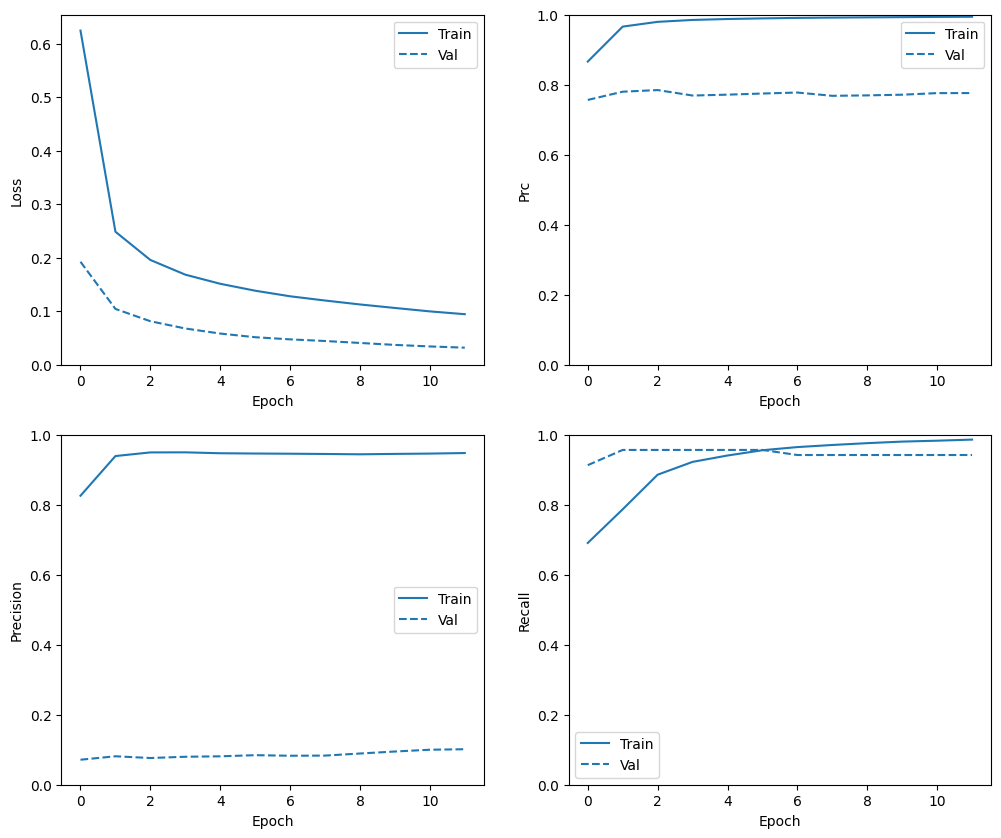

In [50]:
plot_metrics(resampled_history )

### 重新训练


由于在平衡数据上训练更加容易，上面的训练过程可能很快就会过拟合。

因此，请打破周期，使 `callbacks.EarlyStopping` 能够更好地控制停止训练的时间。

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 31s - loss: 2.3586 - tp: 341.0000 - fp: 708.0000 - tn: 45796.0000 - fn: 772.0000 - accuracy: 0.9689 - precision: 0.3251 - recall: 0.3064 - auc: 0.8042 - prc: 0.3184

 5/20 [======>.......................] - ETA: 0s - loss: 2.1916 - tp: 1567.0000 - fp: 1317.0000 - tn: 49299.0000 - fn: 3626.0000 - accuracy: 0.9114 - precision: 0.5433 - recall: 0.3018 - auc: 0.7706 - prc: 0.4349

 7/20 [=========>....................] - ETA: 0s - loss: 2.1376 - tp: 2222.0000 - fp: 1639.0000 - tn: 51053.0000 - fn: 4991.0000 - accuracy: 0.8893 - precision: 0.5755 - recall: 0.3081 - auc: 0.7610 - prc: 0.4634

 9/20 [============>.................] - ETA: 0s - loss: 2.0971 - tp: 2895.0000 - fp: 1953.0000 - tn: 52764.0000 - fn: 6389.0000 - accuracy: 0.8697 - precision: 0.5972 - recall: 0.3118 - auc: 0.7521 - prc: 0.4866

11/20 [===============>..............] - ETA: 0s - loss: 2.0694 - tp: 3605.0000 - fp: 2249.0000 - tn: 54476.0000 - fn: 7767.0000 - accuracy: 0.8529 - precision: 0.6158 - recall: 0.3170 - auc: 0.7433 - prc: 0.5047

13/20 [==================>...........] - ETA: 0s - loss: 2.0243 - tp: 4348.0000 - fp: 2523.0000 - tn: 56248.0000 - fn: 9074.0000 - accuracy: 0.8394 - precision: 0.6328 - recall: 0.3239 - auc: 0.7366 - prc: 0.5222

16/20 [=======================>......] - ETA: 0s - loss: 1.9660 - tp: 5503.0000 - fp: 3027.0000 - tn: 58763.0000 - fn: 11044.0000 - accuracy: 0.8204 - precision: 0.6451 - recall: 0.3326 - auc: 0.7283 - prc: 0.5430

19/20 [===========================>..] - ETA: 0s - loss: 1.9021 - tp: 6740.0000 - fp: 3546.0000 - tn: 61316.0000 - fn: 12879.0000 - accuracy: 0.8056 - precision: 0.6553 - recall: 0.3435 - auc: 0.7222 - prc: 0.5611

20/20 [==============================] - 3s 55ms/step - loss: 1.8818 - tp: 7147.0000 - fp: 3701.0000 - tn: 62207.0000 - fn: 13474.0000 - accuracy: 0.8015 - precision: 0.6588 - recall: 0.3466 - auc: 0.7204 - prc: 0.5663 - val_loss: 0.3562 - val_tp: 18.0000 - val_fp: 3378.0000 - val_tn: 42122.0000 - val_fn: 51.0000 - val_accuracy: 0.9248 - val_precision: 0.0053 - val_recall: 0.2609 - val_auc: 0.5310 - val_prc: 0.0789


Epoch 2/1000


 1/20 [>.............................] - ETA: 0s - loss: 1.5262 - tp: 445.0000 - fp: 180.0000 - tn: 809.0000 - fn: 614.0000 - accuracy: 0.6123 - precision: 0.7120 - recall: 0.4202 - auc: 0.5283 - prc: 0.6932

 4/20 [=====>........................] - ETA: 0s - loss: 1.4618 - tp: 1772.0000 - fp: 706.0000 - tn: 3282.0000 - fn: 2432.0000 - accuracy: 0.6169 - precision: 0.7151 - recall: 0.4215 - auc: 0.5330 - prc: 0.6927

 6/20 [========>.....................] - ETA: 0s - loss: 1.4372 - tp: 2669.0000 - fp: 1085.0000 - tn: 4942.0000 - fn: 3592.0000 - accuracy: 0.6194 - precision: 0.7110 - recall: 0.4263 - auc: 0.5334 - prc: 0.6912

 8/20 [===========>..................] - ETA: 0s - loss: 1.4016 - tp: 3601.0000 - fp: 1466.0000 - tn: 6609.0000 - fn: 4708.0000 - accuracy: 0.6232 - precision: 0.7107 - recall: 0.4334 - auc: 0.5400 - prc: 0.6946

10/20 [==============>...............] - ETA: 0s - loss: 1.3723 - tp: 4513.0000 - fp: 1849.0000 - tn: 8315.0000 - fn: 5803.0000 - accuracy: 0.6264 - precision: 0.7094 - recall: 0.4375 - auc: 0.5436 - prc: 0.6949

13/20 [==================>...........] - ETA: 0s - loss: 1.3289 - tp: 5924.0000 - fp: 2443.0000 - tn: 10886.0000 - fn: 7371.0000 - accuracy: 0.6314 - precision: 0.7080 - recall: 0.4456 - auc: 0.5509 - prc: 0.6976

16/20 [=======================>......] - ETA: 0s - loss: 1.2865 - tp: 7414.0000 - fp: 2992.0000 - tn: 13380.0000 - fn: 8982.0000 - accuracy: 0.6346 - precision: 0.7125 - recall: 0.4522 - auc: 0.5588 - prc: 0.7034

19/20 [===========================>..] - ETA: 0s - loss: 1.2579 - tp: 8953.0000 - fp: 3566.0000 - tn: 15839.0000 - fn: 10554.0000 - accuracy: 0.6371 - precision: 0.7152 - recall: 0.4590 - auc: 0.5649 - prc: 0.7085

20/20 [==============================] - 1s 30ms/step - loss: 1.2506 - tp: 9432.0000 - fp: 3742.0000 - tn: 16690.0000 - fn: 11096.0000 - accuracy: 0.6377 - precision: 0.7160 - recall: 0.4595 - auc: 0.5656 - prc: 0.7088 - val_loss: 0.3813 - val_tp: 46.0000 - val_fp: 4274.0000 - val_tn: 41226.0000 - val_fn: 23.0000 - val_accuracy: 0.9057 - val_precision: 0.0106 - val_recall: 0.6667 - val_auc: 0.7818 - val_prc: 0.3564


Epoch 3/1000


 1/20 [>.............................] - ETA: 0s - loss: 1.0355 - tp: 530.0000 - fp: 195.0000 - tn: 801.0000 - fn: 522.0000 - accuracy: 0.6499 - precision: 0.7310 - recall: 0.5038 - auc: 0.6139 - prc: 0.7476

 4/20 [=====>........................] - ETA: 0s - loss: 1.0138 - tp: 2066.0000 - fp: 794.0000 - tn: 3346.0000 - fn: 1986.0000 - accuracy: 0.6606 - precision: 0.7224 - recall: 0.5099 - auc: 0.6141 - prc: 0.7373

 6/20 [========>.....................] - ETA: 0s - loss: 1.0074 - tp: 3132.0000 - fp: 1231.0000 - tn: 4929.0000 - fn: 2996.0000 - accuracy: 0.6560 - precision: 0.7179 - recall: 0.5111 - auc: 0.6157 - prc: 0.7400

 8/20 [===========>..................] - ETA: 0s - loss: 0.9885 - tp: 4241.0000 - fp: 1665.0000 - tn: 6559.0000 - fn: 3919.0000 - accuracy: 0.6592 - precision: 0.7181 - recall: 0.5197 - auc: 0.6236 - prc: 0.7452

11/20 [===============>..............] - ETA: 0s - loss: 0.9672 - tp: 5879.0000 - fp: 2267.0000 - tn: 9036.0000 - fn: 5346.0000 - accuracy: 0.6621 - precision: 0.7217 - recall: 0.5237 - auc: 0.6285 - prc: 0.7485

14/20 [====================>.........] - ETA: 0s - loss: 0.9441 - tp: 7588.0000 - fp: 2900.0000 - tn: 11465.0000 - fn: 6719.0000 - accuracy: 0.6645 - precision: 0.7235 - recall: 0.5304 - auc: 0.6352 - prc: 0.7532

17/20 [========================>.....] - ETA: 0s - loss: 0.9242 - tp: 9335.0000 - fp: 3551.0000 - tn: 13895.0000 - fn: 8035.0000 - accuracy: 0.6672 - precision: 0.7244 - recall: 0.5374 - auc: 0.6415 - prc: 0.7574

20/20 [==============================] - ETA: 0s - loss: 0.9031 - tp: 11130.0000 - fp: 4216.0000 - tn: 16301.0000 - fn: 9313.0000 - accuracy: 0.6697 - precision: 0.7253 - recall: 0.5444 - auc: 0.6484 - prc: 0.7620

20/20 [==============================] - 1s 30ms/step - loss: 0.9031 - tp: 11130.0000 - fp: 4216.0000 - tn: 16301.0000 - fn: 9313.0000 - accuracy: 0.6697 - precision: 0.7253 - recall: 0.5444 - auc: 0.6484 - prc: 0.7620 - val_loss: 0.3923 - val_tp: 57.0000 - val_fp: 4628.0000 - val_tn: 40872.0000 - val_fn: 12.0000 - val_accuracy: 0.8982 - val_precision: 0.0122 - val_recall: 0.8261 - val_auc: 0.9040 - val_prc: 0.5297


Epoch 4/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.7573 - tp: 637.0000 - fp: 209.0000 - tn: 790.0000 - fn: 412.0000 - accuracy: 0.6968 - precision: 0.7530 - recall: 0.6072 - auc: 0.7049 - prc: 0.8056

 5/20 [======>.......................] - ETA: 0s - loss: 0.7445 - tp: 3115.0000 - fp: 1020.0000 - tn: 4064.0000 - fn: 2041.0000 - accuracy: 0.7011 - precision: 0.7533 - recall: 0.6042 - auc: 0.7050 - prc: 0.8005

 8/20 [===========>..................] - ETA: 0s - loss: 0.7328 - tp: 5005.0000 - fp: 1648.0000 - tn: 6510.0000 - fn: 3221.0000 - accuracy: 0.7028 - precision: 0.7523 - recall: 0.6084 - auc: 0.7110 - prc: 0.8035

11/20 [===============>..............] - ETA: 0s - loss: 0.7137 - tp: 6910.0000 - fp: 2229.0000 - tn: 9033.0000 - fn: 4356.0000 - accuracy: 0.7077 - precision: 0.7561 - recall: 0.6133 - auc: 0.7184 - prc: 0.8074

14/20 [====================>.........] - ETA: 0s - loss: 0.7012 - tp: 8899.0000 - fp: 2817.0000 - tn: 11509.0000 - fn: 5447.0000 - accuracy: 0.7118 - precision: 0.7596 - recall: 0.6203 - auc: 0.7250 - prc: 0.8118

17/20 [========================>.....] - ETA: 0s - loss: 0.6929 - tp: 10919.0000 - fp: 3416.0000 - tn: 13997.0000 - fn: 6484.0000 - accuracy: 0.7156 - precision: 0.7617 - recall: 0.6274 - auc: 0.7298 - prc: 0.8151

20/20 [==============================] - ETA: 0s - loss: 0.6819 - tp: 12966.0000 - fp: 4063.0000 - tn: 16442.0000 - fn: 7489.0000 - accuracy: 0.7180 - precision: 0.7614 - recall: 0.6339 - auc: 0.7355 - prc: 0.8188

20/20 [==============================] - 1s 28ms/step - loss: 0.6819 - tp: 12966.0000 - fp: 4063.0000 - tn: 16442.0000 - fn: 7489.0000 - accuracy: 0.7180 - precision: 0.7614 - recall: 0.6339 - auc: 0.7355 - prc: 0.8188 - val_loss: 0.3901 - val_tp: 60.0000 - val_fp: 4341.0000 - val_tn: 41159.0000 - val_fn: 9.0000 - val_accuracy: 0.9045 - val_precision: 0.0136 - val_recall: 0.8696 - val_auc: 0.9306 - val_prc: 0.6600


Epoch 5/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.6302 - tp: 687.0000 - fp: 213.0000 - tn: 807.0000 - fn: 341.0000 - accuracy: 0.7295 - precision: 0.7633 - recall: 0.6683 - auc: 0.7665 - prc: 0.8408

 5/20 [======>.......................] - ETA: 0s - loss: 0.5897 - tp: 3488.0000 - fp: 1042.0000 - tn: 4098.0000 - fn: 1612.0000 - accuracy: 0.7408 - precision: 0.7700 - recall: 0.6839 - auc: 0.7850 - prc: 0.8518

 8/20 [===========>..................] - ETA: 0s - loss: 0.5875 - tp: 5618.0000 - fp: 1629.0000 - tn: 6582.0000 - fn: 2555.0000 - accuracy: 0.7446 - precision: 0.7752 - recall: 0.6874 - auc: 0.7848 - prc: 0.8518

11/20 [===============>..............] - ETA: 0s - loss: 0.5868 - tp: 7759.0000 - fp: 2242.0000 - tn: 9032.0000 - fn: 3495.0000 - accuracy: 0.7453 - precision: 0.7758 - recall: 0.6894 - auc: 0.7855 - prc: 0.8525

14/20 [====================>.........] - ETA: 0s - loss: 0.5794 - tp: 9903.0000 - fp: 2850.0000 - tn: 11516.0000 - fn: 4403.0000 - accuracy: 0.7470 - precision: 0.7765 - recall: 0.6922 - auc: 0.7882 - prc: 0.8540

17/20 [========================>.....] - ETA: 0s - loss: 0.5682 - tp: 12110.0000 - fp: 3460.0000 - tn: 14012.0000 - fn: 5234.0000 - accuracy: 0.7503 - precision: 0.7778 - recall: 0.6982 - auc: 0.7936 - prc: 0.8572

20/20 [==============================] - ETA: 0s - loss: 0.5618 - tp: 14319.0000 - fp: 4049.0000 - tn: 16518.0000 - fn: 6074.0000 - accuracy: 0.7529 - precision: 0.7796 - recall: 0.7022 - auc: 0.7971 - prc: 0.8594

20/20 [==============================] - 1s 29ms/step - loss: 0.5618 - tp: 14319.0000 - fp: 4049.0000 - tn: 16518.0000 - fn: 6074.0000 - accuracy: 0.7529 - precision: 0.7796 - recall: 0.7022 - auc: 0.7971 - prc: 0.8594 - val_loss: 0.3759 - val_tp: 62.0000 - val_fp: 3600.0000 - val_tn: 41900.0000 - val_fn: 7.0000 - val_accuracy: 0.9208 - val_precision: 0.0169 - val_recall: 0.8986 - val_auc: 0.9432 - val_prc: 0.6929


Epoch 6/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5119 - tp: 749.0000 - fp: 189.0000 - tn: 837.0000 - fn: 273.0000 - accuracy: 0.7744 - precision: 0.7985 - recall: 0.7329 - auc: 0.8254 - prc: 0.8804

 5/20 [======>.......................] - ETA: 0s - loss: 0.5119 - tp: 3775.0000 - fp: 974.0000 - tn: 4161.0000 - fn: 1330.0000 - accuracy: 0.7750 - precision: 0.7949 - recall: 0.7395 - auc: 0.8266 - prc: 0.8798

 8/20 [===========>..................] - ETA: 0s - loss: 0.5041 - tp: 6076.0000 - fp: 1503.0000 - tn: 6639.0000 - fn: 2166.0000 - accuracy: 0.7761 - precision: 0.8017 - recall: 0.7372 - auc: 0.8287 - prc: 0.8823

11/20 [===============>..............] - ETA: 0s - loss: 0.5025 - tp: 8391.0000 - fp: 2080.0000 - tn: 9103.0000 - fn: 2954.0000 - accuracy: 0.7765 - precision: 0.8014 - recall: 0.7396 - auc: 0.8304 - prc: 0.8836

14/20 [====================>.........] - ETA: 0s - loss: 0.4961 - tp: 10709.0000 - fp: 2614.0000 - tn: 11634.0000 - fn: 3715.0000 - accuracy: 0.7793 - precision: 0.8038 - recall: 0.7424 - auc: 0.8340 - prc: 0.8854

17/20 [========================>.....] - ETA: 0s - loss: 0.4922 - tp: 13021.0000 - fp: 3153.0000 - tn: 14164.0000 - fn: 4478.0000 - accuracy: 0.7808 - precision: 0.8051 - recall: 0.7441 - auc: 0.8361 - prc: 0.8866

20/20 [==============================] - ETA: 0s - loss: 0.4880 - tp: 15347.0000 - fp: 3721.0000 - tn: 16696.0000 - fn: 5196.0000 - accuracy: 0.7823 - precision: 0.8049 - recall: 0.7471 - auc: 0.8385 - prc: 0.8877

20/20 [==============================] - 1s 29ms/step - loss: 0.4880 - tp: 15347.0000 - fp: 3721.0000 - tn: 16696.0000 - fn: 5196.0000 - accuracy: 0.7823 - precision: 0.8049 - recall: 0.7471 - auc: 0.8385 - prc: 0.8877 - val_loss: 0.3542 - val_tp: 63.0000 - val_fp: 2857.0000 - val_tn: 42643.0000 - val_fn: 6.0000 - val_accuracy: 0.9372 - val_precision: 0.0216 - val_recall: 0.9130 - val_auc: 0.9539 - val_prc: 0.7195


Epoch 7/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4561 - tp: 785.0000 - fp: 152.0000 - tn: 857.0000 - fn: 254.0000 - accuracy: 0.8018 - precision: 0.8378 - recall: 0.7555 - auc: 0.8514 - prc: 0.8983

 5/20 [======>.......................] - ETA: 0s - loss: 0.4588 - tp: 3931.0000 - fp: 835.0000 - tn: 4242.0000 - fn: 1232.0000 - accuracy: 0.7981 - precision: 0.8248 - recall: 0.7614 - auc: 0.8551 - prc: 0.8992

 8/20 [===========>..................] - ETA: 0s - loss: 0.4549 - tp: 6283.0000 - fp: 1358.0000 - tn: 6804.0000 - fn: 1939.0000 - accuracy: 0.7988 - precision: 0.8223 - recall: 0.7642 - auc: 0.8570 - prc: 0.9002

11/20 [===============>..............] - ETA: 0s - loss: 0.4541 - tp: 8659.0000 - fp: 1842.0000 - tn: 9380.0000 - fn: 2647.0000 - accuracy: 0.8007 - precision: 0.8246 - recall: 0.7659 - auc: 0.8577 - prc: 0.9011

14/20 [====================>.........] - ETA: 0s - loss: 0.4522 - tp: 11020.0000 - fp: 2348.0000 - tn: 11937.0000 - fn: 3367.0000 - accuracy: 0.8007 - precision: 0.8244 - recall: 0.7660 - auc: 0.8587 - prc: 0.9016

17/20 [========================>.....] - ETA: 0s - loss: 0.4501 - tp: 13360.0000 - fp: 2823.0000 - tn: 14559.0000 - fn: 4074.0000 - accuracy: 0.8019 - precision: 0.8256 - recall: 0.7663 - auc: 0.8596 - prc: 0.9020

20/20 [==============================] - ETA: 0s - loss: 0.4461 - tp: 15816.0000 - fp: 3280.0000 - tn: 17103.0000 - fn: 4761.0000 - accuracy: 0.8037 - precision: 0.8282 - recall: 0.7686 - auc: 0.8619 - prc: 0.9038

20/20 [==============================] - 1s 28ms/step - loss: 0.4461 - tp: 15816.0000 - fp: 3280.0000 - tn: 17103.0000 - fn: 4761.0000 - accuracy: 0.8037 - precision: 0.8282 - recall: 0.7686 - auc: 0.8619 - prc: 0.9038 - val_loss: 0.3301 - val_tp: 64.0000 - val_fp: 2195.0000 - val_tn: 43305.0000 - val_fn: 5.0000 - val_accuracy: 0.9517 - val_precision: 0.0283 - val_recall: 0.9275 - val_auc: 0.9639 - val_prc: 0.7314


Epoch 8/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4614 - tp: 755.0000 - fp: 173.0000 - tn: 863.0000 - fn: 257.0000 - accuracy: 0.7900 - precision: 0.8136 - recall: 0.7460 - auc: 0.8549 - prc: 0.8971

 5/20 [======>.......................] - ETA: 0s - loss: 0.4361 - tp: 3881.0000 - fp: 817.0000 - tn: 4379.0000 - fn: 1163.0000 - accuracy: 0.8066 - precision: 0.8261 - recall: 0.7694 - auc: 0.8664 - prc: 0.9044

 8/20 [===========>..................] - ETA: 0s - loss: 0.4357 - tp: 6221.0000 - fp: 1293.0000 - tn: 7007.0000 - fn: 1863.0000 - accuracy: 0.8074 - precision: 0.8279 - recall: 0.7695 - auc: 0.8668 - prc: 0.9051

11/20 [===============>..............] - ETA: 0s - loss: 0.4325 - tp: 8606.0000 - fp: 1706.0000 - tn: 9679.0000 - fn: 2537.0000 - accuracy: 0.8117 - precision: 0.8346 - recall: 0.7723 - auc: 0.8690 - prc: 0.9068

14/20 [====================>.........] - ETA: 0s - loss: 0.4273 - tp: 11064.0000 - fp: 2103.0000 - tn: 12286.0000 - fn: 3219.0000 - accuracy: 0.8144 - precision: 0.8403 - recall: 0.7746 - auc: 0.8722 - prc: 0.9095

17/20 [========================>.....] - ETA: 0s - loss: 0.4216 - tp: 13496.0000 - fp: 2483.0000 - tn: 14975.0000 - fn: 3862.0000 - accuracy: 0.8178 - precision: 0.8446 - recall: 0.7775 - auc: 0.8751 - prc: 0.9116

20/20 [==============================] - ETA: 0s - loss: 0.4191 - tp: 15893.0000 - fp: 2891.0000 - tn: 17619.0000 - fn: 4557.0000 - accuracy: 0.8182 - precision: 0.8461 - recall: 0.7772 - auc: 0.8764 - prc: 0.9124

20/20 [==============================] - 1s 28ms/step - loss: 0.4191 - tp: 15893.0000 - fp: 2891.0000 - tn: 17619.0000 - fn: 4557.0000 - accuracy: 0.8182 - precision: 0.8461 - recall: 0.7772 - auc: 0.8764 - prc: 0.9124 - val_loss: 0.3054 - val_tp: 64.0000 - val_fp: 1742.0000 - val_tn: 43758.0000 - val_fn: 5.0000 - val_accuracy: 0.9617 - val_precision: 0.0354 - val_recall: 0.9275 - val_auc: 0.9734 - val_prc: 0.7366


Epoch 9/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4088 - tp: 835.0000 - fp: 133.0000 - tn: 861.0000 - fn: 219.0000 - accuracy: 0.8281 - precision: 0.8626 - recall: 0.7922 - auc: 0.8840 - prc: 0.9223

 5/20 [======>.......................] - ETA: 0s - loss: 0.3971 - tp: 3988.0000 - fp: 675.0000 - tn: 4491.0000 - fn: 1086.0000 - accuracy: 0.8280 - precision: 0.8552 - recall: 0.7860 - auc: 0.8874 - prc: 0.9185

 8/20 [===========>..................] - ETA: 0s - loss: 0.3954 - tp: 6376.0000 - fp: 1066.0000 - tn: 7199.0000 - fn: 1743.0000 - accuracy: 0.8286 - precision: 0.8568 - recall: 0.7853 - auc: 0.8890 - prc: 0.9193

11/20 [===============>..............] - ETA: 0s - loss: 0.3918 - tp: 8842.0000 - fp: 1488.0000 - tn: 9834.0000 - fn: 2364.0000 - accuracy: 0.8290 - precision: 0.8560 - recall: 0.7890 - auc: 0.8912 - prc: 0.9210

14/20 [====================>.........] - ETA: 0s - loss: 0.3918 - tp: 11238.0000 - fp: 1836.0000 - tn: 12579.0000 - fn: 3019.0000 - accuracy: 0.8307 - precision: 0.8596 - recall: 0.7882 - auc: 0.8916 - prc: 0.9210

17/20 [========================>.....] - ETA: 0s - loss: 0.3918 - tp: 13668.0000 - fp: 2201.0000 - tn: 15257.0000 - fn: 3690.0000 - accuracy: 0.8308 - precision: 0.8613 - recall: 0.7874 - auc: 0.8916 - prc: 0.9211

20/20 [==============================] - ETA: 0s - loss: 0.3895 - tp: 16135.0000 - fp: 2567.0000 - tn: 17914.0000 - fn: 4344.0000 - accuracy: 0.8313 - precision: 0.8627 - recall: 0.7879 - auc: 0.8927 - prc: 0.9221

20/20 [==============================] - 1s 28ms/step - loss: 0.3895 - tp: 16135.0000 - fp: 2567.0000 - tn: 17914.0000 - fn: 4344.0000 - accuracy: 0.8313 - precision: 0.8627 - recall: 0.7879 - auc: 0.8927 - prc: 0.9221 - val_loss: 0.2812 - val_tp: 63.0000 - val_fp: 1410.0000 - val_tn: 44090.0000 - val_fn: 6.0000 - val_accuracy: 0.9689 - val_precision: 0.0428 - val_recall: 0.9130 - val_auc: 0.9811 - val_prc: 0.7399


Epoch 10/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4063 - tp: 819.0000 - fp: 135.0000 - tn: 858.0000 - fn: 236.0000 - accuracy: 0.8188 - precision: 0.8585 - recall: 0.7763 - auc: 0.8828 - prc: 0.9192

 5/20 [======>.......................] - ETA: 0s - loss: 0.3802 - tp: 4036.0000 - fp: 597.0000 - tn: 4495.0000 - fn: 1112.0000 - accuracy: 0.8331 - precision: 0.8711 - recall: 0.7840 - auc: 0.8960 - prc: 0.9253

 8/20 [===========>..................] - ETA: 0s - loss: 0.3776 - tp: 6489.0000 - fp: 987.0000 - tn: 7188.0000 - fn: 1720.0000 - accuracy: 0.8348 - precision: 0.8680 - recall: 0.7905 - auc: 0.8977 - prc: 0.9261

11/20 [===============>..............] - ETA: 0s - loss: 0.3750 - tp: 8943.0000 - fp: 1324.0000 - tn: 9922.0000 - fn: 2339.0000 - accuracy: 0.8374 - precision: 0.8710 - recall: 0.7927 - auc: 0.8997 - prc: 0.9273

14/20 [====================>.........] - ETA: 0s - loss: 0.3747 - tp: 11397.0000 - fp: 1682.0000 - tn: 12610.0000 - fn: 2983.0000 - accuracy: 0.8373 - precision: 0.8714 - recall: 0.7926 - auc: 0.8998 - prc: 0.9276

17/20 [========================>.....] - ETA: 0s - loss: 0.3739 - tp: 13906.0000 - fp: 2040.0000 - tn: 15270.0000 - fn: 3600.0000 - accuracy: 0.8380 - precision: 0.8721 - recall: 0.7944 - auc: 0.9005 - prc: 0.9283

20/20 [==============================] - ETA: 0s - loss: 0.3720 - tp: 16397.0000 - fp: 2348.0000 - tn: 18019.0000 - fn: 4196.0000 - accuracy: 0.8402 - precision: 0.8747 - recall: 0.7962 - auc: 0.9013 - prc: 0.9290

20/20 [==============================] - 1s 28ms/step - loss: 0.3720 - tp: 16397.0000 - fp: 2348.0000 - tn: 18019.0000 - fn: 4196.0000 - accuracy: 0.8402 - precision: 0.8747 - recall: 0.7962 - auc: 0.9013 - prc: 0.9290 - val_loss: 0.2592 - val_tp: 62.0000 - val_fp: 1199.0000 - val_tn: 44301.0000 - val_fn: 7.0000 - val_accuracy: 0.9735 - val_precision: 0.0492 - val_recall: 0.8986 - val_auc: 0.9869 - val_prc: 0.7455


Epoch 11/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3565 - tp: 822.0000 - fp: 109.0000 - tn: 922.0000 - fn: 195.0000 - accuracy: 0.8516 - precision: 0.8829 - recall: 0.8083 - auc: 0.9076 - prc: 0.9331

 5/20 [======>.......................] - ETA: 0s - loss: 0.3532 - tp: 4083.0000 - fp: 516.0000 - tn: 4678.0000 - fn: 963.0000 - accuracy: 0.8556 - precision: 0.8878 - recall: 0.8092 - auc: 0.9119 - prc: 0.9347

 8/20 [===========>..................] - ETA: 0s - loss: 0.3506 - tp: 6564.0000 - fp: 803.0000 - tn: 7464.0000 - fn: 1553.0000 - accuracy: 0.8562 - precision: 0.8910 - recall: 0.8087 - auc: 0.9122 - prc: 0.9356

11/20 [===============>..............] - ETA: 0s - loss: 0.3488 - tp: 9037.0000 - fp: 1107.0000 - tn: 10240.0000 - fn: 2144.0000 - accuracy: 0.8557 - precision: 0.8909 - recall: 0.8082 - auc: 0.9128 - prc: 0.9360

14/20 [====================>.........] - ETA: 0s - loss: 0.3472 - tp: 11516.0000 - fp: 1383.0000 - tn: 13024.0000 - fn: 2749.0000 - accuracy: 0.8559 - precision: 0.8928 - recall: 0.8073 - auc: 0.9136 - prc: 0.9366

17/20 [========================>.....] - ETA: 0s - loss: 0.3464 - tp: 14025.0000 - fp: 1682.0000 - tn: 15777.0000 - fn: 3332.0000 - accuracy: 0.8560 - precision: 0.8929 - recall: 0.8080 - auc: 0.9140 - prc: 0.9368

20/20 [==============================] - ETA: 0s - loss: 0.3445 - tp: 16567.0000 - fp: 1952.0000 - tn: 18519.0000 - fn: 3922.0000 - accuracy: 0.8566 - precision: 0.8946 - recall: 0.8086 - auc: 0.9149 - prc: 0.9377

20/20 [==============================] - 1s 28ms/step - loss: 0.3445 - tp: 16567.0000 - fp: 1952.0000 - tn: 18519.0000 - fn: 3922.0000 - accuracy: 0.8566 - precision: 0.8946 - recall: 0.8086 - auc: 0.9149 - prc: 0.9377 - val_loss: 0.2394 - val_tp: 62.0000 - val_fp: 1050.0000 - val_tn: 44450.0000 - val_fn: 7.0000 - val_accuracy: 0.9768 - val_precision: 0.0558 - val_recall: 0.8986 - val_auc: 0.9902 - val_prc: 0.7474


Epoch 12/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3318 - tp: 809.0000 - fp: 88.0000 - tn: 956.0000 - fn: 195.0000 - accuracy: 0.8618 - precision: 0.9019 - recall: 0.8058 - auc: 0.9202 - prc: 0.9406

 5/20 [======>.......................] - ETA: 0s - loss: 0.3348 - tp: 4121.0000 - fp: 458.0000 - tn: 4615.0000 - fn: 1046.0000 - accuracy: 0.8531 - precision: 0.9000 - recall: 0.7976 - auc: 0.9195 - prc: 0.9413

 8/20 [===========>..................] - ETA: 0s - loss: 0.3350 - tp: 6493.0000 - fp: 694.0000 - tn: 7437.0000 - fn: 1760.0000 - accuracy: 0.8502 - precision: 0.9034 - recall: 0.7867 - auc: 0.9194 - prc: 0.9410

11/20 [===============>..............] - ETA: 0s - loss: 0.3336 - tp: 8829.0000 - fp: 953.0000 - tn: 10294.0000 - fn: 2452.0000 - accuracy: 0.8489 - precision: 0.9026 - recall: 0.7826 - auc: 0.9202 - prc: 0.9407

14/20 [====================>.........] - ETA: 0s - loss: 0.3327 - tp: 11259.0000 - fp: 1183.0000 - tn: 13071.0000 - fn: 3159.0000 - accuracy: 0.8486 - precision: 0.9049 - recall: 0.7809 - auc: 0.9208 - prc: 0.9414

17/20 [========================>.....] - ETA: 0s - loss: 0.3314 - tp: 13617.0000 - fp: 1434.0000 - tn: 15903.0000 - fn: 3862.0000 - accuracy: 0.8479 - precision: 0.9047 - recall: 0.7790 - auc: 0.9214 - prc: 0.9417

20/20 [==============================] - ETA: 0s - loss: 0.3299 - tp: 16021.0000 - fp: 1682.0000 - tn: 18721.0000 - fn: 4536.0000 - accuracy: 0.8482 - precision: 0.9050 - recall: 0.7793 - auc: 0.9221 - prc: 0.9422

20/20 [==============================] - 1s 28ms/step - loss: 0.3299 - tp: 16021.0000 - fp: 1682.0000 - tn: 18721.0000 - fn: 4536.0000 - accuracy: 0.8482 - precision: 0.9050 - recall: 0.7793 - auc: 0.9221 - prc: 0.9422 - val_loss: 0.2220 - val_tp: 62.0000 - val_fp: 946.0000 - val_tn: 44554.0000 - val_fn: 7.0000 - val_accuracy: 0.9791 - val_precision: 0.0615 - val_recall: 0.8986 - val_auc: 0.9922 - val_prc: 0.7511


Epoch 13/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3285 - tp: 812.0000 - fp: 70.0000 - tn: 919.0000 - fn: 247.0000 - accuracy: 0.8452 - precision: 0.9206 - recall: 0.7668 - auc: 0.9228 - prc: 0.9458

 4/20 [=====>........................] - ETA: 0s - loss: 0.3249 - tp: 3177.0000 - fp: 309.0000 - tn: 3717.0000 - fn: 989.0000 - accuracy: 0.8416 - precision: 0.9114 - recall: 0.7626 - auc: 0.9250 - prc: 0.9446

 6/20 [========>.....................] - ETA: 0s - loss: 0.3233 - tp: 4720.0000 - fp: 468.0000 - tn: 5640.0000 - fn: 1460.0000 - accuracy: 0.8431 - precision: 0.9098 - recall: 0.7638 - auc: 0.9255 - prc: 0.9440

 8/20 [===========>..................] - ETA: 0s - loss: 0.3199 - tp: 6346.0000 - fp: 621.0000 - tn: 7482.0000 - fn: 1935.0000 - accuracy: 0.8440 - precision: 0.9109 - recall: 0.7663 - auc: 0.9272 - prc: 0.9453

10/20 [==============>...............] - ETA: 0s - loss: 0.3186 - tp: 7965.0000 - fp: 774.0000 - tn: 9378.0000 - fn: 2363.0000 - accuracy: 0.8468 - precision: 0.9114 - recall: 0.7712 - auc: 0.9274 - prc: 0.9457

12/20 [=================>............] - ETA: 0s - loss: 0.3157 - tp: 9579.0000 - fp: 909.0000 - tn: 11285.0000 - fn: 2803.0000 - accuracy: 0.8490 - precision: 0.9133 - recall: 0.7736 - auc: 0.9287 - prc: 0.9467

14/20 [====================>.........] - ETA: 0s - loss: 0.3157 - tp: 11205.0000 - fp: 1058.0000 - tn: 13180.0000 - fn: 3229.0000 - accuracy: 0.8505 - precision: 0.9137 - recall: 0.7763 - auc: 0.9292 - prc: 0.9470

17/20 [========================>.....] - ETA: 0s - loss: 0.3135 - tp: 13558.0000 - fp: 1272.0000 - tn: 16112.0000 - fn: 3874.0000 - accuracy: 0.8522 - precision: 0.9142 - recall: 0.7778 - auc: 0.9300 - prc: 0.9471

20/20 [==============================] - ETA: 0s - loss: 0.3143 - tp: 15899.0000 - fp: 1497.0000 - tn: 19005.0000 - fn: 4559.0000 - accuracy: 0.8521 - precision: 0.9139 - recall: 0.7772 - auc: 0.9297 - prc: 0.9467

20/20 [==============================] - 1s 32ms/step - loss: 0.3143 - tp: 15899.0000 - fp: 1497.0000 - tn: 19005.0000 - fn: 4559.0000 - accuracy: 0.8521 - precision: 0.9139 - recall: 0.7772 - auc: 0.9297 - prc: 0.9467 - val_loss: 0.2055 - val_tp: 62.0000 - val_fp: 882.0000 - val_tn: 44618.0000 - val_fn: 7.0000 - val_accuracy: 0.9805 - val_precision: 0.0657 - val_recall: 0.8986 - val_auc: 0.9934 - val_prc: 0.7536


Epoch 14/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3191 - tp: 778.0000 - fp: 67.0000 - tn: 967.0000 - fn: 236.0000 - accuracy: 0.8521 - precision: 0.9207 - recall: 0.7673 - auc: 0.9250 - prc: 0.9441

 5/20 [======>.......................] - ETA: 0s - loss: 0.3084 - tp: 3997.0000 - fp: 362.0000 - tn: 4714.0000 - fn: 1167.0000 - accuracy: 0.8507 - precision: 0.9170 - recall: 0.7740 - auc: 0.9315 - prc: 0.9487

 8/20 [===========>..................] - ETA: 0s - loss: 0.3104 - tp: 6402.0000 - fp: 579.0000 - tn: 7544.0000 - fn: 1859.0000 - accuracy: 0.8512 - precision: 0.9171 - recall: 0.7750 - auc: 0.9306 - prc: 0.9480

10/20 [==============>...............] - ETA: 0s - loss: 0.3088 - tp: 8002.0000 - fp: 711.0000 - tn: 9481.0000 - fn: 2286.0000 - accuracy: 0.8537 - precision: 0.9184 - recall: 0.7778 - auc: 0.9317 - prc: 0.9484

13/20 [==================>...........] - ETA: 0s - loss: 0.3079 - tp: 10409.0000 - fp: 917.0000 - tn: 12302.0000 - fn: 2996.0000 - accuracy: 0.8530 - precision: 0.9190 - recall: 0.7765 - auc: 0.9322 - prc: 0.9489

16/20 [=======================>......] - ETA: 0s - loss: 0.3091 - tp: 12762.0000 - fp: 1144.0000 - tn: 15191.0000 - fn: 3671.0000 - accuracy: 0.8531 - precision: 0.9177 - recall: 0.7766 - auc: 0.9319 - prc: 0.9484

19/20 [===========================>..] - ETA: 0s - loss: 0.3089 - tp: 15183.0000 - fp: 1377.0000 - tn: 17994.0000 - fn: 4358.0000 - accuracy: 0.8526 - precision: 0.9168 - recall: 0.7770 - auc: 0.9325 - prc: 0.9487

20/20 [==============================] - 1s 30ms/step - loss: 0.3082 - tp: 15953.0000 - fp: 1450.0000 - tn: 18984.0000 - fn: 4573.0000 - accuracy: 0.8530 - precision: 0.9167 - recall: 0.7772 - auc: 0.9327 - prc: 0.9487 - val_loss: 0.1903 - val_tp: 63.0000 - val_fp: 806.0000 - val_tn: 44694.0000 - val_fn: 6.0000 - val_accuracy: 0.9822 - val_precision: 0.0725 - val_recall: 0.9130 - val_auc: 0.9942 - val_prc: 0.7563


Epoch 15/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2996 - tp: 820.0000 - fp: 67.0000 - tn: 931.0000 - fn: 230.0000 - accuracy: 0.8550 - precision: 0.9245 - recall: 0.7810 - auc: 0.9341 - prc: 0.9525

 5/20 [======>.......................] - ETA: 0s - loss: 0.2965 - tp: 3976.0000 - fp: 316.0000 - tn: 4802.0000 - fn: 1146.0000 - accuracy: 0.8572 - precision: 0.9264 - recall: 0.7763 - auc: 0.9368 - prc: 0.9517

 8/20 [===========>..................] - ETA: 0s - loss: 0.2971 - tp: 6327.0000 - fp: 529.0000 - tn: 7673.0000 - fn: 1855.0000 - accuracy: 0.8545 - precision: 0.9228 - recall: 0.7733 - auc: 0.9366 - prc: 0.9510

11/20 [===============>..............] - ETA: 0s - loss: 0.2973 - tp: 8724.0000 - fp: 706.0000 - tn: 10544.0000 - fn: 2554.0000 - accuracy: 0.8553 - precision: 0.9251 - recall: 0.7735 - auc: 0.9368 - prc: 0.9514

14/20 [====================>.........] - ETA: 0s - loss: 0.2970 - tp: 11143.0000 - fp: 898.0000 - tn: 13402.0000 - fn: 3229.0000 - accuracy: 0.8561 - precision: 0.9254 - recall: 0.7753 - auc: 0.9372 - prc: 0.9518

17/20 [========================>.....] - ETA: 0s - loss: 0.2968 - tp: 13571.0000 - fp: 1094.0000 - tn: 16234.0000 - fn: 3917.0000 - accuracy: 0.8561 - precision: 0.9254 - recall: 0.7760 - auc: 0.9373 - prc: 0.9520

20/20 [==============================] - ETA: 0s - loss: 0.2970 - tp: 15952.0000 - fp: 1287.0000 - tn: 19055.0000 - fn: 4666.0000 - accuracy: 0.8547 - precision: 0.9253 - recall: 0.7737 - auc: 0.9373 - prc: 0.9520

20/20 [==============================] - 1s 29ms/step - loss: 0.2970 - tp: 15952.0000 - fp: 1287.0000 - tn: 19055.0000 - fn: 4666.0000 - accuracy: 0.8547 - precision: 0.9253 - recall: 0.7737 - auc: 0.9373 - prc: 0.9520 - val_loss: 0.1775 - val_tp: 63.0000 - val_fp: 774.0000 - val_tn: 44726.0000 - val_fn: 6.0000 - val_accuracy: 0.9829 - val_precision: 0.0753 - val_recall: 0.9130 - val_auc: 0.9949 - val_prc: 0.7595


Epoch 16/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3038 - tp: 770.0000 - fp: 66.0000 - tn: 961.0000 - fn: 251.0000 - accuracy: 0.8452 - precision: 0.9211 - recall: 0.7542 - auc: 0.9331 - prc: 0.9459

 5/20 [======>.......................] - ETA: 0s - loss: 0.2890 - tp: 3921.0000 - fp: 333.0000 - tn: 4848.0000 - fn: 1138.0000 - accuracy: 0.8563 - precision: 0.9217 - recall: 0.7751 - auc: 0.9394 - prc: 0.9519

 8/20 [===========>..................] - ETA: 0s - loss: 0.2898 - tp: 6248.0000 - fp: 527.0000 - tn: 7768.0000 - fn: 1841.0000 - accuracy: 0.8555 - precision: 0.9222 - recall: 0.7724 - auc: 0.9400 - prc: 0.9521

11/20 [===============>..............] - ETA: 0s - loss: 0.2877 - tp: 8586.0000 - fp: 708.0000 - tn: 10748.0000 - fn: 2486.0000 - accuracy: 0.8582 - precision: 0.9238 - recall: 0.7755 - auc: 0.9407 - prc: 0.9525

14/20 [====================>.........] - ETA: 0s - loss: 0.2860 - tp: 10929.0000 - fp: 887.0000 - tn: 13709.0000 - fn: 3147.0000 - accuracy: 0.8593 - precision: 0.9249 - recall: 0.7764 - auc: 0.9417 - prc: 0.9531

17/20 [========================>.....] - ETA: 0s - loss: 0.2844 - tp: 13310.0000 - fp: 1045.0000 - tn: 16643.0000 - fn: 3818.0000 - accuracy: 0.8603 - precision: 0.9272 - recall: 0.7771 - auc: 0.9426 - prc: 0.9540

20/20 [==============================] - ETA: 0s - loss: 0.2834 - tp: 15633.0000 - fp: 1229.0000 - tn: 19595.0000 - fn: 4503.0000 - accuracy: 0.8601 - precision: 0.9271 - recall: 0.7764 - auc: 0.9431 - prc: 0.9542

20/20 [==============================] - 1s 29ms/step - loss: 0.2834 - tp: 15633.0000 - fp: 1229.0000 - tn: 19595.0000 - fn: 4503.0000 - accuracy: 0.8601 - precision: 0.9271 - recall: 0.7764 - auc: 0.9431 - prc: 0.9542 - val_loss: 0.1665 - val_tp: 63.0000 - val_fp: 754.0000 - val_tn: 44746.0000 - val_fn: 6.0000 - val_accuracy: 0.9833 - val_precision: 0.0771 - val_recall: 0.9130 - val_auc: 0.9953 - val_prc: 0.7615


Epoch 17/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2813 - tp: 784.0000 - fp: 53.0000 - tn: 980.0000 - fn: 231.0000 - accuracy: 0.8613 - precision: 0.9367 - recall: 0.7724 - auc: 0.9463 - prc: 0.9568

 5/20 [======>.......................] - ETA: 0s - loss: 0.2754 - tp: 4014.0000 - fp: 290.0000 - tn: 4804.0000 - fn: 1132.0000 - accuracy: 0.8611 - precision: 0.9326 - recall: 0.7800 - auc: 0.9475 - prc: 0.9590

 8/20 [===========>..................] - ETA: 0s - loss: 0.2778 - tp: 6334.0000 - fp: 472.0000 - tn: 7749.0000 - fn: 1829.0000 - accuracy: 0.8596 - precision: 0.9306 - recall: 0.7759 - auc: 0.9470 - prc: 0.9576

11/20 [===============>..............] - ETA: 0s - loss: 0.2773 - tp: 8699.0000 - fp: 651.0000 - tn: 10662.0000 - fn: 2516.0000 - accuracy: 0.8594 - precision: 0.9304 - recall: 0.7757 - auc: 0.9471 - prc: 0.9576

14/20 [====================>.........] - ETA: 0s - loss: 0.2768 - tp: 11096.0000 - fp: 816.0000 - tn: 13574.0000 - fn: 3186.0000 - accuracy: 0.8604 - precision: 0.9315 - recall: 0.7769 - auc: 0.9472 - prc: 0.9579

17/20 [========================>.....] - ETA: 0s - loss: 0.2760 - tp: 13426.0000 - fp: 1007.0000 - tn: 16528.0000 - fn: 3855.0000 - accuracy: 0.8604 - precision: 0.9302 - recall: 0.7769 - auc: 0.9475 - prc: 0.9578

20/20 [==============================] - ETA: 0s - loss: 0.2778 - tp: 15809.0000 - fp: 1186.0000 - tn: 19384.0000 - fn: 4581.0000 - accuracy: 0.8592 - precision: 0.9302 - recall: 0.7753 - auc: 0.9469 - prc: 0.9576

20/20 [==============================] - 1s 29ms/step - loss: 0.2778 - tp: 15809.0000 - fp: 1186.0000 - tn: 19384.0000 - fn: 4581.0000 - accuracy: 0.8592 - precision: 0.9302 - recall: 0.7753 - auc: 0.9469 - prc: 0.9576 - val_loss: 0.1567 - val_tp: 63.0000 - val_fp: 738.0000 - val_tn: 44762.0000 - val_fn: 6.0000 - val_accuracy: 0.9837 - val_precision: 0.0787 - val_recall: 0.9130 - val_auc: 0.9957 - val_prc: 0.7651


Epoch 18/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2634 - tp: 778.0000 - fp: 52.0000 - tn: 1012.0000 - fn: 206.0000 - accuracy: 0.8740 - precision: 0.9373 - recall: 0.7907 - auc: 0.9533 - prc: 0.9591

 5/20 [======>.......................] - ETA: 0s - loss: 0.2744 - tp: 4033.0000 - fp: 287.0000 - tn: 4789.0000 - fn: 1131.0000 - accuracy: 0.8615 - precision: 0.9336 - recall: 0.7810 - auc: 0.9494 - prc: 0.9598

 8/20 [===========>..................] - ETA: 0s - loss: 0.2743 - tp: 6423.0000 - fp: 487.0000 - tn: 7669.0000 - fn: 1805.0000 - accuracy: 0.8601 - precision: 0.9295 - recall: 0.7806 - auc: 0.9492 - prc: 0.9590

11/20 [===============>..............] - ETA: 0s - loss: 0.2759 - tp: 8807.0000 - fp: 670.0000 - tn: 10546.0000 - fn: 2505.0000 - accuracy: 0.8591 - precision: 0.9293 - recall: 0.7786 - auc: 0.9484 - prc: 0.9586

14/20 [====================>.........] - ETA: 0s - loss: 0.2737 - tp: 11134.0000 - fp: 831.0000 - tn: 13527.0000 - fn: 3180.0000 - accuracy: 0.8601 - precision: 0.9305 - recall: 0.7778 - auc: 0.9493 - prc: 0.9588

17/20 [========================>.....] - ETA: 0s - loss: 0.2710 - tp: 13558.0000 - fp: 975.0000 - tn: 16447.0000 - fn: 3836.0000 - accuracy: 0.8618 - precision: 0.9329 - recall: 0.7795 - auc: 0.9502 - prc: 0.9597

20/20 [==============================] - ETA: 0s - loss: 0.2702 - tp: 15965.0000 - fp: 1113.0000 - tn: 19348.0000 - fn: 4534.0000 - accuracy: 0.8621 - precision: 0.9348 - recall: 0.7788 - auc: 0.9508 - prc: 0.9601

20/20 [==============================] - 1s 30ms/step - loss: 0.2702 - tp: 15965.0000 - fp: 1113.0000 - tn: 19348.0000 - fn: 4534.0000 - accuracy: 0.8621 - precision: 0.9348 - recall: 0.7788 - auc: 0.9508 - prc: 0.9601 - val_loss: 0.1489 - val_tp: 63.0000 - val_fp: 738.0000 - val_tn: 44762.0000 - val_fn: 6.0000 - val_accuracy: 0.9837 - val_precision: 0.0787 - val_recall: 0.9130 - val_auc: 0.9960 - val_prc: 0.7679


Epoch 19/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2717 - tp: 787.0000 - fp: 61.0000 - tn: 972.0000 - fn: 228.0000 - accuracy: 0.8589 - precision: 0.9281 - recall: 0.7754 - auc: 0.9494 - prc: 0.9589

 5/20 [======>.......................] - ETA: 0s - loss: 0.2589 - tp: 4059.0000 - fp: 278.0000 - tn: 4830.0000 - fn: 1073.0000 - accuracy: 0.8681 - precision: 0.9359 - recall: 0.7909 - auc: 0.9546 - prc: 0.9631

 8/20 [===========>..................] - ETA: 0s - loss: 0.2608 - tp: 6413.0000 - fp: 455.0000 - tn: 7783.0000 - fn: 1733.0000 - accuracy: 0.8665 - precision: 0.9338 - recall: 0.7873 - auc: 0.9543 - prc: 0.9622

11/20 [===============>..............] - ETA: 0s - loss: 0.2591 - tp: 8838.0000 - fp: 615.0000 - tn: 10660.0000 - fn: 2415.0000 - accuracy: 0.8655 - precision: 0.9349 - recall: 0.7854 - auc: 0.9552 - prc: 0.9631

14/20 [====================>.........] - ETA: 0s - loss: 0.2580 - tp: 11231.0000 - fp: 765.0000 - tn: 13606.0000 - fn: 3070.0000 - accuracy: 0.8662 - precision: 0.9362 - recall: 0.7853 - auc: 0.9554 - prc: 0.9633

17/20 [========================>.....] - ETA: 0s - loss: 0.2579 - tp: 13659.0000 - fp: 913.0000 - tn: 16495.0000 - fn: 3749.0000 - accuracy: 0.8661 - precision: 0.9373 - recall: 0.7846 - auc: 0.9556 - prc: 0.9636

20/20 [==============================] - ETA: 0s - loss: 0.2586 - tp: 16031.0000 - fp: 1081.0000 - tn: 19414.0000 - fn: 4434.0000 - accuracy: 0.8654 - precision: 0.9368 - recall: 0.7833 - auc: 0.9553 - prc: 0.9633

20/20 [==============================] - 1s 29ms/step - loss: 0.2586 - tp: 16031.0000 - fp: 1081.0000 - tn: 19414.0000 - fn: 4434.0000 - accuracy: 0.8654 - precision: 0.9368 - recall: 0.7833 - auc: 0.9553 - prc: 0.9633 - val_loss: 0.1420 - val_tp: 63.0000 - val_fp: 746.0000 - val_tn: 44754.0000 - val_fn: 6.0000 - val_accuracy: 0.9835 - val_precision: 0.0779 - val_recall: 0.9130 - val_auc: 0.9961 - val_prc: 0.7724


Epoch 20/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2465 - tp: 807.0000 - fp: 48.0000 - tn: 982.0000 - fn: 211.0000 - accuracy: 0.8735 - precision: 0.9439 - recall: 0.7927 - auc: 0.9591 - prc: 0.9667

 4/20 [=====>........................] - ETA: 0s - loss: 0.2535 - tp: 3180.0000 - fp: 206.0000 - tn: 3942.0000 - fn: 864.0000 - accuracy: 0.8694 - precision: 0.9392 - recall: 0.7864 - auc: 0.9575 - prc: 0.9641

 6/20 [========>.....................] - ETA: 0s - loss: 0.2566 - tp: 4787.0000 - fp: 305.0000 - tn: 5876.0000 - fn: 1320.0000 - accuracy: 0.8678 - precision: 0.9401 - recall: 0.7839 - auc: 0.9564 - prc: 0.9636

 9/20 [============>.................] - ETA: 0s - loss: 0.2591 - tp: 7135.0000 - fp: 479.0000 - tn: 8804.0000 - fn: 2014.0000 - accuracy: 0.8647 - precision: 0.9371 - recall: 0.7799 - auc: 0.9557 - prc: 0.9626

12/20 [=================>............] - ETA: 0s - loss: 0.2597 - tp: 9541.0000 - fp: 639.0000 - tn: 11716.0000 - fn: 2680.0000 - accuracy: 0.8649 - precision: 0.9372 - recall: 0.7807 - auc: 0.9559 - prc: 0.9628

15/20 [=====================>........] - ETA: 0s - loss: 0.2580 - tp: 11985.0000 - fp: 789.0000 - tn: 14604.0000 - fn: 3342.0000 - accuracy: 0.8655 - precision: 0.9382 - recall: 0.7820 - auc: 0.9563 - prc: 0.9635

17/20 [========================>.....] - ETA: 0s - loss: 0.2573 - tp: 13619.0000 - fp: 877.0000 - tn: 16512.0000 - fn: 3808.0000 - accuracy: 0.8654 - precision: 0.9395 - recall: 0.7815 - auc: 0.9566 - prc: 0.9640

19/20 [===========================>..] - ETA: 0s - loss: 0.2563 - tp: 15234.0000 - fp: 982.0000 - tn: 18449.0000 - fn: 4247.0000 - accuracy: 0.8656 - precision: 0.9394 - recall: 0.7820 - auc: 0.9569 - prc: 0.9642

20/20 [==============================] - 1s 31ms/step - loss: 0.2562 - tp: 16026.0000 - fp: 1043.0000 - tn: 19414.0000 - fn: 4477.0000 - accuracy: 0.8652 - precision: 0.9389 - recall: 0.7816 - auc: 0.9569 - prc: 0.9641 - val_loss: 0.1360 - val_tp: 64.0000 - val_fp: 744.0000 - val_tn: 44756.0000 - val_fn: 5.0000 - val_accuracy: 0.9836 - val_precision: 0.0792 - val_recall: 0.9275 - val_auc: 0.9962 - val_prc: 0.7750


Epoch 21/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2473 - tp: 791.0000 - fp: 51.0000 - tn: 987.0000 - fn: 219.0000 - accuracy: 0.8682 - precision: 0.9394 - recall: 0.7832 - auc: 0.9600 - prc: 0.9659

 5/20 [======>.......................] - ETA: 0s - loss: 0.2509 - tp: 3951.0000 - fp: 269.0000 - tn: 4912.0000 - fn: 1108.0000 - accuracy: 0.8655 - precision: 0.9363 - recall: 0.7810 - auc: 0.9589 - prc: 0.9648

 8/20 [===========>..................] - ETA: 0s - loss: 0.2480 - tp: 6390.0000 - fp: 401.0000 - tn: 7822.0000 - fn: 1771.0000 - accuracy: 0.8674 - precision: 0.9410 - recall: 0.7830 - auc: 0.9599 - prc: 0.9662

11/20 [===============>..............] - ETA: 0s - loss: 0.2471 - tp: 8813.0000 - fp: 551.0000 - tn: 10755.0000 - fn: 2409.0000 - accuracy: 0.8686 - precision: 0.9412 - recall: 0.7853 - auc: 0.9601 - prc: 0.9665

14/20 [====================>.........] - ETA: 0s - loss: 0.2476 - tp: 11235.0000 - fp: 721.0000 - tn: 13639.0000 - fn: 3077.0000 - accuracy: 0.8675 - precision: 0.9397 - recall: 0.7850 - auc: 0.9601 - prc: 0.9665

17/20 [========================>.....] - ETA: 0s - loss: 0.2469 - tp: 13621.0000 - fp: 860.0000 - tn: 16616.0000 - fn: 3719.0000 - accuracy: 0.8685 - precision: 0.9406 - recall: 0.7855 - auc: 0.9603 - prc: 0.9666

20/20 [==============================] - ETA: 0s - loss: 0.2461 - tp: 16002.0000 - fp: 1012.0000 - tn: 19574.0000 - fn: 4372.0000 - accuracy: 0.8686 - precision: 0.9405 - recall: 0.7854 - auc: 0.9604 - prc: 0.9667

20/20 [==============================] - 1s 30ms/step - loss: 0.2461 - tp: 16002.0000 - fp: 1012.0000 - tn: 19574.0000 - fn: 4372.0000 - accuracy: 0.8686 - precision: 0.9405 - recall: 0.7854 - auc: 0.9604 - prc: 0.9667 - val_loss: 0.1305 - val_tp: 64.0000 - val_fp: 743.0000 - val_tn: 44757.0000 - val_fn: 5.0000 - val_accuracy: 0.9836 - val_precision: 0.0793 - val_recall: 0.9275 - val_auc: 0.9962 - val_prc: 0.7679


Epoch 22/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2312 - tp: 832.0000 - fp: 45.0000 - tn: 949.0000 - fn: 222.0000 - accuracy: 0.8696 - precision: 0.9487 - recall: 0.7894 - auc: 0.9682 - prc: 0.9732

 4/20 [=====>........................] - ETA: 0s - loss: 0.2384 - tp: 3243.0000 - fp: 197.0000 - tn: 3884.0000 - fn: 868.0000 - accuracy: 0.8700 - precision: 0.9427 - recall: 0.7889 - auc: 0.9632 - prc: 0.9690

 6/20 [========>.....................] - ETA: 0s - loss: 0.2441 - tp: 4859.0000 - fp: 316.0000 - tn: 5801.0000 - fn: 1312.0000 - accuracy: 0.8675 - precision: 0.9389 - recall: 0.7874 - auc: 0.9619 - prc: 0.9679

 8/20 [===========>..................] - ETA: 0s - loss: 0.2429 - tp: 6485.0000 - fp: 404.0000 - tn: 7734.0000 - fn: 1761.0000 - accuracy: 0.8679 - precision: 0.9414 - recall: 0.7864 - auc: 0.9622 - prc: 0.9683

10/20 [==============>...............] - ETA: 0s - loss: 0.2441 - tp: 8073.0000 - fp: 494.0000 - tn: 9726.0000 - fn: 2187.0000 - accuracy: 0.8691 - precision: 0.9423 - recall: 0.7868 - auc: 0.9621 - prc: 0.9679

12/20 [=================>............] - ETA: 0s - loss: 0.2425 - tp: 9680.0000 - fp: 581.0000 - tn: 11694.0000 - fn: 2621.0000 - accuracy: 0.8697 - precision: 0.9434 - recall: 0.7869 - auc: 0.9626 - prc: 0.9683

14/20 [====================>.........] - ETA: 0s - loss: 0.2425 - tp: 11320.0000 - fp: 680.0000 - tn: 13616.0000 - fn: 3056.0000 - accuracy: 0.8697 - precision: 0.9433 - recall: 0.7874 - auc: 0.9626 - prc: 0.9683

16/20 [=======================>......] - ETA: 0s - loss: 0.2427 - tp: 12922.0000 - fp: 777.0000 - tn: 15548.0000 - fn: 3521.0000 - accuracy: 0.8688 - precision: 0.9433 - recall: 0.7859 - auc: 0.9625 - prc: 0.9683

18/20 [==========================>...] - ETA: 0s - loss: 0.2422 - tp: 14552.0000 - fp: 870.0000 - tn: 17476.0000 - fn: 3966.0000 - accuracy: 0.8688 - precision: 0.9436 - recall: 0.7858 - auc: 0.9626 - prc: 0.9685

20/20 [==============================] - ETA: 0s - loss: 0.2421 - tp: 16160.0000 - fp: 973.0000 - tn: 19431.0000 - fn: 4396.0000 - accuracy: 0.8689 - precision: 0.9432 - recall: 0.7861 - auc: 0.9627 - prc: 0.9685

20/20 [==============================] - 1s 34ms/step - loss: 0.2421 - tp: 16160.0000 - fp: 973.0000 - tn: 19431.0000 - fn: 4396.0000 - accuracy: 0.8689 - precision: 0.9432 - recall: 0.7861 - auc: 0.9627 - prc: 0.9685 - val_loss: 0.1254 - val_tp: 64.0000 - val_fp: 743.0000 - val_tn: 44757.0000 - val_fn: 5.0000 - val_accuracy: 0.9836 - val_precision: 0.0793 - val_recall: 0.9275 - val_auc: 0.9962 - val_prc: 0.7700


Epoch 23/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2403 - tp: 793.0000 - fp: 55.0000 - tn: 992.0000 - fn: 208.0000 - accuracy: 0.8716 - precision: 0.9351 - recall: 0.7922 - auc: 0.9616 - prc: 0.9666

 5/20 [======>.......................] - ETA: 0s - loss: 0.2405 - tp: 3953.0000 - fp: 247.0000 - tn: 4954.0000 - fn: 1086.0000 - accuracy: 0.8698 - precision: 0.9412 - recall: 0.7845 - auc: 0.9630 - prc: 0.9678

 8/20 [===========>..................] - ETA: 0s - loss: 0.2406 - tp: 6381.0000 - fp: 405.0000 - tn: 7843.0000 - fn: 1755.0000 - accuracy: 0.8682 - precision: 0.9403 - recall: 0.7843 - auc: 0.9629 - prc: 0.9680

11/20 [===============>..............] - ETA: 0s - loss: 0.2380 - tp: 8833.0000 - fp: 535.0000 - tn: 10761.0000 - fn: 2399.0000 - accuracy: 0.8698 - precision: 0.9429 - recall: 0.7864 - auc: 0.9639 - prc: 0.9690

14/20 [====================>.........] - ETA: 0s - loss: 0.2364 - tp: 11234.0000 - fp: 683.0000 - tn: 13707.0000 - fn: 3048.0000 - accuracy: 0.8699 - precision: 0.9427 - recall: 0.7866 - auc: 0.9646 - prc: 0.9694

17/20 [========================>.....] - ETA: 0s - loss: 0.2358 - tp: 13579.0000 - fp: 834.0000 - tn: 16719.0000 - fn: 3684.0000 - accuracy: 0.8702 - precision: 0.9421 - recall: 0.7866 - auc: 0.9647 - prc: 0.9693

20/20 [==============================] - ETA: 0s - loss: 0.2362 - tp: 16012.0000 - fp: 998.0000 - tn: 19606.0000 - fn: 4344.0000 - accuracy: 0.8696 - precision: 0.9413 - recall: 0.7866 - auc: 0.9645 - prc: 0.9693

20/20 [==============================] - 1s 29ms/step - loss: 0.2362 - tp: 16012.0000 - fp: 998.0000 - tn: 19606.0000 - fn: 4344.0000 - accuracy: 0.8696 - precision: 0.9413 - recall: 0.7866 - auc: 0.9645 - prc: 0.9693 - val_loss: 0.1207 - val_tp: 65.0000 - val_fp: 744.0000 - val_tn: 44756.0000 - val_fn: 4.0000 - val_accuracy: 0.9836 - val_precision: 0.0803 - val_recall: 0.9420 - val_auc: 0.9962 - val_prc: 0.7720


Epoch 24/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2282 - tp: 829.0000 - fp: 51.0000 - tn: 972.0000 - fn: 196.0000 - accuracy: 0.8794 - precision: 0.9420 - recall: 0.8088 - auc: 0.9664 - prc: 0.9714

 4/20 [=====>........................] - ETA: 0s - loss: 0.2303 - tp: 3277.0000 - fp: 183.0000 - tn: 3901.0000 - fn: 831.0000 - accuracy: 0.8762 - precision: 0.9471 - recall: 0.7977 - auc: 0.9667 - prc: 0.9711

 6/20 [========>.....................] - ETA: 0s - loss: 0.2284 - tp: 4851.0000 - fp: 274.0000 - tn: 5913.0000 - fn: 1250.0000 - accuracy: 0.8760 - precision: 0.9465 - recall: 0.7951 - auc: 0.9677 - prc: 0.9714

 8/20 [===========>..................] - ETA: 0s - loss: 0.2289 - tp: 6509.0000 - fp: 355.0000 - tn: 7828.0000 - fn: 1692.0000 - accuracy: 0.8751 - precision: 0.9483 - recall: 0.7937 - auc: 0.9677 - prc: 0.9717

10/20 [==============>...............] - ETA: 0s - loss: 0.2280 - tp: 8168.0000 - fp: 445.0000 - tn: 9766.0000 - fn: 2101.0000 - accuracy: 0.8757 - precision: 0.9483 - recall: 0.7954 - auc: 0.9681 - prc: 0.9721

12/20 [=================>............] - ETA: 0s - loss: 0.2280 - tp: 9806.0000 - fp: 537.0000 - tn: 11715.0000 - fn: 2518.0000 - accuracy: 0.8757 - precision: 0.9481 - recall: 0.7957 - auc: 0.9679 - prc: 0.9721

14/20 [====================>.........] - ETA: 0s - loss: 0.2277 - tp: 11424.0000 - fp: 637.0000 - tn: 13660.0000 - fn: 2951.0000 - accuracy: 0.8749 - precision: 0.9472 - recall: 0.7947 - auc: 0.9679 - prc: 0.9721

16/20 [=======================>......] - ETA: 0s - loss: 0.2282 - tp: 13064.0000 - fp: 723.0000 - tn: 15605.0000 - fn: 3376.0000 - accuracy: 0.8749 - precision: 0.9476 - recall: 0.7946 - auc: 0.9677 - prc: 0.9720

18/20 [==========================>...] - ETA: 0s - loss: 0.2292 - tp: 14678.0000 - fp: 808.0000 - tn: 17537.0000 - fn: 3841.0000 - accuracy: 0.8739 - precision: 0.9478 - recall: 0.7926 - auc: 0.9675 - prc: 0.9718

20/20 [==============================] - ETA: 0s - loss: 0.2289 - tp: 16312.0000 - fp: 884.0000 - tn: 19492.0000 - fn: 4272.0000 - accuracy: 0.8741 - precision: 0.9486 - recall: 0.7925 - auc: 0.9675 - prc: 0.9719

20/20 [==============================] - 1s 34ms/step - loss: 0.2289 - tp: 16312.0000 - fp: 884.0000 - tn: 19492.0000 - fn: 4272.0000 - accuracy: 0.8741 - precision: 0.9486 - recall: 0.7925 - auc: 0.9675 - prc: 0.9719 - val_loss: 0.1163 - val_tp: 65.0000 - val_fp: 739.0000 - val_tn: 44761.0000 - val_fn: 4.0000 - val_accuracy: 0.9837 - val_precision: 0.0808 - val_recall: 0.9420 - val_auc: 0.9962 - val_prc: 0.7738


Epoch 25/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2191 - tp: 772.0000 - fp: 46.0000 - tn: 1025.0000 - fn: 205.0000 - accuracy: 0.8774 - precision: 0.9438 - recall: 0.7902 - auc: 0.9714 - prc: 0.9726

 4/20 [=====>........................] - ETA: 0s - loss: 0.2237 - tp: 3231.0000 - fp: 176.0000 - tn: 3928.0000 - fn: 857.0000 - accuracy: 0.8739 - precision: 0.9483 - recall: 0.7904 - auc: 0.9695 - prc: 0.9734

 6/20 [========>.....................] - ETA: 0s - loss: 0.2250 - tp: 4903.0000 - fp: 263.0000 - tn: 5834.0000 - fn: 1288.0000 - accuracy: 0.8738 - precision: 0.9491 - recall: 0.7920 - auc: 0.9690 - prc: 0.9734

 9/20 [============>.................] - ETA: 0s - loss: 0.2259 - tp: 7361.0000 - fp: 397.0000 - tn: 8738.0000 - fn: 1936.0000 - accuracy: 0.8734 - precision: 0.9488 - recall: 0.7918 - auc: 0.9690 - prc: 0.9733

12/20 [=================>............] - ETA: 0s - loss: 0.2260 - tp: 9798.0000 - fp: 535.0000 - tn: 11670.0000 - fn: 2573.0000 - accuracy: 0.8735 - precision: 0.9482 - recall: 0.7920 - auc: 0.9690 - prc: 0.9732

15/20 [=====================>........] - ETA: 0s - loss: 0.2263 - tp: 12279.0000 - fp: 656.0000 - tn: 14560.0000 - fn: 3225.0000 - accuracy: 0.8737 - precision: 0.9493 - recall: 0.7920 - auc: 0.9689 - prc: 0.9732

18/20 [==========================>...] - ETA: 0s - loss: 0.2250 - tp: 14753.0000 - fp: 806.0000 - tn: 17478.0000 - fn: 3827.0000 - accuracy: 0.8743 - precision: 0.9482 - recall: 0.7940 - auc: 0.9692 - prc: 0.9733

20/20 [==============================] - 1s 29ms/step - loss: 0.2256 - tp: 16361.0000 - fp: 889.0000 - tn: 19458.0000 - fn: 4252.0000 - accuracy: 0.8745 - precision: 0.9485 - recall: 0.7937 - auc: 0.9690 - prc: 0.9730 - val_loss: 0.1134 - val_tp: 66.0000 - val_fp: 756.0000 - val_tn: 44744.0000 - val_fn: 3.0000 - val_accuracy: 0.9833 - val_precision: 0.0803 - val_recall: 0.9565 - val_auc: 0.9961 - val_prc: 0.7748


Epoch 26/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2184 - tp: 821.0000 - fp: 48.0000 - tn: 967.0000 - fn: 212.0000 - accuracy: 0.8730 - precision: 0.9448 - recall: 0.7948 - auc: 0.9700 - prc: 0.9742

 5/20 [======>.......................] - ETA: 0s - loss: 0.2221 - tp: 4049.0000 - fp: 241.0000 - tn: 4875.0000 - fn: 1075.0000 - accuracy: 0.8715 - precision: 0.9438 - recall: 0.7902 - auc: 0.9699 - prc: 0.9730

 8/20 [===========>..................] - ETA: 0s - loss: 0.2236 - tp: 6526.0000 - fp: 377.0000 - tn: 7755.0000 - fn: 1726.0000 - accuracy: 0.8716 - precision: 0.9454 - recall: 0.7908 - auc: 0.9693 - prc: 0.9733

11/20 [===============>..............] - ETA: 0s - loss: 0.2210 - tp: 8971.0000 - fp: 508.0000 - tn: 10731.0000 - fn: 2318.0000 - accuracy: 0.8746 - precision: 0.9464 - recall: 0.7947 - auc: 0.9697 - prc: 0.9736

13/20 [==================>...........] - ETA: 0s - loss: 0.2216 - tp: 10571.0000 - fp: 578.0000 - tn: 12703.0000 - fn: 2772.0000 - accuracy: 0.8742 - precision: 0.9482 - recall: 0.7923 - auc: 0.9697 - prc: 0.9736

15/20 [=====================>........] - ETA: 0s - loss: 0.2206 - tp: 12195.0000 - fp: 661.0000 - tn: 14671.0000 - fn: 3193.0000 - accuracy: 0.8745 - precision: 0.9486 - recall: 0.7925 - auc: 0.9700 - prc: 0.9739

17/20 [========================>.....] - ETA: 0s - loss: 0.2203 - tp: 13817.0000 - fp: 746.0000 - tn: 16652.0000 - fn: 3601.0000 - accuracy: 0.8751 - precision: 0.9488 - recall: 0.7933 - auc: 0.9701 - prc: 0.9738

19/20 [===========================>..] - ETA: 0s - loss: 0.2206 - tp: 15427.0000 - fp: 847.0000 - tn: 18623.0000 - fn: 4015.0000 - accuracy: 0.8751 - precision: 0.9480 - recall: 0.7935 - auc: 0.9701 - prc: 0.9737

20/20 [==============================] - 1s 31ms/step - loss: 0.2208 - tp: 16267.0000 - fp: 893.0000 - tn: 19573.0000 - fn: 4227.0000 - accuracy: 0.8750 - precision: 0.9480 - recall: 0.7937 - auc: 0.9700 - prc: 0.9737 - val_loss: 0.1106 - val_tp: 66.0000 - val_fp: 762.0000 - val_tn: 44738.0000 - val_fn: 3.0000 - val_accuracy: 0.9832 - val_precision: 0.0797 - val_recall: 0.9565 - val_auc: 0.9961 - val_prc: 0.7758


Epoch 27/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2157 - tp: 871.0000 - fp: 44.0000 - tn: 921.0000 - fn: 212.0000 - accuracy: 0.8750 - precision: 0.9519 - recall: 0.8042 - auc: 0.9730 - prc: 0.9774

 4/20 [=====>........................] - ETA: 0s - loss: 0.2177 - tp: 3296.0000 - fp: 147.0000 - tn: 3884.0000 - fn: 865.0000 - accuracy: 0.8765 - precision: 0.9573 - recall: 0.7921 - auc: 0.9724 - prc: 0.9756

 6/20 [========>.....................] - ETA: 0s - loss: 0.2164 - tp: 4927.0000 - fp: 214.0000 - tn: 5867.0000 - fn: 1280.0000 - accuracy: 0.8784 - precision: 0.9584 - recall: 0.7938 - auc: 0.9726 - prc: 0.9756

 8/20 [===========>..................] - ETA: 0s - loss: 0.2165 - tp: 6566.0000 - fp: 307.0000 - tn: 7839.0000 - fn: 1672.0000 - accuracy: 0.8792 - precision: 0.9553 - recall: 0.7970 - auc: 0.9722 - prc: 0.9753

10/20 [==============>...............] - ETA: 0s - loss: 0.2166 - tp: 8181.0000 - fp: 386.0000 - tn: 9787.0000 - fn: 2126.0000 - accuracy: 0.8773 - precision: 0.9549 - recall: 0.7937 - auc: 0.9724 - prc: 0.9753

12/20 [=================>............] - ETA: 0s - loss: 0.2174 - tp: 9811.0000 - fp: 483.0000 - tn: 11736.0000 - fn: 2546.0000 - accuracy: 0.8767 - precision: 0.9531 - recall: 0.7940 - auc: 0.9720 - prc: 0.9751

14/20 [====================>.........] - ETA: 0s - loss: 0.2180 - tp: 11400.0000 - fp: 590.0000 - tn: 13736.0000 - fn: 2946.0000 - accuracy: 0.8767 - precision: 0.9508 - recall: 0.7946 - auc: 0.9716 - prc: 0.9746

16/20 [=======================>......] - ETA: 0s - loss: 0.2179 - tp: 13027.0000 - fp: 677.0000 - tn: 15707.0000 - fn: 3357.0000 - accuracy: 0.8769 - precision: 0.9506 - recall: 0.7951 - auc: 0.9715 - prc: 0.9745

18/20 [==========================>...] - ETA: 0s - loss: 0.2174 - tp: 14617.0000 - fp: 774.0000 - tn: 17699.0000 - fn: 3774.0000 - accuracy: 0.8766 - precision: 0.9497 - recall: 0.7948 - auc: 0.9716 - prc: 0.9745

20/20 [==============================] - ETA: 0s - loss: 0.2170 - tp: 16197.0000 - fp: 864.0000 - tn: 19723.0000 - fn: 4176.0000 - accuracy: 0.8770 - precision: 0.9494 - recall: 0.7950 - auc: 0.9717 - prc: 0.9745

20/20 [==============================] - 1s 34ms/step - loss: 0.2170 - tp: 16197.0000 - fp: 864.0000 - tn: 19723.0000 - fn: 4176.0000 - accuracy: 0.8770 - precision: 0.9494 - recall: 0.7950 - auc: 0.9717 - prc: 0.9745 - val_loss: 0.1082 - val_tp: 66.0000 - val_fp: 774.0000 - val_tn: 44726.0000 - val_fn: 3.0000 - val_accuracy: 0.9829 - val_precision: 0.0786 - val_recall: 0.9565 - val_auc: 0.9961 - val_prc: 0.7769


Epoch 28/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2214 - tp: 807.0000 - fp: 51.0000 - tn: 984.0000 - fn: 206.0000 - accuracy: 0.8745 - precision: 0.9406 - recall: 0.7966 - auc: 0.9700 - prc: 0.9730

 4/20 [=====>........................] - ETA: 0s - loss: 0.2193 - tp: 3251.0000 - fp: 186.0000 - tn: 3918.0000 - fn: 837.0000 - accuracy: 0.8751 - precision: 0.9459 - recall: 0.7953 - auc: 0.9706 - prc: 0.9736

 7/20 [=========>....................] - ETA: 0s - loss: 0.2157 - tp: 5713.0000 - fp: 289.0000 - tn: 6849.0000 - fn: 1485.0000 - accuracy: 0.8763 - precision: 0.9518 - recall: 0.7937 - auc: 0.9722 - prc: 0.9753

10/20 [==============>...............] - ETA: 0s - loss: 0.2164 - tp: 8131.0000 - fp: 457.0000 - tn: 9816.0000 - fn: 2076.0000 - accuracy: 0.8763 - precision: 0.9468 - recall: 0.7966 - auc: 0.9712 - prc: 0.9742

13/20 [==================>...........] - ETA: 0s - loss: 0.2183 - tp: 10582.0000 - fp: 597.0000 - tn: 12720.0000 - fn: 2725.0000 - accuracy: 0.8752 - precision: 0.9466 - recall: 0.7952 - auc: 0.9710 - prc: 0.9742

16/20 [=======================>......] - ETA: 0s - loss: 0.2164 - tp: 13076.0000 - fp: 714.0000 - tn: 15641.0000 - fn: 3337.0000 - accuracy: 0.8764 - precision: 0.9482 - recall: 0.7967 - auc: 0.9716 - prc: 0.9748

19/20 [===========================>..] - ETA: 0s - loss: 0.2145 - tp: 15532.0000 - fp: 824.0000 - tn: 18604.0000 - fn: 3952.0000 - accuracy: 0.8773 - precision: 0.9496 - recall: 0.7972 - auc: 0.9722 - prc: 0.9753

20/20 [==============================] - 1s 29ms/step - loss: 0.2147 - tp: 16390.0000 - fp: 867.0000 - tn: 19544.0000 - fn: 4159.0000 - accuracy: 0.8773 - precision: 0.9498 - recall: 0.7976 - auc: 0.9721 - prc: 0.9754 - val_loss: 0.1051 - val_tp: 66.0000 - val_fp: 774.0000 - val_tn: 44726.0000 - val_fn: 3.0000 - val_accuracy: 0.9829 - val_precision: 0.0786 - val_recall: 0.9565 - val_auc: 0.9961 - val_prc: 0.7771


Epoch 29/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2115 - tp: 804.0000 - fp: 62.0000 - tn: 989.0000 - fn: 193.0000 - accuracy: 0.8755 - precision: 0.9284 - recall: 0.8064 - auc: 0.9724 - prc: 0.9738

 4/20 [=====>........................] - ETA: 0s - loss: 0.2110 - tp: 3239.0000 - fp: 184.0000 - tn: 3944.0000 - fn: 825.0000 - accuracy: 0.8768 - precision: 0.9462 - recall: 0.7970 - auc: 0.9727 - prc: 0.9752

 7/20 [=========>....................] - ETA: 0s - loss: 0.2117 - tp: 5669.0000 - fp: 307.0000 - tn: 6879.0000 - fn: 1481.0000 - accuracy: 0.8753 - precision: 0.9486 - recall: 0.7929 - auc: 0.9731 - prc: 0.9758

10/20 [==============>...............] - ETA: 0s - loss: 0.2096 - tp: 8108.0000 - fp: 439.0000 - tn: 9865.0000 - fn: 2068.0000 - accuracy: 0.8776 - precision: 0.9486 - recall: 0.7968 - auc: 0.9736 - prc: 0.9762

12/20 [=================>............] - ETA: 0s - loss: 0.2104 - tp: 9710.0000 - fp: 516.0000 - tn: 11856.0000 - fn: 2494.0000 - accuracy: 0.8775 - precision: 0.9495 - recall: 0.7956 - auc: 0.9736 - prc: 0.9761

14/20 [====================>.........] - ETA: 0s - loss: 0.2108 - tp: 11293.0000 - fp: 605.0000 - tn: 13902.0000 - fn: 2872.0000 - accuracy: 0.8787 - precision: 0.9492 - recall: 0.7972 - auc: 0.9734 - prc: 0.9758

16/20 [=======================>......] - ETA: 0s - loss: 0.2103 - tp: 12906.0000 - fp: 696.0000 - tn: 15892.0000 - fn: 3274.0000 - accuracy: 0.8788 - precision: 0.9488 - recall: 0.7977 - auc: 0.9735 - prc: 0.9758

19/20 [===========================>..] - ETA: 0s - loss: 0.2097 - tp: 15354.0000 - fp: 816.0000 - tn: 18899.0000 - fn: 3843.0000 - accuracy: 0.8803 - precision: 0.9495 - recall: 0.7998 - auc: 0.9737 - prc: 0.9760

20/20 [==============================] - 1s 31ms/step - loss: 0.2100 - tp: 16237.0000 - fp: 868.0000 - tn: 19885.0000 - fn: 3970.0000 - accuracy: 0.8819 - precision: 0.9493 - recall: 0.8035 - auc: 0.9737 - prc: 0.9759 - val_loss: 0.1026 - val_tp: 66.0000 - val_fp: 785.0000 - val_tn: 44715.0000 - val_fn: 3.0000 - val_accuracy: 0.9827 - val_precision: 0.0776 - val_recall: 0.9565 - val_auc: 0.9960 - val_prc: 0.7781


Epoch 30/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2075 - tp: 863.0000 - fp: 59.0000 - tn: 1004.0000 - fn: 122.0000 - accuracy: 0.9116 - precision: 0.9360 - recall: 0.8761 - auc: 0.9736 - prc: 0.9749

 5/20 [======>.......................] - ETA: 0s - loss: 0.2130 - tp: 4475.0000 - fp: 269.0000 - tn: 4877.0000 - fn: 619.0000 - accuracy: 0.9133 - precision: 0.9433 - recall: 0.8785 - auc: 0.9730 - prc: 0.9756

 8/20 [===========>..................] - ETA: 0s - loss: 0.2117 - tp: 7173.0000 - fp: 424.0000 - tn: 7777.0000 - fn: 1010.0000 - accuracy: 0.9125 - precision: 0.9442 - recall: 0.8766 - auc: 0.9731 - prc: 0.9759

11/20 [===============>..............] - ETA: 0s - loss: 0.2114 - tp: 9847.0000 - fp: 567.0000 - tn: 10705.0000 - fn: 1409.0000 - accuracy: 0.9123 - precision: 0.9456 - recall: 0.8748 - auc: 0.9735 - prc: 0.9761

14/20 [====================>.........] - ETA: 0s - loss: 0.2108 - tp: 12560.0000 - fp: 719.0000 - tn: 13612.0000 - fn: 1781.0000 - accuracy: 0.9128 - precision: 0.9459 - recall: 0.8758 - auc: 0.9738 - prc: 0.9763

17/20 [========================>.....] - ETA: 0s - loss: 0.2116 - tp: 15242.0000 - fp: 885.0000 - tn: 16532.0000 - fn: 2157.0000 - accuracy: 0.9126 - precision: 0.9451 - recall: 0.8760 - auc: 0.9735 - prc: 0.9760

20/20 [==============================] - ETA: 0s - loss: 0.2117 - tp: 17870.0000 - fp: 1046.0000 - tn: 19512.0000 - fn: 2532.0000 - accuracy: 0.9126 - precision: 0.9447 - recall: 0.8759 - auc: 0.9734 - prc: 0.9757

20/20 [==============================] - 1s 29ms/step - loss: 0.2117 - tp: 17870.0000 - fp: 1046.0000 - tn: 19512.0000 - fn: 2532.0000 - accuracy: 0.9126 - precision: 0.9447 - recall: 0.8759 - auc: 0.9734 - prc: 0.9757 - val_loss: 0.1003 - val_tp: 66.0000 - val_fp: 790.0000 - val_tn: 44710.0000 - val_fn: 3.0000 - val_accuracy: 0.9826 - val_precision: 0.0771 - val_recall: 0.9565 - val_auc: 0.9960 - val_prc: 0.7791


Epoch 31/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1965 - tp: 891.0000 - fp: 42.0000 - tn: 998.0000 - fn: 117.0000 - accuracy: 0.9224 - precision: 0.9550 - recall: 0.8839 - auc: 0.9777 - prc: 0.9797

 5/20 [======>.......................] - ETA: 0s - loss: 0.2078 - tp: 4479.0000 - fp: 233.0000 - tn: 4890.0000 - fn: 638.0000 - accuracy: 0.9149 - precision: 0.9506 - recall: 0.8753 - auc: 0.9745 - prc: 0.9773

 8/20 [===========>..................] - ETA: 0s - loss: 0.2057 - tp: 7161.0000 - fp: 381.0000 - tn: 7830.0000 - fn: 1012.0000 - accuracy: 0.9150 - precision: 0.9495 - recall: 0.8762 - auc: 0.9750 - prc: 0.9776

11/20 [===============>..............] - ETA: 0s - loss: 0.2046 - tp: 9873.0000 - fp: 549.0000 - tn: 10743.0000 - fn: 1363.0000 - accuracy: 0.9151 - precision: 0.9473 - recall: 0.8787 - auc: 0.9752 - prc: 0.9777

13/20 [==================>...........] - ETA: 0s - loss: 0.2039 - tp: 11717.0000 - fp: 657.0000 - tn: 12654.0000 - fn: 1596.0000 - accuracy: 0.9154 - precision: 0.9469 - recall: 0.8801 - auc: 0.9753 - prc: 0.9778

15/20 [=====================>........] - ETA: 0s - loss: 0.2028 - tp: 13531.0000 - fp: 741.0000 - tn: 14627.0000 - fn: 1821.0000 - accuracy: 0.9166 - precision: 0.9481 - recall: 0.8814 - auc: 0.9758 - prc: 0.9782

18/20 [==========================>...] - ETA: 0s - loss: 0.2031 - tp: 16184.0000 - fp: 898.0000 - tn: 17603.0000 - fn: 2179.0000 - accuracy: 0.9165 - precision: 0.9474 - recall: 0.8813 - auc: 0.9758 - prc: 0.9780

20/20 [==============================] - 1s 29ms/step - loss: 0.2027 - tp: 18028.0000 - fp: 1001.0000 - tn: 19511.0000 - fn: 2420.0000 - accuracy: 0.9165 - precision: 0.9474 - recall: 0.8817 - auc: 0.9759 - prc: 0.9781 - val_loss: 0.0977 - val_tp: 66.0000 - val_fp: 782.0000 - val_tn: 44718.0000 - val_fn: 3.0000 - val_accuracy: 0.9828 - val_precision: 0.0778 - val_recall: 0.9565 - val_auc: 0.9959 - val_prc: 0.7807


Epoch 32/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2094 - tp: 941.0000 - fp: 48.0000 - tn: 932.0000 - fn: 127.0000 - accuracy: 0.9146 - precision: 0.9515 - recall: 0.8811 - auc: 0.9752 - prc: 0.9782

 4/20 [=====>........................] - ETA: 0s - loss: 0.2016 - tp: 3641.0000 - fp: 207.0000 - tn: 3885.0000 - fn: 459.0000 - accuracy: 0.9187 - precision: 0.9462 - recall: 0.8880 - auc: 0.9765 - prc: 0.9785

 7/20 [=========>....................] - ETA: 0s - loss: 0.2021 - tp: 6380.0000 - fp: 351.0000 - tn: 6813.0000 - fn: 792.0000 - accuracy: 0.9203 - precision: 0.9479 - recall: 0.8896 - auc: 0.9769 - prc: 0.9788

10/20 [==============>...............] - ETA: 0s - loss: 0.2036 - tp: 9159.0000 - fp: 504.0000 - tn: 9687.0000 - fn: 1130.0000 - accuracy: 0.9202 - precision: 0.9478 - recall: 0.8902 - auc: 0.9763 - prc: 0.9784

13/20 [==================>...........] - ETA: 0s - loss: 0.2025 - tp: 11832.0000 - fp: 647.0000 - tn: 12667.0000 - fn: 1478.0000 - accuracy: 0.9202 - precision: 0.9482 - recall: 0.8890 - auc: 0.9764 - prc: 0.9784

16/20 [=======================>......] - ETA: 0s - loss: 0.2036 - tp: 14527.0000 - fp: 809.0000 - tn: 15579.0000 - fn: 1853.0000 - accuracy: 0.9188 - precision: 0.9472 - recall: 0.8869 - auc: 0.9761 - prc: 0.9780

19/20 [===========================>..] - ETA: 0s - loss: 0.2033 - tp: 17221.0000 - fp: 953.0000 - tn: 18535.0000 - fn: 2203.0000 - accuracy: 0.9189 - precision: 0.9476 - recall: 0.8866 - auc: 0.9762 - prc: 0.9780

20/20 [==============================] - 1s 29ms/step - loss: 0.2036 - tp: 18110.0000 - fp: 1003.0000 - tn: 19526.0000 - fn: 2321.0000 - accuracy: 0.9188 - precision: 0.9475 - recall: 0.8864 - auc: 0.9761 - prc: 0.9780 - val_loss: 0.0956 - val_tp: 66.0000 - val_fp: 789.0000 - val_tn: 44711.0000 - val_fn: 3.0000 - val_accuracy: 0.9826 - val_precision: 0.0772 - val_recall: 0.9565 - val_auc: 0.9959 - val_prc: 0.7723


Epoch 33/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2145 - tp: 907.0000 - fp: 66.0000 - tn: 963.0000 - fn: 112.0000 - accuracy: 0.9131 - precision: 0.9322 - recall: 0.8901 - auc: 0.9750 - prc: 0.9754

 5/20 [======>.......................] - ETA: 0s - loss: 0.2020 - tp: 4565.0000 - fp: 257.0000 - tn: 4867.0000 - fn: 551.0000 - accuracy: 0.9211 - precision: 0.9467 - recall: 0.8923 - auc: 0.9778 - prc: 0.9789

 8/20 [===========>..................] - ETA: 0s - loss: 0.1995 - tp: 7291.0000 - fp: 395.0000 - tn: 7795.0000 - fn: 903.0000 - accuracy: 0.9208 - precision: 0.9486 - recall: 0.8898 - auc: 0.9780 - prc: 0.9794

11/20 [===============>..............] - ETA: 0s - loss: 0.1999 - tp: 10018.0000 - fp: 534.0000 - tn: 10728.0000 - fn: 1248.0000 - accuracy: 0.9209 - precision: 0.9494 - recall: 0.8892 - auc: 0.9778 - prc: 0.9793

14/20 [====================>.........] - ETA: 0s - loss: 0.2003 - tp: 12739.0000 - fp: 688.0000 - tn: 13642.0000 - fn: 1603.0000 - accuracy: 0.9201 - precision: 0.9488 - recall: 0.8882 - auc: 0.9775 - prc: 0.9790

17/20 [========================>.....] - ETA: 0s - loss: 0.1998 - tp: 15480.0000 - fp: 843.0000 - tn: 16568.0000 - fn: 1925.0000 - accuracy: 0.9205 - precision: 0.9484 - recall: 0.8894 - auc: 0.9775 - prc: 0.9789

20/20 [==============================] - ETA: 0s - loss: 0.2003 - tp: 18169.0000 - fp: 1012.0000 - tn: 19520.0000 - fn: 2259.0000 - accuracy: 0.9201 - precision: 0.9472 - recall: 0.8894 - auc: 0.9773 - prc: 0.9786

Restoring model weights from the end of the best epoch: 23.


20/20 [==============================] - 1s 29ms/step - loss: 0.2003 - tp: 18169.0000 - fp: 1012.0000 - tn: 19520.0000 - fn: 2259.0000 - accuracy: 0.9201 - precision: 0.9472 - recall: 0.8894 - auc: 0.9773 - prc: 0.9786 - val_loss: 0.0931 - val_tp: 66.0000 - val_fp: 780.0000 - val_tn: 44720.0000 - val_fn: 3.0000 - val_accuracy: 0.9828 - val_precision: 0.0780 - val_recall: 0.9565 - val_auc: 0.9959 - val_prc: 0.7733


Epoch 33: early stopping


### 重新查看训练历史记录

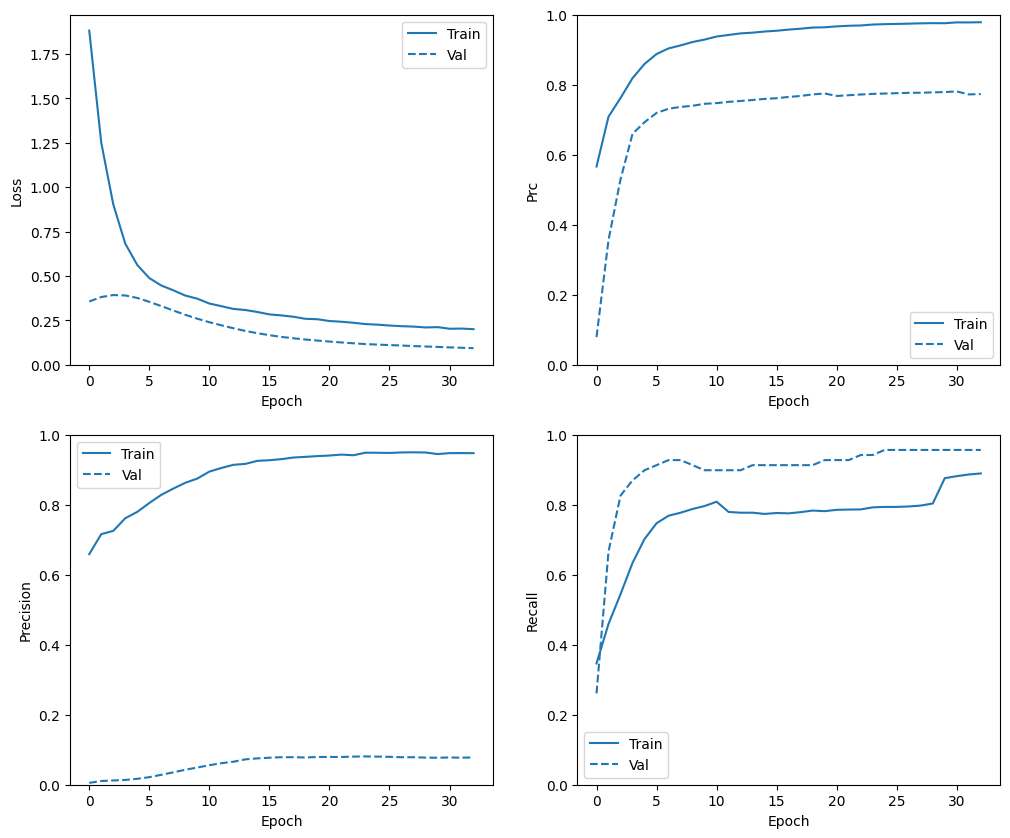

In [52]:
plot_metrics(resampled_history)

### 评估指标

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 8s

34/90 [==========>...................] - ETA: 0s

69/90 [======================>.......] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 1s

28/28 [==============================] - 0s 1ms/step


loss :  0.12108473479747772
tp :  95.0
fp :  915.0
tn :  55940.0
fn :  12.0
accuracy :  0.9837259650230408
precision :  0.09405940771102905
recall :  0.8878504633903503
auc :  0.9800193309783936
prc :  0.7522088289260864

Legitimate Transactions Detected (True Negatives):  55940
Legitimate Transactions Incorrectly Detected (False Positives):  915
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  95
Total Fraudulent Transactions:  107


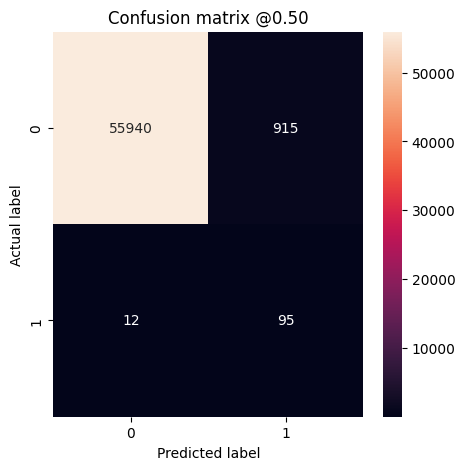

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### 绘制 ROC

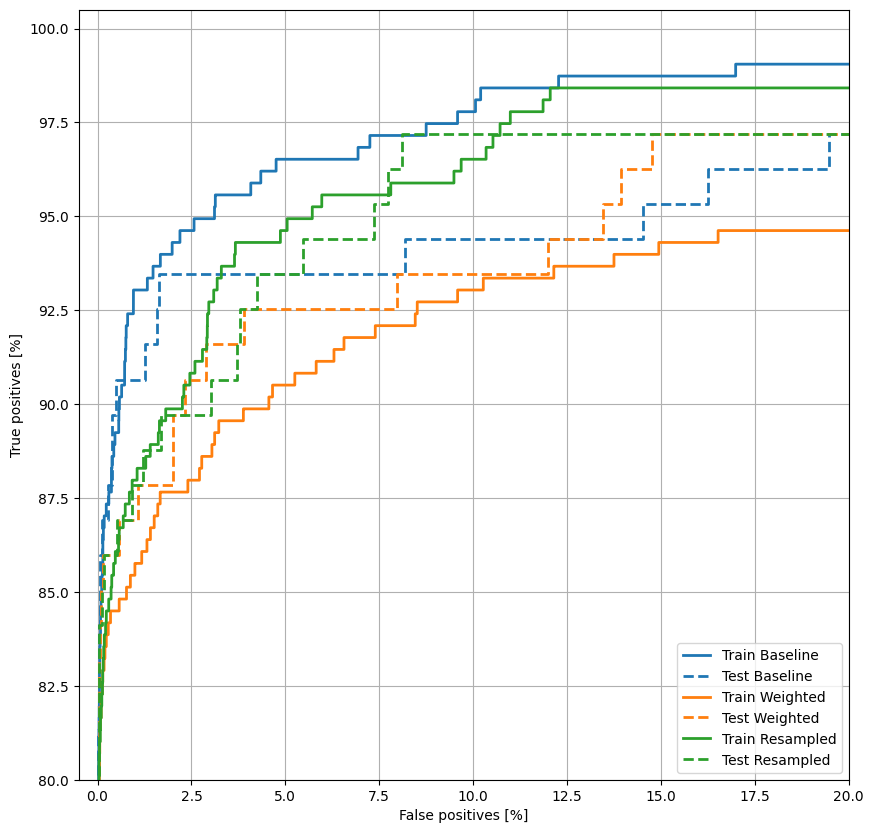

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### 绘制 AUPRC


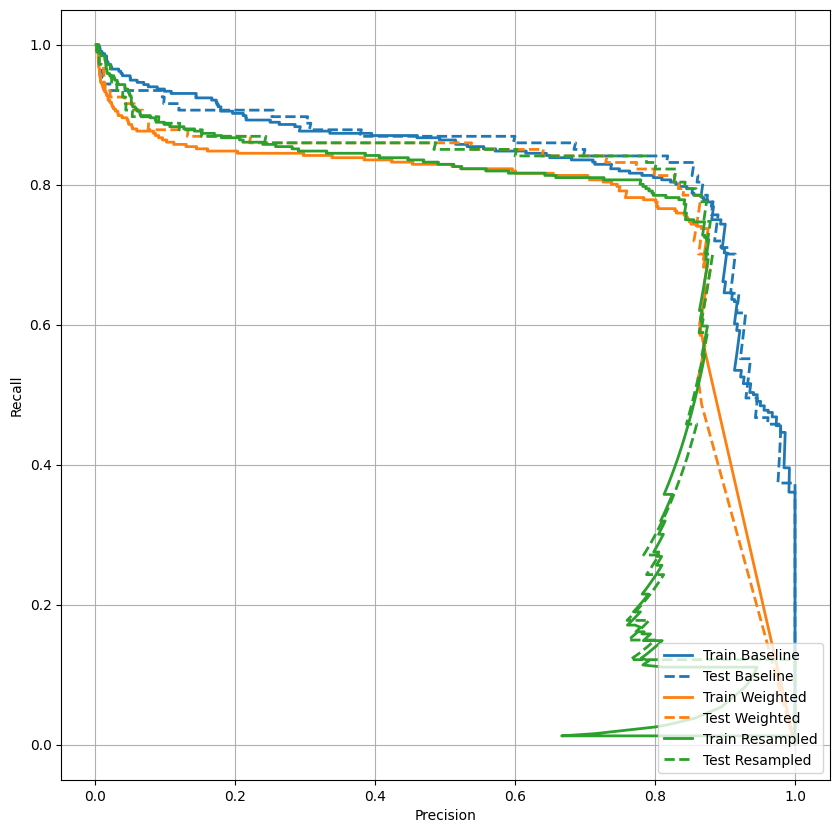

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## 使用本教程解决您的问题

由于可供学习的样本过少，不平衡数据的分类是固有难题。您应该始终先从数据开始，尽可能多地收集样本，并充分考虑可能相关的特征，以便模型能够充分利用占少数的类。有时您的模型可能难以改善且无法获得想要的结果，因此请务必牢记问题的上下文，并在不同类型的错误之间进行权衡。